# Lesson 2 : LangGraph Components

In [1]:
# !brew install graphviz
# export C_INCLUDE_PATH=$(brew --prefix graphviz)/include
# export LIBRARY_PATH=$(brew --prefix graphviz)/lib
# pip install pygraphviz

# get free Tavily key at https://app.tavily.com/sign-in and put in .env

In [9]:
from dotenv import load_dotenv
_ = load_dotenv()

In [33]:
import os
import shutil
import glob
from datetime import datetime
import time
from typing import TypedDict, Annotated
import operator
from IPython.display import Image, display, HTML, Markdown

import pandas as pd 

import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse

import sec_parser as sp
from sec_downloader import Downloader

# for Mac desktop automation
import pyautogui
import AppKit
from AppKit import NSApplication, NSApp, NSWorkspace

import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
# use firefox because it updates less often, can disable updates
# recommend importing profile from Chrome for cookies, passwords
# looks less like a bot with more user cruft in the profile
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import openai
from openai import OpenAI
import tiktoken

import asyncio
import aiohttp

from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_openai import ChatOpenAI
from langchain.tools import BaseTool, StructuredTool, tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.aiosqlite import AsyncSqliteSaver
from langchain_core.pydantic_v1 import BaseModel, Field

import wikipedia

import openbb
from openbb import obb

from newsapi import NewsApiClient



In [4]:
MODEL='gpt-4o'

DOWNLOAD_DIR = 'download'
OUTPUT_Dir = 'output'
DEFAULT_DOWNLOAD_DIR='/Users/drucev/Downloads/'


# Basic LangChain prompt completion


In [6]:
model = ChatOpenAI(model=MODEL)

messages = [
    SystemMessage(content="Translate the following from English into French"),
    HumanMessage(content="Listen to me. You are beautiful. You are flawless and I love you."),
]

response = model.invoke(messages)

print(response.content)


Écoute-moi. Tu es magnifique. Tu es parfaite et je t'aime.


# With a prompt template


In [7]:
system_template = "Translate the following into {language}:"
user_template = "Listen to me. You are {adjective1}. You are {adjective2} and I love you."

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), 
     ("user", user_template)]
)

parser = StrOutputParser()

chain = prompt_template | model | parser

# stream tokens as they are generated
response = ""
for r in chain.stream({"language": "German", "adjective1": "tops", "adjective2": "amazing"}):
    print(r, end="")
    response += r

# response


Hör mir zu. Du bist spitze. Du bist erstaunlich und ich liebe dich.

# Using a graph and a tool

In [10]:
mytool = TavilySearchResults(max_results=4) #increased number of results
print(type(mytool))
print(mytool.name)


<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [11]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
        

In [12]:
memory = AsyncSqliteSaver.from_conn_string(":memory:")

class Agent:

    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)
        
    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Sending tool results back to the model!")
        return {'messages': results}


In [13]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You can make multiple calls (either simultaneously or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model=MODEL)
lg_agent = Agent(model, [mytool], memory, system=prompt)


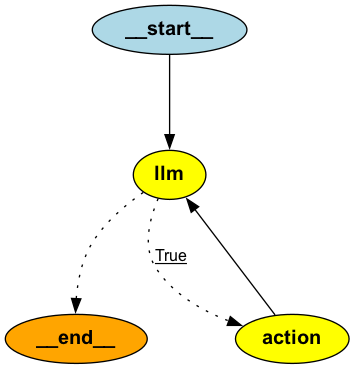

In [14]:
Image(lg_agent.graph.get_graph().draw_png())


In [15]:
messages = [HumanMessage(content="What is the current weather in Brooklyn and as of what time?")]
thread = {"configurable": {"thread_id": "1"}}
all_content=""
async for event in lg_agent.graph.astream_events({"messages": messages}, thread, version="v1"):
    kind = event["event"]
    if kind == "on_chat_model_stream":  # stream content
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="")
            all_content += content

display(Markdown("**Final result**"))

display(Markdown(all_content))


/opt/anaconda3/envs/langgraph/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: This API is in beta and may change in the future.
  warn_beta(


Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Brooklyn'}, 'id': 'call_qRaymAv3jNlVMgkX7TNnKCIm'}
Sending tool results back to the model!
The current weather in Brooklyn is as follows:

- **Temperature:** 79.3°F (26.3°C)
- **Condition:** Sunny
- **Humidity:** 41%
- **Wind:** 9.8 mph (15.8 kph) from the WNW
- **Visibility:** 10 km (6 miles)
- **UV Index:** 7
- **Updated Time:** 10:45 AM (local time)

This information is accurate as of 10:45 AM local time.

**Final result**

The current weather in Brooklyn is as follows:

- **Temperature:** 79.3°F (26.3°C)
- **Condition:** Sunny
- **Humidity:** 41%
- **Wind:** 9.8 mph (15.8 kph) from the WNW
- **Visibility:** 10 km (6 miles)
- **UV Index:** 7
- **Updated Time:** 10:45 AM (local time)

This information is accurate as of 10:45 AM local time.

# Using 2 tools in parallel

In [16]:
messages = [HumanMessage(content="What is the weather in San Francisco, Eureka, and Denver? and as of what time")]
thread = {"configurable": {"thread_id": "2"}}
all_content=""
async for event in lg_agent.graph.astream_events({"messages": messages}, thread, version="v1"):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="")
            all_content += content

display(Markdown(all_content))


Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'San Francisco weather'}, 'id': 'call_DiMvHqP8B70BffXrBF48T3Du'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Eureka weather'}, 'id': 'call_WYdo1Gl8V2wOPok0euPYqLQj'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Denver weather'}, 'id': 'call_udeEczhdPJJqiH5cYMfFTQRF'}
Sending tool results back to the model!
Here are the current weather conditions for San Francisco, Eureka, and Denver:

### San Francisco
- **Temperature:** 12.6°C (54.6°F)
- **Condition:** Partly Cloudy
- **Humidity:** 83%
- **Wind:** 4.7 mph (7.6 kph) from the WSW
- **Last Updated:** 2024-06-25 07:45 AM PDT

### Eureka
- **Temperature:** 11.8°C (53.2°F)
- **Condition:** Sunny
- **Humidity:** 85%
- **Wind:** 2.2 mph (3.6 kph) from the S
- **Last Updated:** 2024-06-25 07:45 AM PDT

### Denver
- **Temperature:** 26.1°C (78.9°F)
- **Condition:** Sunny
- **Humidity:** 24%
- **Wind:** 4.7 mph (7.6 kph) from the SSW
- 

Here are the current weather conditions for San Francisco, Eureka, and Denver:

### San Francisco
- **Temperature:** 12.6°C (54.6°F)
- **Condition:** Partly Cloudy
- **Humidity:** 83%
- **Wind:** 4.7 mph (7.6 kph) from the WSW
- **Last Updated:** 2024-06-25 07:45 AM PDT

### Eureka
- **Temperature:** 11.8°C (53.2°F)
- **Condition:** Sunny
- **Humidity:** 85%
- **Wind:** 2.2 mph (3.6 kph) from the S
- **Last Updated:** 2024-06-25 07:45 AM PDT

### Denver
- **Temperature:** 26.1°C (78.9°F)
- **Condition:** Sunny
- **Humidity:** 24%
- **Wind:** 4.7 mph (7.6 kph) from the SSW
- **Last Updated:** 2024-06-25 08:45 AM MDT

# 2 or more tools in sequence, where answer from 2nd depends on result from 1st

In [17]:
query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
Who are the statewide elected officials of that state? Answer each question." 
messages = [HumanMessage(content=query)]
thread = {"configurable": {"thread_id": "3"}}
all_content=""
async for event in lg_agent.graph.astream_events({"messages": messages}, thread, version="v1"):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="")
            all_content += content

display(Markdown(all_content))


Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl 2024 winner'}, 'id': 'call_wWLMzBjRZ4EnVnHqN1e0KMoR'}
Sending tool results back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location'}, 'id': 'call_0m5MPwpXAvzk3FLsXIbdoeY5'}
Sending tool results back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'statewide elected officials Missouri 2024'}, 'id': 'call_6tVbzn0KyR27VswTu5gXPj5R'}
Sending tool results back to the model!
### Who won the Super Bowl in 2024?
The Kansas City Chiefs won the Super Bowl in 2024, defeating the San Francisco 49ers with a score of 25-22.

### In what state is the winning team headquarters located?
The Kansas City Chiefs are headquartered in Kansas City, Missouri.

### Who are the statewide elected officials of Missouri?
As of 2024, the statewide elected officials in Missouri include:
- **Governor**: Mike Parson
- **Lieutenant Governor*

### Who won the Super Bowl in 2024?
The Kansas City Chiefs won the Super Bowl in 2024, defeating the San Francisco 49ers with a score of 25-22.

### In what state is the winning team headquarters located?
The Kansas City Chiefs are headquartered in Kansas City, Missouri.

### Who are the statewide elected officials of Missouri?
As of 2024, the statewide elected officials in Missouri include:
- **Governor**: Mike Parson
- **Lieutenant Governor**: Mike Kehoe
- **Secretary of State**: Jay Ashcroft
- **Attorney General**: Andrew Bailey
- **State Treasurer**: Vivek Malek
- **State Auditor**: Scott Fitzpatrick

These officials are responsible for various state executive functions and serve as key leaders in Missouri's government.

# Summarize a Wikipedia page


In [18]:
def delete_files(download_dir):
    """
    Deletes non-hidden files in the specified directory.

    Args:
        download_dir (str): The path to the directory containing the files.

    Raises:
        OSError: If there is an error while deleting a file.

    Note:
        This function does not delete subdirectories. If you want to remove subdirectories as well, use os.rmdir().

    Example:
        >>> delete_files('/path/to/directory')
    """

    # Iterate over all files in the directory
    for filename in os.listdir(download_dir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(download_dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')

delete_files(DOWNLOAD_DIR)


In [20]:
# get a list of wikipedia suggestions for a query using the wikipedia module

symbol = 'TSLA'
company = 'Tesla'

def fn_get_wikipedia_suggestions(symbol, company):
    """search for possible Wikipedia pages for a ticker symbol"""
    query_str = f'{company} ({symbol})'
    search_results = wikipedia.search(query_str)
    return search_results
        
search_results = fn_get_wikipedia_suggestions(symbol, company)
search_results


['Tesla, Inc.',
 "Elon Musk's Tesla Roadster",
 'History of Tesla, Inc.',
 'Tesla Autopilot',
 'Tesla Powerwall',
 'Tesla Model 3',
 'Tesla Semi',
 'Tesla Fremont Factory',
 'Tesla Model X',
 'TSLA']

In [21]:
# use LLM to pick the best page for symbol and company from search_results

# a Pydantic class to get a structured object back from an LLM query

class Wiki_title(BaseModel):
    title: str = Field(description="The title of the main Wikipedia page for a company")

        
def fn_pick_wiki_page(model, symbol, company, search_results):
    """Given a company, ticker, and a list of wikipedia pages search_results, return the most likely wikipedia page matching the given company and symbol"""

    system_template = """You will act as a Wikipedia page selection helper. 
    I will provide a description of a company I am writing a profile of, and a list of
    search results of possible Wikipedia pages to use formatted as a Python array. 
    Your task is to select the most relevant Wikipedia page from the search results to 
    help write a profile of the company."""

    user_template = """Given the following Wikipedia search results for the company 
    named {company} (ticker {symbol}), select the most likely main Wikipedia page for {company} 
    and return it as a JSON object with a single field named title:

    Search Results: 
    {search_results}
    """

    # use openai json response type
    wikititle_structured_model = model.with_structured_output(Wiki_title, method="json_mode")

    prompt_template = ChatPromptTemplate.from_messages(
        [("system", system_template),
         ("user", user_template)]
    )

    chain = prompt_template | wikititle_structured_model 
    response_obj = chain.invoke({"company": company,
                                 "symbol": symbol,
                                 "search_results": search_results},
                            )
    print(response_obj.title, flush=True)
    return response_obj.title

page = fn_pick_wiki_page(model, "TSLA", "Tesla", search_results)
page 

Tesla, Inc.


'Tesla, Inc.'

In [22]:
# fetch the wikipedia page

def fn_get_wiki_page(page):
    """Given the name of existing wikipedia page, return the content of the page"""
    return wikipedia.page(title=page, auto_suggest=False).content

page_content = fn_get_wiki_page(page)
page_content[:1000]

"Tesla, Inc. ( TESS-lə or  TEZ-lə) is an American multinational automotive and clean energy company headquartered in Austin, Texas, which designs, manufactures and sells battery electric vehicles (BEVs), stationary battery energy storage devices from home to grid-scale, solar panels and solar shingles, and related products and services. The company is also developing artificial intelligence and robotics products.\nTesla was incorporated in July 2003 by Martin Eberhard and Marc Tarpenning as Tesla Motors. The company's name is a tribute to inventor and electrical engineer Nikola Tesla. In February 2004, Elon Musk joined as the company's largest shareholder; in 2008, he was named chief executive officer. In 2008, the company began production of its first car model, the Roadster sports car, followed by the Model S sedan in 2012, the Model X SUV in 2015, the Model 3 sedan in 2017, the Model Y crossover in 2020, the Tesla Semi truck in 2022 and the Cybertruck pickup truck in 2023. The Model

In [23]:
# use the LLM to summarize the page based on a prompt, and save it to a file
def summarize_wiki_page(model, symbol, company, content):
    """Given the content of the company's wikipedia page, summarize the content of the page"""

    system_prompt = """You will act as a securities analyst with deep knowledge of financial markets, 
securities analysis, and portfolio management. You will maintain a professional yet engaging tone, 
in the style of a senior investment bank research analyst. You will provide facts
relevant to investors and avoid opinions unless specifically requested.
    """

    user_prompt = f"""You will focus on {company} ({symbol}). You will summarize the provided content below from
Wikipedia for {company} and summarize all topics of interest to investors on this page in 3000 
words or less, in particular the following topics:

Company Profile: An overview of {company}, including its history, commercial operations and sales 
by lines of business and geography, and recent key developments.

Products and services: {company} offerings, their features and benefits, target markets, recent 
changes such as launches and discontinuations of products and services. 

Strategic Initiatives: Information on deals, partnerships, mergers, acquisitions, divestitures, 
joint ventures, strategic initiatives, restructurings, and any other major developments.

Recent Events: Significant recent news events, management changes, controversies 
and other developments related to {company} or its industry which might impact its stock.

Use only the provided content below:
{content}
"""

    messages = [SystemMessage(content=system_prompt), HumanMessage(content=user_prompt)]
    prompt_template = ChatPromptTemplate.from_messages(messages)

    parser = StrOutputParser()

    chain = prompt_template | model | parser

    response_str = ""    
    for r in chain.stream(dict(symbol=symbol, company=company, page_content=page_content)):
        print(r, end="", flush=True)
        response_str += r

    outfile_name = "wiki_summary.txt"            
    with open(f"{DOWNLOAD_DIR}/{outfile_name}", "w") as outfile:
        outfile.write(response_str)
    return response_str

page_summary = summarize_wiki_page(model, symbol, company, page_content)
display(Markdown(page_summary))


### Tesla (TSLA) Overview and Key Investor Information

#### Company Profile
**Tesla, Inc.** is a leading American multinational automotive and clean energy company headquartered in Austin, Texas. Founded in July 2003 by Martin Eberhard and Marc Tarpenning, the company has grown under the leadership of Elon Musk, who joined as the largest shareholder in 2004 and became CEO in 2008. Tesla's mission is to accelerate the world's transition to sustainable energy.

Tesla designs, manufactures, and sells battery electric vehicles (BEVs), stationary battery energy storage systems from home to grid-scale, solar panels, and solar shingles. It is also developing artificial intelligence and robotics products. Tesla's impressive product lineup includes the Roadster, Model S, Model X, Model 3, Model Y, Tesla Semi, and Cybertruck.

**Key Developments:**
- **Market Leadership:** Tesla is one of the most valuable companies globally by market capitalization and became a trillion-dollar company in Octob

### Tesla (TSLA) Overview and Key Investor Information

#### Company Profile
**Tesla, Inc.** is a leading American multinational automotive and clean energy company headquartered in Austin, Texas. Founded in July 2003 by Martin Eberhard and Marc Tarpenning, the company has grown under the leadership of Elon Musk, who joined as the largest shareholder in 2004 and became CEO in 2008. Tesla's mission is to accelerate the world's transition to sustainable energy.

Tesla designs, manufactures, and sells battery electric vehicles (BEVs), stationary battery energy storage systems from home to grid-scale, solar panels, and solar shingles. It is also developing artificial intelligence and robotics products. Tesla's impressive product lineup includes the Roadster, Model S, Model X, Model 3, Model Y, Tesla Semi, and Cybertruck.

**Key Developments:**
- **Market Leadership:** Tesla is one of the most valuable companies globally by market capitalization and became a trillion-dollar company in October 2021.
- **Production Milestones:** In 2023, Tesla led the BEV market with a 19.9% share and ranked 69th in the Forbes Global 2000.
- **Expansion:** Tesla has expanded globally with Gigafactories in Nevada, Shanghai, Berlin-Brandenburg, Texas, and an upcoming plant in Mexico set for 2025.
- **Technology Leadership:** Known for its vertical integration, Tesla develops many components in-house, including batteries, motors, and software.

#### Products and Services
**Automotive Products:**
- **Model S:** A luxury full-size car with over 250,000 units sold as of 2018. It features dual motor, all-wheel drive, and has undergone significant design refreshes.
- **Model X:** A mid-size luxury crossover SUV with unique falcon-wing doors. It shares 30% of its content with the Model S.
- **Model 3:** A mid-size affordable car that became the world's bestselling electric car from 2018 to 2021, with cumulative sales surpassing 1 million units by June 2021.
- **Model Y:** A mid-size crossover SUV that became the world's best-selling car in Q1 2023, available in 5- and 7-passenger configurations.
- **Tesla Semi:** A Class 8 semi-truck boasting a range of 500 miles and three times the power of typical diesel trucks.
- **Cybertruck:** A full-sized pickup truck with a unique stainless steel design, it started deliveries in November 2023.

**Energy Products:**
- **Tesla Energy:** This division provides solar energy generation systems, including solar panels and the Tesla Solar Roof, and battery storage products like Powerwall and Megapack.
- **Virtual Power Plants:** Tesla operates a virtual power company in Texas, managing customers' Powerwall devices to sell power back to the grid.

**Services:**
- **Connectivity Services:** Tesla offers navigation and internet features through Standard and Premium Connectivity packages.
- **Vehicle Servicing:** Tesla provides remote diagnostics, mobile technician services, and maintenance recommendations without requiring annual inspections.
- **Charging Networks:** The Supercharger network offers fast charging, while the Destination Charger network provides slower charging at locations like hotels and restaurants.
- **Insurance Services:** Tesla offers its own vehicle insurance, leveraging its unique understanding of its vehicles to provide personalized pricing based on driving scores.

#### Strategic Initiatives
**Partnerships and Acquisitions:**
- **SolarCity Acquisition:** Tesla entered the solar installation market by acquiring SolarCity in 2016 for $2.6 billion.
- **Battery Suppliers:** Tesla collaborates with CATL, LG Energy Solution, and Panasonic for battery supply, with Panasonic co-locating production at Gigafactory Nevada.
- **Semiconductor Deal:** In April 2024, Tesla secured a semiconductor supply deal with Tata Electronics, boosting its expansion into the Indian market.
- **Abandoned Gigacasting Plans:** In May 2024, Tesla abandoned its next-generation gigacasting plans, opting for more proven methods of vehicle underbody casting.

**Investments:**
- **Bitcoin Investment:** In early 2021, Tesla invested $1.5 billion in Bitcoin, briefly accepting it as payment before reversing the decision due to environmental concerns.
- **Research and Development:** Tesla invests heavily in battery technology, lithium-ion research, and in-house production capabilities, including the development of the 4680-type battery cells.

#### Recent Events
**Management Changes and Controversies:**
- **Lawsuits and Scrutiny:** Tesla has faced numerous lawsuits and government scrutiny over issues like product defects, safety, labor practices, and Musk's controversial statements.
- **Sexual Harassment Allegations:** Multiple claims have been made against Tesla for facilitating a culture of sexual harassment at its Fremont factory.
- **Racial Discrimination:** Tesla has faced lawsuits alleging racial discrimination and harassment, leading to significant legal and reputational challenges.
- **COVID-19 Pandemic Response:** Tesla's response to the pandemic, including defying local government orders to reopen production, has drawn criticism.

**Significant News:**
- **Employee Layoffs:** In April 2024, Tesla announced a 10% reduction in its workforce.
- **Charging Standard Adoption:** Between May 2023 and February 2024, major North American EV manufacturers announced plans to adopt Tesla's North American Charging Standard adapters by 2025.
- **FSD Approval in China:** Tesla's Full Self-Driving (FSD) software received approval in China in late April 2024, marking a significant milestone for the company.

**Technology Developments:**
- **Autopilot and FSD:** Tesla continues to develop its Autopilot and Full Self-Driving systems, although it faces ongoing scrutiny and regulatory challenges regarding their safety and efficacy.
- **Robotics and AI:** Tesla is advancing in robotics with projects like the humanoid robot Optimus, which could aid in factory tasks and address labor shortages.

**Financial Performance:**
- **2023 Deliveries:** Tesla reported 2023 vehicle deliveries of 1.8 million units, a 38% increase from 2022.
- **Profitability:** Tesla achieved its first profit independent of Bitcoin and regulatory credits in Q2 2021, underscoring its operational strength.

**Conclusion:**
Tesla's innovative approach, diversified product line, and strategic initiatives continue to drive its market leadership in the automotive and clean energy sectors. However, ongoing legal challenges, management controversies, and market dynamics warrant close monitoring by investors.

In [24]:
def fn_perplexity_profile(symbol, company):
    """Return a company profile from Perplexity"""
    
    perplexity_url = "https://api.perplexity.ai/chat/completions"
    # https://docs.perplexity.ai/docs/model-cards
    perplexity_model = 'llama-3-70b-instruct'

    system_prompt = """
You will act as a securities analyst and investment advisor with deep knowledge of financial markets, 
securities analysis, portfolio management. You will maintain a professional yet engaging tone, 
in the style of a senior investment bank research analyst."
"""

    user_prompt = f"""You will focus on {company} ({symbol}), and provide a comprehensive analysis 
covering the following topics:

Company Profile: An overview of {company}, including its history, commercial operations and sales 
by lines of business and geography, and recent key developments.

Recent Events: Significant recent news events related to {company} or its industry impacting its stock.

Financial Performance: Recent earnings reports and stock performance compared to expectations, 
changes in dividends or stock buybacks.

Analyst Coverage: Summarize recent changes to analysts' ratings noting which analyst and firm 
made upgrades or downgrades on which date; summarize any recent short seller reports noting the 
firm and analyst.

Product Announcements: Launch of new products, strategic initiatives, or restructurings.

Strategic Initiatives: Information on deals, partnerships, mergers, acquisitions, divestitures, 
joint ventures, and major new business and revenue.

Securities Offerings: Announcements related to stock or bond issuances, buybacks, special 
dividends, or stock splits.

Management Changes: Significant personnel changes within {company}.

Stock Price Movements: Stock price trends and notable deviations from trend and reasons for them.
"""

    payload = {
        "model": perplexity_model,
        "messages": [
            {
                "role": "system",
                "content": system_prompt,
            },
            {
                "role": "user",
                "content": user_prompt,
            }
        ]
    }

    perplexity_headers = {
        "Authorization": f"Bearer {os.getenv('PERPLEXITY_API_KEY')}",
        "accept": "application/json",
        "content-type": "application/json"
    }

    response = requests.post(perplexity_url, json=payload, headers=perplexity_headers)
    if response.status_code == 200:
        response_str = response.json()['choices'][0]['message']['content']
        response_str = response_str.replace("$", "\\\$")
        with open(f"{DOWNLOAD_DIR}/profile_px.txt", "w") as outfile:
            outfile.write(response_str)
    else:
        response_str = response.content
    return response_str


profile_px = fn_perplexity_profile(symbol, company)

display(Markdown(profile_px))


**Tesla, Inc. (TSLA) - Comprehensive Analysis**

**Company Profile:**

Tesla, Inc. is a pioneering electric vehicle (EV) manufacturer and clean energy company founded in 2003 by Elon Musk, JB Straubel, Martin Eberhard, and Marc Tarpenning. Headquartered in Palo Alto, California, Tesla has disrupted the automotive industry with its innovative electric vehicles, energy storage systems, and solar panel manufacturing. The company operates through two primary segments: Automotive and Energy Generation & Storage.

Tesla's commercial operations span across the globe, with a significant presence in North America, Europe, and Asia. The company's product lineup includes the Model S, Model 3, Model X, Model Y, Cybertruck, and the upcoming Semi and Roadster. Tesla's energy products include the Powerwall home battery, Powerpack commercial battery, and SolarCity solar panels.

**Recent Events:**

* **Q2 2022 Earnings:** Tesla reported strong Q2 2022 earnings, with revenue increasing 42% year-over-year (YoY) to \\$16.9 billion, driven by a 27% YoY increase in vehicle deliveries. Net income rose 57% YoY to \\$2.3 billion, beating analyst estimates.
* **Supply Chain Disruptions:** Tesla faced production challenges in Q2 due to supply chain disruptions, particularly in China, which impacted vehicle deliveries.
* **Autonomous Driving Technology:** Tesla announced the rollout of its Full Self-Driving (FSD) beta software to a wider group of customers, marking a significant milestone in its autonomous driving technology development.
* **Competition:** The EV market is becoming increasingly competitive, with traditional automakers such as General Motors, Ford, and Volkswagen launching their own EV models.

**Financial Performance:**

* **Q2 2022 Earnings:** Tesla's Q2 2022 earnings beat analyst estimates, with revenue and net income increasing 42% and 57% YoY, respectively.
* **Stock Performance:** Tesla's stock has been volatile in recent months, trading between \\$600 and \\$900 per share. The stock is currently trading around \\$750 per share, down approximately 20% from its all-time high in November 2021.
* **Dividends and Buybacks:** Tesla does not pay dividends and has not announced any stock buybacks in recent quarters.

**Analyst Coverage:**

* **Upgrades:**
	+ Goldman Sachs analyst, Mark Delaney, upgraded Tesla to "Buy" from "Neutral" on July 25, 2022, citing the company's strong Q2 earnings and improving production efficiency.
	+ Deutsche Bank analyst, Emmanuel Rosner, upgraded Tesla to "Buy" from "Hold" on August 1, 2022, highlighting the company's leadership in the EV market and growing energy storage business.
* **Downgrades:**
	+ Morgan Stanley analyst, Adam Jonas, downgraded Tesla to "Equal-weight" from "Overweight" on June 15, 2022, citing concerns over the company's valuation and increasing competition in the EV market.
	+ Citigroup analyst, Itay Michaeli, downgraded Tesla to "Neutral" from "Buy" on July 10, 2022, citing the company's supply chain challenges and rising costs.

**Short Seller Reports:**

* **Citron Research:** Citron Research, a well-known short seller, published a report on July 20, 2022, highlighting Tesla's declining margins and increasing competition in the EV market.

**Product Announcements:**

* **Cybertruck:** Tesla launched its futuristic Cybertruck in November 2021, which has received over 1 million pre-orders.
* **Model Y:** Tesla started delivering the Model Y in March 2020, which has become one of the company's best-selling models.

**Strategic Initiatives:**

* **Tesla Energy:** Tesla is expanding its energy storage business, with plans to launch a new energy storage product, the Megapack, in 2023.
* **Autonomous Driving:** Tesla is investing heavily in its autonomous driving technology, with plans to launch a robotaxi service in the future.

**Securities Offerings:**

* **Stock Issuance:** Tesla issued 5 million shares of common stock in September 2020, raising approximately \\$5 billion in capital.

**Management Changes:**

* **Jerome Guillen:** Jerome Guillen, Tesla's President of Automotive, left the company in June 2022 to pursue other opportunities.

**Stock Price Movements:**

* **Trend:** Tesla's stock has been trending upward over the past year, driven by the company's strong earnings growth and increasing adoption of EVs.
* **Notable Deviations:** The stock experienced a notable deviation from its trend in May 2022, when it fell approximately 15% in a single day due to concerns over the company's supply chain disruptions and increasing competition in the EV market.

Overall, Tesla remains a leader in the EV market, with a strong brand and growing energy storage business. However, the company faces increasing competition and supply chain challenges, which may impact its stock performance in the near term.

In [25]:
def fn_get_obb_profile(symbol):

    obb_results = obb.equity.profile(symbol=symbol)
    profile_openbb = obb_results.results[0].long_description

    with open(f"{DOWNLOAD_DIR}/profile_openbb.txt", "w") as outfile:
        outfile.write(profile_openbb)
        
    return profile_openbb
    
print(fn_get_obb_profile(symbol))


Tesla, Inc. engages in the design, development, manufacture, and sale of electric vehicles and energy generation and storage systems. The company operates through Automotive and Energy Generation and Storage. The Automotive segment includes the design, development, manufacture, sale, and lease of electric vehicles as well as sales of automotive regulatory credits. The Energy Generation and Storage segment is involved in the design, manufacture, installation, sale, and lease of stationary energy storage products and solar energy systems, and sale of solar energy systems incentives. The company was founded by Jeffrey B. Straubel, Elon Reeve Musk, Martin Eberhard, and Marc Tarpenning on July 1, 2003 and is headquartered in Austin, TX.


In [26]:
def get_10k_item1_from_symbol(symbol):
    """
    Get item 1 of the latest 10-K annual report filing for a given symbol.

    Args:
        symbol (str): The symbol of the equity.

    Returns:
        str: The item 1 of the latest 10-K annual report filing, or None if not found.

    """
    item1_text = None
    try:
        # sec needs you to identify yourself for rate limiting
        dl = Downloader(os.getenv("SEC_FIRM"), os.getenv("SEC_USER"))
        html = dl.get_filing_html(ticker=symbol, form="10-K")
        elements: list = sp.Edgar10QParser().parse(html)
        tree = sp.TreeBuilder().build(elements)
        sections = [n for n in tree.nodes if n.text.lower().strip().startswith("item")]
        item1_node = sections[0]
        item1_text = "\n\n".join([n.text for n in sections[0].get_descendants()])
    except Exception as exc:
        return str(exc)
    # always return a list of dicts
    return item1_text


def summarize_10k(symbol, company, profile_10k):
    
    system_prompt = """You will act as a securities analyst with deep knowledge of financial markets, 
securities analysis, and portfolio management. You will maintain a professional yet engaging tone, 
in the style of a senior investment bank research analyst. You will provide facts
relevant to investors and avoid opinions unless specifically requested.
    """

    user_prompt = f"""You will focus on {company} ({symbol}). I will provide a profile of 
{company} from its 10k. Please summarize this page in 3000 words or less, covering 
topics of interest to investors, in particular the following topics:
    

Company Profile: An overview of {company}, including its history, commercial operations and sales 
by lines of business and geography, and recent key developments.

Products and services: {company} offerings, their features and benefits, target markets, recent 
changes such as launches and discontinuations of products and services. 

Strategic Initiatives: Information on deals, partnerships, mergers, acquisitions, divestitures, 
joint ventures, strategic initiatives, restructurings, and any other major developments.

Recent Events: Significant recent news events, management changes, controversies 
and other developments related to {company} or its industry which might impact its stock.

Use only the provided content below:
{profile_10k}
"""    

    messages = [SystemMessage(content=system_prompt), HumanMessage(content=user_prompt)]
    prompt_template = ChatPromptTemplate.from_messages(messages)

    parser = StrOutputParser()

    chain = prompt_template | model | parser

    response_str = ""    
    for r in chain.stream(dict(symbol=symbol, company=company, page_content=page_content)):
        print(r, end="", flush=True)
        response_str += r

    outfile_name = "profile_10k.txt"            
    with open(f"{DOWNLOAD_DIR}/{outfile_name}", "w") as outfile:
        outfile.write(response_str)
    return response_str


profile_10k = get_10k_item1_from_symbol(symbol)

profile_10k_summary = summarize_10k(symbol, company, profile_10k)

summary = profile_10k_summary.replace("$", "\\\$")  # so Markdown doesn't interpret as latex escape
display(Markdown(summary)) 


/opt/anaconda3/envs/langgraph/lib/python3.11/site-packages/sec_parser/processing_engine/core.py:153: UserWarning: Invalid section type for part1item1a. Defaulting to InvalidTopSectionIn10Q.
  elements = step.process(elements)
/opt/anaconda3/envs/langgraph/lib/python3.11/site-packages/sec_parser/processing_engine/core.py:153: UserWarning: Invalid section type for part2item7. Defaulting to InvalidTopSectionIn10Q.
  elements = step.process(elements)
/opt/anaconda3/envs/langgraph/lib/python3.11/site-packages/sec_parser/processing_engine/core.py:153: UserWarning: Invalid section type for part2item7a. Defaulting to InvalidTopSectionIn10Q.
  elements = step.process(elements)
/opt/anaconda3/envs/langgraph/lib/python3.11/site-packages/sec_parser/processing_engine/core.py:153: UserWarning: Invalid section type for part2item8. Defaulting to InvalidTopSectionIn10Q.
  elements = step.process(elements)
/opt/anaconda3/envs/langgraph/lib/python3.11/site-packages/sec_parser/processing_engine/core.py:15

### Tesla, Inc. (TSLA) Summary for Investors

**Company Profile:**

**Overview:**
Tesla, Inc. designs, develops, manufactures, sells, and leases fully electric vehicles and energy generation and storage systems. It offers services related to its products and aims to accelerate the world’s transition to sustainable energy. Tesla differentiates from competitors through its engineering expertise, vertically integrated business model, and focus on user experience.

**History and Operations:**
Tesla has established a global network of vehicle showrooms, service centers, Mobile Service, body shops, Supercharger stations, and Destination Chargers. The company strives to lower the cost of ownership for customers by reducing manufacturing costs and offering tailored financial services.

**Segments:**
Tesla operates two main segments:
1. **Automotive:** Includes electric vehicles, sales of automotive regulatory credits, services such as used vehicle sales, after-sales services, and insurance.
2.

### Tesla, Inc. (TSLA) Summary for Investors

**Company Profile:**

**Overview:**
Tesla, Inc. designs, develops, manufactures, sells, and leases fully electric vehicles and energy generation and storage systems. It offers services related to its products and aims to accelerate the world’s transition to sustainable energy. Tesla differentiates from competitors through its engineering expertise, vertically integrated business model, and focus on user experience.

**History and Operations:**
Tesla has established a global network of vehicle showrooms, service centers, Mobile Service, body shops, Supercharger stations, and Destination Chargers. The company strives to lower the cost of ownership for customers by reducing manufacturing costs and offering tailored financial services.

**Segments:**
Tesla operates two main segments:
1. **Automotive:** Includes electric vehicles, sales of automotive regulatory credits, services such as used vehicle sales, after-sales services, and insurance.
2. **Energy Generation and Storage:** Involves the design, manufacture, installation, sales, and leasing of solar energy products and energy storage products.

**Products and Services:**

**Vehicles:**
- **Model 3:** A four-door mid-size sedan with mass-market appeal.
- **Model Y:** A compact SUV with seating for up to seven adults, built on the Model 3 platform.
- **Model S:** A full-size sedan offering the highest performance and longest range.
- **Model X:** A mid-size SUV with high performance and seating for up to seven adults.
- **Cybertruck:** A full-size electric pickup truck with a stainless steel exterior, combining utility and strength with sports car speed.
- **Tesla Semi:** A commercial electric vehicle launched in early production in 2022.

**Energy Storage:**
- **Powerwall:** A lithium-ion battery designed for home or small commercial use.
- **Megapack:** An energy storage solution for commercial, industrial, utility, and energy generation customers, scalable to gigawatt-hour capacities.

**Solar Energy:**
- **Retrofit Solar Systems:** Sold directly or through power purchase agreements (PPA).
- **Solar Roof:** Combines premium glass roof tiles with energy generation capabilities.

**Technology:**
- Proprietary powertrain and battery technology.
- Dual and tri-motor configurations for enhanced performance.
- **Full Self-Driving (FSD) Technology:** Developing sophisticated AI and neural networks for self-driving cars.
- **Energy Products:** Modular battery systems and software for energy storage and grid integration.

**Sales and Marketing:**
Tesla employs a direct sales model through its website and company-owned stores, avoiding traditional advertising. The company also has a robust used vehicle market and growing public charging infrastructure.

**Service and Warranty:**
Tesla offers comprehensive service through company-owned locations and mobile units, with limited warranties on new and used vehicles and energy products.

**Financial Services:**
- **Financing and Leasing:** Available through Tesla and third-party financial institutions.
- **Insurance:** Launched in 2021, offering rates based on real-time driving behavior.

**Recent Strategic Initiatives:**

**Manufacturing Expansion:**
Tesla has manufacturing facilities in the U.S., China, and Germany, with plans for a new Gigafactory in Monterrey, Mexico. The company continues to expand production capacity at existing facilities.

**Supply Chain:**
Tesla sources thousands of parts from hundreds of suppliers globally, aiming for economies of scale and pricing efficiencies. The company manages risks by qualifying multiple suppliers and maintaining safety stock.

**Partnerships and Standards:**
Tesla has opened its Supercharger network to non-Tesla vehicles and established the North American Charging Standard (NACS). The company collaborates with SAE International to govern NACS as an industry standard.

**Environmental, Social, and Governance (ESG):**
Tesla is committed to sustainable practices, including efficient factory designs and responsible sourcing. The company emphasizes worker safety and provides competitive employee benefits.

**Human Capital Resources:**
Tesla invests in workforce development, offering various training programs, internships, and career development opportunities. The company promotes a respectful and inclusive work environment.

**Recent Events:**

**Inflation Reduction Act (IRA):**
The IRA provides multiple incentives for clean energy and electric vehicle adoption, including federal tax credits for qualifying Tesla customers.

**Regulatory Credits:**
Tesla earns and sells tradable credits under various zero-emission and clean fuel regulations.

**Supply Chain Disruptions:**
The global semiconductor shortage has impacted Tesla’s supply chain, highlighting risks related to single-source suppliers.

**Labor Relations:**
Tesla faces potential union activities, which may result in higher costs and work stoppages.

**Cybersecurity:**
Tesla implements robust cybersecurity measures to protect its data and systems. The company conducts regular testing, employee training, and third-party assessments to mitigate risks.

**Market and Competitive Landscape:**
Tesla operates in a highly competitive market with numerous established and new entrants. The company competes based on vehicle performance, technology, and a growing infrastructure of Superchargers and service centers.

**Risk Management:**
Tesla addresses risks related to manufacturing, supply chain, regulatory compliance, and market demand through strategic planning and continuous improvements.

**Conclusion:**
Tesla remains a leader in the electric vehicle and sustainable energy sectors, leveraging its technological innovations, direct sales model, and strategic expansions. The company’s commitment to sustainability, robust product offerings, and proactive risk management position it for continued growth in a competitive market.

In [30]:
def get_finviz_news(symbol):
    url = f"https://www.finviz.com/quote.ashx?t={symbol}"
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:91.0) Gecko/20100101 Firefox/91.0'}
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        print(f"Failed to retrieve data for {symbol}")
        return []

    soup = BeautifulSoup(response.content, 'html.parser')
    news_table = soup.find('table', {'id': 'news-table'})
    
    if not news_table:
        print(f"No news found for {symbol}")
        return []

    news_list = []
    for row in news_table.find_all('tr'):
        date_data = row.td.text.split(' ')
        if len(date_data) == 1:
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]

        a_tag = row.a
        if a_tag:
            headline = a_tag.text
            link = a_tag['href']
            news_list.append((date, time, headline, link))
            
    md_list = [f"[{headline}]({link})  " for _, _, headline, link in news_list]
    
    outfile_name = "finviz_news.txt"            
    with open(f"{DOWNLOAD_DIR}/{outfile_name}", "w") as outfile:
        outfile.write("\n".join(md_list))

    return news_list

news_list = get_finviz_news(symbol)
for _, _, headline, link in news_list:
    md_str = f"[{headline}]({link})"
    display(Markdown(md_str))


[A small group of tech stocks is driving the market rally  why that's 'not a flaw'](https://finance.yahoo.com/news/a-small-group-of-tech-stocks-is-driving-the-market-rally--why-thats-not-a-flaw-144132086.html)

[Tesla China Registrations Surge With Q2 Nearly Done. Cybertruck Hit With Another Recall.](https://finance.yahoo.com/m/0c71a58a-4e54-3ca9-803d-e46b43d1a507/tesla-china-registrations.html)

[Berkshire Hathaway accelerates sales of China's BYD](https://finance.yahoo.com/news/berkshire-hathaway-accelerates-sales-chinas-133350339.html)

[Tesla Cybertruck Recalled Again, Stock Rises Anyway](https://finance.yahoo.com/m/99bf56a8-e5f2-321e-8921-9ae1a2358ea1/tesla-cybertruck-recalled.html)

[We finally know how many Tesla Cybertrucks have actually been sold](https://qz.com/tesla-cybertruck-recall-sales-evs-wipers-elon-musk-1851558771)

[Nvidia sees over $500 billion wiped off value after shares slidethe biggest 3-day value loss for any company in history](https://finance.yahoo.com/news/nvidia-sees-over-500-billion-121230302.html)

[Tesla Stock Is Rising Despite a Cybertruck Recall](https://finance.yahoo.com/m/99bf56a8-e5f2-321e-8921-9ae1a2358ea1/tesla-stock-is-rising-despite.html)

[Can Tesla Double in 5 Years? Here's What It Would Take.](https://finance.yahoo.com/m/31a98ef6-1131-39bc-85ff-66a2769876dc/can-tesla-double-in-5-years%3F.html)

[3 Flying Car Stocks That Could Make Your Grandchildren Rich](https://investorplace.com/2024/06/3-flying-car-stocks-that-could-make-your-grandchildren-rich/)

[For Tesla's futuristic new Cybertruck, a fourth recall](https://finance.yahoo.com/news/teslas-futuristic-cybertruck-fourth-recall-103126793.html)

[The Cult of Tesla: Are Investors Buying Cars or Castles in the Air?](https://investorplace.com/2024/06/the-cult-of-tesla-are-investors-buying-cars-or-castles-in-the-air/)

[Tesla Makes Money Selling Electric Vehicles, But 86% of Its Earnings Might Soon Come From This Instead](https://finance.yahoo.com/m/bc17d57e-e4b8-39c0-a656-4a75b6202400/tesla-makes-money-selling.html)

[Tesla CEO Musk Is Working on Epic Master Plan 4. Expect Plenty of Robots.](https://finance.yahoo.com/m/f95a0ff3-318f-31df-8aaa-38764252f4bd/tesla-ceo-musk-is-working-on.html)

[Tesla 'one of the worst positioned' auto stocks for Q2 earnings season: analysts](https://finance.yahoo.com/news/tesla-one-worst-positioned-auto-072437959.html)

[Tesla recalls more than 23,000 Cybertrucks, NHTSA says](https://finance.yahoo.com/news/tesla-recalls-more-23-000-065415851.html)

[Tesla's Master Plan 4 sparks speculation](https://finance.yahoo.com/m/fc803619-344f-3c6f-9023-c0d3067d7b6e/tesla%27s-master-plan-4-sparks.html)

[Tesla (TSLA) Stock Moves -0.23%: What You Should Know](https://www.zacks.com/stock/news/2292487/tesla-tsla-stock-moves-0-23-what-you-should-know)

[Tesla Robotaxi Next After Huge Elon Musk Pay Deal; BYD In Buy Zone As Sales Rev](https://finance.yahoo.com/m/29c92e28-b5ab-392e-8f22-ae525864f9e8/tesla-robotaxi-next-after.html)

[What To Expect From Nvidia's Annual Shareholder Meeting Wednesday](https://www.investopedia.com/nvidia-annual-shareholder-meeting-2024-preview-8668080)

[Tesla Delivery Results Are Coming. Brace for More Bad News.](https://finance.yahoo.com/m/04147def-8d31-3df3-a9ce-bb3ea95b8b87/tesla-delivery-results-are.html)

[3 EV Stocks That Could Make Your Grandchildren Rich](https://investorplace.com/2024/06/3-ev-stocks-that-could-make-your-grandchildren-rich/)

[Rivian Stock Has Gone Full Circle (and NOT in a Good Way)](https://investorplace.com/2024/06/rivian-stock-has-gone-full-circle-and-not-in-a-good-way/)

[The 7 Smartest Cathie Wood Stocks to Buy With $10K Right Now](https://investorplace.com/2024/06/the-7-smartest-cathie-wood-stocks-to-buy-with-10k-right-now/)

[Famous Wall Street Analyst Says Tesla Inc (NASDAQ:TSLA) Will Double' Because of AI Business](https://www.insidermonkey.com/blog/famous-wall-street-analyst-says-tesla-inc-nasdaqtsla-will-double-because-of-ai-business-1317173/)

[The Next Big Thing After AI? 3 Sleeper Stocks to Buy Before the Boom](https://investorplace.com/2024/06/the-next-big-thing-after-ai-3-sleeper-stocks-to-buy-before-the-boom/)

[Considering Buying Tesla Stock? This May Be A Better Alternative](https://finance.yahoo.com/news/considering-buying-tesla-stock-may-145017118.html)

[Elon Musk Just Made Another Promise to Tesla Shareholders](https://finance.yahoo.com/m/c44033a4-93bc-37ce-b2c2-c9b5caef4606/elon-musk-just-made-another.html)

[Is Tesla the Best EV Stock for You?](https://finance.yahoo.com/m/65ab5670-bb18-3459-be42-8af632c75378/is-tesla-the-best-ev-stock.html)

[Tesla internal data shows company has cut at least 14% of workforce this year](https://www.youtube.com/watch?v=dWFoPbxvZR8)

[Linda Yaccarinos right-hand man out at X as global operations chief reportedly given the sack](https://finance.yahoo.com/news/linda-yaccarino-hand-man-x-122516756.html)

[UBS sees Tesla missing market's Q2 delivery target by 25,000](https://finance.yahoo.com/news/ubs-sees-tesla-missing-markets-115312105.html)

[3 Overhyped Stocks to Sell in June Before They Crash & Burn](https://investorplace.com/2024/06/3-overhyped-stocks-to-sell-in-june-before-they-crash-burn/)

[12 Best AI Stocks Leading the Big Tech Race' to $4 Trillion According to a Famous Wall Street Analyst](https://www.insidermonkey.com/blog/12-best-ai-stocks-leading-the-big-tech-race-to-4-trillion-according-to-a-famous-wall-street-analyst-1316892/)

[Elon Musk won his Tesla pay battle. Now he has to win his legal war.](https://finance.yahoo.com/news/elon-musk-won-his-tesla-pay-battle-now-he-has-to-win-his-legal-war-080001638.html)

[The Most Hated Brand in the US](https://finance.yahoo.com/news/most-hated-brand-us-222145812.html)

[Tesla, opponents of Musk's pay package clash over resolving compensation lawsuit](https://finance.yahoo.com/news/tesla-opponents-musks-pay-package-185821649.html)

[Can Rivian Stock Cross the Electric Vehicle Death Valley?](https://investorplace.com/2024/06/can-rivian-stock-cross-the-electric-vehicle-death-valley/)

[Load Up on Amazon Stock Before the Next Leg Higher](https://investorplace.com/2024/06/load-up-on-amazon-stock-before-the-next-leg-higher/)

[Elon's Golden Handcuffs: Why Tesla's Pay Package Is Even Worse Than the GameStop ATM](https://investorplace.com/2024/06/elons-golden-handcuffs-why-teslas-pay-package-is-even-worse-than-the-gamestop-atm/)

[AAPL Buy Alert: Apple Intelligence' Could Reignite iPhone Sales, Stock Growth](https://investorplace.com/2024/06/aapl-buy-alert-apple-intelligence-could-reignite-iphone-sales-stock-growth/)

[Wall Street Favorites: 3 Under-$20 Stocks With Strong Buy Ratings for June 2024](https://investorplace.com/2024/06/wall-street-favorites-3-under-20-stocks-with-strong-buy-ratings-for-june-2024/)

[Hedge Funds Are Crazy About Meta Platforms, Inc. (META)](https://www.insidermonkey.com/blog/hedge-funds-are-crazy-about-meta-platforms-inc-meta-1316765/)

[An Apple battery breakthrough, Tesla's America, and Fisker fails: Tech news roundup](https://qz.com/apple-battery-tesla-fisker-evs-neuralink-elon-musk-1851553668)

[Is Elon Musk Misunderstood, or Understood All Too Well?](https://finance.yahoo.com/m/9e024410-008a-3c46-943a-ce9d2790dbc9/is-elon-musk-misunderstood%2C.html)

[Tesla Stock (NASDAQ:TSLA): 2 Catalysts That Indicate a Turnaround](https://finance.yahoo.com/news/tesla-stock-nasdaq-tsla-2-070629550.html)

[Tesla is the most undervalued AI play in the market, says Wedbush's Dan Ives](https://www.youtube.com/watch?v=8f4wD7aiTSI)

[Li Auto Stock (NASDAQ:LI): What Has Gone Wrong?](https://finance.yahoo.com/news/li-auto-stock-nasdaq-li-215114726.html)

[Musk must now convince the courts on his Tesla pay package](https://finance.yahoo.com/video/musk-must-now-convince-courts-210905217.html)

[3 Auto Stocks to Buy Now: June 2024](https://investorplace.com/2024/06/3-auto-stocks-to-buy-now-june-2024/)

[Apple Intelligence: The Next Frontier in AI Development](https://investorplace.com/hypergrowthinvesting/2024/06/apple-intelligence-the-next-frontier-in-ai-development/)

[Analysts weigh in Tesla stock price target, deliveries and robotaxis](https://finance.yahoo.com/m/333d7d71-e6f8-3eae-8b9e-e5af07b95cae/analysts-weigh-in-tesla-stock.html)

[Analysts weigh in on Tesla stock price target, deliveries and robotaxis](https://finance.yahoo.com/m/46c35c70-826b-3712-951a-1f584bb0f0f1/analysts-weigh-in-on-tesla.html)

[Analysts reset Tesla stock price target ahead of Elon Musk's 'Master Plan 4'](https://finance.yahoo.com/m/46c35c70-826b-3712-951a-1f584bb0f0f1/analysts-reset-tesla-stock.html)

[Calls of the Day: Palo Alto, Tesla and Freeport-McMoran](https://www.youtube.com/watch?v=BqkAe7IaGKU)

[Tesla, opponents of Musk's pay clash over resolving compensation lawsuit](https://finance.yahoo.com/news/tesla-tells-judge-shareholder-vote-163200224.html)

[Hyundai Charges Ahead To Solidify Its EV Positioning Despite The Slowdown](https://finance.yahoo.com/news/hyundai-charges-ahead-solidify-ev-155636004.html)

[FLOKI Unveils New Developments and Strategic Marketing Initiatives](https://www.insidermonkey.com/blog/floki-unveils-new-developments-and-strategic-marketing-initiatives-1316190/)

[Alphabet Stands to Win From Teslas Robotaxi Day](https://finance.yahoo.com/m/aefbffbe-330e-3b7b-a5c5-01fbcd39455d/alphabet-stands-to-win-from.html)

[Tesla Deliveries Have Been Lousy. Thats Not About to Change.](https://finance.yahoo.com/m/7a1f5680-0f22-302d-9f61-6020dfe5a24e/tesla-deliveries-have-been.html)

[It turns out Tesla is the only one really struggling to sell EVs](https://qz.com/tesla-elon-musk-evs-electric-cars-sales-1851553041)

[3 Vegan Stocks to Buy Now: June 2024](https://investorplace.com/2024/06/3-vegan-stocks-to-buy-now-june-2024/)

[7 F-Rated Penny Stocks to Avoid This June](https://investorplace.com/market360/2024/06/7-f-rated-penny-stocks-to-avoid-this-june/)

[3 Penny Stocks to Buy Now: June 2024](https://investorplace.com/2024/06/3-penny-stocks-to-buy-now-june-2024/)

[Hype-nosis: Snap Out of the Trance and See These 3 Stocks for What They Really Are](https://investorplace.com/2024/06/hype-nosis-snap-out-of-the-trance-and-see-these-3-stocks-for-what-they-really-are/)

[Bill Gates wants to 'fix the cows'  here's the startup he backed to help fight climate change](https://finance.yahoo.com/news/bill-gates-wants-fix-cows-102200934.html)

[Lucid Stock Warning: Don't Light the Fuse on This Loose Cannon!](https://investorplace.com/market360/2024/06/lucid-stock-warning-dont-light-the-fuse-on-this-loose-cannon/)

[Investors are buying into AI and Musk any way they can: Morning Brief](https://finance.yahoo.com/news/investors-are-buying-into-ai-and-musk-any-way-they-can-morning-brief-100048708.html)

[3 Top Stock Picks to Invest in the World's Most Creative Companies](https://investorplace.com/2024/06/3-top-stock-picks-to-invest-in-the-worlds-most-creative-companies/)

[Tesla fights for Musk's money, Fisker dies, and Nvidia-backed self-driving trucks: Autos news roundup](https://qz.com/tesla-evs-elon-musk-theft-fisker-bankrupt-nvidia-waabi-1851551618)

[Nvidia on top, Microsoft's 'iPhone moment,' and Elon Musk's factory: AI news roundup](https://qz.com/nvidia-market-cap-microsoft-apple-ai-news-elon-musk-xai-1851551811)

[Someone Forgot to Tell Ford EV Sales Were Slowing](https://finance.yahoo.com/m/c2715d90-2cb8-32c7-ae85-4a0bf6b94835/someone-forgot-to-tell-ford.html)

[August 8 robotaxi day 'a key historical moment for the Tesla story'](https://finance.yahoo.com/news/august-8-robotaxi-day-key-082522554.html)

[Is Rivian a Millionaire-Maker Stock?](https://finance.yahoo.com/m/40ebbd69-9e27-3591-8e1a-a39c8a1d88b1/is-rivian-a-millionaire-maker.html)

[Tesla Cybertruck deliveries delayed due to wiper issues](https://www.digitimes.com/news/a20240620PD217/auto-components-cybertruck-production-capacity-tesla.html)

[Barclays remains cautious on Tesla stock. Here's why](https://finance.yahoo.com/news/barclays-remains-cautious-tesla-stock-063234492.html)

[Is Motley Foold the Best Stock Research Platform in 2024?](https://www.insidermonkey.com/blog/is-motley-foold-the-best-stock-research-platform-in-2024-1313790/)

[MNTN CEO Mark Douglas talks Elon Musk looking to bring advertisers back to X](https://www.youtube.com/watch?v=W37sTawHkRc)

[Mutual fund holdings suggest 10 stocks to buy, including Tesla](https://finance.yahoo.com/m/f195254f-65ea-3845-a4f8-22955ee44f4d/mutual-fund-holdings-suggest.html)

[China Is Mixed on Elon Muskbut They Sure Love His Mom](https://finance.yahoo.com/m/5da5426f-5b91-3435-b5d8-6d8bddc39c58/china-is-mixed-on-elon.html)

[15 Best Websites To Research Stocks](https://www.insidermonkey.com/blog/15-best-websites-to-research-stocks-1313431/)

[Nvidia company history & timeline: From GPU maker to AI leader](https://finance.yahoo.com/m/cf30b5f2-8bc5-3b7e-98d9-49fed252fc6a/nvidia-company-history-%26.html)

[A toddler was trapped in a Tesla after its battery died without warning amid record heat wavessafety comes last at Tesla, expert says](https://finance.yahoo.com/news/toddler-trapped-tesla-battery-died-210603658.html)

[Activists at Autodesk's Door](https://finance.yahoo.com/m/85aaf483-abe0-3708-808a-198693fa22e7/activists-at-autodesk%27s-door.html)

[Rags to Riches: 3 Robotics Stocks That Could Make Early Investors Rich](https://investorplace.com/2024/06/rags-to-riches-3-robotics-stocks-that-could-make-early-investors-rich/)

[Tesla's robotaxi unveiling won't just be about the technology: 'We're starting a new book'](https://finance.yahoo.com/news/teslas-robotaxi-unveiling-wont-just-be-about-the-technology-were-starting-a-new-book-170016124.html)

[Top Stock Movers Now: Accenture, Nvidia, Darden Restaurants, and More](https://www.investopedia.com/top-stock-movers-now-accenture-nvidia-darden-restaurants-and-more-8666481)

[Why We're Excited for the Next Wave of AI Growth](https://investorplace.com/hypergrowthinvesting/2024/06/investing-in-the-next-wave-of-explosive-ai-growth/)

[Chip stocks soar, housing market struggles: Morning Brief](https://finance.yahoo.com/video/chip-stocks-soar-housing-market-160758670.html)

[Avocado Prices: What to Expect After Inspection Pause Ends](https://investorplace.com/2024/06/avocado-prices-what-to-expect-after-inspection-pause-ends/)

[Musk Says Dell, Super Micro Computer Will Provide Hardware for His AI Startup](https://www.investopedia.com/musk-says-dell-super-micro-computer-will-provide-hardware-for-his-ai-startup-8666455)

[Elon Musk Just Supercharged DELL Stock. Where Does It Go Next?](https://investorplace.com/2024/06/elon-musk-just-supercharged-dell-stock-where-does-it-go-next/)

[Elon Musk walks back 'go f  yourself' comments to X advertisers](https://qz.com/musk-walks-back-go-f-yourself-comments-to-advertisers-1851550523)

[Tesla Stock Is Falling](https://finance.yahoo.com/m/98a8946e-1418-3b93-be5f-4d30fbfa6430/tesla-stock-is-falling.html)

[Dell and Super Micro Computer will build Elon Musk's 'AI factory'   and their stocks are jumping](https://qz.com/dell-super-micro-computer-stock-elon-musk-ai-nvidia-1851550428)

[Tesla Stock Is Falling. The AI Robotaxi Business Wont Be Easy, Analyst Says.](https://finance.yahoo.com/m/ad314e1c-d05e-351c-97a5-4e32443a76e9/tesla-stock-is-falling.-the.html)

[Cities are 'the biggest hurdle' for Tesla's robotaxi: Analyst](https://finance.yahoo.com/video/cities-biggest-hurdle-teslas-robotaxi-142837007.html)

[Elon Musk and His Grok AI Are Supercharging Super Micro (SMCI) Stock](https://investorplace.com/2024/06/elon-musk-and-his-grok-ai-are-supercharging-super-micro-smci-stock/)

[Got $5,000? These 3 Growth Stocks Are on Sale Right Now](https://finance.yahoo.com/m/4e6f4e75-3995-359e-b30f-34b2877db301/got-%245%2C000%3F-these-3-growth.html)

[5 Things to Know Before the Stock Market Opens](https://www.investopedia.com/5-things-to-know-before-the-stock-market-opens-june-20-2024-8666143)

[Dell Stock in Focus on News Company Will Provide Server Racks to xAI Supercomputer](https://www.investopedia.com/dell-stock-in-focus-on-news-company-will-provide-server-racks-to-xai-supercomputer-8666147)

In [70]:
outputdir = "download"
firefox_app_path = '/Applications/Firefox.app'
# Path to geckodriver
geckodriver_path = '/Users/drucev/webdrivers/geckodriver'
# Set up Firefox options to use your existing profile
# important for some sites that need a login, also a generic profile fingerprint that looks like a bot might get blocked
firefox_profile_path = '/Users/drucev/Library/Application Support/Firefox/Profiles/k8k0lcjj.default-release'

def init_driver(firefox_profile_path=firefox_profile_path,
                geckodriver_path=geckodriver_path,
               ):
    """open pages via selenium and firefox"""

    print(datetime.now().strftime('%H:%M:%S'), "Starting init_driver", flush=True)

    options = Options()
    options.profile = firefox_profile_path
    print(datetime.now().strftime('%H:%M:%S'), "Initialized profile", flush=True)

    # Create a Service object with the path
    service = Service(geckodriver_path)
    print(datetime.now().strftime('%H:%M:%S'), "Initialized service", flush=True)

    # Set up the Firefox driver
    driver = webdriver.Firefox(service=service, options=options)

    print(datetime.now().strftime('%H:%M:%S'), "Initialized webdriver", flush=True)
    return driver

driver = init_driver()


13:52:54 Starting init_driver
13:53:06 Initialized profile
13:53:06 Initialized service
13:53:45 Initialized webdriver


In [73]:
# Function to make sure the browser is in the foreground

def activate_app(app_name="Firefox"):
    for app_instance in NSWorkspace.sharedWorkspace().runningApplications():
        if  app_instance.localizedName() == app_name:
            app_instance.activateWithOptions_(AppKit.NSApplicationActivateIgnoringOtherApps)
            break
            
activate_app("Firefox")


In [78]:
# Function to check if the Selenium driver is still active
def is_driver_active(driver):
    try:
        session_id = driver.session_id
        if session_id:
            return True
        else:
            return False
    except WebDriverException:
        return False


In [338]:
def get_file(title, url, symbol, company, driver, scroll=0, click=None, initial_sleep=0):
    """
    Fetches a URL using a Selenium driver and parameters defined in sources.yaml.
    Updates sourcedict['latest'] with the path to the downloaded file.

    Args:
        title: a title for this page, to save the page
        url: the URL to fetch
        symbol: symbol to search for
        company: company to search for
        driver: the Selenium webdriver
        scroll: number of times to scroll to the bottom of the page for infinite scroll
        click: an xpath to click on (todo: make it a list of buttons to click, pausing sleeptime after each one)
        initial_sleep: how long to wait initially for long-loading pages

    Returns:
        str: The path to the downloaded file.

    Raises:
        Exception: If there is an error during the execution of the function.

    """
    sleeptime = 5
    
    # Open the page
    driver.get(url)

    # Wait for the page to load
    if not initial_sleep:
        initial_sleep = sleeptime
    time.sleep(initial_sleep)  # Adjust the sleep time as necessary
    
    if click:        
        print(datetime.now().strftime('%H:%M:%S'), f"Attempting to click on {click}", f'get_file({title})')
        button = driver.find_element(By.XPATH, click)
        if button:
            button.click()
            print(datetime.now().strftime('%H:%M:%S'), f"Clicked", 'get_files')

    wait = WebDriverWait(driver, 10)
    search_input = wait.until(
        EC.presence_of_element_located((By.CSS_SELECTOR, 'input[aria-label="Search for topics, locations & sources"]'))
    )
    
    # Click on the input element
    search_input.click()
    
    # Type "Salesforce (CRM)" into the input element
    search_str = f"{company} ({symbol})"
    search_input.send_keys(search_str)
    search_input.send_keys(Keys.RETURN)

    for _ in range(scroll):
        # scroll to bottom of infinite scrolling window
        driver.execute_script(
            "window.scrollTo(0, document.body.scrollHeight);")
        print(datetime.now().strftime('%H:%M:%S'), "Loading additional infinite scroll items",
            f'get_files({title})')
        time.sleep(sleeptime)  # wait for it to load additional items
        
    # Get the HTML source of the page
    time.sleep(sleeptime)
    html_source = driver.page_source

    # check encoding, default utf-8
    encoding = "utf-8"  # Default to UTF-8 if not specified
    # Retrieve the content-type meta tag from the HTML. For now just use utf-8
    #     try:
    #         meta_tag = driver.find_element(
    #             By.XPATH, "//meta[@http-equiv='Content-Type']")
    #         content_type = meta_tag.get_attribute("content")
    #         # Typical format is "text/html; charset=UTF-8"
    #         charset_start = content_type.find("charset=")
    #         if charset_start != -1:
    #             encoding = content_type[charset_start + 8:]
    #     except Exception as err:
    #         log(str(err))

    # Save the HTML to a local file
    datestr = datetime.now().strftime("%m_%d_%Y %I_%M_%S %p")
    outfile = f'{title} ({datestr}).html'
    print(datetime.now().strftime('%H:%M:%S'), f"Saving {outfile} as {encoding}", f'get_files({title})')
    destpath = DOWNLOAD_DIR + "/" + outfile
    with open(destpath, 'w', encoding=encoding) as file:
        file.write(html_source)

    return destpath

# try:
#     google_news_file = get_file('Google', 'https://news.google.com/home?hl=en-US&gl=US&ceid=US:en', 'CRM', 'Salesforce')
# except Exception as exc: 
#     print("Get_file error", exc)
#     print("Retrying with new driver")
#     driver = init_driver()
#     google_news_file = get_file('Google', 'https://news.google.com/home?hl=en-US&gl=US&ceid=US:en')



In [339]:
def get_path_from_url(url):
    parsed_url = urlparse(url)
    return parsed_url.path


def trimmed_href(link):
    """
    Trims everything in the link after a question mark such as a session ID.

    :param link: The input string or bs4 link.
    :return: The trimmed string.
    """
    # Find the position of the question mark
    if type(link) is str:
        s = link
    else:
        s = link.get("href")
    if s:
        question_mark_index = s.find("?")

        # If a question mark is found, trim the string up to that point
        if question_mark_index != -1:
            return s[:question_mark_index]
        else:
            # Return the original string if no question mark is found
            return s
    else:
        return s
    
def get_google_news(symbol, company, driver=None):
    
    if not driver:
        driver = init_driver()

    try:
        filename = get_file('Google', 'https://news.google.com/home?hl=en-US&gl=US&ceid=US:en', symbol, company, driver)
    except Exception as exc: 
        print("Get_file error", exc)
        print("Retrying with new driver")
        driver = init_driver()
        google_news_file = get_file('Google', 'https://news.google.com/home?hl=en-US&gl=US&ceid=US:en', symbol, company, driver)

    retlist = []
    with open(filename, "r") as file:
        html_content = file.read()

        # Parse the HTML content
        soup = BeautifulSoup(html_content, "html.parser")

        # Find all <a> tags
        if soup:
            links = soup.find_all("a")
        else:
            print(datetime.now().strftime(f"Skipping {url}, unable to parse"))
        print(datetime.now().strftime(f"found {len(links)} raw links"))

        # drop empty text
        links = [link for link in links if link.get_text(strip=True)]
        # drop some ArsTechnica links that are just the number of comments and dupe the primary link
        links = [link for link in links if not re.match(
            "^(\d+)$", link.get_text(strip=True))]

        # convert relative links to absolute links using base URL if present
        base_tag = soup.find('base')
        base_url = base_tag.get('href') if base_tag else url
        for link in links:
            link["href"] = urljoin(base_url, link.get('href', ""))

        # drop empty url path, i.e. url = toplevel domain
        links = [link for link in links if len(
            get_path_from_url(trimmed_href(link))) > 1]
        # drop anything that is not http, like javascript: or mailto:
        links = [link for link in links if link.get(
            "href") and link.get("href").startswith("http")]

    #     if exclude:
    #         for pattern in exclude:
    #             # filter links by exclusion pattern
    #             links = [
    #                 link
    #                 for link in links
    #                 if link.get("href") is not None and not re.match(pattern, link.get("href"))
    #             ]

    #     if include:
    #         for pattern in include:
    #             newlinks = []
    #             for link in links:
    #                 href = link.get("href")
    #                 if href and re.match(pattern, href):
    #                     newlinks.append(link)
    #             links = newlinks

        for link in links:
            url = trimmed_href(link)
            title = link.get_text(strip=True)
            if title == "LINK":
                # try to update title
                og_dict = get_og_tags(url)
                if og_dict.get("og:title"):
                    title = og_dict.get("og:title")

            # skip some low quality links that don't have full headline, like link to a Twitter or Threads account
            if len(title) <= 10 and title != "LINK":
                continue

            retlist.append({"title": title, "url": url})

        print(datetime.now().strftime(f"found {len(retlist)} filtered links"))
        
    retdf = pd.DataFrame(retlist)
    retdf["src"] = "Google News"
    retdf["date"] = datetime.now()
    return retdf[["date", "title", "url", "src"]]



In [340]:
get_google_news("CRM", "Salesforce")

14:42:18 Starting init_driver
14:42:29 Initialized profile
14:42:29 Initialized service
14:43:04 Initialized webdriver
14:43:15 Saving Google (06_26_2024 02_43_15 PM).html as utf-8 get_files(Google)
found 391 raw links
found 176 filtered links


,date,title,url,src
0,2024-06-26 14:43:16.041344,News Showcase,https://news.google.com/showcase,Google News
1,2024-06-26 14:43:16.041344,Entertainment,https://news.google.com/topics/CAAqJggKIiBDQkF...,Google News
2,2024-06-26 14:43:16.041344,More on weather.com,https://www.weather.com/wx/today/,Google News
3,2024-06-26 14:43:16.041344,Top stories,https://news.google.com/topics/CAAqJggKIiBDQkF...,Google News
4,2024-06-26 14:43:16.041344,Supreme Court Poised to Allow Emergency Aborti...,https://news.google.com/articles/CBMicGh0dHBzO...,Google News
...,...,...,...,...
171,2024-06-26 14:43:16.041344,Here's Why Investors Should Add Salesforce (CR...,https://news.google.com/articles/CBMiUGh0dHBzO...,Google News
172,2024-06-26 14:43:16.041344,IQVIA and Salesforce Expand Global Partnership...,https://news.google.com/articles/CBMiigFodHRwc...,Google News
173,2024-06-26 14:43:16.041344,Salesforce (CRM) is preparing to report Q1 ear...,https://news.google.com/articles/CBMiZGh0dHBzO...,Google News
174,2024-06-26 14:43:16.041344,Salesforce.com (CRM) Upgraded to Buy: Here's Why,https://news.google.com/articles/CBMiTWh0dHBzO...,Google News


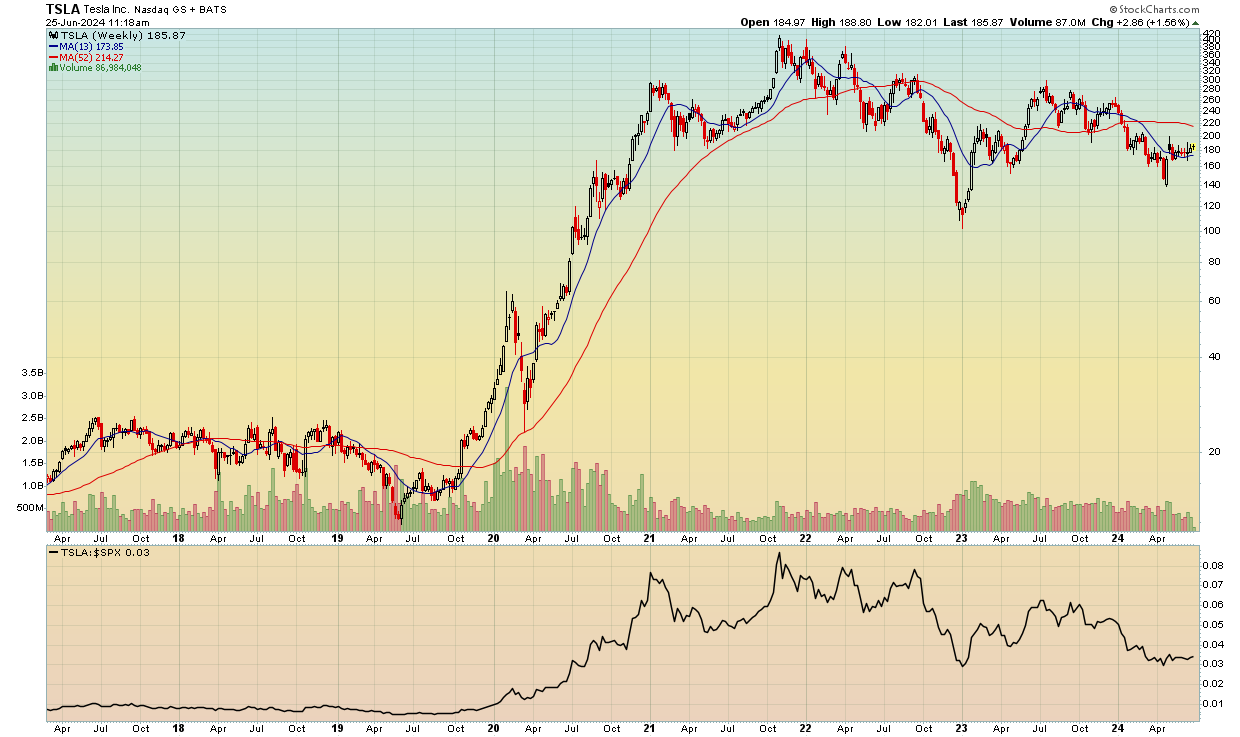

In [61]:
def fn_get_chart(driver, symbol):

    # switch to Firefox
    activate_app("Firefox")
    
    # Open the page
    url = f"https://stockcharts.com/h-sc/ui?s={symbol}&id=p33407302522&def=Y&listNum=1#"
    driver.get(url)

    # Locate the img tag containing the chart image
    chart_img = driver.find_element(By.ID, 'chartImg')
    
    # Create a selenium ActionChains object
    action_chains = ActionChains(driver)
    # Right click the image to get the context menu to appear    
    action_chains.context_click(chart_img).perform()
    # Wait for the context menu to appear
    time.sleep(1)

    # this is a aystem menu, can't use Selenium so use pyautogui
    # Simulate keyboard presses to navigate and select the "Save Image As..." option
    pyautogui.press('down')
    pyautogui.press('down')    
    pyautogui.press('enter')
    time.sleep(1)
        
    # Wait for the "Save As" dialog to appear
    time.sleep(1)
    # type the filename
    today_date_str = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    save_path = f"{symbol}-{today_date_str}"
    pyautogui.typewrite(save_path)
    pyautogui.press('Enter')
    
    img_path = save_path + ".png"
    # move it from default firefox download directory
    source_path = f'{DEFAULT_DOWNLOAD_DIR}/{img_path}'
    destination_path = f'{DOWNLOAD_DIR}/{img_path}'
    shutil.move(source_path, destination_path)
    
    return img_path


img_path = fn_get_chart(driver, symbol)

# display the image
with open(f"{DOWNLOAD_DIR}/{img_path}", 'rb') as f:
    image_data = f.read()
display(Image(image_data))


In [53]:
# a class to maintain the current state of the graph

class TearsheetState(TypedDict):
    
    company: str
    symbol: str
    wiki_search_results: str
    wiki_page_title: str
    wiki_page_text: str
    wiki_page_summary: str
    perplexity_profile: str
    obb_profile: str
    sec10k_profile: str
    chart: str
    error_state: str


In [54]:
# use a graph to run all the components.
# class will contain the graph, the model, and tools, and have nodes for the functions above

class TearsheetAgent:

    def __init__(self, model, tools, checkpointer):
        graph = StateGraph(TearsheetState)

        graph.add_node("get_wiki_page_suggestions", self.get_wikipedia_suggestions)
        graph.add_node("pick_wiki_page", self.pick_wiki_page)
        graph.add_node("get_wiki_page", self.get_wiki_page)
        graph.add_node("summarize_wiki_page", self.summarize_wiki_page)
        graph.add_node("get_perplexity_profile", self.get_perplexity_profile)
        graph.add_node("get_openbb_profile", self.get_openbb_profile)
        graph.add_node("get_10k_profile", self.get_10k_profile)
        graph.add_node("get_chart", self.get_chart)

        graph.set_entry_point("get_wiki_page_suggestions")
        graph.add_edge("get_wiki_page_suggestions", "pick_wiki_page")
        graph.add_edge("pick_wiki_page", "get_wiki_page")
        graph.add_edge("get_wiki_page", "summarize_wiki_page")
        graph.add_edge("summarize_wiki_page", "get_perplexity_profile")
        graph.add_edge("get_perplexity_profile", "get_openbb_profile")
        graph.add_edge("get_openbb_profile", "get_10k_profile")
        graph.add_edge("get_10k_profile", "get_chart")
        
        graph.set_finish_point("get_chart")
        
        self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)
        self.model = model
        self.driver = None
    

    def get_wikipedia_suggestions(self, state):
        """search for possible Wikipedia pages for a ticker symbol"""
        search_results = fn_get_wikipedia_suggestions(state["symbol"], state["company"])
        state["wiki_search_results"] = search_results
        return state
    

    def pick_wiki_page(self, state):
        """Given a company, ticker, and a list of wikipedia pages search_results, return the most likely wikipedia page matching the given company and symbol"""
        state["wiki_page_title"] = fn_pick_wiki_page(self.model,
                                                     state["symbol"],
                                                     state["company"],
                                                     state["wiki_search_results"]
                                                    )
        return state
    
    
    def get_wiki_page(self, state):
        """Given the name of existing wikipedia page, return the content of the page"""
        state["wiki_page_text"] = fn_get_wiki_page(state["wiki_page_title"])
        
        return state
    

    def summarize_wiki_page(self, state):
        """Given the content of the company's wikipedia page, summarize the content of the page"""

        state["wiki_page_summary"] = summarize_wiki_page(self.model, 
                                                         state["symbol"], 
                                                         state["company"], 
                                                         state["wiki_page_text"])

        return state
    
    
    def get_perplexity_profile(self, state):
        """Return a summary company profile from Perplexity"""
        state["perplexity_profile"] = fn_perplexity_profile(state["symbol"],
                                                            state["company"])
        return state
        

    def get_openbb_profile(self, state):
        """Return a summary company profile from Perplexity"""
        state["obb_profile"] = fn_get_obb_profile(state["symbol"])
        return state
        

    def get_10k_profile(self, state):
        """Return a summary company profile from SEC 10K"""

        profile_10k = get_10k_item1_from_symbol(state["symbol"])
        profile_10k_summary = summarize_10k(state["symbol"],
                                            state["company"], 
                                            profile_10k)

        state["sec10k_profile"] = profile_10k_summary
        return state

    
    def get_driver(self):
        if not self.driver:
            self.driver = init_driver()
        return self.driver
    
        
    def quit_driver():
        try:
            self.driver.quit()
        except Exception as exc:
            print(exc)

            
    def get_chart(self, state):
        """Return filename of the chart"""
        
        self.get_driver()
        activate_app("Firefox")
        img_path = fn_get_chart(self.driver, state["symbol"])
        state["chart"] = img_path
        return state    


    def run(self, config, state):

        self.get_driver()
        for step in self.graph.stream(state, config, stream_mode="debug"):
            if step["type"] == "checkpoint":
                print(step["step"], step["payload"].get("values"))

            # Check if there is an error message in the state
            if step["payload"].get("values") and step["payload"]["values"].get("error_message"):
                # Update the error state to 'tested' since error simulation is complete
                state['error_state'] = 'tested'
                # Retry from the last checkpoint saved by the checkpointer
                for retry_step in graph.stream(state, config, stream_mode="debug"):
                    if retry_step["type"] == "checkpoint":
                        print(retry_step["step"], retry_step["payload"].get("values"))
                break
        self.quit_driver()
        return None
       

In [55]:
model = ChatOpenAI(model=MODEL)
memory = SqliteSaver.from_conn_string(":memory:")

lg_agent = TearsheetAgent(model, [], memory)


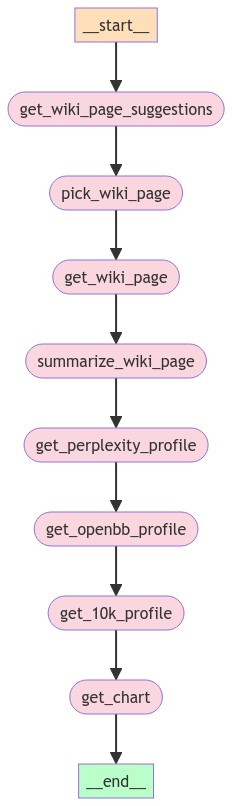

In [56]:
Image(lg_agent.graph.get_graph().draw_mermaid_png())

In [62]:
# Configuration with thread ID for checkpointing
config = {"configurable": {"thread_id": "profile-thread-1"}}
# initial state
state = TearsheetState(company="Tesla", symbol="TSLA")
lg_agent.run(config, state)


8 {'company': 'Tesla', 'symbol': 'TSLA', 'wiki_search_results': ['Tesla, Inc.', "Elon Musk's Tesla Roadster", 'History of Tesla, Inc.', 'Tesla Autopilot', 'Tesla Powerwall', 'Tesla Model 3', 'Tesla Semi', 'Tesla Fremont Factory', 'Tesla Model X', 'TSLA'], 'wiki_page_title': 'Tesla, Inc.', 'wiki_page_text': 'Tesla, Inc. ( TESS-lə or  TEZ-lə) is an American multinational automotive and clean energy company headquartered in Austin, Texas, which designs, manufactures and sells battery electric vehicles (BEVs), stationary battery energy storage devices from home to grid-scale, solar panels and solar shingles, and related products and services. The company is also developing artificial intelligence and robotics products.\nTesla was incorporated in July 2003 by Martin Eberhard and Marc Tarpenning as Tesla Motors. The company\'s name is a tribute to inventor and electrical engineer Nikola Tesla. In February 2004, Elon Musk joined as the company\'s largest shareholder; in 2008, he was named chi

Tesla, Inc.
11 {'company': 'Tesla', 'symbol': 'TSLA', 'wiki_search_results': ['Tesla, Inc.', "Elon Musk's Tesla Roadster", 'History of Tesla, Inc.', 'Tesla Autopilot', 'Tesla Powerwall', 'Tesla Model 3', 'Tesla Semi', 'Tesla Fremont Factory', 'Tesla Model X', 'TSLA'], 'wiki_page_title': 'Tesla, Inc.', 'wiki_page_text': 'Tesla, Inc. ( TESS-lə or  TEZ-lə) is an American multinational automotive and clean energy company headquartered in Austin, Texas, which designs, manufactures and sells battery electric vehicles (BEVs), stationary battery energy storage devices from home to grid-scale, solar panels and solar shingles, and related products and services. The company is also developing artificial intelligence and robotics products.\nTesla was incorporated in July 2003 by Martin Eberhard and Marc Tarpenning as Tesla Motors. The company\'s name is a tribute to inventor and electrical engineer Nikola Tesla. In February 2004, Elon Musk joined as the company\'s largest shareholder; in 2008, he 

12 {'company': 'Tesla', 'symbol': 'TSLA', 'wiki_search_results': ['Tesla, Inc.', "Elon Musk's Tesla Roadster", 'History of Tesla, Inc.', 'Tesla Autopilot', 'Tesla Powerwall', 'Tesla Model 3', 'Tesla Semi', 'Tesla Fremont Factory', 'Tesla Model X', 'TSLA'], 'wiki_page_title': 'Tesla, Inc.', 'wiki_page_text': 'Tesla, Inc. ( TESS-lə or  TEZ-lə) is an American multinational automotive and clean energy company headquartered in Austin, Texas, which designs, manufactures and sells battery electric vehicles (BEVs), stationary battery energy storage devices from home to grid-scale, solar panels and solar shingles, and related products and services. The company is also developing artificial intelligence and robotics products.\nTesla was incorporated in July 2003 by Martin Eberhard and Marc Tarpenning as Tesla Motors. The company\'s name is a tribute to inventor and electrical engineer Nikola Tesla. In February 2004, Elon Musk joined as the company\'s largest shareholder; in 2008, he was named ch

### Company Profile

**Overview and History:**
Tesla, Inc., headquartered in Austin, Texas, is a pioneering American multinational corporation specializing in automotive and clean energy solutions. Established in July 2003 by Martin Eberhard and Marc Tarpenning, the company was initially named Tesla Motors, a nod to the inventor Nikola Tesla. Elon Musk, who joined in February 2004 as the largest shareholder, became CEO in 2008. Tesla's journey began with the Roadster sports car in 2008, followed by the Model S in 2012, the Model X in 2015, the Model 3 in 2017, the Model Y in 2020, the Tesla Semi in 2022, and the Cybertruck in 2023. The Model 3 stands out as the best-selling plug-in electric car worldwide, surpassing 1 million units by June 2021. Tesla's market capitalization briefly exceeded $1 trillion in October 2021, making it one of the world's most valuable companies.

**Commercial Operations and Sales:**
Tesla leads the battery electric vehicle market with a 19.9% share in 2023. 

14 {'company': 'Tesla', 'symbol': 'TSLA', 'wiki_search_results': ['Tesla, Inc.', "Elon Musk's Tesla Roadster", 'History of Tesla, Inc.', 'Tesla Autopilot', 'Tesla Powerwall', 'Tesla Model 3', 'Tesla Semi', 'Tesla Fremont Factory', 'Tesla Model X', 'TSLA'], 'wiki_page_title': 'Tesla, Inc.', 'wiki_page_text': 'Tesla, Inc. ( TESS-lə or  TEZ-lə) is an American multinational automotive and clean energy company headquartered in Austin, Texas, which designs, manufactures and sells battery electric vehicles (BEVs), stationary battery energy storage devices from home to grid-scale, solar panels and solar shingles, and related products and services. The company is also developing artificial intelligence and robotics products.\nTesla was incorporated in July 2003 by Martin Eberhard and Marc Tarpenning as Tesla Motors. The company\'s name is a tribute to inventor and electrical engineer Nikola Tesla. In February 2004, Elon Musk joined as the company\'s largest shareholder; in 2008, he was named ch

15 {'company': 'Tesla', 'symbol': 'TSLA', 'wiki_search_results': ['Tesla, Inc.', "Elon Musk's Tesla Roadster", 'History of Tesla, Inc.', 'Tesla Autopilot', 'Tesla Powerwall', 'Tesla Model 3', 'Tesla Semi', 'Tesla Fremont Factory', 'Tesla Model X', 'TSLA'], 'wiki_page_title': 'Tesla, Inc.', 'wiki_page_text': 'Tesla, Inc. ( TESS-lə or  TEZ-lə) is an American multinational automotive and clean energy company headquartered in Austin, Texas, which designs, manufactures and sells battery electric vehicles (BEVs), stationary battery energy storage devices from home to grid-scale, solar panels and solar shingles, and related products and services. The company is also developing artificial intelligence and robotics products.\nTesla was incorporated in July 2003 by Martin Eberhard and Marc Tarpenning as Tesla Motors. The company\'s name is a tribute to inventor and electrical engineer Nikola Tesla. In February 2004, Elon Musk joined as the company\'s largest shareholder; in 2008, he was named ch

/opt/anaconda3/envs/langgraph/lib/python3.11/site-packages/sec_parser/processing_engine/core.py:153: UserWarning: Invalid section type for part1item1a. Defaulting to InvalidTopSectionIn10Q.
  elements = step.process(elements)
/opt/anaconda3/envs/langgraph/lib/python3.11/site-packages/sec_parser/processing_engine/core.py:153: UserWarning: Invalid section type for part2item7. Defaulting to InvalidTopSectionIn10Q.
  elements = step.process(elements)
/opt/anaconda3/envs/langgraph/lib/python3.11/site-packages/sec_parser/processing_engine/core.py:153: UserWarning: Invalid section type for part2item7a. Defaulting to InvalidTopSectionIn10Q.
  elements = step.process(elements)
/opt/anaconda3/envs/langgraph/lib/python3.11/site-packages/sec_parser/processing_engine/core.py:153: UserWarning: Invalid section type for part2item8. Defaulting to InvalidTopSectionIn10Q.
  elements = step.process(elements)
/opt/anaconda3/envs/langgraph/lib/python3.11/site-packages/sec_parser/processing_engine/core.py:15

## Tesla (TSLA) Overview for Investors

### Company Profile
Tesla, Inc., designs, develops, manufactures, sells, and leases high-performance fully electric vehicles and energy generation and storage systems. The company operates primarily through two segments: automotive and energy generation and storage. Tesla's mission is to accelerate the world’s transition to sustainable energy, a vision that is reflected in its comprehensive range of products and services. Founded in 2003, the company has grown exponentially, establishing a robust global presence with vehicle showrooms, service centers, Supercharger stations, and Destination Chargers.

Tesla's automotive segment includes the manufacturing and sales of electric vehicles and automotive regulatory credits. The company also generates revenue from services like sales of used vehicles, non-warranty after-sales vehicle services, body shop and parts services, paid Supercharging, vehicle insurance, and retail merchandise. The energy genera

Tesla faces various risks, including delays in product launches and production ramps, supply chain disruptions, and regulatory challenges. The company must manage the compliance, residual value, financing, and credit risks related to its financing programs. Tesla's future growth depends on the continued demand for electric vehicles and renewable energy products, as well as its ability to scale production and manage costs effectively.

In summary, Tesla's comprehensive product portfolio, strategic initiatives, and commitment to sustainability position the company as a leader in the transition to sustainable energy. However, the company must navigate significant risks and competition to maintain its market position and achieve its long-term goals.16 {'company': 'Tesla', 'symbol': 'TSLA', 'wiki_search_results': ['Tesla, Inc.', "Elon Musk's Tesla Roadster", 'History of Tesla, Inc.', 'Tesla Autopilot', 'Tesla Powerwall', 'Tesla Model 3', 'Tesla Semi', 'Tesla Fremont Factory', 'Tesla Model X

11:20:44 Starting init_driver
11:20:56 Initialized profile
11:20:56 Initialized service
11:21:31 Initialized webdriver
17 {'company': 'Tesla', 'symbol': 'TSLA', 'wiki_search_results': ['Tesla, Inc.', "Elon Musk's Tesla Roadster", 'History of Tesla, Inc.', 'Tesla Autopilot', 'Tesla Powerwall', 'Tesla Model 3', 'Tesla Semi', 'Tesla Fremont Factory', 'Tesla Model X', 'TSLA'], 'wiki_page_title': 'Tesla, Inc.', 'wiki_page_text': 'Tesla, Inc. ( TESS-lə or  TEZ-lə) is an American multinational automotive and clean energy company headquartered in Austin, Texas, which designs, manufactures and sells battery electric vehicles (BEVs), stationary battery energy storage devices from home to grid-scale, solar panels and solar shingles, and related products and services. The company is also developing artificial intelligence and robotics products.\nTesla was incorporated in July 2003 by Martin Eberhard and Marc Tarpenning as Tesla Motors. The company\'s name is a tribute to inventor and electrical en

In [63]:
with open(f"{DOWNLOAD_DIR}/wiki_summary.txt", "r") as infile:
    display(Markdown(infile.read()))

### Company Profile

**Overview and History:**
Tesla, Inc., headquartered in Austin, Texas, is a pioneering American multinational corporation specializing in automotive and clean energy solutions. Established in July 2003 by Martin Eberhard and Marc Tarpenning, the company was initially named Tesla Motors, a nod to the inventor Nikola Tesla. Elon Musk, who joined in February 2004 as the largest shareholder, became CEO in 2008. Tesla's journey began with the Roadster sports car in 2008, followed by the Model S in 2012, the Model X in 2015, the Model 3 in 2017, the Model Y in 2020, the Tesla Semi in 2022, and the Cybertruck in 2023. The Model 3 stands out as the best-selling plug-in electric car worldwide, surpassing 1 million units by June 2021. Tesla's market capitalization briefly exceeded $1 trillion in October 2021, making it one of the world's most valuable companies.

**Commercial Operations and Sales:**
Tesla leads the battery electric vehicle market with a 19.9% share in 2023. The company's global reach includes significant production facilities in the U.S., China, and Germany, which play a crucial role in its sales and distribution strategy. As of March 2024, Tesla remains the world's most valuable automaker, with considerable sales in both the U.S. and China contributing to its dominant market position.

**Key Developments:**
- **2021:** Tesla's market capitalization exceeded $1 trillion.
- **2023:** Model Y became the world's best-selling vehicle.
- **2024:** Tesla announced plans for a Gigafactory in Mexico, targeting a 2025 opening, and secured a semiconductor supply deal with Tata Electronics.
- **2024:** Approved Tesla's Full Self-Driving (FSD) in China and announced layoffs affecting 10% of its workforce.

### Products and Services

**Automotive Products:**
1. **Model S:** A full-size luxury sedan with dual motor all-wheel drive, known for its performance and range. The Model S has undergone significant design refreshes, most recently in June 2021.
2. **Model X:** A luxury crossover SUV with unique falcon-wing doors, available in multiple configurations. It shares many components with the Model S.
3. **Model 3:** A mid-size sedan designed for affordability and mass market appeal, which has seen major success since its 2017 launch.
4. **Model Y:** A mid-size crossover SUV, sharing around 75% of its components with the Model 3. It became the world’s best-selling car in Q1 2023.
5. **Tesla Semi:** A Class 8 semi-truck with significant power and range advantages, currently in pilot production with full production expected in 2025.
6. **Cybertruck:** A full-sized pickup with a polarizing design, pilot production began in July 2023 with deliveries starting in November 2023.

**Energy Products:**
- **Tesla Powerwall:** Home energy storage solutions.
- **Megapack:** Large-scale energy storage systems.
- **Solar Products:** Including solar panels and the Solar Roof, integrating solar energy generation with roofing materials.

**Charging and Connectivity Services:**
- **Supercharger Network:** High-voltage direct current fast chargers.
- **Destination Chargers:** Slower chargers for locations where customers stay longer, such as hotels and shopping centers.
- **Tesla Insurance:** Personalized vehicle insurance based on driving data.
- **Connectivity Services:** Standard and Premium Connectivity for navigation, internet browsing, and media streaming.

### Strategic Initiatives

**Partnerships and Deals:**
- **Panasonic:** Long-term partnership for battery cell development and production.
- **Lithium Supply Agreements:** Contracts with Piedmont Lithium and Core Lithium for raw material supply.
- **Semiconductor Supply Deal:** A 2024 agreement with Tata Electronics focusing on the Indian market.

**Acquisitions and Divestitures:**
- **SolarCity Acquisition (2016):** Integrated into Tesla Energy.
- **Wiferion Acquisition (2023):** A Germany-based wireless charging developer, later sold to Puls Group while retaining its staff.

**Manufacturing Expansion:**
- **Gigafactories:** New facilities in Shanghai, Berlin, Texas, and upcoming in Mexico, supporting Tesla's global production and market expansion.

### Recent Events

**Significant News:**
- **Bitcoin Investment and Sales:** Major investment in Bitcoin followed by discontinuation of Bitcoin payments and subsequent sale of most holdings by July 2022.
- **Legal Headquarters Move:** Relocated to Gigafactory Texas in December 2021.
- **Management Changes and Layoffs:** Announced a 10% workforce reduction in April 2024, reflecting strategic adjustments.

**Controversies:**
- **Autopilot and FSD Scrutiny:** Ongoing investigations and regulatory scrutiny over safety and functionality claims.
- **Labor Disputes and Lawsuits:** Multiple lawsuits related to worker rights, safety, and discrimination.
- **Sexual Harassment Claims:** Allegations and lawsuits filed by several former employees.

**Technological Developments:**
- **Battery Innovations:** Continued development of new battery types, including the 4680 cells.
- **Full Self-Driving (FSD):** Incremental software updates and regulatory approvals, with ongoing debates over its safety and feasibility.

Tesla's journey reflects its ambitious vision to revolutionize the automotive and clean energy industries. Despite facing numerous challenges and controversies, the company's innovative products, strategic expansions, and market leadership position it as a key player in the global transition to sustainable energy.

In [64]:
with open(f"{DOWNLOAD_DIR}/profile_px.txt", "r") as infile:
    display(Markdown(infile.read()))
    

**Tesla, Inc. (TSLA) - Comprehensive Analysis**

**Company Profile:**

Tesla, Inc. is a pioneering electric vehicle (EV) manufacturer and clean energy company founded in 2003 by Elon Musk, JB Straubel, Martin Eberhard, and Marc Tarpenning. Headquartered in Palo Alto, California, Tesla has disrupted the automotive industry with its innovative electric powertrains, autonomous driving capabilities, and over-the-air software updates. The company's product lineup includes luxury sedans (Model S, Model 3), SUVs (Model X, Model Y), and the upcoming Cybertruck. Tesla also offers energy storage products (Powerwall, Powerpack) and solar panels through its acquisition of SolarCity.

Commercial operations are divided into three segments: Automotive (95% of revenue), Energy Generation and Storage (4% of revenue), and Services and Other (1% of revenue). Geographically, Tesla generates 55% of its revenue from the United States, 25% from Europe, and 20% from Asia.

**Recent Events:**

1. **Q4 2022 Earnings Beat**: Tesla reported strong Q4 2022 earnings, with revenue up 37% year-over-year (YoY) to \\$24.6 billion, driven by increased vehicle deliveries and higher average selling prices.
2. **Price Cuts**: In January 2023, Tesla announced price cuts for its Model 3 and Model Y vehicles in the United States, China, and other markets, sparking concerns about demand and profitability.
3. **Cybertruck Production Delay**: Tesla delayed the production of its highly anticipated Cybertruck to mid-2023, citing production challenges and supply chain issues.
4. **Elon Musk's Twitter Acquisition**: Elon Musk's acquisition of Twitter in October 2022 has raised concerns about potential distractions from his role as Tesla's CEO.

**Financial Performance:**

* **Q4 2022 Earnings**: Tesla reported EPS of \\$1.19, beating consensus estimates of \\$1.13. Revenue growth was driven by a 40% YoY increase in vehicle deliveries.
* **Stock Performance**: Tesla's stock has been volatile, trading between \\$100 and \\$200 over the past year. The stock is currently trading at around \\$170, down 25% from its 52-week high.
* **Dividend and Buyback Policy**: Tesla does not pay dividends and has not announced any share buybacks in recent quarters.

**Analyst Coverage:**

* **Upgrades**:
	+ Morgan Stanley's Adam Jonas upgraded Tesla to "Overweight" on January 10, 2023, citing improved profitability and demand trends.
	+ RBC Capital Markets' Joseph Spak upgraded Tesla to "Outperform" on February 2, 2023, highlighting the company's leadership in the EV market.
* **Downgrades**:
	+ Goldman Sachs' Mark Delaney downgraded Tesla to "Neutral" on January 24, 2023, citing concerns about demand and pricing pressure.
	+ JPMorgan's Ryan Brinkman downgraded Tesla to "Underweight" on February 15, 2023, citing valuation concerns and increasing competition.
* **Short Seller Reports**:
	+ Citron Research's Andrew Left published a bearish report on Tesla in January 2023, citing concerns about demand and profitability.

**Product Announcements:**

* **Cybertruck**: Tesla's futuristic pickup truck is expected to enter production in mid-2023, with a starting price of around \\$40,000.
* **Model 3 and Model Y Updates**: Tesla has announced updates to its Model 3 and Model Y vehicles, including new interior designs and features.

**Strategic Initiatives:**

* **Full Self-Driving (FSD) Technology**: Tesla continues to develop its FSD technology, with plans to launch a robotaxi service in the future.
* **Tesla Energy**: The company is expanding its energy storage and solar panel business, with a goal of becoming a leading player in the clean energy market.

**Securities Offerings:**

* **Stock Issuance**: Tesla issued \\$2.7 billion in common stock in September 2022 to fund its growth initiatives.
* **Bond Issuance**: Tesla issued \\$1.5 billion in senior notes in November 2022 to refinance debt and fund capital expenditures.

**Management Changes:**

* **Elon Musk's Twitter Acquisition**: Elon Musk's acquisition of Twitter has raised concerns about potential distractions from his role as Tesla's CEO.
* **Jerome Guillen's Departure**: Jerome Guillen, Tesla's former President of Automotive, left the company in June 2022 to pursue other opportunities.

**Stock Price Movements:**

* **Trend**: Tesla's stock has been volatile, trading between \\$100 and \\$200 over the past year.
* **Notable Deviations**: The stock experienced a significant decline in January 2023 following the price cuts announcement, and has since recovered partially.
* **Reasons for Deviations**: Concerns about demand, pricing pressure, and profitability have contributed to the stock's volatility.

In [65]:
with open(f"{DOWNLOAD_DIR}/profile_openbb.txt", "r") as infile:
    display(Markdown(infile.read()))
    

Tesla, Inc. engages in the design, development, manufacture, and sale of electric vehicles and energy generation and storage systems. The company operates through Automotive and Energy Generation and Storage. The Automotive segment includes the design, development, manufacture, sale, and lease of electric vehicles as well as sales of automotive regulatory credits. The Energy Generation and Storage segment is involved in the design, manufacture, installation, sale, and lease of stationary energy storage products and solar energy systems, and sale of solar energy systems incentives. The company was founded by Jeffrey B. Straubel, Elon Reeve Musk, Martin Eberhard, and Marc Tarpenning on July 1, 2003 and is headquartered in Austin, TX.

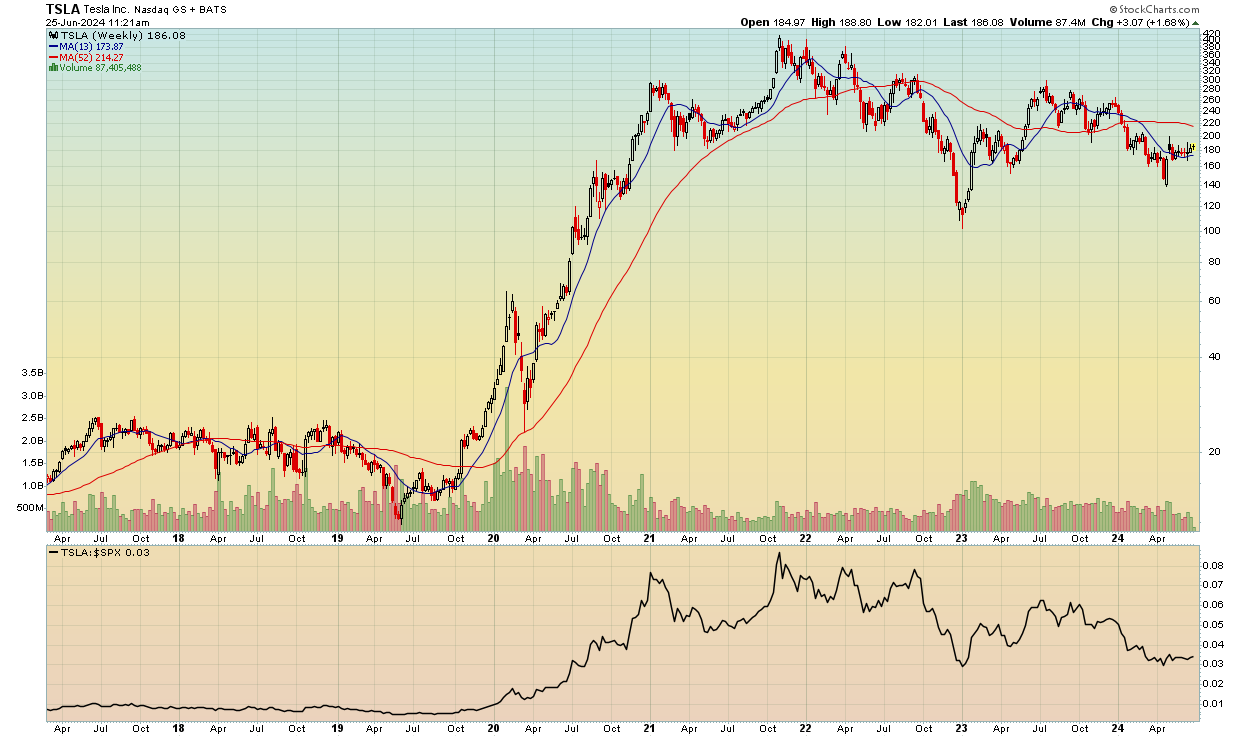

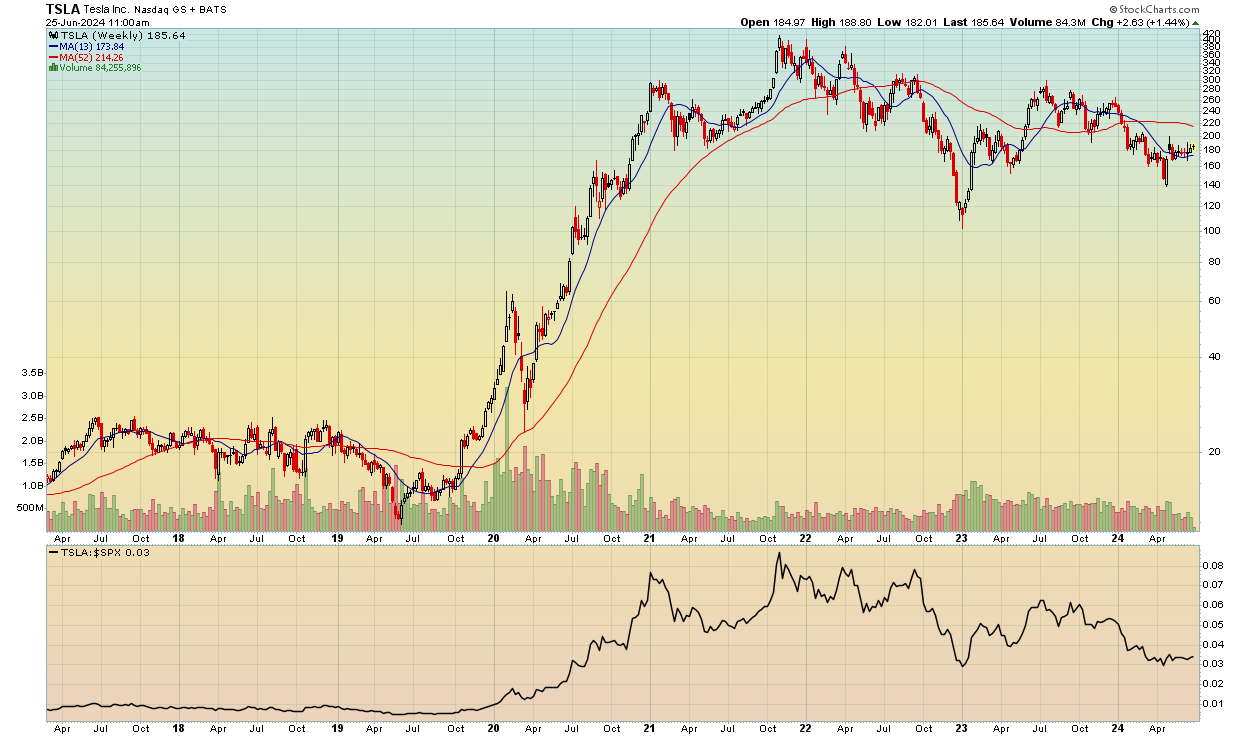

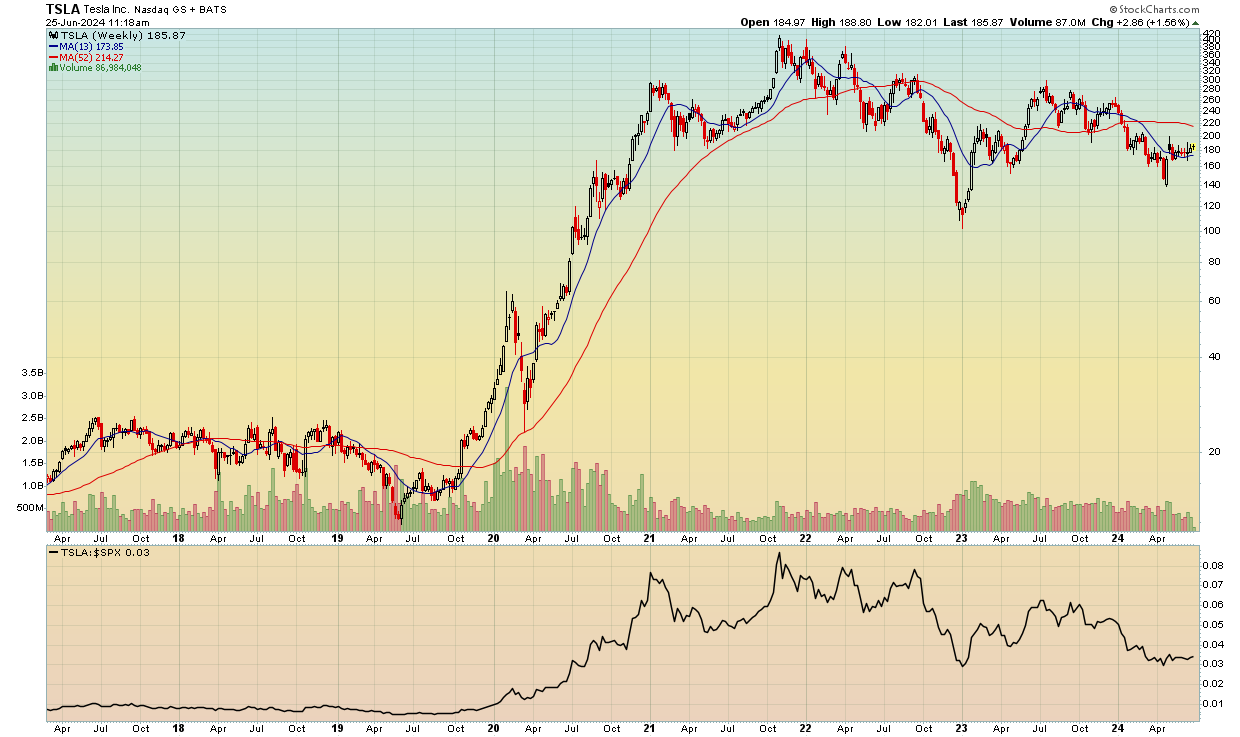

In [66]:
# display PNG files in the directory
png_files = glob.glob(os.path.join(DOWNLOAD_DIR, '*.png'))

# Loop through each PNG file and perform your desired operation
for png_file in png_files:
    display(Image(png_file))


In [167]:
# # bring headlines into dataframe
# # provider(s): benzinga, fmp, intrinio, polygon, tiingo, tmx, yfinance.')] = None,
# openbb_results = obb.news.company(symbol=symbol, provider='polygon')

# for obj in openbb_results.results:
#     display(Markdown(f'[{obj.date} {obj.title}]({obj.url})  '))

[2024-06-26 15:23:44+00:00 Why Tesla Stock Is Trading Higher Wednesday: 'Very Well Positioned To Deliver Robust Multi-Year Growth'](https://www.benzinga.com/news/24/06/39505959/why-tesla-stock-is-trading-higher-wednesday-very-well-positioned-to-deliver-robust-multi-year-growth)  

[2024-06-26 13:50:00+00:00 Tesla (TSLA) Recalls Nearly 12K Cybertrucks in Latest Setback](https://www.zacks.com/stock/news/2293737/tesla-tsla-recalls-nearly-12k-cybertrucks-in-latest-setback)  

[2024-06-26 13:45:32+00:00 Elon Musk Could Sell At Least 100,000 New Lower-Cost Models Next Year: 'Tesla Has Over 50% Share Of The US EV Market'](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39502910/elon-musk-could-sell-at-least-100-000-new-lower-cost-models-next-year-tesla-has-ove)  

[2024-06-26 12:40:00+00:00 Is Tesla Stock a Buy?](https://www.fool.com/investing/2024/06/26/is-tesla-stock-a-buy/)  

[2024-06-26 11:59:20+00:00 Elon Musk's EV Giant Will See Revenue From Its Auto Business Slumping This Year, But Tesla 'May Hold Some Important Cards In The Evolution Of The US Grid,' Says Analyst](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39499253/elon-musks-ev-giant-will-see-revenue-from-its-auto-business-slumping-this-year-but-)  

[2024-06-26 09:32:00+00:00 3 Autonomous Driving Leaders (Hint: Not Tesla)](https://www.fool.com/investing/2024/06/26/3-autonomous-driving-leaders-not-named-tesla/)  

[2024-06-26 04:53:07+00:00 An Important Magnificent 7 Indicator Finally Suggests Caution](https://seekingalpha.com/article/4701055-an-important-magnificent-7-indicator-finally-suggests-caution)  

[2024-06-26 02:24:00+00:00 What Went Wrong at Fisker Automotive?](https://www.fool.com/investing/2024/06/25/what-went-wrong-at-fisker-automotive/)  

[2024-06-25 16:27:20+00:00 Rivian Stock Puts Pedal To Floor As Analyst Compares EV Brand Power To Tesla](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39485303/rivian-stock-puts-pedal-to-floor-as-analyst-compares-ev-brand-power-to-tesla)  

[2024-06-25 14:11:51+00:00 Here's How Much $100 Invested In Tesla Stock Today Will Be Worth If Cathie Wood's Price Prediction Comes True In 2029](https://www.benzinga.com/general/education/24/06/39481466/heres-how-much-100-invested-in-tesla-stock-today-will-be-worth-if-cathie-woods-price-prediction)  

[2024-06-25 13:44:00+00:00 Toyota (TM) Makes Charging Stations Accessible to Other EVs](https://www.zacks.com/stock/news/2292971/toyota-tm-makes-charging-stations-accessible-to-other-evs)  

[2024-06-25 11:40:00+00:00 Can Tesla Double in 5 Years? Here's What It Would Take.](https://www.fool.com/investing/2024/06/25/can-tesla-double-in-5-years-heres-what-it-would-ta/)  

[2024-06-25 10:20:05+00:00 Should You Invest in the iShares U.S. Consumer Discretionary ETF (IYC)?](https://www.zacks.com/stock/news/2292632/should-you-invest-in-the-ishares-us-consumer-discretionary-etf-iyc)  

[2024-06-25 10:08:00+00:00 After a Massive Bankruptcy, EV Stocks Are in Trouble](https://www.fool.com/investing/2024/06/25/ev-stocks-are-still-in-trouble/)  

[2024-06-25 09:52:01+00:00 Tesla China's Weekly Insurance Registrations Hit Highest Since Start Of 2024: Bull Gary Black Terms It 'Excellent'](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39473004/tesla-chinas-weekly-insurance-registrations-hit-highest-since-start-of-2024-bull-ga)  

[2024-06-25 09:02:00+00:00 Tesla Makes Money Selling Electric Vehicles, But 86% of Its Earnings Might Soon Come From This Instead](https://www.fool.com/investing/2024/06/25/tesla-makes-money-electric-vehicles-86-of-earnings/)  

[2024-06-24 21:45:19+00:00 Tesla (TSLA) Stock Moves -0.23%: What You Should Know](https://www.zacks.com/stock/news/2292487/tesla-tsla-stock-moves--023-what-you-should-know)  

[2024-06-24 19:00:00+00:00 Will Canada Join the US and EU in Targeting China EVs?](https://www.zacks.com/stock/news/2292462/will-canada-join-the-us-and-eu-in-targeting-china-evs)  

[2024-06-24 17:00:00+00:00 Beyond Tesla, Bet on Elon Musk With These Stocks & ETFs](https://www.zacks.com/stock/news/2292447/beyond-tesla-bet-on-elon-musk-with-these-stocks-etfs)  

[2024-06-24 15:19:02+00:00 'Stock Market Has A Bad Breadth Problem Again,' Veteran Wall Street Investor Warns](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39459711/stock-market-has-a-bad-breadth-problem-again-veteran-wall-street-investor-warns)  

[2024-06-24 14:26:36+00:00 Elon Musk Just Made Another Promise to Tesla Shareholders](https://www.fool.com/how-to-invest/thirteen-steps/2024/06/24/elon-musk-just-made-another-promise-to-tesla-share/)  

[2024-06-24 13:15:00+00:00 Is Tesla the Best EV Stock for You?](https://www.fool.com/investing/2024/06/24/is-tesla-the-best-ev-stock-for-you/)  

[2024-06-24 10:20:07+00:00 Should You Invest in the Vanguard Consumer Discretionary ETF (VCR)?](https://www.zacks.com/stock/news/2291917/should-you-invest-in-the-vanguard-consumer-discretionary-etf-vcr)  

[2024-06-24 06:24:07+00:00 Tesla: 2024 Is Not A BEV Year (Rating Downgrade)](https://seekingalpha.com/article/4700627-tesla-stock-2024-not-bev-year-rating-downgrade-sell)  

[2024-06-23 13:00:00+00:00 With Shares Down Nearly 60%, Is Now the Time to Buy This EV Stock?](https://www.fool.com/investing/2024/06/23/with-shares-down-nearly-60-is-now-the-time-to-buy/)  

[2024-06-21 20:18:50+00:00 Nvidia Snaps 8-Week Winning Run, S&P 500 Marks Longest Streak Without A 2% Drop Since Great Recession, Oil Prices Stage Comeback: This Week In The Market](https://www.benzinga.com/markets/equities/24/06/39441062/nvidia-snaps-8-week-winning-run-s-p-500-marks-longest-streak-without-a-2-drop-since-great-recess)  

[2024-06-21 13:41:12+00:00 7 Charts That Show How Extreme Nvidia's Valuation Has Become](https://seekingalpha.com/article/4700358-7-charts-that-show-how-extreme-nvidia-valuation-has-become)  

[2024-06-21 13:26:10+00:00 Tesla Bull Says Stock's Nightmarish Lean Patch Will Likely End As Demand Turnaround Begins To Take Hold: This Upcoming Catalyst Is 'Key Historic Moment' For EV Maker](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39432643/tesla-bull-says-stocks-nightmarish-lean-patch-will-likely-end-as-demand-turnaround-)  

[2024-06-21 08:05:00+00:00 Is Rivian a Millionaire-Maker Stock?](https://www.fool.com/investing/2024/06/21/is-rivian-a-millionaire-maker/)  

[2024-06-21 06:14:37+00:00 Tesla To Follow Nvidia, Amazon Playbook? Bullish Analyst Says Elon Musk's Master Plan 4 Will Detail 'Anything But Cars'](https://www.benzinga.com/markets/equities/24/06/39426945/tesla-to-follow-nvidia-amazon-playbook-bullish-analyst-says-elon-musks-master-plan-4-will-detail)  

[2024-06-20 20:22:00+00:00 3 Intriguing Auto Stocks to Buy Now](https://www.zacks.com/commentary/2291065/3-intriguing-auto-stocks-to-buy-now)  

[2024-06-20 19:33:18+00:00 Activists at Autodesk's Door](https://www.fool.com/investing/2024/06/20/activists-at-autodesks-door/)  

[2024-06-20 19:29:57+00:00 Apple Arrives on the Scene With Its AI Debut](https://www.fool.com/investing/2024/06/20/apple-arrives-on-the-scene-with-its-ai-debut/)  

[2024-06-20 13:00:00+00:00 Got $5,000? These 3 Growth Stocks Are on Sale Right Now](https://www.fool.com/investing/2024/06/20/got-5000-these-3-growth-stocks-are-on-sale-now/)  

[2024-06-19 09:02:00+00:00 2 Artificial Intelligence (AI) Dividend Stocks You Can Buy and Hold for the Next Decade](https://www.fool.com/investing/2024/06/19/artificial-intelligence-ai-dividend-stocks-to-buy/)  

[2024-06-19 04:00:00+00:00 View From The Top: 1999 Vs. Now](https://seekingalpha.com/article/4699932-view-from-top-1999-vs-now)  

[2024-06-18 21:45:18+00:00 Tesla (TSLA) Stock Drops Despite Market Gains: Important Facts to Note](https://www.zacks.com/stock/news/2290086/tesla-tsla-stock-drops-despite-market-gains-important-facts-to-note)  

[2024-06-18 15:40:07+00:00 F vs. TSLA: Which Stock Is the Better Value Option?](https://www.zacks.com/stock/news/2289966/f-vs-tsla-which-stock-is-the-better-value-option)  

[2024-06-18 14:03:00+00:00 Here's the Staggering Amount of Money Ford Loses on Each EV It Makes](https://www.fool.com/investing/2024/06/18/heres-the-staggering-amount-of-money-ford-loses-on/)  

[2024-06-18 13:39:00+00:00 The Zacks Analyst Blog Highlights General Motors, Tesla, ChargePoint, Blink Charging and Lion Electric](https://www.zacks.com/stock/news/2289876/the-zacks-analyst-blog-highlights-general-motors-tesla-chargepoint-blink-charging-and-lion-electric)  

[2024-06-18 12:30:00+00:00 1 Underappreciated Reason Nvidia Stock Is a Table-Pounding Buy](https://www.fool.com/investing/2024/06/18/1-underappreciated-reason-nvidia-stock-is-a-table/)  

[2024-06-18 09:30:00+00:00 Tesla's Tariff Problem Has Just Begun](https://www.fool.com/investing/2024/06/18/teslas-tariff-threat/)  

[2024-06-17 14:04:06+00:00 Great News for Tesla, So Why Is the Stock Down?](https://www.fool.com/investing/2024/06/17/great-news-for-tesla-so-why-is-the-stock-down/)  

[2024-06-17 13:00:15+00:00 Tesla, Inc. (TSLA) Is a Trending Stock: Facts to Know Before Betting on It](https://www.zacks.com/stock/news/2288996/tesla-inc-tsla-is-a-trending-stock-facts-to-know-before-betting-on-it)  

[2024-06-17 12:21:00+00:00 EV Roundup: TSLA Shareholders Back Musk's Pay, GM Trims 2024 EV Outlook & More](https://www.zacks.com/stock/news/2289071/ev-roundup-tsla-shareholders-back-musks-pay-gm-trims-2024-ev-outlook-more)  

[2024-06-16 10:20:00+00:00 Will Walmart Reach a Trillion-Dollar Market Cap by 2030?](https://www.fool.com/investing/2024/06/16/will-walmart-reach-trillion-dollar-market-cap-2030/)  

[2024-06-16 09:12:00+00:00 Billionaires Are Selling Nvidia Stock and Buying 2 Magnificent Index Funds Instead](https://www.fool.com/investing/2024/06/16/billionaires-sell-nvidia-stock-buy-2-index-funds/)  

[2024-06-15 08:13:00+00:00 1 Magnificent EV Stock Down 50% to Buy and Hold Forever](https://www.fool.com/investing/2024/06/15/1-magnificent-ev-stock-down-50-to-buy-and-hold-for/)  

[2024-06-14 19:00:00+00:00 Shareholders Back Musk's Pay: Hold Tesla (TSLA) for Long-Term](https://www.zacks.com/stock/news/2288705/shareholders-back-musks-pay-hold-tesla-tsla-for-long-term)  

[2024-06-14 15:58:35+00:00 Elon Musk's $56B Payday Wins In Landslide: 'Next Chapter In The Tesla Growth Story'](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39336082/elon-musks-56b-payday-wins-in-landslide-next-chapter-in-the-tesla-growth-story)  

[2024-06-14 13:34:00+00:00 Company News for June 14, 2024](https://www.zacks.com/stock/news/2288399/company-news-for-june-14-2024)  

[2024-06-14 13:31:00+00:00 Tesla (TSLA) to Hike Model 3 Prices in Europe on Higher Tariff](https://www.zacks.com/stock/news/2288537/tesla-tsla-to-hike-model-3-prices-in-europe-on-higher-tariff)  

[2024-06-14 11:44:58+00:00 US Stocks To End Record-Clinching Week On Subdued Note, GameStop Slides, Adobe Soars: Fed Speeches And More To Watch Heading Into Friday](https://www.benzinga.com/news/earnings/24/06/39330313/us-stocks-to-end-record-clinching-week-on-subdued-note-gamestop-slides-adobe-soars-fed-speeches-and)  

[2024-06-14 11:00:00+00:00 You Won't Believe the Shocking Tesla Stock Predictions by Cathie Wood](https://www.fool.com/investing/2024/06/14/you-wont-believe-the-shocking-tesla-stock-predicti/)  

[2024-06-14 09:00:00+00:00 1 Magnificent AI Stock Set to Soar 1,366%, According to Cathie Wood's Ark Invest](https://www.fool.com/investing/2024/06/14/1-ai-stock-to-soar-1366-cathie-woods-ark-invest/)  

[2024-06-14 07:03:00+00:00 3 Reasons to Buy Rivian Now](https://www.fool.com/investing/2024/06/14/3-reasons-to-buy-rivian-now/)  

[2024-06-13 20:35:42+00:00 Nasdaq 100, S&P 500 Close At Record Highs As Tech Stocks Reclaim Dominance: Thursday's Gainers & Losers](https://www.benzinga.com/markets/equities/24/06/39322329/nasdaq-100-s-p-500-close-at-record-highs-as-tech-stocks-reclaim-dominance-thursdays-gainers-lose)  

[2024-06-13 19:59:15+00:00 Why Tesla Stock Jumped Today](https://www.fool.com/investing/2024/06/13/why-tesla-stock-is-jumping-today/)  

[2024-06-13 19:00:00+00:00 EU Levies Up to 38% Tariffs on China EVs, Trade Tensions Rise](https://www.zacks.com/stock/news/2288069/eu-levies-up-to-38-tariffs-on-china-evs-trade-tensions-rise)  

[2024-06-13 17:31:09+00:00 Stocks Turn To Losses, Bonds Rally On Falling Producer Prices, Rising Jobless Claims: What's Driving Markets Thursday?](https://www.benzinga.com/markets/cryptocurrency/24/06/39318637/stocks-turn-to-losses-bonds-rally-on-falling-producer-prices-rising-jobless-claims-whats-d)  

[2024-06-13 15:31:17+00:00 Extremely Positive Sentiment On Lower PPI, Higher Jobless Claims, Musk Claim, And Broadcom Split](https://www.benzinga.com/markets/24/06/39315861/extremely-positive-sentiment-on-lower-ppi-higher-jobless-claims-musk-claim-and-broadcom-split)  

[2024-06-13 15:08:46+00:00 2 Top Stocks for Gen Z Investors to Consider Buying Now](https://www.fool.com/investing/2024/06/13/2-top-stocks-for-gen-z-investors-to-consider-buyin/)  

[2024-06-13 13:01:24+00:00 Nvidia Stock Investors Just Got Breathtaking Thoughts From Broadcom's CEO](https://www.fool.com/investing/2024/06/13/nvidia-stock-investors-just-got-breathtaking-thoug/)  

[2024-06-13 12:48:39+00:00 'Pop The Champagne Moment' For Tesla? Analyst Says Shareholders Spoke Out Loud For Elon Musk: Here's What To Expect At Thursday's Annual Meeting](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39310936/pop-the-champagne-moment-for-tesla-analyst-says-shareholders-spoke-out-loud-for-elo)  

[2024-06-13 11:45:45+00:00 Wall Street Poised To Extend Record Run On Tech Strength, Tesla Soars, GameStop Rebounds: Analyst Says 'Bull Market Has Legs Left'](https://www.benzinga.com/news/earnings/24/06/39309097/wall-street-poised-to-extend-record-run-on-tech-strength-tesla-soars-gamestop-rebounds-analyst-says)  

[2024-06-13 08:39:50+00:00 Tesla Bull Adam Jonas Thinks Tesla Will Make A Phone, Elon Musk Hopes It Won't Be Needed](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39306037/tesla-bull-adam-jonas-thinks-tesla-will-make-a-phone-elon-musk-hopes-it-wont-be-nee)  

[2024-06-13 08:06:00+00:00 A Massive Stock Buyback You Don't Want to Miss](https://www.fool.com/investing/2024/06/13/a-massive-buyback-you-dont-want-to-miss/)  

[2024-06-12 21:45:06+00:00 Tesla Shareholders Meeting 2024 Preview: How To Watch, Elon Musk Compensation Package Explained, Analysts Thoughts On Future If Vote Fails](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39302162/tesla-shareholders-meeting-2024-preview-how-to-watch-elon-musk-compensation-package)  

[2024-06-12 21:16:17+00:00 Cybersecurity Soars; Cyclical Stocks Cycle](https://www.fool.com/investing/2024/06/12/cybersecurity-soars-cyclical-stocks-cycle/)  

[2024-06-12 19:00:00+00:00 Will Tesla (TSLA) Shareholders Approve Musk's Huge Pay Package?](https://www.zacks.com/stock/news/2287504/will-tesla-tsla-shareholders-approve-musks-huge-pay-package)  

[2024-06-12 18:47:56+00:00 Tesla: Inventory Does Not Lie](https://seekingalpha.com/article/4698924-tesla-inventory-does-not-lie)  

[2024-06-12 18:31:00+00:00 Brian's Big Idea on Meme Stocks](https://www.zacks.com/stock/news/2287497/brians-big-idea-on-meme-stocks)  

[2024-06-12 17:26:37+00:00 Bulls Push Wall Street To Record Highs On Declining Inflation; Tech, Real Estate, Small Caps Surge Ahead Of Fed Meeting: What's Driving Markets Wednesday?](https://www.benzinga.com/markets/equities/24/06/39297305/bulls-push-wall-street-to-record-highs-on-declining-inflation-tech-real-estate-small-caps-surge-)  

[2024-06-12 15:18:45+00:00 Cathie Wood, Ark Invest Set New $2,600 Price Target For Tesla: 'Every Car Becomes An AI-Powered Cash Flow Generation Machine'](https://www.benzinga.com/etfs/specialty-etfs/24/06/39294523/cathie-wood-ark-invest-set-new-2-600-price-target-for-tesla-every-car-becomes-an-ai-powered-c)  

[2024-06-12 15:18:42+00:00 Stock Market Celebrates Cooler CPI, Oil Glut By The End Of The Decade](https://www.benzinga.com/markets/24/06/39294522/stock-market-celebrates-cooler-cpi-oil-glut-by-the-end-of-the-decade)  

[2024-06-12 15:09:00+00:00 Ambarella (AMBA) Expands Its Partner Base With New Agreement](https://www.zacks.com/stock/news/2287468/ambarella-amba-expands-its-partner-base-with-new-agreement)  

[2024-06-12 12:31:00+00:00 The Vita Coco and Xerox have been highlighted as Zacks Bull and Bear of the Day](https://www.zacks.com/stock/news/2287088/the-vita-coco-and-xerox-have-been-highlighted-as-zacks-bull-and-bear-of-the-day)  

[2024-06-12 12:13:00+00:00 The Massive Problem Rivian Won't Be Able to Overcome](https://www.fool.com/investing/2024/06/12/rivians-biggest-problem-today/)  

[2024-06-12 11:09:00+00:00 Massive News for GM Stock Investors](https://www.fool.com/investing/2024/06/12/massive-news-for-gm-stock-investors/)  

[2024-06-12 08:36:00+00:00 Zacks Investment Ideas feature highlights: GameStop, Nvidia, Advanced Micro Devices, Microsoft, Tesla and Qualcomm](https://www.zacks.com/stock/news/2287010/zacks-investment-ideas-feature-highlights-gamestop-nvidia-advanced-micro-devices-microsoft-tesla-and-qualcomm)  

[2024-06-12 07:21:17+00:00 All The Tesla CEO's Men (And Women): Elon Musk's Inner Circle Lobbies Hard For His Pay Plan Ahead Of Crucial Board Meet](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39285060/all-the-tesla-ceos-men-and-women-elon-musks-inner-circle-lobbies-hard-for-his-pay-p)  

[2024-06-11 21:45:20+00:00 Tesla (TSLA) Stock Dips While Market Gains: Key Facts](https://www.zacks.com/stock/news/2286921/tesla-tsla-stock-dips-while-market-gains-key-facts)  

[2024-06-11 18:25:00+00:00 Time to Ride General Motors (GM) Stock for Higher Highs?](https://www.zacks.com/commentary/2286882/time-to-ride-general-motors-gm-stock-for-higher-highs)  

[2024-06-11 18:19:59+00:00 AI Will Save Time, Revolutionize Advertising, Says Cathie Wood's ARK Invest Report](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39277447/ai-will-save-time-revolutionize-advertising-says-cathie-woods-ark-invest-report)  

[2024-06-11 17:44:00+00:00 Are Stock Splits Bullish? Lessons from Nvidia Stock Split](https://www.zacks.com/commentary/2286268/are-stock-splits-bullish-lessons-from-nvidia-stock-split)  

[2024-06-11 16:50:32+00:00 A Rare Data Day Ahead — Stock Market Has The Potential To Fly Or Fall](https://www.benzinga.com/24/06/39275665/a-rare-data-day-ahead-stock-market-has-the-potential-to-fly-or-fall)  

[2024-06-11 10:30:00+00:00 Instead of Buying the Dip on Tesla, Consider These 3 Growth Stocks](https://www.fool.com/investing/2024/06/11/instead-buy-dip-tesla-buy-growth-stock/)  

[2024-06-11 09:21:16+00:00 Tesla Crash Coming? Bearish Analyst Predicts 5% Stock Tumble If Musk's Pay Plan Is Voted Down — But Sees A Silver Lining](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39265448/tesla-crash-coming-bearish-analyst-predicts-5-stock-tumble-if-musks-pay-plan-is-vot)  

[2024-06-11 08:52:00+00:00 ChargePoint Stock: Buy, Sell, or Hold?](https://www.fool.com/investing/2024/06/11/chargepoint-stock-buy-sell-or-hold/)  

[2024-06-10 20:21:47+00:00 Apple Shares Slide Nearly 2% On WWDC 24 Day: Magnificent 7, Tech Stocks Hold Gains](https://www.benzinga.com/markets/equities/24/06/39259064/apple-shares-slide-nearly-2-on-wwdc-24-day-magnificent-7-tech-stocks-hold-gains)  

[2024-06-10 16:32:00+00:00 Tesla Stock Set for Outsized Move Amid Shareholder Vote](https://www.zacks.com/commentary/2286206/tesla-stock-set-for-outsized-move-amid-shareholder-vote)  

[2024-06-10 13:55:09+00:00 What Is Going On With Tesla Stock?](https://www.fool.com/investing/2024/06/10/what-is-going-on-with-tesla-stock/)  

[2024-06-10 13:45:00+00:00 Look Out, Tesla, Nio Is Coming for Your Lunch](https://www.fool.com/investing/2024/06/10/look-out-tesla-nio-is-coming-for-your-lunch/)  

[2024-06-10 10:45:00+00:00 Nvidia Just Completed a 10-for-1 Stock Split. Here's What to Look for Next.](https://www.fool.com/investing/2024/06/10/nvidia-completed-stock-split-heres-whats-next/)  

[2024-06-10 08:38:00+00:00 Zacks Investment Ideas feature highlights: PepsiCo, NVIDIA, Tesla and Tenet](https://www.zacks.com/stock/news/2285738/zacks-investment-ideas-feature-highlights-pepsico-nvidia-tesla-and-tenet)  

[2024-06-09 11:50:14+00:00 Wall Street Breakfast: The Week Ahead](https://seekingalpha.com/article/4698248-wall-street-breakfast-week-ahead)  

[2024-06-09 09:35:00+00:00 Is Nio Stock a Buy?](https://www.fool.com/investing/2024/06/09/is-nio-stock-a-buy/)  

[2024-06-09 07:25:00+00:00 If You'd Invested $10,000 in Tesla Stock 12 Years Ago, Here's How Much You'd Have Today](https://www.fool.com/investing/2024/06/09/invested-10000-tesla-stock-12-years-ago/)  

[2024-06-08 14:00:00+00:00 Spotlight On Apple's AI Strategy, The Fed Meeting, And Latest CPI Print](https://seekingalpha.com/article/4698117-spotlight-on-apple-ai-strategy-fed-meeting-latest-cpi-print)  

[2024-06-08 08:47:00+00:00 Tesla Is Great. Here's Why You Shouldn't Buy It.](https://www.fool.com/investing/2024/06/08/tesla-is-great-heres-why-you-shouldnt-buy-it/)  

[2024-06-07 16:49:03+00:00 Smart Money Trims Stocks On Strong Jobs Report - Raise Hedges, China Stops Buying Gold](https://www.benzinga.com/markets/24/06/39232147/smart-money-trims-stocks-on-strong-jobs-report-raise-hedges-china-stops-buying-gold)  

[2024-06-07 14:30:00+00:00 Know the 'Big 3' Investing Styles: Income, Value and Growth](https://www.zacks.com/commentary/2284954/know-the-big-3-investing-styles-income-value-and-growth)  

[2024-06-07 12:43:32+00:00 Morgan Analyst Analyst Expects AI Growth To Weigh Heavier On Power Grid Than EVs](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39226080/morgan-analyst-analyst-expects-ai-growth-to-weigh-heavier-on-power-grid-than-evs)  

[2024-06-07 10:35:00+00:00 "Magnificent Seven" Stock Split: Who Will Be Next After Nvidia?](https://www.fool.com/investing/2024/06/07/magnificent-seven-stock-split-who-will-be-next-aft/)  

[2024-06-07 09:47:00+00:00 The Zacks Analyst Blog Highlights Tesla, BYD, NIO and XPeng](https://www.zacks.com/stock/news/2285102/the-zacks-analyst-blog-highlights-tesla-byd-nio-and-xpeng)  

[2024-06-07 09:42:00+00:00 The Zacks Analyst Blog Highlights NVIDIA, Tesla, Linde, Servotronics and The Cato](https://www.zacks.com/stock/news/2285100/the-zacks-analyst-blog-highlights-nvidia-tesla-linde-servotronics-and-the-cato)  

[2024-06-07 09:30:00+00:00 This Incredible 10x Stock Will Shock You](https://www.fool.com/investing/2024/06/07/this-10x-stock-will-shock-you/)  

[2024-06-07 08:22:33+00:00 Uber: Hold On To This Stock For Potential Double-Digit Returns](https://seekingalpha.com/article/4697954-uber-hold-on-to-this-stock-for-double-digit-expected-returns)  

[2024-06-06 19:00:00+00:00 China Paves the Way for Advanced Autonomous Driving](https://www.zacks.com/stock/news/2284963/china-paves-the-way-for-advanced-autonomous-driving)  

[2024-06-06 17:59:00+00:00 Top Stock Reports for NVIDIA, Tesla & Linde](https://www.zacks.com/research-daily/2284773/top-stock-reports-for-nvidia-tesla-linde)  

[2024-06-06 14:09:00+00:00 NIO Gets Regulatory Approval to Build Third Factory in China](https://www.zacks.com/stock/news/2284786/nio-gets-regulatory-approval-to-build-third-factory-in-china)  

[2024-06-06 13:08:00+00:00 Tesla Upcoming Shareholder Vote: Will Elon Musk Get Paid?](https://www.zacks.com/commentary/2284259/tesla-upcoming-shareholder-vote-will-elon-musk-get-paid)  

[2024-06-06 10:00:00+00:00 Shocking Truth: GM Stock Has Crushed Tesla's Stock Performance Over the Past Year](https://www.fool.com/investing/2024/06/06/shocking-truth-gm-has-crushed-teslas-stock-perform/)  

[2024-06-06 09:06:00+00:00 Prediction: This Will Be Wall Street's First $5 Trillion Stock](https://www.fool.com/investing/2024/06/06/prediction-wall-street-first-5-trillion-stock/)  

[2024-06-06 08:08:56+00:00 Dan Niles Predicts 'So Much More Growth' For Nvidia As Jensen Huang-Led Tech Giant Surpasses Apple: 'If I Have To Pick One To Own For The Next Couple Of Years...'](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39199585/dan-niles-predicts-so-much-more-growth-for-nvidia-as-jensen-huang-led-tech-giant-su)  

[2024-06-05 20:18:04+00:00 S&P 500, Nasdaq 100 Jointly Hit All-Time Highs, Nvidia Overtakes Apple As Second Most Valuable US Company](https://www.benzinga.com/news/large-cap/24/06/39193854/s-p-500-nasdaq-100-jointly-hit-all-time-highs-nvidia-overtakes-apple-as-second-most-valuable-us-co)  

[2024-06-05 15:54:15+00:00 Momo Crowd Buying Stocks On Bad News From Jolts And ADP](https://www.benzinga.com/markets/24/06/39188675/momo-crowd-buying-stocks-on-bad-news-from-jolts-and-adp)  

[2024-06-05 14:52:30+00:00 What Nvidia, Tesla, and Intel Stock Investors Should Know About Recent Artificial Intelligence (AI) Updates](https://www.fool.com/investing/2024/06/05/what-nvidia-tesla-and-intel-stock-investors-should/)  

[2024-06-05 13:00:15+00:00 Investors Heavily Search Tesla, Inc. (TSLA): Here is What You Need to Know](https://www.zacks.com/stock/news/2283814/investors-heavily-search-tesla-inc-tsla-here-is-what-you-need-to-know)  

[2024-06-05 12:30:00+00:00 4 Stocks to Sell Right Now](https://www.fool.com/investing/2024/06/05/4-stocks-to-sell-right-now/)  

[2024-06-05 10:47:00+00:00 Tesla Analyst Warns Shareholders AI Investments Could Slow If Elon Musk Doesn't Get 25% Voting Stake](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39179873/tesla-analyst-warns-shareholders-ai-investments-could-slow-if-elon-musk-doesnt-get-)  

[2024-06-05 09:39:00+00:00 Cathie Wood and Nvidia CEO Jensen Huang Agree: Tesla Has a Huge Artificial Intelligence (AI) Opportunity](https://www.fool.com/investing/2024/06/05/cathie-wood-nvidia-jensen-huang-agree-tesla-ai/)  

[2024-06-05 08:49:25+00:00 Cult Of Tesla Crumbling: Early 'Die-Hard' Backers Bail As Musk's EV Empire Faces Reality Check Amid Stock Slump](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39178022/cult-of-tesla-crumbling-early-die-hard-backers-bail-as-musks-ev-empire-faces-realit)  

[2024-06-05 06:17:09+00:00 Tesla Investor Ross Gerber Thinks Elon Musk's Decision To Redirect Nvidia AI Chips To X, xAI Is A 'Weird Excuse'](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39176897/tesla-investor-ross-gerber-thinks-elon-musks-decision-to-redirect-nvidia-ai-chips-t)  

[2024-06-04 15:45:00+00:00 ETFs to Profit from the Weight Loss Drug Boom](https://www.zacks.com/stock/news/2283455/etfs-to-profit-from-the-weight-loss-drug-boom)  

[2024-06-04 12:30:00+00:00 Tesla Stock: It's Always Darkest Before the Dawn](https://www.fool.com/investing/2024/06/04/tesla-stock-its-always-darkest-before-the-dawn/)  

[2024-06-04 11:40:00+00:00 Zacks Investment Ideas feature highlights: GameStop and Tesla](https://www.zacks.com/stock/news/2283118/zacks-investment-ideas-feature-highlights-gamestop-and-tesla)  

[2024-06-04 11:33:00+00:00 NVIDIA and Marathon Digital have been highlighted as Zacks Bull and Bear of the Day](https://www.zacks.com/stock/news/2283117/nvidia-and-marathon-digital-have-been-highlighted-as-zacks-bull-and-bear-of-the-day)  

[2024-06-04 10:15:00+00:00 2 Artificial Intelligence Stocks to Buy and Hold for Great Long-Term Potential](https://www.fool.com/investing/2024/06/04/2-artificial-intelligence-stocks-buy-long-term/)  

[2024-06-04 10:03:46+00:00 Attention, Tesla Investors! Fund Manager Lists 4 Key Catalysts That May Boost Ailing Stock](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39154039/attention-tesla-investors-fund-manager-lists-4-key-catalysts-that-may-boost-ailing-)  

[2024-06-03 21:45:23+00:00 Tesla (TSLA) Stock Slides as Market Rises: Facts to Know Before You Trade](https://www.zacks.com/stock/news/2282991/tesla-tsla-stock-slides-as-market-rises-facts-to-know-before-you-trade)  

[2024-06-03 19:22:00+00:00 Rule Breaker Investing Mailbag: From Nvidia's Stock Split to the Power of Always Learning](https://www.fool.com/investing/2024/06/03/rule-breaker-investing-mailbag-from-nvidias-stock/)  

[2024-06-03 16:43:00+00:00 3 Stocks With Bullish Catalysts](https://www.zacks.com/commentary/2282815/3-stocks-with-bullish-catalysts)  

[2024-06-03 15:30:00+00:00 EV Roundup: NIO's Deliveries Surge 234% in May, TSLA Issues Recall & More](https://www.zacks.com/stock/news/2282829/ev-roundup-nios-deliveries-surge-234-in-may-tsla-issues-recall-more)  

[2024-06-03 13:41:54+00:00 What's Happening With Ford's Shares Today?](https://www.benzinga.com/news/24/06/39137548/whats-happening-with-fords-shares-today)  

[2024-06-03 12:38:00+00:00 Zacks Investment Ideas feature highlights: Tesla, Intel and Starbucks](https://www.zacks.com/stock/news/2282616/zacks-investment-ideas-feature-highlights-tesla-intel-and-starbucks)  

[2024-06-03 11:10:00+00:00 Should You Buy Nvidia Before the Stock Split?](https://www.fool.com/investing/2024/06/03/should-you-buy-nvidia-stock-before-the-stock-split/)  

[2024-06-03 10:59:00+00:00 2 Incredibly Cheap Electric Vehicle (EV) Stocks to Buy Now](https://www.fool.com/investing/2024/06/03/incredibly-cheap-electric-vehicle-ev-stocks-to-buy/)  

[2024-06-03 09:55:00+00:00 Here's the Biggest Reason Nvidia Stock Could Keep Its Momentum Going for Years to Come](https://www.fool.com/investing/2024/06/03/heres-the-biggest-reason-why-nvidia-stock-could-ke/)  

[2024-06-03 09:15:00+00:00 Someone Made a "Magnificent Seven" ETF. It's a Terrible Idea.](https://www.fool.com/investing/2024/06/03/someone-made-magnificent-seven-etf-bad-idea/)  

[2024-06-02 10:25:00+00:00 Forget AMD: 2 Artificial Intelligence (AI) Stocks to Buy Now](https://www.fool.com/investing/2024/06/02/forget-amd-2-artificial-intelligence-ai-stocks-to/)  

[2024-06-02 08:15:00+00:00 2 Millionaire-Maker Technology Stocks](https://www.fool.com/investing/2024/06/02/2-millionaire-maker-technology-stocks/)  

[2024-06-01 14:11:00+00:00 Down 75%, Is Now a Good Time to Buy the Dip in Luminar Technologies?](https://www.fool.com/investing/2024/06/01/down-75-is-now-a-good-time-to-buy-the-dip-in-lumin/)  

[2024-06-01 12:11:00+00:00 Elon Musk Just Gave Nvidia Investors 100,000 Reasons to Cheer](https://www.fool.com/investing/2024/06/01/elon-musk-gave-nvidia-investors-100000-reasons/)  

[2024-06-01 08:33:00+00:00 Toyota, Subaru, and Mazda Just Sent a Massive Warning to Tesla, Rivian, and Nio Investors](https://www.fool.com/investing/2024/06/01/toyota-subaru-and-mazda-just-sent-a-massive-warnin/)  

[2024-06-01 08:11:00+00:00 38,784 Reasons I'm Avoiding Rivian Stock Like The Plague](https://www.fool.com/investing/2024/06/01/38784-reasons-im-avoiding-rivian-stock-like-the-pl/)  

[2024-06-01 07:46:20+00:00 57% Of Investors Expect Elon Musk's $56B Pay Package To Be Approved As Tesla Inches Closer To Vote: Poll](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39124052/57-of-investors-expect-elon-musks-56b-pay-package-to-be-approved-as-tesla-inches-cl)  

[2024-06-01 07:10:00+00:00 3 Stocks That Turned $10,000 Into More Than $100,000 in Just 5 Years](https://www.fool.com/investing/2024/06/01/3-stocks-that-turned-10000-into-more-than-100000-i/)  

[2024-05-31 20:15:22+00:00 Wall Street Snaps Five-Week Winning Streak, Economic Growth Slows, Inflation Holds Steady In April: This Week In The Market](https://www.benzinga.com/markets/equities/24/05/39120241/wall-street-snaps-five-week-winning-streak-economic-growth-slows-inflation-holds-steady-in-april)  

[2024-05-31 19:16:00+00:00 Are These Beaten-Down Stocks Worth a Look? Tesla, Intel and Starbucks](https://www.zacks.com/commentary/2282329/are-these-beaten-down-stocks-worth-a-look-tesla-intel-and-starbucks)  

[2024-05-31 14:11:00+00:00 Tesla (TSLA) to Register FSD Software With Authorities in China](https://www.zacks.com/stock/news/2282119/tesla-tsla-to-register-fsd-software-with-authorities-in-china)  

[2024-05-31 10:15:00+00:00 1 Magnificent S&P 500 Stock Down 58% to Buy and Hold Forever](https://www.fool.com/investing/2024/05/31/1-magnificent-sp-500-stock-buy-hold-forever/)  

[2024-05-31 09:45:00+00:00 Cathie Wood Has Been Steadily Selling Shares of This Growth Stock. Should You?](https://www.fool.com/investing/2024/05/31/cathie-wood-selling-shares-of-this-growth-stock/)  

[2024-05-31 09:05:00+00:00 Will Nio Be Worth More Than Tesla by 2050?](https://www.fool.com/investing/2024/05/31/will-nio-be-worth-more-than-tesla-by-2050/)  

[2024-05-31 08:00:00+00:00 Bear of the Day: Li Auto (LI)](https://www.zacks.com/commentary/2281657/bear-of-the-day-li-auto-li)  

[2024-05-31 07:44:00+00:00 Is It Time to Buy 3 of the S&P 500's Worst-Performing Stocks of 2024?](https://www.fool.com/investing/2024/05/31/time-buy-sp-500s-worst-performing-stocks-2024/)  

[2024-05-30 15:39:32+00:00 Here's How Much Cathie Wood, Ark Invest Missed Out On By Selling Nvidia Early](https://www.benzinga.com/general/education/24/05/39091154/heres-how-much-cathie-wood-ark-invest-missed-out-on-by-selling-nvidia-early)  

[2024-05-30 10:31:00+00:00 Should You Buy Vanguard's Hottest Sector-Based ETF?](https://www.fool.com/investing/2024/05/30/buy-vanguard-hot-etf-alphabet-meta-platforms/)  

[2024-05-30 09:15:00+00:00 Why Does Tesla Keep Lowering Prices?](https://www.fool.com/investing/2024/05/30/why-does-tesla-keep-lowering-prices/)  

[2024-05-30 08:49:05+00:00 Columbia Law Professor With Small Tesla Stake 'Inclined To Vote Against' Elon Musk's Pay Plan As EV Giant Is 'Sort Of Melting Ice Cube'](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/39079461/columbia-law-professor-with-small-tesla-stake-inclined-to-vote-against-elon-musks-p)  

[2024-05-29 17:15:41+00:00 Magnificent 7 Hits 31% Weighting for S&P 500, Top 5 Holdings Hit 27% Weighting: Will Investors Look Elsewhere?](https://www.benzinga.com/etfs/broad-u-s-equity-etfs/24/05/39069969/magnificent-7-hits-31-weighting-for-s-p-500-top-5-holdings-hit-27-weighting-will-inves)  

[2024-05-29 13:28:51+00:00 As EV Adoption Stalls Due To 'Chicken And The Egg' Situation, Hybrids Race Ahead](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/39063832/as-ev-adoption-stalls-due-to-chicken-and-the-egg-situation-hybrids-race-ahead)  

[2024-05-29 13:03:00+00:00 History Says Tariffs Won't Save EV Stocks](https://www.fool.com/investing/2024/05/29/history-says-tariffs-wont-save-ev-stocks/)  

[2024-05-29 11:15:00+00:00 Tesla Stock Investors Should Hear What Jensen Huang Just Said About Tesla](https://www.fool.com/investing/2024/05/29/tesla-stock-investors-should-hear-what-jensen-huan/)  

[2024-05-29 10:30:00+00:00 Rivian's Price Cuts Are a Slippery Slope](https://www.fool.com/investing/2024/05/29/rivians-price-cuts-are-a-slippery-slope/)  

[2024-05-29 09:44:22+00:00 Fund Manager Weighs In On AI 'Lead Horse' Nvidia's Heady Valuation: 'Hard To Call It A Bubble'](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/39057247/fund-manager-weighs-in-on-ai-lead-horse-nvidias-heady-valuation-hard-to-call-it-a-b)  

[2024-05-28 21:45:15+00:00 Tesla (TSLA) Stock Sinks As Market Gains: What You Should Know](https://www.zacks.com/stock/news/2280272/tesla-tsla-stock-sinks-as-market-gains-what-you-should-know)  

[2024-05-28 13:33:00+00:00 Auto Roundup: AZO's Q3 Results, TM's $531M Investment & More](https://www.zacks.com/stock/news/2279958/auto-roundup-azos-q3-results-tms-531m-investment-more)  

[2024-05-28 11:29:37+00:00 Cathie Wood's Ark Innovation ETF Sees Sharp Decline Among Top Holdings — Here Are 10-Largest Losers Within ARKF](https://www.benzinga.com/markets/equities/24/05/39035608/cathie-woods-ark-innovation-etf-sees-sharp-decline-among-top-holdings-here-are-10-largest-losers)  

[2024-05-28 11:26:00+00:00 Zacks Value Trader Highlights: Apple, Starbucks, The Walt Disney, Shopify and Tesla](https://www.zacks.com/stock/news/2279848/zacks-value-trader-highlights-apple-starbucks-the-walt-disney-shopify-and-tesla)  

[2024-05-28 09:34:09+00:00 Short-Seller Chanos Scoffs At Musk's Attempt To Lure Talent Into xAI While Labeling Tesla As AI-Robotics Company](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/39033989/short-seller-chanos-scoffs-at-musks-attempt-to-lure-talent-into-xai-while-labeling-)  

[2024-05-27 12:30:00+00:00 Celestica: Let Your AI Winners Run Further](https://seekingalpha.com/article/4695763-celestica-let-your-ai-winners-run-further)  

[2024-05-27 10:07:05+00:00 Tesla Researcher Says Q2 Deliveries This Year Will Be 'Well Below' 2023 Levels](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/39026265/tesla-researcher-says-q2-deliveries-this-year-will-be-well-below-2023-levels)  

[2024-05-27 09:12:00+00:00 Did QuantumScape Just Say "Checkmate" to Tesla?](https://www.fool.com/investing/2024/05/27/did-quantumscape-just-say-checkmate-to-tesla/)  

[2024-05-26 20:04:53+00:00 Glass Lewis Tells Shareholders To Vote Against Elon Musk's Proposed $56 Billion Compensation Package](https://www.benzinga.com/news/24/05/39023246/glass-lewis-tells-shareholders-to-vote-against-elon-musks-proposed-56-billion-compensation-package)  

[2024-05-26 09:30:00+00:00 Is It Too Late to Buy Rivian Stock?](https://www.fool.com/investing/2024/05/26/is-it-too-late-to-buy-rivian-stock-ev/)  

[2024-05-25 08:17:00+00:00 Cathie Wood Once Called This "Magnificent Seven" Company the Biggest Artificial Intelligence (AI) Opportunity in the World, and Millionaire Investor Brad Gerstner Just Increased His Position by 276% (Hint: It's Not Nvidia)](https://www.fool.com/investing/2024/05/25/cathie-wood-once-called-this-company-the-biggest-a/)  

[2024-05-25 06:32:00+00:00 Where Will Ford Stock Be in 5 Years?](https://www.fool.com/investing/2024/05/25/where-will-ford-stock-be-in-5-years/)  

[2024-05-24 23:42:00+00:00 Who Owns the Most Tesla Stock -- Besides Elon Musk?](https://www.fool.com/investing/2024/05/24/who-owns-the-most-tesla-stock-besides-elon-musk/)  

[2024-05-24 21:19:12+00:00 Amazon: Ranking 'The Magnificent 7' (Midyear Update)](https://seekingalpha.com/article/4695591-amazon-ranking-the-magnificent-7-midyear-update)  

[2024-05-24 20:29:25+00:00 Nvidia, Tech Stocks Propel Nasdaq 100 To Record High; Solar Sector Shines, Meme Stock Bubble Bursts: This Week In The Market](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/39014019/nvidia-tech-stocks-propel-nasdaq-100-to-record-high-solar-sector-shines-meme-stock-)  

[2024-05-24 19:45:21+00:00 Nvidia Stock Shared Spectacular Artificial Intelligence (AI) News for These 3 Markets](https://www.fool.com/investing/2024/05/24/nvidia-stock-shared-spectacular-artificial-intelli/)  

[2024-05-24 18:55:00+00:00 Long-Term Stock Investors: When Do You Sell?](https://www.zacks.com/stock/news/2278948/long-term-stock-investors-when-do-you-sell)  

[2024-05-24 15:31:08+00:00 Ford Motor (F) Down 7.1% Since Last Earnings Report: Can It Rebound?](https://www.zacks.com/stock/news/2278772/ford-motor-f-down-71-since-last-earnings-report-can-it-rebound)  

[2024-05-24 13:30:00+00:00 These 3 Powerhouse Stocks Drive 17.2% of the S&P 500's Gains](https://www.fool.com/investing/2024/05/24/these-3-powerhouse-stocks-drive-19-of-sp-500-gains/)  

[2024-05-24 13:00:16+00:00 Here is What to Know Beyond Why Tesla, Inc. (TSLA) is a Trending Stock](https://www.zacks.com/stock/news/2278433/here-is-what-to-know-beyond-why-tesla-inc-tsla-is-a-trending-stock)  

[2024-05-24 11:45:00+00:00 Prediction: These Could Be the Best-Performing EV Stocks Through 2030](https://www.fool.com/investing/2024/05/24/prediction-these-could-be-the-best-performing-ev/)  

[2024-05-23 20:18:00+00:00 5 Reasons to Buy Nvidia's (NVDA) Stock After Strong Q1 Results](https://www.zacks.com/commentary/2278240/5-reasons-to-buy-nvidias-nvda-stock-after-strong-q1-results)  

[2024-05-23 17:07:11+00:00 Why Rivian, Polestar, and Lucid Stocks All Dropped Today](https://www.fool.com/investing/2024/05/23/why-rivian-polestar-and-lucid-stocks-all-dropped-t/)  

[2024-05-23 17:00:00+00:00 Should You Buy China Tech ETFs Following David Tepper & Michael Burry?](https://www.zacks.com/stock/news/2278197/should-you-buy-china-tech-etfs-following-david-tepper-michael-burry)  

[2024-05-23 15:30:36+00:00 Why Is Tesla (TSLA) Up 11.1% Since Last Earnings Report?](https://www.zacks.com/stock/news/2278099/why-is-tesla-tsla-up-111-since-last-earnings-report)  

[2024-05-23 09:06:00+00:00 Meet the 2 "Magnificent Seven" Stocks Billionaires Are Selling, and the 1 They Can't Stop Buying](https://www.fool.com/investing/2024/05/23/2-magnificent-seven-stocks-billionaires-sell-1-buy/)  

[2024-05-23 07:19:28+00:00 Fund Manager Advises Tesla 'Try A Different Dance Move' After EV Maker's Obsession With Price Cuts Doesn't Yield Results](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/38979324/fund-manager-advises-tesla-try-a-different-dance-move-after-ev-makers-obsession-wit)  

[2024-05-23 06:00:00+00:00 Passive Investing Could Be Very Costly. What's Your Plan If A Market Correction Strikes?](https://seekingalpha.com/article/4695172-passive-investing-could-be-very-costly-whats-your-plan-if-market-correction-strikes)  

[2024-05-22 17:54:40+00:00 Tesla's AI Investments and Upcoming Shareholder Vote Would Determine Future Growth: Morgan Stanley Analyst](https://www.benzinga.com/news/24/05/38970599/teslas-ai-investments-and-upcoming-shareholder-vote-would-determine-future-growth-morgan-stanley-ana)  

[2024-05-22 17:02:34+00:00 Stocks Falter, Metals Fall As Traders Turn Cautious Ahead Of Fed Minutes, Nvidia Earnings; First Solar Hits Record Highs: What's Driving Markets Wednesday?](https://www.benzinga.com/markets/equities/24/05/38969645/stocks-falter-metals-fall-as-traders-turn-cautious-ahead-of-fed-minutes-nvidia-earnings-first-so)  

[2024-05-22 12:00:00+00:00 Chinese Electric Vehicle Earnings Put These ETFs in Focus](https://www.zacks.com/stock/news/2277047/chinese-electric-vehicle-earnings-put-these-etfs-in-focus)  

[2024-05-22 10:00:00+00:00 Tesla (TSLA) Stock Gains 6.6% on Major Semitruck Update](https://www.zacks.com/stock/news/2277025/tesla-tsla-stock-gains-66-on-major-semitruck-update)  

[2024-05-21 16:09:15+00:00 Why Li Auto Stock Keeps Going Down](https://www.fool.com/investing/2024/05/21/why-li-auto-stock-keeps-going-down/)  

[2024-05-21 15:40:09+00:00 F vs. TSLA: Which Stock Should Value Investors Buy Now?](https://www.zacks.com/stock/news/2276754/f-vs-tsla-which-stock-should-value-investors-buy-now)  

[2024-05-21 12:32:59+00:00 Elon Musk's AI Ambitions Tied To Tesla's Success, Says Morgan Stanley Analyst: 'More Conspicuously Linked'](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/38939175/elon-musks-ai-ambitions-tied-to-teslas-success-says-morgan-stanley-analyst-more-con)  

[2024-05-21 08:03:00+00:00 Should You Follow Billionaire Stanley Druckenmiller and Sell Nvidia Stock Before Thursday?](https://www.fool.com/investing/2024/05/21/should-you-follow-billionaire-stanley-druckenmille/)  

[2024-05-21 06:33:23+00:00 Tesla Bull Gary Black Dismisses 'Insane Fear-Mongering' Over CEO Elon Musk's Pay Plan: 'Just Pay The Man What Is Due To Him'](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/38932134/tesla-bull-gary-black-dismisses-insane-fear-mongering-over-ceo-elon-musks-pay-plan-)  

[2024-05-20 22:02:00+00:00 Some Bad News for Rivian Investors](https://www.fool.com/investing/2024/05/20/some-bad-news-for-rivian-investors/)  

[2024-05-20 18:06:34+00:00 Tesla Starts Releasing Self-Driving Update That Allows Drivers To Keep Hands Off Wheel](https://www.benzinga.com/top-stories/24/05/38920503/tesla-starts-releasing-self-driving-update-that-allows-drivers-to-keep-hands-off-wheel)  

[2024-05-20 15:50:46+00:00 June Will Be an Extremely Important Month for Tesla](https://www.fool.com/investing/2024/05/20/june-will-be-an-extremely-important-month-for-tesl/)  

[2024-05-20 14:49:00+00:00 Low Data Week Commences With Pre-Markets in the Green](https://www.zacks.com/stock/news/2276134/low-data-week-commences-with-pre-markets-in-the-green)  

[2024-05-20 14:08:00+00:00 NVIDIA Earnings Wednesday to Dictate Trading Week](https://www.zacks.com/stock/news/2276111/nvidia-earnings-wednesday-to-dictate-trading-week)  

[2024-05-20 10:51:09+00:00 Investment Advisor Says 'Throwing Random Darts At Tickers' Would Beat ARKK As Cathie Wood's Flagship Fund Lags Far Behind Soaring Market: 'How Do They Do It?!'](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/38915172/investment-advisor-says-throwing-random-darts-at-tickers-would-beat-arkk-as-cathie-)  

[2024-05-20 10:20:05+00:00 Should You Invest in the Consumer Discretionary Select Sector SPDR ETF (XLY)?](https://www.zacks.com/stock/news/2275804/should-you-invest-in-the-consumer-discretionary-select-sector-spdr-etf-xly)  

[2024-05-20 09:32:00+00:00 Tesla Is Positioning Itself to Become the Largest Car Maker](https://www.fool.com/investing/2024/05/20/tesla-is-positioning-itself-to-become-the-largest/)  

[2024-05-20 09:04:21+00:00 Will Tesla's Robotaxi Have Competition? Fund Manager Gary Black On Why It 'Seems Naive' To Say 'This Time Is Different'](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/38912876/will-teslas-robotaxi-have-competition-fund-manager-gary-black-on-why-it-seems-naive)  

[2024-05-19 15:00:00+00:00 Nvidia Has Gained Over $1 Trillion in Market Cap in 2024. Can It Do It Again to Surpass Microsoft and Apple to Become the Most Valuable Company in the World?](https://www.fool.com/investing/2024/05/19/nvidia-stock-apple-microsoft-valuable-company/)  

[2024-05-19 10:35:40+00:00 Wall Street Breakfast: The Week Ahead](https://seekingalpha.com/article/4694370-wall-street-breakfast-week-ahead)  

[2024-05-19 09:06:00+00:00 1 "Magnificent Seven" Stock Could Soar 1,027% or Plunge 87%, According to Select Wall Street Analysts. Who's Right?](https://www.fool.com/investing/2024/05/19/1-stock-soar-1027-plunge-87-wall-street-whos-right/)  

[2024-05-19 08:10:00+00:00 Prediction: This Will Be the Next Artificial Intelligence (AI) Company to Split Its Stock](https://www.fool.com/investing/2024/05/19/prediction-this-will-be-the-next-artificial-intell/)  

[2024-05-19 08:00:00+00:00 A Once-in-a-Generation Investment Opportunity: 1 Data Center Stock That Could Go Parabolic (Hint: not Nvidia)](https://www.fool.com/investing/2024/05/19/a-once-in-a-generation-investment-opportunity-1-da/)  

[2024-05-19 05:04:01+00:00 VONG: Large-Cap Growth Breaks To New Highs, Bulls Defend Key Support](https://seekingalpha.com/article/4694336-vong-large-cap-growth-breaks-to-new-highs-bulls-defend-key-support)  

[2024-05-18 21:01:47+00:00 Tesla's Board Is Desperately Trying To Focus Elon Musk's Attention On The Company](https://www.benzinga.com/news/24/05/38908182/teslas-board-is-desperately-trying-to-focus-elon-musks-attention-on-the-company)  

[2024-05-18 14:20:00+00:00 Everyone Is Talking About Tesla -- Is It a Good Long-Term Option?](https://www.fool.com/investing/2024/05/18/everyone-is-talking-about-tesla-is-it-a-good-long/)  

[2024-05-18 12:59:35+00:00 Tesla Sweats Over Approval Of Elon Musk's Pay Plan, Ford's Distress Call To Suppliers, Faraday Future's Mouthwatering Rally And More: Biggest EV Stories Of The Week](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/38907618/tesla-sweats-over-approval-of-elon-musks-pay-plan-fords-distress-call-to-suppliers-)  

[2024-05-17 22:23:53+00:00 Why VinFast Auto Stock Soared Higher This Week](https://www.fool.com/investing/2024/05/17/why-vinfast-auto-stock-soared-higher-this-week/)  

[2024-05-17 22:11:26+00:00 Why Dell Technologies Stock Jumped This Week](https://www.fool.com/investing/2024/05/17/why-dell-technologies-stock-jumped-this-week/)  

[2024-05-17 20:07:41+00:00 Wall Street Jumps Back To Record Highs, Dow Hits 40,000 As Inflation Fears Recede, Meme Stock Frenzy Returns: This Week In The Market](https://www.benzinga.com/markets/equities/24/05/38902451/wall-street-jumps-back-to-record-highs-dow-hits-40-000-as-inflation-fears-recede-meme-stock-fren)  

[2024-05-17 19:04:34+00:00 EXCLUSIVE: GameStop, AMC Buzz 'May Prove To Be Short-Lived,' CEO Of Company Behind MEME ETF Tells Benzinga](https://www.benzinga.com/etfs/sector-etfs/24/05/38901285/exclusive-gamestop-amc-buzz-may-prove-to-be-short-lived-ceo-of-company-behind-meme-etf-tells-ben)  

[2024-05-17 15:04:59+00:00 EV Market Set For 20-23% Growth, Led By China-Based Companies Like Nio, XPeng, Li Auto: JPMorgan](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/38896548/ev-market-set-for-20-23-growth-led-by-china-based-companies-like-nio-xpeng-li-auto-)  

[2024-05-17 14:25:00+00:00 3 Stocks That May Have to Wait Until 2025 to Win](https://www.fool.com/investing/2024/05/17/3-stocks-that-may-have-to-wait-until-2025-to-win/)  

[2024-05-17 13:54:38+00:00 Tesla Is Selling More Than Cars With FSD](https://seekingalpha.com/article/4694086-tesla-is-selling-more-than-cars-with-fsd)  

[2024-05-17 12:36:00+00:00 Dell Stock Is Going to $165, According to 1 Wall Street Analyst](https://www.fool.com/investing/2024/05/17/dell-stock-is-going-to-165-according-to-1-wall-str/)  

[2024-05-17 09:15:00+00:00 Forget Tesla: I Think This Stock Should Replace It in the "Magnificent Seven"](https://www.fool.com/investing/2024/05/17/forget-tesla-stock-replace-magnificent-seven/)  

[2024-05-16 16:14:33+00:00 'Big Short' Investor Michael Burry Bets Heavy On Gold, Renewable Energy Stocks, Exits Amazon, Alphabet](https://www.benzinga.com/markets/asia/24/05/38878116/big-short-investor-michael-burry-bets-heavy-on-gold-renewable-energy-stocks-exits-amazon-alphabet)  

[2024-05-16 09:34:00+00:00 Zacks Earnings Trends Highlights: Tesla, Apple and Nvidia](https://www.zacks.com/stock/news/2274465/zacks-earnings-trends-highlights-tesla-apple-and-nvidia)  

[2024-05-16 04:20:00+00:00 Diamond Hill Select Fund Q1 2024 Market Commentary](https://seekingalpha.com/article/4693742-diamond-hill-select-fund-q1-2024-market-commentary)  

[2024-05-16 04:05:00+00:00 Diamond Hill Large Cap Concentrated Fund Q1 2024 Market Commentary](https://seekingalpha.com/article/4693736-diamond-hill-large-cap-concentrated-fund-q1-2024-market-commentary)  

[2024-05-15 23:08:00+00:00 Current Earnings Outlook Reflects Positivity](https://www.zacks.com/commentary/2274442/current-earnings-outlook-reflects-positivity)  

[2024-05-15 23:02:00+00:00 Current Earnings Outlook Reflects Positivity](https://www.zacks.com/commentary/2274445/current-earnings-outlook-reflects-positivity)  

[2024-05-15 20:42:56+00:00 Artificial Intelligence Players Must Weigh High Rewards With Immense Risks: Moody's](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/38858599/artificial-intelligence-players-must-weigh-high-rewards-with-immense-risks-moodys)  

[2024-05-15 17:36:36+00:00 Wall Street Jumps To All-Time Highs On Soft Inflation, Bond Yields Tumble, Bitcoin Soars, Meme Stocks Face Carnage: What's Driving Markets Wednesday?](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/38852642/wall-street-jumps-to-all-time-highs-on-soft-inflation-bond-yields-tumble-bitcoin-so)  

[2024-05-15 16:16:47+00:00 Investors Elated On CPI Data, Dr. Copper At A New High On Short Squeeze](https://www.benzinga.com/24/05/38850335/investors-elated-on-cpi-data-dr-copper-at-a-new-high-on-short-squeeze)  

[2024-05-15 14:07:17+00:00 S&P 500, Nasdaq 100 Hit Record Highs As Benign Inflation Data Supports Fed Rate Cut Prospects (UPDATED)](https://www.benzinga.com/markets/equities/24/05/38845059/s-p-500-nasdaq-100-hit-record-highs-as-benign-inflation-data-supports-fed-rate-cut-prospects)  

[2024-05-15 13:49:20+00:00 US Inflation Falls As Expected In April, Bolsters Fed Rate Cut Bets (UPDATED)](https://www.benzinga.com/markets/equities/24/05/38842603/us-inflation-falls-as-expected-in-april-bolsters-fed-rate-cut-bets)  

[2024-05-15 12:17:00+00:00 Is Now the Time to Buy Li Auto Stock?](https://www.fool.com/investing/2024/05/15/is-now-the-time-to-buy-li-auto-stock/)  

[2024-05-15 12:15:00+00:00 Tariffs Raised on China-Made EVs: General Motors (GM) to Gain?](https://www.zacks.com/stock/news/2274032/tariffs-raised-on-china-made-evs-general-motors-gm-to-gain)  

[2024-05-15 11:45:00+00:00 1 Magnificent EV Stock Down More Than 50% to Buy and Hold Forever](https://www.fool.com/investing/2024/05/15/1-magnificent-ev-stock-down-more-than-50-to-buy/)  

[2024-05-15 10:20:06+00:00 Should You Invest in the Fidelity MSCI Consumer Discretionary Index ETF (FDIS)?](https://www.zacks.com/stock/news/2273854/should-you-invest-in-the-fidelity-msci-consumer-discretionary-index-etf-fdis)  

[2024-05-15 09:06:00+00:00 3 "Magnificent Seven" Stocks That Can Plunge Up to 86%, According to Select Wall Street Analysts](https://www.fool.com/investing/2024/05/15/3-magnificent-seven-stocks-plunge-86-wall-street/)  

[2024-05-14 17:24:00+00:00 Biden Announces Massive Tariffs On Chinese Imports To Protect US Industries: Clean Energy, Solar Stocks Rally](https://www.benzinga.com/markets/asia/24/05/38824198/biden-announces-massive-tariffs-on-chinese-imports-to-protect-us-industries-clean-energy-solar-stock)  

[2024-05-14 17:13:18+00:00 Shifting Gears: Tesla, Rivian Accelerate In EV Market, Lucid Hits A Bump](https://www.benzinga.com/markets/equities/24/05/38823888/shifting-gears-tesla-rivian-accelerate-in-ev-market-lucid-hits-a-bump)  

[2024-05-14 15:55:16+00:00 New Hotter Inflation Data – Momo Buys The Dip, Fed Blunder Shows Up In Roaring Meme Stocks](https://www.benzinga.com/markets/penny-stocks/24/05/38821745/new-hotter-inflation-data-momo-buys-the-dip-fed-blunder-shows-up-in-roaring-meme-stocks)  

[2024-05-14 12:17:51+00:00 Tesla Spends On Musk's Pay Vote Ads, But Ross Gerber Feels EV Giant Could Advertise Weekly Sales Instead](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/38814489/tesla-spends-on-musks-pay-vote-ads-but-ross-gerber-feels-ev-giant-could-advertise-w)  

[2024-05-14 11:43:39+00:00 Biden Targets Chinese Imports With Huge Tariff Hikes Ahead of Election](https://www.benzinga.com/economics/macro-economic-events/24/05/38813115/biden-targets-chinese-imports-with-huge-tariff-hikes-ahead-of-election)  

[2024-05-14 09:26:46+00:00 Tesla's Genius Move Or Price Cut In Disguise? Analysts Dissect EV Giant's 0.99% Model Y Financing Scheme](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/38808984/teslas-genius-move-or-price-cut-in-disguise-analysts-dissect-ev-giants-0-99-model-y)  

[2024-05-14 09:16:00+00:00 Zacks Investment Ideas feature highlights: GameStop, AMC, Novavax, Reddit and Tesla](https://www.zacks.com/stock/news/2273215/zacks-investment-ideas-feature-highlights-gamestop-amc-novavax-reddit-and-tesla)  

[2024-05-14 06:17:04+00:00 'Big Short' Fame Investor Expects Elon Musk's Tesla Shares To Plunge 70%: 'People Are Going To Start To Lose Patience'](https://www.benzinga.com/markets/equities/24/05/38807245/big-short-fame-investor-expects-elon-musks-tesla-shares-to-plunge-70-people-are-going-to-start-t)  

[2024-05-13 22:21:21+00:00 As 'Roaring Kitty' Returns, Here Are 3 ETFs To Leverage The 2024 Meme Stock Wave](https://www.benzinga.com/markets/cryptocurrency/24/05/38804015/as-roaring-kitty-returns-here-are-3-etfs-to-leverage-the-2024-meme-stock-wave)  

[2024-05-13 18:50:56+00:00 Why Hertz Stock Is Higher Today](https://www.fool.com/investing/2024/05/13/why-hertz-stock-is-higher-today/)  

[2024-05-13 15:59:00+00:00 Meme Mania is Back: Buy these 3 Stocks](https://www.zacks.com/commentary/2273006/meme-mania-is-back-buy-these-3-stocks)  

[2024-05-13 14:00:00+00:00 Nvidia Seems Poised to Enter the Multibillion-Dollar Custom Artificial Intelligence (AI) Chip Market](https://www.fool.com/investing/2024/05/13/nvda-stock-custom-ai-chip-asic-market/)  

[2024-05-13 13:30:50+00:00 Tesla Is Changing in Front of Our Eyes](https://www.fool.com/investing/2024/05/13/tesla-is-changing-in-front-of-our-eyes/)  

[2024-05-13 13:00:14+00:00 Is Trending Stock Tesla, Inc. (TSLA) a Buy Now?](https://www.zacks.com/stock/news/2272671/is-trending-stock-tesla-inc-tsla-a-buy-now)  

[2024-05-13 12:27:00+00:00 Electric Vehicle (EV) ETFs Struggling: Near-Term Turnaround Likely?](https://www.zacks.com/stock/news/2272614/electric-vehicle-ev-etfs-struggling-near-term-turnaround-likely)  

[2024-05-13 12:00:00+00:00 Best Inverse/Leveraged ETFs of Last Week](https://www.zacks.com/stock/news/2272571/best-inverseleveraged-etfs-of-last-week)  

[2024-05-13 08:06:09+00:00 My Dividend Growth Portfolio: Selling Bio-Pharma And Buying More Big-Tech](https://seekingalpha.com/article/4692695-my-dividend-growth-portfolio-selling-bio-pharma-and-buying-more-big-tech)  

[2024-05-12 18:12:00+00:00 Tesla Is Still Down 25% in 2024 Despite Its Monster Jump. Is the Stock a Buy?](https://www.fool.com/investing/2024/05/12/tesla-is-still-down-25-in-2024-despite-its-monster/)  

[2024-05-12 17:10:00+00:00 Elon Musk Says Billionaire Investor Warren Buffett Should Buy Tesla Stock. Here's Why He Absolutely, Positively Won't.](https://www.fool.com/investing/2024/05/12/elon-musk-says-billionaire-investor-warren-buffett/)  

[2024-05-12 12:27:00+00:00 Where Will Tesla Be in 10 Years?](https://www.fool.com/investing/2024/05/12/where-will-tesla-be-in-10-years/)  

[2024-05-12 08:12:00+00:00 1 EV Chip Stock to Buy Right Now](https://www.fool.com/investing/2024/05/12/1-ev-chip-stock-to-buy-right-now/)  

[2024-05-11 14:02:00+00:00 Tesla Is Great. Here's Why You Shouldn't Buy It.](https://www.fool.com/investing/2024/05/11/tesla-is-great-heres-why-you-shouldnt-buy-it/)  

[2024-05-11 13:54:00+00:00 1 Rallying Lithium Stock: Is the Worst Now Over? Time to Buy?](https://www.fool.com/investing/2024/05/11/1-rallying-lithium-stock-is-the-worst-now-over-tim/)  

[2024-05-11 11:00:00+00:00 The Party Is Over For FANG+ Stocks - Are You Prepared?](https://seekingalpha.com/article/4691885-the-party-is-over-for-fang-plus-stocks-are-you-prepared)  

[2024-05-11 09:20:53+00:00 China Likely To Retaliate Against US Tariffs On Electric Vehicles, Says Top Analyst Dan Ives: 'Game Of Thrones Continues To Play Out'](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/38774980/china-likely-to-retaliate-against-us-tariffs-on-electric-vehicles-says-top-analyst-)  

[2024-05-11 08:25:00+00:00 Baron Fund - Tesla: Investors' Concerns Are Overblown](https://seekingalpha.com/article/4692158-tesla-stock-investors-concerns-are-overblown)  

[2024-05-11 06:09:54+00:00 Tesla Analyst Sees Annual Shareholder Meeting As Key To Determining Elon Musk-Led Company's Future Strategy](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/38774504/tesla-analyst-sees-annual-shareholder-meeting-as-key-to-determining-elon-musk-led-c)  

[2024-05-10 20:09:06+00:00 Stocks Surge On Healthy Earnings Season, Rising Jobless Claims: This Week In The Markets](https://www.benzinga.com/news/earnings/earnings-beats/24/05/38770095/stocks-surge-on-healthy-earnings-season-rising-jobless-claims-this-week-in-the-marke)  

[2024-05-10 17:51:41+00:00 Blink Charging Has Upside Potential Despite Slowed Bookings: Analyst](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/38767512/blink-charging-has-upside-potential-despite-slowed-bookings-analyst)  

[2024-05-10 15:50:46+00:00 Aggressive Stock Buying On Rising Layoffs And Revenue Rise At The Largest Chip Manufacturer TSMC](https://www.benzinga.com/markets/24/05/38764633/aggressive-stock-buying-on-rising-layoffs-and-revenue-rise-at-the-largest-chip-manufacturer-tsmc)  

[2024-05-10 11:54:00+00:00 BP Aims $1B Investment in Tesla Superchargers for U.S. Growth](https://www.zacks.com/stock/news/2272011/bp-aims-1b-investment-in-tesla-superchargers-for-us-growth)  

[2024-05-10 09:30:00+00:00 Here's the Best "Magnificent Seven" Stock to Buy Right Now, According to Wall Street (Hint: Not Nvidia)](https://www.fool.com/investing/2024/05/10/best-magnificent-seven-stock-to-buy-now-not-nvidia/)  

[2024-05-10 09:21:00+00:00 Prediction: 3 Sensational Stocks That'll Be Worth Far More Than Tesla 2 Years From Now](https://www.fool.com/investing/2024/05/10/prediction-3-stocks-worth-more-than-tesla-2-years/)  

[2024-05-10 06:32:30+00:00 Tesla Might Not Be 'Out Of The Woods Yet' But Gene Munster Feels EV Giant Will Return To Over 25% Growth In 2025](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/38753197/tesla-might-not-be-out-of-the-woods-yet-but-gene-munster-feels-ev-giant-will-return)  

[2024-05-10 04:30:00+00:00 Baron Durable Advantage Fund Q1 2024 Shareholder Letter](https://seekingalpha.com/article/4691722-baron-durable-advantage-fund-q1-2024-shareholder-letter)  

[2024-05-09 10:30:00+00:00 Rivian's R2 Is Already Built to Fail](https://www.fool.com/investing/2024/05/09/rivians-r2-is-already-built-to-fail/)  

[2024-05-09 10:30:00+00:00 Will Tesla Disrupt The Ride Sharing Market?](https://www.fool.com/investing/2024/05/09/will-tesla-disrupt-ubers-cash-cow/)  

[2024-05-09 09:30:00+00:00 Rivian Has a Huge Problem on Its Hands](https://www.fool.com/investing/2024/05/09/rivian-has-a-huge-problem-on-its-hands/)  

[2024-05-09 08:34:00+00:00 Zacks Earnings Trends Highlights: Tesla, Apple and Nvidia](https://www.zacks.com/stock/news/2271092/zacks-earnings-trends-highlights-tesla-apple-and-nvidia)  

[2024-05-08 23:09:00+00:00 Earnings Growth Poised to Accelerate](https://www.zacks.com/commentary/2271001/earnings-growth-poised-to-accelerate)  

[2024-05-08 23:05:00+00:00 Earnings Growth Poised to Accelerate](https://www.zacks.com/commentary/2271017/earnings-growth-poised-to-accelerate)  

[2024-05-08 14:45:00+00:00 Quarterly Earnings Reports Summary](https://www.zacks.com/stock/news/2270664/quarterly-earnings-reports-summary)  

[2024-05-08 14:28:00+00:00 Earnings Depict Shyness with U.S. Consumer: SHOP, UBER & More](https://www.zacks.com/stock/news/2270643/earnings-depict-shyness-with-us-consumer-shop-uber-more)  

[2024-05-08 13:40:00+00:00 Company News for May 8, 2024](https://www.zacks.com/stock/news/2270540/company-news-for-may-8-2024)  

[2024-05-08 11:40:09+00:00 Why Does Warren Buffett's Bet On Apple And BYD Make More Sense Than Berkshire Throwing Money At Tesla? Fund Manager Explains](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/38697300/why-does-warren-buffetts-bet-on-apple-and-byd-make-more-sense-than-berkshire-throwi)  

[2024-05-08 10:18:00+00:00 The Zacks Analyst Blog Highlights Tesla, Johnson & Johnson, Netflix, Abbott and ConocoPhillips](https://www.zacks.com/stock/news/2270202/the-zacks-analyst-blog-highlights-tesla-johnson-johnson-netflix-abbott-and-conocophillips)  

[2024-05-08 09:30:00+00:00 Meet the "Magnificent Seven" Stock That's a Once-in-a-Generation Artificial Intelligence (AI) Buying Opportunity Right Now](https://www.fool.com/investing/2024/05/08/meet-this-magnificent-seven-ai-buy-opportunity/)  

[2024-05-08 08:00:00+00:00 The U.S. Is About to Spend Hundreds of Billions on Clean Energy Subsidies: 1 Amazing ETF to Reap the Benefits](https://www.fool.com/investing/2024/05/08/the-us-is-about-to-spend-hundreds-of-billions-on-c/)  

[2024-05-07 16:13:00+00:00 Q1 Earnings Season Scorecard and Fresh Analyst Reports for Tesla, JNJ & Netflix](https://www.zacks.com/research-daily/2269663/q1-earnings-season-scorecard-and-fresh-analyst-reports-for-tesla-jnj-netflix)  

[2024-05-07 15:35:23+00:00 Why Cheaper Tesla Cars Will Be Terrible for the Stock](https://www.fool.com/investing/2024/05/07/why-cheaper-teslas-are-terrible-news-for-the-stock/)  

[2024-05-07 13:05:01+00:00 Apple: The Real Reasons Warren Buffett Is Selling](https://seekingalpha.com/article/4690065-apple-the-real-reasons-warren-buffett-is-selling)  

[2024-05-07 12:09:00+00:00 This Little-Known ETF Is Making Big Moves -- Is It a No-Brainer Buy?](https://www.fool.com/investing/2024/05/07/is-this-little-known-etf-a-buy/)  

[2024-05-07 10:19:26+00:00 Why Rivian Stock Tumbled 19% in April](https://www.fool.com/investing/2024/05/07/why-rivian-tumbled-19-in-april/)  

[2024-05-06 19:50:32+00:00 Uber's Low Growth-Adjusted Multiple Creates An Attractive Entry Point: Morgan Stanley](https://www.benzinga.com/news/24/05/38652363/ubers-low-growth-adjusted-multiple-creates-an-attractive-entry-point-morgan-stanley)  

[2024-05-06 18:59:43+00:00 Thanks To Apple, This Analyst Is Optimistic On ARM, Microchip Technology And More Ahead Of Earnings](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/38651469/thanks-to-apple-this-analyst-is-optimistic-on-arm-microchip-technology-and-more-ahe)  

[2024-05-06 18:07:00+00:00 Elon Musk Says Tesla Is Discussing Licensing Self-Driving Technology With "One Major Automaker." Here's Who I Think It Is and Why I See Tesla Stock as the Better Buy.](https://www.fool.com/investing/2024/05/06/elon-musk-says-tesla-is-discussing-licensing-self/)  

[2024-05-06 16:10:43+00:00 Tesla Stock: We've Got a Big Problem](https://www.fool.com/investing/2024/05/06/tesla-stock-weve-got-a-big-problem/)  

[2024-05-06 10:10:00+00:00 Apple, Amazon, Nvidia and Tesla are part of Zacks Earnings Preview](https://www.zacks.com/stock/news/2268375/apple-amazon-nvidia-and-tesla-are-part-of-zacks-earnings-preview)  

[2024-05-06 08:55:00+00:00 Billionaires Are Selling Nvidia Stock and Buying 2 Top Index Funds That Beat the S&P 500 Over the Past Decade](https://www.fool.com/investing/2024/05/06/billionaires-sell-nvidia-buy-2-top-index-funds/)  

[2024-05-06 01:59:09+00:00 Despite Bitcoin Hitting $64K, Analyst Says King Crypto Remains In 'Prime Buy Zone'](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/38634101/despite-bitcoin-hitting-64k-analyst-says-king-crypto-remains-in-prime-buy-zone)  

[2024-05-05 18:42:27+00:00 Where Will Lucid Stock Be in 3 Years?](https://www.fool.com/investing/2024/05/05/where-will-lucid-stock-be-in-3-years/)  

[2024-05-05 18:06:00+00:00 Is Tesla Stock Going to $230? 1 Wall Street Analyst Thinks So.](https://www.fool.com/investing/2024/05/05/is-tesla-stock-going-to-230-1-wall-street-analyst/)  

[2024-05-05 16:00:00+00:00 3 Artificial Intelligence (AI) Stocks to Buy With $715 and Hold for Decades](https://www.fool.com/investing/2024/05/05/3-artificial-intelligence-ai-stocks-to-buy-with-71/)  

[2024-05-05 13:13:00+00:00 Why Resale Is Forever](https://www.fool.com/investing/2024/05/05/why-resale-is-forever/)  

[2024-05-05 10:27:47+00:00 Wall Street Breakfast: The Week Ahead](https://seekingalpha.com/article/4689591-wall-street-breakfast-week-ahead)  

[2024-05-05 10:15:00+00:00 Forget the "Magnificent Seven": Cathie Wood Says to Buy This AI Stock Instead](https://www.fool.com/investing/2024/05/05/forget-the-magnificent-seven-cathie-wood-says-to-b/)  

[2024-05-05 09:05:00+00:00 3 Top Stocks to Buy Now That Could Help You Retire a Millionaire](https://www.fool.com/investing/2024/05/05/top-stocks-to-buy-now-help-you-retire-millionaire/)  

[2024-05-04 20:13:00+00:00 Elon Musk Just Met With Chinese Regulators. Here's Why That's Important.](https://www.fool.com/investing/2024/05/04/elon-musk-just-met-with-chinese-regulators-heres-w/)  

[2024-05-04 17:46:20+00:00 Tesla's Dogecoin Adoption Sends Crypto Market Into Frenzy, Meme Coin Surges By Over 21%](https://www.benzinga.com/markets/cryptocurrency/24/05/38630402/teslas-dogecoin-adoption-sends-crypto-market-into-frenzy-meme-coin-surges-by-over-21)  

[2024-05-04 17:21:40+00:00 Tesla's Board Chair Pleads For Reapproval Of Elon Musk's Controversial $47 Billion Compensation: 'Incredibly Important For The Future Of The Company'](https://www.benzinga.com/news/24/05/38630179/teslas-board-chair-pleads-for-reapproval-of-elon-musks-controversial-47-billion-compensation-incredi)  

[2024-05-04 15:20:00+00:00 Is Tesla Just a Car Company?](https://www.fool.com/investing/2024/05/04/is-tesla-just-a-car-company/)  

[2024-05-04 13:09:00+00:00 Should You Buy 1 Share of Each "Magnificent Seven" Stock?](https://www.fool.com/investing/2024/05/04/should-you-buy-1-share-of-each-magnificent-seven-s/)  

[2024-05-04 08:04:00+00:00 Elon Musk Says You Shouldn't Invest in Tesla Stock Unless You Believe This 1 Thing About the Future](https://www.fool.com/investing/2024/05/04/elon-musk-says-you-shouldnt-invest-in-tesla-stock/)  

[2024-05-03 21:56:00+00:00 Mag 7 Leadership Reflects Earnings Power](https://www.zacks.com/commentary/2268292/mag-7-leadership-reflects-earnings-power)  

[2024-05-03 20:15:52+00:00 Federal Reserve Dismisses Rate Hike Fears, Labor Market Cools, Apple Lures Investors With Record-Breaking Buyback: This Week In The Market](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/38624536/federal-reserve-dismisses-rate-hike-fears-labor-market-cools-apple-lures-investors-)  

[2024-05-03 18:09:37+00:00 Cinco De "Ut Oh": Mexico Investors Face "Dead Money" Scenario As Economy Slows, And Rate Cuts Less Likely](https://www.benzinga.com/markets/24/05/38621682/cinco-de-ut-oh-mexico-investors-face-dead-money-scenario-as-economy-slows-and-rate-cuts-less-likely)  

[2024-05-03 16:55:53+00:00 Why Rivian Shares Popped Friday](https://www.fool.com/investing/2024/05/03/why-rivian-shares-popped-friday/)  

[2024-05-03 14:58:59+00:00 Wage Growth Slows – Stock Market Celebrates, Five Real Reasons Apple Is Running Up](https://www.benzinga.com/news/24/05/38616598/wage-growth-slows-stock-market-celebrates-five-real-reasons-apple-is-running-up)  

[2024-05-03 12:43:00+00:00 Pinterest and Tesla have been highlighted as Zacks Bull and Bear of the Day](https://www.zacks.com/stock/news/2267718/pinterest-and-tesla-have-been-highlighted-as-zacks-bull-and-bear-of-the-day)  

[2024-05-03 12:33:00+00:00 Earnings: Investors Eat Up Results From Chipotle, Tesla, and Alphabet](https://www.fool.com/investing/2024/05/03/earnings-investors-eat-up-results-from-chipotle-te/)  

[2024-05-03 11:15:00+00:00 Here's How Much It Would Cost to Build Your Own Personal Equal Weight "Magnificent Seven" ETF](https://www.fool.com/investing/2024/05/03/heres-how-much-it-would-cost-to-build-your-own-per/)  

[2024-05-03 09:24:00+00:00 Zacks Market Edge Highlights: Tesla](https://www.zacks.com/stock/news/2267601/zacks-market-edge-highlights-tesla)  

[2024-05-03 08:04:10+00:00 Elon Musk's Tesla Is Now A 'Meme Stock,' Says Economist: 'The Market Does Not Particularly Care'](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/38607151/elon-musks-tesla-is-now-a-meme-stock-says-economist-the-market-does-not-particularl)  

[2024-05-03 03:49:00+00:00 Tesla, Boeing, Visa: Big Names Worth Talking About](https://www.fool.com/investing/2024/05/02/tesla-boeing-visa-big-names-worth-talking-about/)  

[2024-05-02 19:57:52+00:00 Why ChargePoint Stock Jumped This Week](https://www.fool.com/investing/2024/05/02/why-chargepoint-stock-jumped-this-week/)  

[2024-05-02 17:41:00+00:00 Tesla: Buy More or Sell It Right Now?](https://www.zacks.com/stock/news/2267362/tesla-buy-more-or-sell-it-right-now)  

[2024-05-02 17:00:00+00:00 China Tech ETFs in Upbeat Momentum: Here's Why](https://www.zacks.com/stock/news/2267352/china-tech-etfs-in-upbeat-momentum-heres-why)  

[2024-05-02 16:48:39+00:00 Why Rivian Automotive Stock Pushed Higher Today](https://www.fool.com/investing/2024/05/02/why-rivian-automotive-stock-pushed-higher-today/)  

[2024-05-02 12:12:02+00:00 Despite Surge In Tesla Stock, Investment Director Stresses Concerns Over Fundamentals And Demand: 'Bottom Line...Fundamentals Are Not Good'](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/38580592/despite-surge-in-tesla-stock-investment-director-stresses-concerns-over-fundamental)  

[2024-05-02 11:08:00+00:00 Zacks Earnings Trends Highlights: Tesla, Apple and Nvidia](https://www.zacks.com/stock/news/2266631/zacks-earnings-trends-highlights-tesla-apple-and-nvidia)  

[2024-05-02 11:00:00+00:00 Pinterest and Tesla have been highlighted as Zacks Bull and Bear of the Day](https://www.zacks.com/stock/news/2266630/pinterest-and-tesla-have-been-highlighted-as-zacks-bull-and-bear-of-the-day)  

[2024-05-02 10:20:00+00:00 Bear of the Day: Tesla (TSLA)](https://www.zacks.com/commentary/2266378/bear-of-the-day-tesla-tsla)  

[2024-05-02 09:42:00+00:00 Tesla Is Unlikely to Launch $25,000 Model](https://www.fool.com/investing/2024/05/02/tesla-is-unlikely-to-launch-25000-model/)  

[2024-05-02 09:15:00+00:00 This Is Huge News for Tesla Stock Investors](https://www.fool.com/investing/2024/05/02/this-is-huge-news-for-tesla-investors/)  

[2024-05-02 09:10:00+00:00 This Underrated Stock Could Make You a Millionaire](https://www.fool.com/investing/2024/05/02/this-underrated-stock-could-make-you-a-millionaire/)  

[2024-05-02 08:45:00+00:00 3 Artificial Intelligence (AI) Stocks to Buy in May](https://www.fool.com/investing/2024/05/02/3-artificial-intelligence-ai-stocks-to-buy-in-may/)  

[2024-05-02 06:33:04+00:00 Private Investment Firm CEO Spots 'Cracks' In Elon Musk's Tesla Leadership Style: 'Cultural Immaturity Around Some Of His Behaviour'](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/38573241/private-investment-firm-ceo-spots-cracks-in-elon-musks-tesla-leadership-style-cultu)  

[2024-05-01 23:04:00+00:00 A Positive Earnings Picture Remains](https://www.zacks.com/commentary/2266503/a-positive-earnings-picture-remains)  

[2024-05-01 23:03:00+00:00 A Positive Earnings Picture Remains](https://www.zacks.com/commentary/2266514/a-positive-earnings-picture-remains)  

[2024-05-01 16:12:00+00:00 Big Banks and Big Screens](https://www.fool.com/investing/2024/05/01/big-banks-and-big-screens/)  

[2024-05-01 15:40:10+00:00 PCAR vs. TSLA: Which Stock Is the Better Value Option?](https://www.zacks.com/stock/news/2266219/pcar-vs-tsla-which-stock-is-the-better-value-option)  

[2024-05-01 13:34:00+00:00 Cord-Cutting 2.0: Cause for Worry?](https://www.fool.com/investing/2024/05/01/cord-cutting-20-cause-for-worry/)  

[2024-05-01 13:22:00+00:00 How Consumer Demand Is Impacting Taiwan Semiconductor Manufacturing Co.](https://www.fool.com/investing/2024/05/01/how-consumer-demand-is-impacting-taiwan-semiconduc/)  

[2024-05-01 11:45:00+00:00 Elon Musk Keeps Talking About the Future of Robotics With Optimus, but This Phenomenal Growth Stock Has Already Been Using Robots in Restaurants for Over a Year.](https://www.fool.com/investing/2024/05/01/elon-musk-keeps-talking-about-future-of-robotics/)  

[2024-05-01 10:00:00+00:00 Great News for Tesla Stock Investors](https://www.fool.com/investing/2024/05/01/great-news-for-tesla-stock-investors/)  

[2024-05-01 09:00:00+00:00 Here's Why Tesla Stock Deserves a Premium Valuation](https://www.fool.com/investing/2024/05/01/heres-why-tesla-stock-deserves-a-premium-valuation/)  

[2024-05-01 08:42:33+00:00 Tesla's Stock Could Rise By Up To $24 If EV Giant's China FSD Rollout Succeeds, Says Fund Manager: 'Much Depends On Whether...'](https://www.benzinga.com/analyst-ratings/analyst-color/24/05/38542475/teslas-stock-could-rise-by-up-to-24-if-ev-giants-china-fsd-rollout-succeeds-says-fu)  

[2024-04-30 21:19:00+00:00 Is It Over, Or Just A Dead Cat Bounce?](https://seekingalpha.com/article/4687725-is-it-over-or-just-a-dead-cat-bounce)  

[2024-04-30 19:09:27+00:00 Tesla Set to Boost Revenue and Margins with China Breakthrough, Analyst Predicts](https://www.benzinga.com/news/24/04/38531925/tesla-set-to-boost-revenue-and-margins-with-china-breakthrough-analyst-predicts)  

[2024-04-30 17:42:09+00:00 Why Tesla Stock Flopped 5% on Tuesday](https://www.fool.com/investing/2024/04/30/why-tesla-stock-flopped-5-on-tuesday/)  

[2024-04-30 17:35:13+00:00 Stocks Dive On Fears Of Hawkish Fed; Treasury Yields Rise, Bitcoin Tumbles To $60,000: What's Driving Markets Tuesday?](https://www.benzinga.com/markets/equities/24/04/38529736/stocks-dive-on-fears-of-hawkish-fed-treasury-yields-rise-bitcoin-tumbles-to-60-000-whats-driving)  

[2024-04-30 15:30:00+00:00 3 AI Stocks You'll Wish You'd Bought on the Dip](https://www.fool.com/investing/2024/04/30/3-ai-stocks-youll-wish-youd-bought-on-the-dip/)  

[2024-04-30 15:12:00+00:00 Is Tesla a Top Artificial Intelligence (AI) Stock to Buy?](https://www.fool.com/investing/2024/04/30/is-tesla-a-top-artificial-intelligence-ai-stock-to/)  

[2024-04-30 14:20:00+00:00 Tesla Turnaround in the Cards? Bet on These ETFs](https://www.zacks.com/stock/news/2265171/tesla-turnaround-in-the-cards-bet-on-these-etfs)  

[2024-04-30 14:15:00+00:00 A Once-in-a-Generation Investment Opportunity: 1 Artificial Intelligence (AI) Stock to Buy Hand Over Fist Before It Surges 1,068%, According to Cathie Wood](https://www.fool.com/investing/2024/04/30/a-once-in-a-generation-investment-opportunity/)  

[2024-04-30 13:02:00+00:00 Why Tesla Stock Roared Back Last Week](https://www.fool.com/investing/2024/04/30/why-tesla-stock-bounced-back-this-week/)  

[2024-04-30 13:01:14+00:00 Goldman Sachs Tempers Investor Excitement On Tesla Self-Driving Tech In China: 'Not Yet An Eyes-Off, Unsupervised Product'](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38519395/goldman-sachs-tempers-investor-excitement-on-tesla-self-driving-not-yet-an-eyes-off)  

[2024-04-30 13:00:14+00:00 Tesla, Inc. (TSLA) is Attracting Investor Attention: Here is What You Should Know](https://www.zacks.com/stock/news/2264785/tesla-inc-tsla-is-attracting-investor-attention-here-is-what-you-should-know)  

[2024-04-30 12:00:00+00:00 5 ETF Winners of the Last Week](https://www.zacks.com/stock/news/2264686/5-etf-winners-of-the-last-week)  

[2024-04-30 11:20:38+00:00 Elon Musk Has Tears Of Laughter As Tesla Investor Says Stock Is 'Up One Gordon Johnson' After Bear-Defying Surge](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38515667/elon-musk-has-tears-of-laughter-as-tesla-investor-says-stock-is-up-one-gordon-johns)  

[2024-04-30 11:03:38+00:00 Is Elon Musk Working So Hard To Ensure His Pay Package Is Approved By Shareholders In June? Here's What A Fund Manager Says](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38514792/is-elon-musk-working-so-hard-to-ensure-his-pay-package-is-approved-by-shareholders-)  

[2024-04-30 10:57:22+00:00 Wall Street On Edge Ahead Of Fed Decision, Spotlight Falls On Amazon And AMD Earnings: Analyst Says Stocks Survive 'Fragility Test' As April Ends](https://www.benzinga.com/news/earnings/24/04/38514380/wall-street-on-edge-ahead-of-fed-decision-spotlight-falls-on-amazon-and-amd-earnings-analyst-says-s)  

[2024-04-30 10:00:00+00:00 Tesla's Cash Flow Turned Negative as Inventory Piled Up](https://www.fool.com/investing/2024/04/30/teslas-cash-flow-turned-negative-as-inventory-pile/)  

[2024-04-30 09:50:00+00:00 The Zacks Analyst Blog Highlights Tesla, Paramount Global, NXP and Yum China](https://www.zacks.com/stock/news/2264612/the-zacks-analyst-blog-highlights-tesla-paramount-global-nxp-and-yum-china)  

[2024-04-30 08:40:13+00:00 Tesla Researcher Thinks EV Giant's 'Biggest Challenge' In Q2 Comes From One Of Its Cash Cows Due To A Tax Credit Twist](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38511618/tesla-researcher-thinks-ev-giants-biggest-challenge-in-q2-comes-from-one-of-its-cas)  

[2024-04-30 08:06:00+00:00 5 of the "Magnificent Seven" Stocks Pay a Dividend. In Mere Hours, a New Member May Join the Club](https://www.fool.com/investing/2024/04/30/5-magnificent-seven-stocks-pay-dividend-new-member/)  

[2024-04-30 08:00:00+00:00 Tesla, Meta, Microsoft, and Alphabet All Just Shared Magnificent News for Nvidia Investors](https://www.fool.com/investing/2024/04/30/tesla-meta-microsoft-and-alphabet-all-just-shared/)  

[2024-04-30 08:00:00+00:00 Bear of the Day: Hertz (HTZ)](https://www.zacks.com/commentary/2264462/bear-of-the-day-hertz-htz)  

[2024-04-30 07:42:58+00:00 'Tesla Has The Endorsement' Of Xi Jinping's Government: This Is What 'Serious' Elon Musk Showed To Investors In China, Says Expert](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38511044/tesla-has-the-endorsement-of-xi-jinpings-government-this-is-what-serious-elon-musk-)  

[2024-04-30 07:27:00+00:00 Stock Market News for Apr 30, 2024](https://www.zacks.com/stock/news/2264591/stock-market-news-for-apr-30-2024)  

[2024-04-30 04:30:00+00:00 Big Tech Earnings Beats Stymie Q2 2024 Sell-Off](https://seekingalpha.com/article/4687390-big-tech-earnings-beats-stymie-q2-sell-off)  

[2024-04-29 22:10:00+00:00 Markets Up on Tesla, Q1 Earnings; Q1 Beats After the Bell](https://www.zacks.com/stock/news/2264549/markets-up-on-tesla-q1-earnings-q1-beats-after-the-bell)  

[2024-04-29 21:26:09+00:00 Why Baidu Stock Jumped Today](https://www.fool.com/investing/2024/04/29/why-baidu-stock-jumped-today/)  

[2024-04-29 18:58:19+00:00 Tesla's Robotaxi Plans: Potential Threat Or Future Partner For Uber?](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38500447/teslas-robotaxi-plans-potential-threat-or-future-partner-for-uber)  

[2024-04-29 18:14:53+00:00 US Stocks Kick Off The Week In The Green, Tesla Rockets On China's FSD Approval, Yen Rallies: What's Driving Markets Monday?](https://www.benzinga.com/news/earnings/24/04/38499596/us-stocks-kick-off-the-week-in-the-green-tesla-rockets-on-chinas-fsd-approval-yen-rallies-whats-dri)  

[2024-04-29 15:34:30+00:00 Why Is ON Semiconductor Stock Trading Higher On Monday?](https://www.benzinga.com/news/earnings/24/04/38494497/why-is-on-semiconductor-stock-trading-higher-on-monday)  

[2024-04-29 15:29:54+00:00 Tesla Stock Investors Receive Key Insights from the CFO](https://www.fool.com/investing/2024/04/29/tesla-stock-investors-receive-key-insights-from-th/)  

[2024-04-29 15:27:00+00:00 Why Tesla Stock Rocketed Higher Today](https://www.fool.com/investing/2024/04/29/why-tesla-stock-rocketed-higher-today/)  

[2024-04-29 15:06:05+00:00 What's Going on With Tesla Stock?](https://www.fool.com/investing/2024/04/29/whats-going-on-with-tesla-stock/)  

[2024-04-29 15:05:00+00:00 3 Stocks That Blew the Market Away Last Week](https://www.fool.com/investing/2024/04/29/3-stocks-that-blew-the-market-away-last-week/)  

[2024-04-29 14:20:16+00:00 Elon Musk Just Made Another Big Statement on Tesla](https://www.fool.com/investing/2024/04/29/elon-musk-just-made-another-big-statement-on-tesla/)  

[2024-04-29 14:04:26+00:00 You Won't Believe What Elon Musk Just Said](https://www.fool.com/investing/2024/04/29/you-wont-believe-what-elon-musk-just-said/)  

[2024-04-29 13:59:52+00:00 Cathie Wood Goes Bargain Hunting: 3 Stocks She Just Bought](https://www.fool.com/investing/2024/04/29/cathie-wood-goes-bargain-hunting-3-stocks-she-just/)  

[2024-04-29 13:52:26+00:00 Apple And Tesla 'Only Two Companies Able To Thread The Needle In Terms Of China-US', Says Top Analyst After Tim Cook And Elon Musk's Recent China Visits](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38491219/apple-and-tesla-only-two-companies-able-to-thread-the-needle-in-terms-of-china-us-s)  

[2024-04-29 12:00:00+00:00 Billionaire Investor Jim Simons Just Bought These 3 "Magnificent Seven" Stocks](https://www.fool.com/investing/2024/04/29/billionaire-investor-jim-simons-just-bought-these/)  

[2024-04-29 12:00:00+00:00 5 Leveraged ETF Winners on S&P 500's Best Week Since November](https://www.zacks.com/stock/news/2263805/5-leveraged-etf-winners-on-sp-500s-best-week-since-november)  

[2024-04-29 10:54:21+00:00 US Stocks Set To Approach New Week With Caution Ahead Of Fed Meeting, Tech Earnings: Analyst Says 'Buy The Dip' Contingent On This Condition](https://www.benzinga.com/news/earnings/24/04/38484884/us-stocks-set-to-approach-new-week-with-caution-ahead-of-fed-meeting-tech-earnings-analyst-says-buy)  

[2024-04-29 09:28:00+00:00 Alphabet, Microsoft, Meta and Tesla are part of Zacks Earnings Preview](https://www.zacks.com/stock/news/2263728/alphabet-microsoft-meta-and-tesla-are-part-of-zacks-earnings-preview)  

[2024-04-29 09:12:00+00:00 Billionaires Are Selling Nvidia Stock and Buying This Supercharged AI Index Fund Instead](https://www.fool.com/investing/2024/04/29/billionaires-sell-nvidia-stock-buy-ai-index-fund/)  

[2024-04-29 09:06:00+00:00 4 Artificial Intelligence (AI) Stocks Members of Congress Can't Stop Buying (and Nvidia Isn't 1 of Them!)](https://www.fool.com/investing/2024/04/29/4-ai-stocks-congress-cant-stop-buying-nvidia-not-1/)  

[2024-04-29 06:53:15+00:00 Did Cathie Wood Just Throw Shade At Google? Ark Invest CEO This Is What Separates Tesla From 'Auto And Tech Packs'](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38482001/did-cathie-wood-just-throw-shade-at-google-ark-invest-ceo-this-is-what-separates-te)  

[2024-04-29 04:01:33+00:00 Billionaire Investor Chamath Palihapitiya Ranks Tesla's Non-EV Businesses, Picks This As No. 1 'Absolute Probably By An Order Of Magnitude'](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38480932/billionaire-investor-chamath-palihapitiya-ranks-teslas-non-ev-businesses-picks-this)  

[2024-04-28 18:22:00+00:00 Where Will Tesla Stock Be in Five Years?](https://www.fool.com/investing/2024/04/28/where-will-tesla-stock-be-in-five-years/)  

[2024-04-28 18:09:06+00:00 'Watershed Moment,' Says Tesla Analyst As Elon Musk Makes Surprise China Visit To Reportedly Discuss FSD Rollout And Data Transfer Overseas](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38479312/watershed-moment-says-tesla-analyst-as-elon-musk-makes-surprise-china-visit-to-repo)  

[2024-04-28 16:37:00+00:00 Is Tesla the Best Electric Vehicle (EV) Stock for You?](https://www.fool.com/investing/2024/04/28/is-tesla-the-best-electric-vehicle-ev-stock-for-yo/)  

[2024-04-28 12:15:00+00:00 Artificial Intelligence Could Propel This "Magnificent Seven" Stock 33% Higher, a Wall Street Analyst Says](https://www.fool.com/investing/2024/04/28/artificial-intelligence-could-propel-this-magnific/)  

[2024-04-28 11:22:26+00:00 Wall Street Breakfast: The Week Ahead](https://seekingalpha.com/article/4687103-wall-street-breakfast-week-ahead)  

[2024-04-28 09:47:00+00:00 Want to Outperform the S&P 500 With Minimal Risk? Buy This ETF.](https://www.fool.com/investing/2024/04/28/want-outperform-sp-500-minimal-risk-buy-etf/)  

[2024-04-28 09:00:00+00:00 1 Wall Street Analyst Thinks Tesla Stock Is Going to $293. Is It a Buy Around $170?](https://www.fool.com/investing/2024/04/28/1-wall-street-analyst-tesla-stock-buy/)  

[2024-04-28 08:09:00+00:00 3 Things to Know About Tesla Before You Buy the Stock](https://www.fool.com/investing/2024/04/28/3-things-know-tesla-before-you-buy-the-stock/)  

[2024-04-28 07:07:00+00:00 With Its Shares Down 59%, Should You Pile Into This "Magnificent Seven" Stock?](https://www.fool.com/investing/2024/04/28/pile-into-magnificent-seven-stock-right-now/)  

[2024-04-27 21:05:00+00:00 For Tesla Stock Investors, There Are Only Three Letters That Matter](https://www.fool.com/investing/2024/04/27/for-tesla-stock-investors-there-are-only-three-let/)  

[2024-04-27 17:05:00+00:00 Can Tesla Become a Trillion-Dollar Stock by 2030?](https://www.fool.com/investing/2024/04/27/can-tesla-become-a-trillion-dollar-stock-by-2030/)  

[2024-04-27 15:01:00+00:00 Is Lucid Motors a Millionaire Maker?](https://www.fool.com/investing/2024/04/27/is-lucid-motors-a-millionaire-maker/)  

[2024-04-27 14:05:00+00:00 Elon Musk Called Tesla an Artificial Intelligence (AI) Robotics Company. Does That Make It a Buy?](https://www.fool.com/investing/2024/04/27/elon-musk-called-tesla-an-artificial-intelligence/)  

[2024-04-27 12:10:00+00:00 The "Magnificent Seven" Day of Reckoning Has Arrived: Three Moves to Make Now](https://www.fool.com/investing/2024/04/27/the-magnificent-seven-day-of-reckoning-has-arrived/)  

[2024-04-27 10:30:00+00:00 Great News for Tesla Stock Investors](https://www.fool.com/investing/2024/04/27/great-news-for-tesla-stock-investors/)  

[2024-04-27 10:16:00+00:00 1 "Magnificent Seven" Stock With 1,234% Upside, According to Cathie Wood](https://www.fool.com/investing/2024/04/27/1-magnificent-seven-stock-1234-upside-cathie-wood/)  

[2024-04-27 10:00:00+00:00 Tesla Stock Investors Cheer Progress on Its Artificial Intelligence (AI) Future](https://www.fool.com/investing/2024/04/27/tesla-stock-investors-cheer-progress-on-its-artifi/)  

[2024-04-27 09:15:00+00:00 Worried About a Stock Market Sell-Off? Buy This "Magnificent Seven" Stock](https://www.fool.com/investing/2024/04/27/worried-about-a-stock-market-sell-off-buy-this-mag/)  

[2024-04-27 07:59:00+00:00 What Rivian Needs to Do to Become Tesla](https://www.fool.com/investing/2024/04/27/what-rivian-needs-to-do-to-become-tesla/)  

[2024-04-27 07:32:00+00:00 Should This Phenomenal Stock Replace Tesla in the "Magnificent Seven"?](https://www.fool.com/investing/2024/04/27/phenomenal-stock-replace-tesla-magnificent-7/)  

[2024-04-26 22:23:00+00:00 Does Mag 7 Leadership Remain Intact Post-Tesla and Meta Disappointments?](https://www.zacks.com/commentary/2263673/does-mag-7-leadership-remain-intact-post-tesla-and-meta-disappointments)  

[2024-04-26 18:03:43+00:00 Why Shares of EV Stocks Nio, Li Auto, and XPeng Are Racing Higher Today](https://www.fool.com/investing/2024/04/26/why-shares-of-ev-stocks-nio-li-auto-and-xpeng-powe/)  

[2024-04-26 14:22:11+00:00 Stock Market Dodges A Bullet – Momo Gurus Proven Wrong](https://www.benzinga.com/markets/24/04/38461403/stock-market-dodges-a-bullet-momo-gurus-proven-wrong)  

[2024-04-26 14:06:12+00:00 Nvidia, Meta Among Tech Stocks That Stand To Benefit From 'Lots Of Infrastructure Spending On AI,' Says Tesla Bull Ross Gerber](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38460970/nvidia-meta-among-tech-stocks-that-stand-to-benefit-from-lots-of-infrastructure-spe)  

[2024-04-26 09:21:00+00:00 Opinion: 10 Figures That Show Tesla Is Completely Uninvestable Right Now](https://www.fool.com/investing/2024/04/26/10-figures-show-tesla-is-uninvestable-right-now/)  

[2024-04-26 09:09:00+00:00 Tesla's Robotaxi Ambition Is Great News for Nvidia Stock Investors](https://www.fool.com/investing/2024/04/26/teslas-robotaxi-ambition-is-great-news-for-nvidia/)  

[2024-04-26 08:30:00+00:00 Tesla's Robotaxi Plan Hasn't Excited Investors, But Fund Manager Gary Black Says This Is What Matters More: 'No Other Way To Interpret This...'](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38453144/teslas-robotaxi-plan-hasnt-excited-investors-but-fund-manager-gary-black-says-this-)  

[2024-04-26 08:00:00+00:00 Bull of the Day: Uber Technologies, Inc. (UBER)](https://www.zacks.com/commentary/2262666/bull-of-the-day-uber-technologies-inc-uber)  

[2024-04-26 05:39:15+00:00 Tesla Investor Touts EV Giant's Billions-Mile Leap In Gathering Self-Driving Data: 'How Can Any Automaker Catch Up?'](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38451359/tesla-investor-touts-ev-giants-billions-mile-leap-in-gathering-self-driving-data-ho)  

[2024-04-25 19:10:00+00:00 Can Tesla's Earnings Struggle Take Down the "Mag 7"?](https://www.zacks.com/commentary/2262678/can-teslas-earnings-struggle-take-down-the-mag-7)  

[2024-04-25 15:35:13+00:00 Magnificent 7 Tumble, Wipe Out $300 Billion On Meta's Weak Guidance, Q1 Stagflation Woes](https://www.benzinga.com/markets/equities/24/04/38436183/magnificent-7-tumble-wipe-out-300-billion-on-metas-weak-guidance-q1-stagflation-woes)  

[2024-04-25 13:34:00+00:00 Stock Market News for Apr 25, 2024](https://www.zacks.com/stock/news/2262114/stock-market-news-for-apr-25-2024)  

[2024-04-25 12:20:00+00:00 Artificial Intelligence (AI) Robots Are a $38 Billion Market, According to Goldman Sachs. Here's How the "Magnificent Seven" Are Investing in the Technology.](https://www.fool.com/investing/2024/04/25/artificial-intelligence-ai-robots-are-a-38-billion/)  

[2024-04-25 12:04:00+00:00 Zacks Investment Ideas feature highlights: Enphase Energy, Tesla and Boeing](https://www.zacks.com/stock/news/2262048/zacks-investment-ideas-feature-highlights-enphase-energy-tesla-and-boeing)  

[2024-04-25 10:20:05+00:00 Should You Invest in the iShares U.S. Consumer Discretionary ETF (IYC)?](https://www.zacks.com/stock/news/2261851/should-you-invest-in-the-ishares-us-consumer-discretionary-etf-iyc)  

[2024-04-25 10:17:18+00:00 US Stocks Brace For Negative Start Amid Tech Earnings Disappointments, Caution Ahead Of Data: 'Worst Of This Two-Week Decline Is Behind Us,' Says Analyst](https://www.benzinga.com/news/earnings/24/04/38424840/us-stocks-brace-for-negative-start-amid-tech-earnings-disappointments-caution-ahead-of-data-worst-o)  

[2024-04-25 08:46:01+00:00 To Lower Or Not? EV Pricing Dilemma Hampers Ford's Profitability, Warns Analyst](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38423636/to-lower-or-not-ev-pricing-dilemma-hampers-fords-profitability-warns-analyst)  

[2024-04-24 21:02:49+00:00 Tesla Stock Soars as Elon Musk Overshadows Current Troubles With Future Hopes](https://www.fool.com/investing/2024/04/24/tesla-stock-soars-as-elon-musk-overshadows-current/)  

[2024-04-24 20:11:13+00:00 Tesla Posts Strongest Session Since January 2022: Is A Trend Reversal Underway?](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38415577/tesla-posts-strongest-session-since-january-2022-is-a-trend-reversal-underway)  

[2024-04-24 18:38:58+00:00 AI Server Market Is Expanding Rapidly - Analysts Highlight Super Micro Computer's Importance In The Game](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38413805/ai-server-market-is-expanding-rapidly-analysts-highlight-super-micro-computers-impo)  

[2024-04-24 16:50:57+00:00 8 Tesla Analysts Size Up Next-Gen Vehicles, FSD, AI And More: 'Potential To Be A Transformational Technology Company, Deliver Outsized Returns'](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38411281/8-tesla-analysts-size-up-next-gen-vehicles-fsd-ai-and-more-potential-to-be-a-transf)  

[2024-04-24 16:28:13+00:00 Why Tesla Stock Was Soaring Today](https://www.fool.com/investing/2024/04/24/why-tesla-stock-was-soaring/)  

[2024-04-24 16:15:00+00:00 "Bad News" is Good News for these 3 Stocks](https://www.zacks.com/commentary/2261466/bad-news-is-good-news-for-these-3-stocks)  

[2024-04-24 14:57:00+00:00 The Investment Case for Tesla (TSLA) After a Weak Q1 Show](https://www.zacks.com/stock/news/2261398/the-investment-case-for-tesla-tsla-after-a-weak-q1-show)  

[2024-04-24 14:50:02+00:00 Tesla Just Shared Some Spectacular News for Nvidia Stock Investors](https://www.fool.com/investing/2024/04/24/tesla-just-shared-some-great-news-for-nvidia-stock/)  

[2024-04-24 14:00:00+00:00 Tesla Rises on Future EV Plans Despite Q1 Miss: ETFs in Focus](https://www.zacks.com/stock/news/2261222/tesla-rises-on-future-ev-plans-despite-q1-miss-etfs-in-focus)  

[2024-04-24 13:25:55+00:00 Tesla Sent a Clear Message to Wall Street on Tuesday](https://www.fool.com/investing/2024/04/24/tesla-sent-a-clear-message-to-wall-street-on-tuesd/)  

[2024-04-24 12:43:33+00:00 Tesla Bull Says Elon Musk Delivered 'Rip The Band-Aid Off' Q1 But Cautions This Could Derail Bullish Thesis](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38402856/tesla-bull-says-elon-musk-delivered-rip-the-band-aid-off-q1-but-cautions-this-could)  

[2024-04-24 12:00:00+00:00 Tesla Stock Gains 13% as Investors Cheer Plan to "Accelerate the Launch" of Lower-Priced EVs](https://www.fool.com/investing/2024/04/24/tsla-earnings-q1-2024-why-tsla-stock-up/)  

[2024-04-24 11:44:42+00:00 Tesla To $180? Here Are 10 Top Analyst Forecasts For Wednesday](https://www.benzinga.com/news/24/04/38400974/tesla-to-180-here-are-10-top-analyst-forecasts-for-wednesday)  

[2024-04-24 11:20:00+00:00 Tesla (TSLA) Soars 13.1% After-Hours on Affordable EV Promise](https://www.zacks.com/stock/news/2260865/tesla-tsla-soars-131-after-hours-on-affordable-ev-promise)  

[2024-04-24 11:05:00+00:00 Why Is Tesla Stock Surging Premarket Despite Q1 Miss?](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38399868/why-is-tesla-stock-surging-premarket-despite-q1-miss)  

[2024-04-24 11:02:00+00:00 Tesla's No Good, Very Bad Quarter](https://www.fool.com/investing/2024/04/24/teslas-no-good-very-bad-quarter/)  

[2024-04-24 10:37:30+00:00 Nasdaq Futures Get A Lift From Tesla, Texas Instruments Earnings: Analyst Points To Key Catalyst For Boosting Rally](https://www.benzinga.com/news/earnings/24/04/38399089/nasdaq-futures-get-a-lift-from-tesla-texas-instruments-earnings-analyst-points-to-key-catalyst-for-)  

[2024-04-24 10:11:59+00:00 Tesla Bulls Praise Musk's Q1 Earnings Call, See EV Giant On Collision Course With Uber And Lyft — But Critic Says 'Christmas Just Came Early' For Bears](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38398667/tesla-bulls-praise-musks-q1-earnings-call-see-ev-giant-on-collision-course-with-ube)  

[2024-04-24 09:55:00+00:00 General Motors' Shocking Turnaround and Bright Future](https://www.fool.com/investing/2024/04/24/general-motors-shocking-turnaround-and-bright-futu/)  

[2024-04-24 09:36:00+00:00 Tesla (TSLA) Q1 Earnings Miss Expectations, Decline Y/Y](https://www.zacks.com/stock/news/2260780/tesla-tsla-q1-earnings-miss-expectations-decline-yy)  

[2024-04-24 09:06:00+00:00 Meet the 3 "Magnificent Seven" Stocks Members of Congress Can't Stop Selling](https://www.fool.com/investing/2024/04/24/3-magnificent-seven-stocks-congress-cant-stop-sell/)  

[2024-04-24 08:40:00+00:00 Is It Too Late to Buy Lucid Stock?](https://www.fool.com/investing/2024/04/24/is-it-too-late-to-buy-lucid-stock/)  

[2024-04-24 05:31:32+00:00 Tesla, Inc. 2024 Q1 - Results - Earnings Call Presentation](https://seekingalpha.com/article/4685544-tesla-inc-2024-q1-results-earnings-call-presentation)  

[2024-04-24 01:57:06+00:00 Cathie Wood's Ark Invest Remains Bullish Despite Tesla's Q1 Earnings Slip, Revenue Drop — Buys $4.3M in EV Maker Stock](https://www.benzinga.com/markets/equities/24/04/38394654/cathie-woods-ark-invest-remains-bullish-despite-teslas-q1-earnings-slip-revenue-drop-buys-4-3m-i)  

[2024-04-24 01:30:13+00:00 Tesla (TSLA) Q1 2024 Earnings Call Transcript](https://www.fool.com/earnings/call-transcripts/2024/04/23/tesla-tsla-q1-2024-earnings-call-transcript/)  

[2024-04-23 22:00:06+00:00 Tesla (TSLA) Reports Q1 Earnings: What Key Metrics Have to Say](https://www.zacks.com/stock/news/2260681/tesla-tsla-reports-q1-earnings-what-key-metrics-have-to-say)  

[2024-04-23 21:49:00+00:00 Tesla Up +7% After Q1 Misses, TXN, Visa Beat on Top & Bottom](https://www.zacks.com/stock/news/2260606/tesla-up-7-after-q1-misses-txn-visa-beat-on-top-bottom)  

[2024-04-23 21:32:00+00:00 Time to Buy General Motors (GM) Stock After Strong Q1 Results](https://www.zacks.com/commentary/2260583/time-to-buy-general-motors-gm-stock-after-strong-q1-results)  

[2024-04-23 21:15:05+00:00 Tesla (TSLA) Q1 Earnings and Revenues Miss Estimates](https://www.zacks.com/stock/news/2260591/tesla-tsla-q1-earnings-and-revenues-miss-estimates)  

[2024-04-23 18:00:00+00:00 Alphabet (GOOGL) Vs. Microsoft (MSFT): Which Tech Giant is More Attractive Ahead of Earnings](https://www.zacks.com/stock/news/2260557/alphabet-googl-vs-microsoft-msft-which-tech-giant-is-more-attractive-ahead-of-earnings)  

[2024-04-23 17:33:38+00:00 Stocks Rally On Weaker PMI Data, Tech Earnings Optimism, Dollar Falls: What's Driving Markets Tuesday?](https://www.benzinga.com/markets/cryptocurrency/24/04/38386546/stocks-rally-on-weaker-pmi-data-tech-earnings-optimism-dollar-falls-whats-driving-markets-)  

[2024-04-23 17:20:20+00:00 Cathie Wood's Ark Empire Bleeds As Investor Outflows Spike: 'The Loyal Shareholders Have Become Frustrated'](https://www.benzinga.com/news/24/04/38386279/cathie-woods-ark-empire-bleeds-as-investor-outflows-spike-the-loyal-shareholders-have-become-frustra)  

[2024-04-23 16:09:00+00:00 This Week's 5 Must-See Earnings Charts](https://www.zacks.com/stock/news/2260457/this-weeks-5-must-see-earnings-charts)  

[2024-04-23 14:54:00+00:00 Tech Companies Start Reporting Q1 Earnings](https://www.zacks.com/stock/news/2260356/tech-companies-start-reporting-q1-earnings)  

[2024-04-23 14:24:00+00:00 Pre-Markets Up, Q1 Earnings Beats for GM, UPS, Pepsi](https://www.zacks.com/stock/news/2260312/pre-markets-up-q1-earnings-beats-for-gm-ups-pepsi)  

[2024-04-23 14:23:00+00:00 Tesla Pre EPS Turmoil: 3 Long-Term Factors to Consider](https://www.zacks.com/commentary/2260282/tesla-pre-eps-turmoil-3-long-term-factors-to-consider)  

[2024-04-23 13:24:00+00:00 Stock Market News for Apr 23, 2024](https://www.zacks.com/stock/news/2259962/stock-market-news-for-apr-23-2024)  

[2024-04-23 13:07:00+00:00 The Zacks Analyst Blog Highlights NVIDIA, Tesla, Microsoft, Meta Platforms and Alphabet](https://www.zacks.com/stock/news/2260262/the-zacks-analyst-blog-highlights-nvidia-tesla-microsoft-meta-platforms-and-alphabet)  

[2024-04-23 12:57:10+00:00 Disaster at Tesla? Previewing Today's Earnings](https://www.fool.com/investing/2024/04/23/tesla-preview/)  

[2024-04-23 10:55:31+00:00 Wall Street Set To Open Higher As Tesla Kicks Off 'Magnificent 7' Earnings: Why This Analyst Thinks Market Weakness Is A 'Healthy Pullback'](https://www.benzinga.com/news/earnings/24/04/38374783/wall-street-set-to-open-higher-as-tesla-to-kick-off-magnificent-7-earnings-why-this-analyst-thinks-)  

[2024-04-23 10:36:08+00:00 Elon Musk Reacts As ARK Invest Analyst Says 'It's Going To Be Very Hard' For Tesla Rivals 'To Catch Up To Them' In Pricing: 'Accurate'](https://www.benzinga.com/markets/equities/24/04/38374423/elon-musk-reacts-as-ark-invest-analyst-says-its-going-to-be-very-hard-for-tesla-rivals-to-catch-)  

[2024-04-23 10:20:06+00:00 Should You Invest in the Vanguard Consumer Discretionary ETF (VCR)?](https://www.zacks.com/stock/news/2259748/should-you-invest-in-the-vanguard-consumer-discretionary-etf-vcr)  

[2024-04-23 08:56:04+00:00 'Tesla Isn't Growing:' Investor Ross Gerber Predicts Bad Q1 Earnings And Pokes Holes In Growth Strategy](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38372928/tesla-isnt-growing-investor-ross-gerber-predicts-bad-q1-earnings-and-pokes-holes-in)  

[2024-04-23 08:30:00+00:00 I Was Incredibly Wrong About the Tesla Cybertruck](https://www.fool.com/investing/2024/04/23/i-was-incredibly-wrong-about-the-tesla-cybertruck/)  

[2024-04-23 04:55:00+00:00 The Magnificent 7 Get Set To Report Amidst An S&P 500 Losing Streak](https://seekingalpha.com/article/4685189-magnificent-7-get-set-to-report-amidst-s-and-p-500-losing-streak)  

[2024-04-23 02:42:24+00:00 Cathie Wood's Ark Invest Seizes Tesla Dip, Acquires Over $17M in Shares Ahead Of Q1 Results — Zoom Stock Dumped](https://www.benzinga.com/markets/equities/24/04/38368840/cathie-woods-ark-invest-seizes-tesla-dip-acquires-over-17m-in-shares-ahead-of-q1-results-zoom-st)  

[2024-04-22 22:32:32+00:00 Tesla Q1 Earnings Preview: Is EV Giant No Longer A 'Growth Stock?' Analysts Cautious, Want Answers About Robotaxis, Model 2](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38367087/tesla-q1-earnings-preview-is-ev-giant-no-longer-a-growth-stock-analysts-cautious-wa)  

[2024-04-22 21:59:00+00:00 Markets Close in the Green; Mag 7 Earnings This Week](https://www.zacks.com/stock/news/2259627/markets-close-in-the-green-mag-7-earnings-this-week)  

[2024-04-22 20:28:31+00:00 Nasdaq 100 Breaks 3-Day Losing Streak As Tech Stocks Rebound Ahead Of Earnings Week](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38365322/nasdaq-100-breaks-3-day-losing-streak-as-tech-stocks-rebound-ahead-of-earnings-week)  

[2024-04-22 20:23:44+00:00 Should You Buy Tesla Stock Before Earnings?](https://www.fool.com/investing/2024/04/22/should-you-buy-tesla-stock-before-earnings/)  

[2024-04-22 19:04:22+00:00 ChargePoint Hits All-Time Low: Can It Recover?](https://www.fool.com/investing/2024/04/22/chargepoint-hits-all-time-low-can-it-recover/)  

[2024-04-22 19:02:17+00:00 GM Earnings Preview: What to Expect in Q1 2024](https://www.fool.com/investing/2024/04/22/gm-earnings-preview-what-to-expect-in-q1-2024/)  

[2024-04-22 18:35:00+00:00 3 "Magnificent 7" Stock Earnings Coming Up: What to Expect](https://www.zacks.com/stock/news/2259555/3-magnificent-7-stock-earnings-coming-up-what-to-expect)  

[2024-04-22 18:17:00+00:00 Why Investors Should Choose the Nasdaq-100 Over the Ark Innovation ETF](https://www.fool.com/investing/2024/04/22/investors-choose-qqq-over-ark-innovation-etf/)  

[2024-04-22 18:16:36+00:00 Stocks Set To Snap Worst Losing Streak In Nearly 2 Years, Gold Sinks, Bitcoin Reclaims $66,000: What's Driving Markets Monday?](https://www.benzinga.com/markets/cryptocurrency/24/04/38363493/stocks-set-to-snap-worst-losing-streak-in-nearly-2-years-gold-sinks-bitcoin-reclaims-66-00)  

[2024-04-22 18:10:00+00:00 Auto Roundup: GPC's Quarterly Results, GPI's Buyout Deal of $439M & More](https://www.zacks.com/stock/news/2259545/auto-roundup-gpcs-quarterly-results-gpis-buyout-deal-of-439m-more)  

[2024-04-22 17:43:04+00:00 Why Tesla Stock Tumbled Today](https://www.fool.com/investing/2024/04/22/why-tesla-stock-tumbled-today/)  

[2024-04-22 17:00:00+00:00 Should You Buy the Dip in Magnificent 7 ETFs Before Q1 Earnings?](https://www.zacks.com/stock/news/2259509/should-you-buy-the-dip-in-magnificent-7-etfs-before-q1-earnings)  

[2024-04-22 16:26:00+00:00 What's in Store for Magnificent 7 Stocks in Q1 Earnings?](https://www.zacks.com/stock/news/2259506/whats-in-store-for-magnificent-7-stocks-in-q1-earnings)  

[2024-04-22 15:11:42+00:00 3 Companies I'm Watching Closely This Earnings Week](https://www.fool.com/investing/2024/04/22/50-of-my-portfolio-reports-earnings-this-week/)  

[2024-04-22 15:03:10+00:00 Is It Time to Sell Tesla Stock and Look Elsewhere?](https://www.fool.com/investing/2024/04/22/is-it-time-to-sell-tesla-stock-and-look-elsewhere/)  

[2024-04-22 14:50:00+00:00 Q1 Earnings Season Gathers Pace](https://www.zacks.com/stock/news/2259374/q1-earnings-season-gathers-pace)  

[2024-04-22 14:47:53+00:00 My Tesla Stock Prediction for 2024](https://www.fool.com/investing/2024/04/22/i-update-my-tesla-stock-prediction-for-2024/)  

[2024-04-22 14:29:00+00:00 Busy Week Hoping to Shake Some Life into Markets](https://www.zacks.com/stock/news/2259354/busy-week-hoping-to-shake-some-life-into-markets)  

[2024-04-22 14:21:46+00:00 Tesla Bears Drive EV Stock To New 52-Week Lows: Will Q1 Earnings Shift Gears?](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38358269/tesla-bears-drive-ev-stock-to-new-52-week-lows-will-q1-earnings-shift-gears)  

[2024-04-22 13:30:00+00:00 Maybe Buying Tesla Stock Was A Bad Idea](https://seekingalpha.com/article/4685065-maybe-buying-tesla-stock-was-a-bad-idea)  

[2024-04-22 12:17:00+00:00 Tesla, Meta Platforms, Microsoft and Alphabet are part of Zacks Earnings Preview](https://www.zacks.com/stock/news/2259128/tesla-meta-platforms-microsoft-and-alphabet-are-part-of-zacks-earnings-preview)  

[2024-04-22 12:00:00+00:00 ETF Winners Amid Last Week's Record Loss in "Magnificent 7"](https://www.zacks.com/stock/news/2258961/etf-winners-amid-last-weeks-record-loss-in-magnificent-7)  

[2024-04-22 10:44:48+00:00 US Stocks Set To Open Fresh Week Higher On Big Tech Earnings Hopes: Analyst Warns Any Letdown Could Push Market 'Deeper Into Oversold Territory'](https://www.benzinga.com/news/earnings/24/04/38353173/us-stocks-set-to-open-fresh-week-higher-on-big-tech-earnings-hopes-analyst-warns-any-letdown-could-)  

[2024-04-22 10:01:41+00:00 Buy Or Subscribe Monthly To Tesla FSD? Ross Gerber Says This Option Would 'Not Be A Smart Use Of Money'](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38352604/buy-or-subscribe-monthly-to-tesla-fsd-ross-gerber-says-this-option-would-not-be-a-s)  

[2024-04-22 09:21:00+00:00 It's Time to Ditch These 2 "Magnificent Seven" Stocks and Replace Them With 2 Bona Fide Outperformers](https://www.fool.com/investing/2024/04/22/its-time-to-ditch-these-2-magnificent-seven-stocks/)  

[2024-04-21 21:45:15+00:00 Can Magnificent 7 Help Script Market Turnaround? Earnings Pick Up Pace With Microsoft, Meta, Alphabet And Tesla Expected This Week](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38349204/can-magnificent-7-help-script-market-turnaround-earnings-pick-up-pace-with-microsof)  

[2024-04-21 21:00:00+00:00 Magnificent 5 Or 7? Earnings Preview With Steven Cress](https://seekingalpha.com/article/4684996-magnificent-5-or-7-earnings-preview-with-steven-cress)  

[2024-04-21 14:47:28+00:00 Several Companies Under Elon Musk Billed Each Other Approximately $9 Million In Expenses, Raising Serious Questions About Corporate Governance](https://www.benzinga.com/news/24/04/38348400/several-companies-under-elon-musk-billed-each-other-approximately-9-million-in-expenses-raising-seri)  

[2024-04-21 13:37:00+00:00 Rivian Stock Hits All-Time Low. Could the Growth Stock Continue Selling Off?](https://www.fool.com/investing/2024/04/21/rivian-stock-all-time-low-buy-sell-growth-stock/)  

[2024-04-21 13:10:00+00:00 Wall Street Brunch: Megacaps Highlight Big Earnings Week](https://seekingalpha.com/article/4684961-wall-street-brunch-megacaps-highlight-big-earnings-week)  

[2024-04-21 12:43:59+00:00 Cathie Wood's Ark Buys More Of Its In-House Spot Bitcoin ETF Ahead Of Halving, Pauses Tesla Buying](https://www.benzinga.com/markets/cryptocurrency/24/04/38348249/cathie-woods-ark-buys-more-of-its-in-house-spot-bitcoin-etf-ahead-of-halving-pauses-tesla-)  

[2024-04-21 10:46:42+00:00 Wall Street Breakfast: The Week Ahead](https://seekingalpha.com/article/4684946-wall-street-breakfast-week-ahead)  

[2024-04-21 09:50:00+00:00 Democrats Crushed Republicans in Average Stock Market Returns in 2023: Here's Their Not-So-Subtle Secret to Success.](https://www.fool.com/investing/2024/04/21/democrats-crushed-republicans-in-average-stock-mar/)  

[2024-04-20 15:41:00+00:00 Tesla's Stock Price Just Plunged. Is Now the Time to Invest?](https://www.fool.com/investing/2024/04/20/teslas-stock-price-just-plunged-is-now-the-time-to/)  

[2024-04-20 14:05:00+00:00 Should You Buy Tesla Stock Before Aug. 8?](https://www.fool.com/investing/2024/04/20/should-you-buy-tesla-stock-before-august-8/)  

[2024-04-20 07:35:00+00:00 Could Rivian Become the Next Tesla?](https://www.fool.com/investing/2024/04/20/could-rivian-become-the-next-tesla/)  

[2024-04-20 07:30:00+00:00 Forget Tesla: Here Are 2 Better "Magnificent Seven" Stocks to Buy in April](https://www.fool.com/investing/2024/04/20/forget-tesla-2-magnificent-seven-stocks-buy/)  

[2024-04-19 21:39:00+00:00 What Can Investors Expect From Big Tech Earnings?](https://www.zacks.com/commentary/2258747/what-can-investors-expect-from-big-tech-earnings)  

[2024-04-19 19:16:15+00:00 Why Tesla Stock Was Falling (Again) This Week](https://www.fool.com/investing/2024/04/19/why-tesla-stock-was-falling-again-this-week/)  

[2024-04-19 18:57:43+00:00 Why EV and Renewable Energy Stocks Collapsed This Week](https://www.fool.com/investing/2024/04/19/why-ev-and-renewable-energy-stocks-collapsed-this/)  

[2024-04-19 18:37:45+00:00 S&P 500 Nears 6-Day Slide, Nasdaq 100 Faces Worst Week Since Late 2022: What's Driving Markets Friday?](https://www.benzinga.com/markets/cryptocurrency/24/04/38340748/s-p-500-nears-6-day-slide-nasdaq-100-faces-worst-week-since-late-2022-whats-driving-market)  

[2024-04-19 17:46:02+00:00 Why VinFast Auto Stock Collapsed This Week](https://www.fool.com/investing/2024/04/19/why-vinfast-auto-stock-collapsed-this-week/)  

[2024-04-19 14:55:51+00:00 Tesla, Musk Face 'Moment Of Truth' With Q1 Earnings Call: 'Believers Are Giving Up On The Story And Throwing In The White Towel'](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38336261/tesla-musk-face-moment-of-truth-with-q1-earnings-call-believers-are-giving-up-on-th)  

[2024-04-19 14:15:00+00:00 Are These Beaten-Down S&P 500 Members Worth a Buy?](https://www.zacks.com/commentary/2258003/are-these-beaten-down-sp-500-members-worth-a-buy)  

[2024-04-19 13:00:16+00:00 Tesla, Inc. (TSLA) Is a Trending Stock: Facts to Know Before Betting on It](https://www.zacks.com/stock/news/2258317/tesla-inc-tsla-is-a-trending-stock-facts-to-know-before-betting-on-it)  

[2024-04-19 10:48:22+00:00 Wall Street On Track For 6th Day Of Losses? Netflix, Geopolitical Tensions Drag Futures Down: Analyst Tells Why Next 2 Weeks Are Pivotal](https://www.benzinga.com/news/earnings/24/04/38331303/wall-street-on-track-for-6th-day-of-losses-netflix-geopolitical-tensions-drag-futures-down-analyst-)  

[2024-04-19 10:40:00+00:00 Tesla Stock Going Down to $115, According to 1 Wall Street Analyst](https://www.fool.com/investing/2024/04/19/wall-street-analyst-sees-tesla-stock-at-115/)  

[2024-04-19 08:15:00+00:00 2 Popular Artificial Intelligence (AI) Stocks to Sell Before They Drop 29% and 77%, According to Certain Wall Street Analysts](https://www.fool.com/investing/2024/04/19/2-popular-ai-stocks-to-sell-before-drop-77-wall-st/)  

[2024-04-19 07:54:17+00:00 Tracking Cathie Wood's ARK Invest 13F Portfolio - Q1 2024 Update](https://seekingalpha.com/article/4684648-cathie-wood-ark-invest-13f-portfolio-q1-2024-update)  

[2024-04-19 06:20:24+00:00 Cathie Wood Sees Value In Tesla Wreckage As Ark Buys $13M Worth Of EV Giant's Stock, Loads Up On Bitcoin And Ethereum ETFs](https://www.benzinga.com/markets/cryptocurrency/24/04/38329084/cathie-wood-sees-value-in-tesla-wreckage-as-ark-buys-13m-worth-of-ev-giants-stock-loads-up)  

[2024-04-18 20:52:25+00:00 Tesla Stock: Plunging Toward My Price Target](https://seekingalpha.com/article/4684580-tesla-stock-plunging-toward-my-price-target)  

[2024-04-18 18:29:09+00:00 To The Moon! A Look Inside An ETF Focused On Companies At The Cutting Edge Of Innovation](https://www.benzinga.com/trading-ideas/long-ideas/24/04/38322103/to-the-moon-a-look-inside-an-etf-focused-on-companies-at-the-cutting-edge-of-innovation)  

[2024-04-18 17:11:07+00:00 Stocks Edge Higher As Earnings Provide Support, Tesla Sinks To 15-Month Lows, Bitcoin Rebounds: What's Driving Markets Thursday?](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38320630/stocks-edge-higher-as-earnings-provide-support-tesla-sinks-to-15-month-lows-bitcoin)  

[2024-04-18 13:31:42+00:00 Tesla's Autonomous Driving Efforts Win Praise From Goldman Sachs: Wall Street Firm Projects Long-Term Growth From Robotaxi Services](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38314733/teslas-autonomous-driving-efforts-win-praise-from-goldman-sachs-wall-street-firm-pr)  

[2024-04-18 13:15:21+00:00 Insights Into Tesla (TSLA) Q1: Wall Street Projections for Key Metrics](https://www.zacks.com/stock/news/2257539/insights-into-tesla-tsla-q1-wall-street-projections-for-key-metrics)  

[2024-04-18 13:13:38+00:00 Tesla: All Bricked Up](https://seekingalpha.com/article/4684426-tesla-all-bricked-up)  

[2024-04-18 12:46:42+00:00 Tesla To $123? Here Are 10 Top Analyst Forecasts For Thursday](https://www.benzinga.com/news/24/04/38313029/tesla-to-123-here-are-10-top-analyst-forecasts-for-thursday)  

[2024-04-18 12:21:45+00:00 'I Think You Just Don't Like Elon,' Tesla Bull Tells Shortseller Even As She Admits Situation Right Now Is 'Murky'](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38312344/i-think-you-just-dont-like-elon-tesla-bull-tells-shortseller-even-as-she-admits-sit)  

[2024-04-18 12:00:00+00:00 Magnificent 7: Earnings Preview (SA Quant)](https://seekingalpha.com/article/4684338-magnificent-7-earnings-preview-sa-quant)  

[2024-04-18 10:21:15+00:00 Legal Expert Says Tesla Shareholder Vote To Approve Elon Musk's Pay 'For His Past Work' Is Like Setting 'Assets On Fire Without Benefit To Company'](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38309306/legal-expert-says-tesla-shareholder-vote-to-approve-elon-musks-pay-for-his-past-wor)  

[2024-04-18 10:05:00+00:00 3 Artificial Intelligence Stocks With More Potential Than Any Cryptocurrency](https://www.fool.com/investing/2024/04/18/3-ai-stocks-with-more-potential-than-crypto/)  

[2024-04-18 10:03:00+00:00 Tesla's Price Cuts and Layoffs Indicate There's More Downside in the Stock](https://www.fool.com/investing/2024/04/18/teslas-price-cuts-and-layoffs-show-more-downside-i/)  

[2024-04-18 09:30:00+00:00 Tesla Balance Sheet Analysis: Stock Price Decline Will Not Put Company in Financial Distress](https://www.fool.com/investing/2024/04/18/tesla-balance-sheet-analysis-stock-price-decline-w/)  

[2024-04-18 09:28:29+00:00 Tesla Analyst Feels Core Auto Unit Worth Only $62 Per Share But Remains 'Overweight' On Stock Amid Incoming 'EV Recession:' Here's Why](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38308629/tesla-analyst-feels-core-auto-unit-worth-only-62-per-share-but-remains-overweight-o)  

[2024-04-18 09:15:00+00:00 Is This "Magnificent Seven" Stock a Good Contrarian Buy?](https://www.fool.com/investing/2024/04/18/is-this-magnificent-seven-stock-a-good-contrarian/)  

[2024-04-18 09:10:00+00:00 2 Growth Stocks That Turned $10,000 Into More Than $100,000 in Just 10 Years](https://www.fool.com/investing/2024/04/18/growth-stocks-turn-10k-into-more-than-100k/)  

[2024-04-18 09:00:00+00:00 You Won't Believe What Federal Reserve Chairman Jerome Powell Just Did!](https://www.fool.com/investing/2024/04/18/you-wont-believe-what-federal-reserve-chairman-jer/)  

[2024-04-18 08:45:00+00:00 Tesla Stock Has 85% Downside, According to 1 Wall Street Analyst](https://www.fool.com/investing/2024/04/18/tesla-stock-downside-wall-street-analyst/)  

[2024-04-18 08:41:00+00:00 The Most Active Stock Trader in Congress Is Buying Shares of This Magnificent Stock-Split Stock](https://www.fool.com/investing/2024/04/18/most-active-trader-congress-buy-stock-split-stock/)  

[2024-04-18 06:52:23+00:00 Tesla Stock Fell Over 9% After Past 4 Earnings Reports: Fund Manager Offers Advice On How Elon Musk Can Break Woeful Streak](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38307505/tesla-stock-fell-over-9-after-past-4-earnings-reports-fund-manager-offers-advice-on)  

[2024-04-18 02:02:34+00:00 Cathie Wood's Ark Invest Swoops In To Buy $10.3M Worth Of Tesla Shares Amid Downturn In Price](https://www.benzinga.com/markets/equities/24/04/38306120/cathie-woods-ark-invest-swoops-in-to-buy-10-3m-worth-of-tesla-shares-amid-downturn-in-price)  

[2024-04-17 21:45:21+00:00 Tesla (TSLA) Sees a More Significant Dip Than Broader Market: Some Facts to Know](https://www.zacks.com/stock/news/2257202/tesla-tsla-sees-a-more-significant-dip-than-broader-market-some-facts-to-know)  

[2024-04-17 16:13:19+00:00 Canoo Has 'A Multi-Billion Revenue Opportunity,' Says Bullish Analyst](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38296910/canoo-has-a-multi-billion-revenue-opportunity-says-bullish-analyst)  

[2024-04-17 15:19:23+00:00 Powell Shifts But Does Not Admit He Was Wrong, Opportunity In AI Driven Semiconductor Chip Equipment Maker](https://www.benzinga.com/24/04/38295569/powell-shifts-but-does-not-admit-he-was-wrong-opportunity-in-ai-driven-semiconductor-chip-equipment)  

[2024-04-17 15:04:00+00:00 Q1 Earnings Review](https://www.zacks.com/stock/news/2257009/q1-earnings-review)  

[2024-04-17 15:00:00+00:00 Huge News for Tesla Stock Investors](https://www.fool.com/investing/2024/04/17/huge-news-for-tesla-stock-investors/)  

[2024-04-17 14:43:52+00:00 Tesla Analyst Says Expect 'Fireworks' Into Shareholder Meeting After EV Giant's Proxy Filing: 'Clock Has Struck Midnight For Musk'](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38294335/tesla-analyst-says-expect-fireworks-into-shareholder-meeting-after-ev-giants-proxy-)  

[2024-04-17 14:32:00+00:00 Markets Try to Shake Off April Blues](https://www.zacks.com/stock/news/2256979/markets-try-to-shake-off-april-blues)  

[2024-04-17 13:30:00+00:00 Billionaire David Tepper Thinks the "Magnificent Seven" Is Really a Fabulous Five](https://www.fool.com/investing/2024/04/17/billionaire-david-tepper-thinks-the-magnificent-se/)  

[2024-04-17 12:55:00+00:00 CyberArk and Manitowoc have been highlighted as Zacks Bull and Bear of the Day](https://www.zacks.com/stock/news/2256615/cyberark-and-manitowoc-have-been-highlighted-as-zacks-bull-and-bear-of-the-day)  

[2024-04-17 11:17:34+00:00 Tesla Bull Says 'Don't Know…What's Going To Happen To TSLA Stock Next Week' Ahead Of Earnings Call: 'Much Depends On…'](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38288413/tesla-bull-says-dont-know-whats-going-to-happen-to-tsla-stock-next-week-ahead-of-ea)  

[2024-04-17 11:07:00+00:00 If You'd Invested $1,000 in Tesla 5 Years Ago, Here's How Much You'd Have Today](https://www.fool.com/investing/2024/04/17/if-youd-invested-1000-in-tesla-5-years-ago-heres-h/)  

[2024-04-17 10:00:00+00:00 3 Unstoppable Growth ETFs to Turn $100 per Month Into $500,000 or More](https://www.fool.com/investing/2024/04/17/3-unstoppable-growth-etfs-to-turn-100-per-month-in/)  

[2024-04-17 09:50:00+00:00 Cathie Wood Believes This Fast-Paced Artificial Intelligence (AI) Stock Can Skyrocket 1,138%, but Congress' Most Active Stock Trader Is Selling Shares](https://www.fool.com/investing/2024/04/17/cathie-wood-artificial-intelligence-ai-stock/)  

[2024-04-17 08:51:27+00:00 Why This Tesla Bull Remains Stubbornly Optimistic About EV Giant Amid Cloud Of Doubts: 'Every Headline Is Either World-Ending Or World-Beating...'](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38286244/why-this-tesla-bull-remains-stubbornly-optimistic-about-ev-giant-amid-cloud-of-doub)  

[2024-04-17 04:44:36+00:00 Tesla's Cybertruck Outpaces Porsche Taycan In Q1 Despite Lagging Behind Ford's F-150 Lightning, Rivian R1T: Research Data](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38284745/teslas-cybertruck-outpaces-porsche-taycan-in-q1-despite-lagging-behind-fords-f-150-)  

[2024-04-17 02:18:22+00:00 Cathie Wood's Ark Laps Up $3.3M Worth Of Tesla As Stock Falls For 3rd Straight Session, Sheds Shares Of This Sports Betting Company](https://www.benzinga.com/markets/equities/24/04/38284203/cathie-woods-ark-laps-up-3-3m-worth-of-tesla-as-stock-falls-for-3rd-straight-session-sheds-share)  

[2024-04-16 17:28:14+00:00 Stocks Grapple With Geopolitical Pressures, Gold Eyes $2,400, Bitcoin Falls Below $62,000: What's Driving Markets Tuesday?](https://www.benzinga.com/markets/equities/24/04/38277243/stocks-grapple-with-geopolitical-pressures-gold-eyes-2-400-bitcoin-falls-below-62-000-whats-driv)  

[2024-04-16 17:00:00+00:00 What Lies Ahead of Electric Vehicle (EV) ETFs?](https://www.zacks.com/stock/news/2256324/what-lies-ahead-of-electric-vehicle-ev-etfs)  

[2024-04-16 16:42:40+00:00 Why Rivian Stock Bounced Back on Tuesday](https://www.fool.com/investing/2024/04/16/why-rivian-stock-bounced-back-on-tuesday/)  

[2024-04-16 15:30:07+00:00 Prudent Investors Pay Attention To The Extraordinary Treasuries' Move – Momo Obliviously Buys Stocks](https://www.benzinga.com/markets/24/04/38274667/prudent-investors-pay-attention-to-the-extraordinary-treasuries-move-momo-obliviously-buys-stocks)  

[2024-04-16 15:10:16+00:00 Why Tesla Stock Keeps Falling](https://www.fool.com/investing/2024/04/16/why-tesla-stock-keeps-falling/)  

[2024-04-16 14:41:00+00:00 Bear of the Day: Tesla (TSLA)](https://www.zacks.com/commentary/2255709/bear-of-the-day-tesla-tsla)  

[2024-04-16 14:22:00+00:00 Tesla's (TSLA) Q1 Earnings Likely to Disappoint: Here's Why](https://www.zacks.com/stock/news/2256162/teslas-tsla-q1-earnings-likely-to-disappoint-heres-why)  

[2024-04-16 14:00:46+00:00 Earnings Preview: Tesla (TSLA) Q1 Earnings Expected to Decline](https://www.zacks.com/stock/news/2256117/earnings-preview-tesla-tsla-q1-earnings-expected-to-decline)  

[2024-04-16 13:29:00+00:00 Company News for Apr 16, 2024](https://www.zacks.com/stock/news/2255945/company-news-for-apr-16-2024)  

[2024-04-16 12:31:00+00:00 Tesla (TSLA) to Cut Jobs by 10% to Manage Costs Amid Low EV Sales](https://www.zacks.com/stock/news/2255834/tesla-tsla-to-cut-jobs-by-10-to-manage-costs-amid-low-ev-sales)  

[2024-04-16 12:30:00+00:00 Tesla's Latest Price Cut Looks Desperate](https://www.fool.com/investing/2024/04/16/teslas-latest-price-cut-looks-desperate/)  

[2024-04-16 12:07:22+00:00 1 Wall Street Analyst Thinks Tesla Stock Is Going to $120. Is It a Sell?](https://www.fool.com/investing/2024/04/16/wall-street-analyst-tesla-stock-drop-is-it-sell/)  

[2024-04-16 11:24:45+00:00 Wall Street Braces For Mixed Open As Middle-East Tensions Offset Earnings Optimism: Analyst Points To Silver Lining In Rally Break](https://www.benzinga.com/news/earnings/24/04/38266587/wall-street-braces-for-mixed-open-as-middle-east-tensions-offset-earnings-optimism-analyst-points-t)  

[2024-04-16 10:30:00+00:00 Tesla Stock Is Down 60%. How Much Further Could It Tumble?](https://www.fool.com/investing/2024/04/16/tesla-stock-is-down-60-how-much-further-could-it-t/)  

[2024-04-16 09:06:00+00:00 3 Artificial Intelligence (AI) Predictions That Undeniably Go Against the Grain](https://www.fool.com/investing/2024/04/16/3-ai-predictions-undeniably-go-against-the-grain/)  

[2024-04-16 02:45:55+00:00 'Not Good' For Tesla If It's True, Says Fund Manager, As New Report Says EV Maker Has Put Sub-$30K Vehicle On Hold](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38262675/not-good-for-tesla-if-its-true-says-fund-manager-as-new-report-says-ev-maker-has-pu)  

[2024-04-15 22:39:37+00:00 Why Investors Slammed the Brakes on Electric Vehicle and Related Stocks Monday](https://www.fool.com/investing/2024/04/15/why-investors-slammed-the-brakes-on-electric-vehic/)  

[2024-04-15 21:49:00+00:00 Marks Cannot Sustain Rebound Amid High Bond Rates](https://www.zacks.com/stock/news/2255625/marks-cannot-sustain-rebound-amid-high-bond-rates)  

[2024-04-15 18:00:00+00:00 Huge News for Tesla Investors: 1 Billion Reasons to Keep an Eye on the Stock](https://www.fool.com/investing/2024/04/15/this-is-huge-news-for-tesla-investors-1-billion-re/)  

[2024-04-15 17:52:05+00:00 Why Bitcoin, Ethereum, and Dogecoin Slipped Over the Weekend](https://www.fool.com/investing/2024/04/15/why-bitcoin-ethereum-and-dogecoin-are/)  

[2024-04-15 17:25:23+00:00 Stocks Stay Afloat On Strong Retail Sales, Middle East Relief; Bonds Drop: What's Driving Markets Monday?](https://www.benzinga.com/markets/cryptocurrency/24/04/38254534/stocks-stay-afloat-on-strong-retail-sales-middle-east-relief-bonds-drop-whats-driving-mark)  

[2024-04-15 16:12:58+00:00 Massive News for Tesla Stock Investors](https://www.fool.com/investing/2024/04/15/massive-news-for-tesla-stock-investors/)  

[2024-04-15 16:08:17+00:00 Best Of All Scenarios In The Middle East, Apple iPhone Sales Fall 10%, Tesla To Layoff 10%](https://www.benzinga.com/markets/24/04/38252970/best-of-all-scenarios-in-the-middle-east-apple-iphone-sales-fall-10-tesla-to-layoff-10)  

[2024-04-15 15:40:12+00:00 PCAR or TSLA: Which Is the Better Value Stock Right Now?](https://www.zacks.com/stock/news/2255474/pcar-or-tsla-which-is-the-better-value-stock-right-now)  

[2024-04-15 15:24:00+00:00 Tesla (TSLA) Reduces FSD Monthly Subscription Price by 50%](https://www.zacks.com/stock/news/2255453/tesla-tsla-reduces-fsd-monthly-subscription-price-by-50)  

[2024-04-15 14:52:00+00:00 Auto Roundup: KMX's Weak Quarterly Results, TSLA's FSD Price Cut & More](https://www.zacks.com/stock/news/2255412/auto-roundup-kmxs-weak-quarterly-results-tslas-fsd-price-cut-more)  

[2024-04-15 14:48:11+00:00 Wall Street Downgrades Tesla's Earnings Expectations as Competition Intensifies](https://www.fool.com/investing/2024/04/15/wall-street-downgrades-teslas-earnings-expectation/)  

[2024-04-15 11:27:19+00:00 US Stocks Look Set To Start Week On Solid Note Despite Iran-Israel Conflict, Bitcoin Tops $66K: Why This Analyst Sees Another Tech Bull Run](https://www.benzinga.com/news/earnings/24/04/38245288/us-stocks-look-set-to-start-week-on-solid-note-despite-iran-israel-conflict-bitcoin-tops-66k-why-th)  

[2024-04-15 09:47:18+00:00 Tesla Quietly Signed Deal With India's Tata Electronics To Source Chips: Report](https://www.benzinga.com/news/24/04/38242161/tesla-quietly-signed-deal-with-indias-tata-electronics-to-source-chips-report)  

[2024-04-15 09:10:10+00:00 'Wow:' Elon Musk Stunned By Reminder Of How Tesla Bull's Optimistic 2021 Rivian Prediction 'Didn't Age Well' (CORRECTED)](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38243353/wow-elon-musk-reacts-to-reminder-of-how-tesla-bulls-optimistic-2021-rivian-predicti)  

[2024-04-15 08:41:00+00:00 Tesla's Q1 US Sales Mainly Held Back By Very Model That Saved It From Bankruptcy Years Ago](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38243133/teslas-q1-us-sales-mainly-held-back-by-very-model-that-saved-it-from-bankruptcy-yea)  

[2024-04-14 13:00:00+00:00 Forget the "Fab Four": These 3 Artificial Intelligence (AI) Stocks Are Magnificent Buys Today](https://www.fool.com/investing/2024/04/14/forget-fab-four-artificial-intelligence-ai-stocks/)  

[2024-04-14 11:00:00+00:00 A Once-in-a-Generation Investment Opportunity: 1 Warren Buffett and Cathie Wood Artificial Intelligence (AI) Stock to Buy Hand Over Fist Before It Surges 16%, According to 1 Wall Street Analyst](https://www.fool.com/investing/2024/04/14/a-once-in-a-generation-investment-opportunity-1-wa/)  

[2024-04-13 10:09:00+00:00 Rivian Stock Hits All-Time Low: News Goes From Bad to Worse](https://www.fool.com/investing/2024/04/13/rivian-stock-hits-all-time-low-from-bad-to-worse/)  

[2024-04-13 07:01:00+00:00 Forget Rivian, Buy This Magnificent Electric Vehicle Stock Instead](https://www.fool.com/investing/2024/04/13/forget-rivian-buy-this-magnificent-electric-vehicl/)  

[2024-04-12 20:27:12+00:00 Market Turmoil Resumes As Inflation Rises More Than Expected, Oil Prices Spike, Gold At Record Highs: This Week In The Markets](https://www.benzinga.com/markets/equities/24/04/38228298/market-turmoil-resumes-as-inflation-rises-more-than-expected-oil-prices-spike-gold-at-record-hig)  

[2024-04-12 15:25:00+00:00 5 ETFs Leading the Tech Rebound: Will the Rally Continue?](https://www.zacks.com/stock/news/2254672/5-etfs-leading-the-tech-rebound-will-the-rally-continue)  

[2024-04-12 14:04:04+00:00 Two Of America's Biggest Companies Have Made A 'Massive Bet' On China: 'They Can't Just Abandon…' Says Wedbush's Dan Ives](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38221029/two-of-americas-biggest-companies-have-made-a-massive-bet-on-china-they-cant-just-a)  

[2024-04-12 13:44:00+00:00 Magnificent Seven ETF (MAGS) Hits New 52-Week High](https://www.zacks.com/stock/news/2254525/magnificent-seven-etf-mags-hits-new-52-week-high)  

[2024-04-12 13:17:45+00:00 Apple: Why I Sold All My Shares](https://seekingalpha.com/article/4683445-apple-why-i-sold-all-my-shares)  

[2024-04-12 13:07:48+00:00 Tesla To $180? Here Are 10 Top Analyst Forecasts For Friday](https://www.benzinga.com/news/24/04/38219326/tesla-to-180-here-are-10-top-analyst-forecasts-for-friday)  

[2024-04-12 12:16:07+00:00 Why This Tesla Bull Feels More Optimistic About Energy Storage Than Robotaxis Or FSD V12](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38218987/why-this-tesla-bull-feels-more-optimistic-about-energy-storage-than-robotaxis-or-fs)  

[2024-04-12 10:19:19+00:00 'F Inflation!' — Tesla Investor Ross Gerber And Critic Gordon Johnson Clash On True Cost Of EV Versus 'Evil Gas Car'](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38217168/f-inflation-tesla-investor-ross-gerber-and-critic-gordon-johnson-clash-on-true-cost)  

[2024-04-12 09:51:15+00:00 Tesla Bull Predicts Q1 Beat On Back Of This Factor But Hopes Elon Musk 'For Credibility' Doesn't Blame High Interest Rates For Delivery Slide](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38216814/tesla-bull-predicts-q1-beat-on-back-of-this-factor-but-hopes-elon-musk-for-credibil)  

[2024-04-12 05:52:16+00:00 Tesla Robotaxis No 'Magic Model' To Replace Sub-$30K EV, Says Analyst: 'Musk Needs To Give Clear Roadmap'](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38215386/tesla-robotaxis-no-magic-model-to-replace-sub-30k-ev-says-analyst-musk-needs-to-giv)  

[2024-04-11 21:45:21+00:00 Tesla (TSLA) Surpasses Market Returns: Some Facts Worth Knowing](https://www.zacks.com/stock/news/2254091/tesla-tsla-surpasses-market-returns-some-facts-worth-knowing)  

[2024-04-11 16:56:00+00:00 Tesla Stock Has 30% Upside, According to 1 Wall Street Analyst](https://www.fool.com/investing/2024/04/11/tesla-stock-upside-wall-street-analyst/)  

[2024-04-11 16:43:00+00:00 Is Tesla Stock a Buy?](https://www.fool.com/investing/2024/04/11/is-tesla-stock-a-buy/)  

[2024-04-11 15:17:00+00:00 General Motors' (GM) Cruise to Restart Operation in Arizona](https://www.zacks.com/stock/news/2254025/general-motors-gm-cruise-to-restart-operation-in-arizona)  

[2024-04-11 13:17:27+00:00 Elon Musk Should Pledge 3-5 Year Tenure As CEO, Says Wedbush's Dan Ives: '70% Of The Value Of Tesla Is Musk'](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38202377/elon-musk-should-pledge-3-5-year-tenure-as-ceo-says-wedbushs-dan-ives-70-of-the-val)  

[2024-04-11 10:14:42+00:00 Has Tesla Stock Bottomed Out? Fund Manager Says Much Of Bad Fundamentals News 'May Already Be Discounted'](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38197828/has-tesla-stock-bottomed-out-fund-manager-says-much-of-bad-fundamentals-news-may-al)  

[2024-04-11 10:00:00+00:00 GM's Answer to Tesla's FSD Is Back!](https://www.fool.com/investing/2024/04/11/gms-answer-to-teslas-fsd-is-back/)  

[2024-04-11 08:11:00+00:00 The Ultimate EV Stock to Buy With $1,000 Right Now](https://www.fool.com/investing/2024/04/11/the-ultimate-ev-stock-to-buy-with-1000-right-now/)  

[2024-04-10 19:08:00+00:00 AI Leaders Retreat: Generational Buying Opportunity?](https://www.zacks.com/commentary/2253621/ai-leaders-retreat-generational-buying-opportunity)  

[2024-04-10 18:07:05+00:00 Why Ascent Solar Technologies Shares Are Trading Lower By Around 50%? Here Are Other Stocks Moving In Wednesday's Mid-Day Session](https://www.benzinga.com/news/24/04/38189280/why-ascent-solar-technologies-shares-are-trading-lower-by-around-50-here-are-other-stocks-moving-in)  

[2024-04-10 17:14:38+00:00 Tesla Stock Faces Challenges In 2024, 2025: Analyst Highlights This Key Future Item, 'We Still Think TSLA Warrants A Place In Clients' Portfolios'](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38188230/tesla-stock-faces-challenges-in-2024-2025-analyst-highlights-this-key-future-item-w)  

[2024-04-10 15:36:37+00:00 Raise Cash, New Data Shows Hotter Inflation – Momo Gurus Wrong Again, Bull Market Intact](https://www.benzinga.com/markets/24/04/38186317/raise-cash-new-data-shows-hotter-inflation-momo-gurus-wrong-again-bull-market-intact)  

[2024-04-10 14:00:08+00:00 Cathie Wood Is Dumping Nvidia and Buying Tesla: Is She Making a Huge Mistake?](https://www.fool.com/investing/2024/04/10/cathie-wood-is-dumping-nvidia-and-buying-tesla-is/)  

[2024-04-10 12:34:56+00:00 Tesla To $205? Here Are 10 Top Analyst Forecasts For Wednesday](https://www.benzinga.com/news/24/04/38181291/tesla-to-205-here-are-10-top-analyst-forecasts-for-wednesday)  

[2024-04-10 12:14:39+00:00 Wall Street Analysts Adjust Targets For Nvidia And Tesla Amid Market Movements](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38180718/wall-street-analysts-adjust-targets-for-nvidia-and-tesla-amid-market-movements)  

[2024-04-10 11:51:00+00:00 NVIDIA Tops, Tesla Flops Among Magnificent 7 in Q1: Here's Why](https://www.zacks.com/stock/news/2253153/nvidia-tops-tesla-flops-among-magnificent-7-in-q1-heres-why)  

[2024-04-10 10:54:00+00:00 A Once-in-a-Generation Investment Opportunity: 1 Artificial Intelligence (AI) Stock to Buy Now and Hold Forever This April](https://www.fool.com/investing/2024/04/10/a-once-in-a-generation-investment-opportunity-1-ar/)  

[2024-04-10 09:06:00+00:00 Meet the Only "Magnificent Seven" Stock Billionaire Investors Are Absolutely Piling Into](https://www.fool.com/investing/2024/04/10/meet-only-magnificent-seven-stock-billionaires-buy/)  

[2024-04-10 08:10:00+00:00 Forget the "Magnificent Seven," All Eyes Should Be on the "Fab Four"](https://www.fool.com/investing/2024/04/10/forget-magnificent-seven-eyes-on-fab-four/)  

[2024-04-10 08:08:15+00:00 Motley Fool Co-Founder David Gardner on Financial Freedom, AI, and a Numbers Game](https://www.fool.com/investing/2024/04/10/motley-fool-co-founder-david-gardner-on-financial/)  

[2024-04-10 08:02:00+00:00 3 Things You Need to Know If You're Considering Buying Tesla Stock Today](https://www.fool.com/investing/2024/04/10/3-things-you-need-to-know-if-youre-considering-buy/)  

[2024-04-10 08:00:20+00:00 Elon Musk Said To Be In Talks With India's Richest Man To Help Establish Tesla Factory](https://www.benzinga.com/news/24/04/38176265/elon-musk-said-to-be-in-talks-with-indias-richest-man-to-help-take-tesla-to-india)  

[2024-04-10 07:01:11+00:00 Nuvei's Going Private](https://www.fool.com/investing/2024/04/10/nuveis-going-private/)  

[2024-04-10 06:06:52+00:00 EV Slowdown: Trend or Blip?](https://www.fool.com/investing/2024/04/10/ev-slowdown-trend-or-blip/)  

[2024-04-10 05:50:00+00:00 ClearBridge Appreciation Strategy Q1 2024 Portfolio Manager Commentary](https://seekingalpha.com/article/4683022-clearbridge-appreciation-strategy-q1-2024-portfolio-manager-commentary)  

[2024-04-09 19:03:53+00:00 If Tesla Hits Brakes On $25K EV, It 'Would Be A Meaningful Negative For The Stock': Goldman Sachs](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38170666/if-tesla-hits-brakes-on-25k-ev-it-would-be-a-meaningful-negative-for-the-stock-gold)  

[2024-04-09 17:00:00+00:00 Best ETFs of Last Week](https://www.zacks.com/stock/news/2252886/best-etfs-of-last-week)  

[2024-04-09 16:37:46+00:00 Why Nio Stock Plunged in March but Could Recover](https://www.fool.com/investing/2024/04/09/why-nio-stock-plunged-in-march-but-could-recover/)  

[2024-04-09 16:29:55+00:00 Shock For ChargePoint - Analyst Downgrades Amid Sluggish EV Market And Rising Competition](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38167902/shock-for-chargepoint-analyst-downgrades-amid-sluggish-ev-market-and-rising-competi)  

[2024-04-09 15:00:00+00:00 Is It Time to Buy the Nasdaq's Worst-Performing 2024 Stock?](https://www.fool.com/investing/2024/04/09/is-it-time-buy-nasdaqs-worst-performing-2024-stock/)  

[2024-04-09 14:44:38+00:00 Bank Of America Sees Gold At $3,000, Warns Of A Copper Supply Crisis: Metals 'Dance To Their Own Tune'](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38164785/bank-of-america-sees-gold-at-3-000-warns-of-a-copper-supply-crisis-metals-dance-to-)  

[2024-04-09 14:43:45+00:00 BlackBerry, Nurix Therapeutics, Tesla And Other Big Stocks Moving Higher On Tuesday](https://www.benzinga.com/news/24/04/38164772/blackberry-nurix-therapeutics-tesla-and-other-big-stocks-moving-higher-on-tuesday)  

[2024-04-09 13:32:08+00:00 Tesla's Robotaxi Won't Get Investors 'Excited,' Say Analysts: 'We See...Unveiling On August 8 As More Aspirational'](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38162984/teslas-robotaxi-wont-get-investors-excited-say-analysts-we-see-unveiling-on-august-)  

[2024-04-09 12:39:10+00:00 Robinhood To Rally Around 51%? Here Are 10 Top Analyst Forecasts For Tuesday](https://www.benzinga.com/news/24/04/38159820/robinhood-to-rally-around-51-here-are-10-top-analyst-forecasts-for-tuesday)  

[2024-04-09 12:19:47+00:00 Tesla Back As Ark's Darling: EV Giant Reclaims Top Spot In Cathie Wood's Flagship Fund After Over 2 Years](https://www.benzinga.com/markets/cryptocurrency/24/04/38159370/tesla-back-as-arks-darling-ev-giant-reclaims-top-spot-in-cathie-woods-flagship-fund-after-)  

[2024-04-09 10:05:00+00:00 Why Is Everyone Talking About Tesla Stock?](https://www.fool.com/investing/2024/04/09/why-is-everyone-talking-about-tesla-stock/)  

[2024-04-09 09:40:00+00:00 This New EV Truck Could Crush Rivian's R1T and Ford's F-150 Lightning](https://www.fool.com/investing/2024/04/09/this-new-ev-could-crush-rivian-and-the-cybertruck/)  

[2024-04-09 09:20:53+00:00 'Magnificent 7' Expected To Do Heavy Lifting Yet Again For Q1 Earnings, But Will The Other '493' On S&P 500 Fire On All Cylinders? Analyst Weighs In](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38155876/magnificent-7-expected-to-do-heavy-lifting-yet-again-for-q1-earnings-but-will-the-o)  

[2024-04-09 09:15:00+00:00 What Tesla Stock Investors Should Know About Recent Artificial Intelligence (AI) Updates](https://www.fool.com/investing/2024/04/09/what-tesla-stock-investors-should-know-about-recen/)  

[2024-04-09 09:06:00+00:00 5 Artificial Intelligence (AI) Stocks That Can Plunge Up to 86%, According to Select Wall Street Analysts](https://www.fool.com/investing/2024/04/09/5-ai-stocks-that-can-plunge-up-to-86-wall-street/)  

[2024-04-09 08:00:00+00:00 The Most Costly Investing Lesson I Ever Learned Also Became the Most Valuable](https://www.fool.com/investing/2024/04/09/the-most-costly-investing-lesson-i-ever-learned-al/)  

[2024-04-08 22:44:09+00:00 Why Electric Vehicle and Affiliated Stocks Zoomed Higher Today](https://www.fool.com/investing/2024/04/08/why-electric-vehicle-and-affiliated-stocks-zoomed/)  

[2024-04-08 20:49:08+00:00 Tesla Decision To Pause $25,000 Vehicle Could Be 'Thesis-Changing': Analyst Looks For Clarity On Robotaxi Timeline](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38151103/tesla-decision-to-pause-25-000-vehicle-could-be-thesis-changing-analyst-looks-for-c)  

[2024-04-08 17:49:06+00:00 Stocks Falter Ahead Of Data-Rich Week, Tesla Rallies On 'Robotaxi' Push, Bitcoin Reclaims $71,500: What's Driving Markets Monday?](https://www.benzinga.com/markets/equities/24/04/38147923/stocks-falter-ahead-of-data-rich-week-tesla-rallies-on-robotaxi-push-bitcoin-reclaims-71-500-wha)  

[2024-04-08 17:00:00+00:00 Best Inverse/Leveraged ETFs of Last Week](https://www.zacks.com/stock/news/2252169/best-inverseleveraged-etfs-of-last-week)  

[2024-04-08 15:58:00+00:00 Tesla (TSLA) to Unveil Its Much-Awaited Robotaxi on Aug 8](https://www.zacks.com/stock/news/2252096/tesla-tsla-to-unveil-its-much-awaited-robotaxi-on-aug-8)  

[2024-04-08 14:46:35+00:00 Why Tesla Stock Put Pedal to Metal Today](https://www.fool.com/investing/2024/04/08/why-tesla-stock-put-pedal-to-metal-today/)  

[2024-04-08 13:27:00+00:00 Company News for Apr 8, 2024](https://www.zacks.com/stock/news/2251826/company-news-for-apr-8-2024)  

[2024-04-08 13:17:00+00:00 EV Stock Roundup: Q1 Deliveries of TSLA, NIO, XPEV, LI & RIVN in Focus](https://www.zacks.com/stock/news/2251821/ev-stock-roundup-q1-deliveries-of-tsla-nio-xpev-li-rivn-in-focus)  

[2024-04-08 13:00:14+00:00 Investors Heavily Search Tesla, Inc. (TSLA): Here is What You Need to Know](https://www.zacks.com/stock/news/2251768/investors-heavily-search-tesla-inc-tsla-here-is-what-you-need-to-know)  

[2024-04-08 11:04:55+00:00 US Stocks Set For Nervous Start To Week As Investors Eye Inflation Data; Bitcoin Tops $72K: Why This Analyst Sees Strong First Half For April](https://www.benzinga.com/news/earnings/24/04/38139190/us-stocks-set-for-nervous-start-to-week-as-investors-eye-inflation-data-bitcoin-tops-72k-why-this-a)  

[2024-04-08 09:56:35+00:00 Tesla Increasingly A 'Bet On Autonomy,' Says 'Unabashed And Unrelenting' Autonomy Uber-Bull: Here's Why](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38137986/tesla-increasingly-a-bet-on-autonomy-says-unabashed-and-unrelenting-autonomy-uber-b)  

[2024-04-08 09:28:00+00:00 Cathie Wood Goes Bargain Hunting: 3 Stocks She Just Bought](https://www.fool.com/investing/2024/04/08/cathie-wood-goes-bargain-hunting-3-stocks-she-just/)  

[2024-04-08 09:02:00+00:00 Massive News for Tesla Stock Investors](https://www.fool.com/investing/2024/04/08/massive-news-for-tesla-stock-investors/)  

[2024-04-08 07:45:14+00:00 'Don't Always Believe What You Read:' Tesla Chief Designer Says 'Just Stay Tuned' About Low-Cost Car Development After Musk Rubbishes Rumors](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38137006/dont-always-believe-what-you-read-tesla-chief-designer-says-just-stay-tuned-about-l)  

[2024-04-08 07:14:00+00:00 Is Tesla Stock a Buy?](https://www.fool.com/investing/2024/04/08/is-tesla-stock-a-buy/)  

[2024-04-08 07:02:00+00:00 Is It Time to Give Up on Lucid?](https://www.fool.com/investing/2024/04/08/is-it-time-to-give-up-on-lucid/)  

[2024-04-07 16:47:10+00:00 Tech Titans Clash: Mark Zuckerberg Rises As Elon Musk Falters In Billionaire Rankings](https://www.benzinga.com/news/24/04/38134183/tech-titans-clash-mark-zuckerberg-rises-as-elon-musk-falters-in-billionaire-rankings)  

[2024-04-07 09:04:00+00:00 What's Going on With Tesla Stock?](https://www.fool.com/investing/2024/04/07/whats-going-on-with-tesla-stock/)  

[2024-04-06 20:38:35+00:00 Cathie Wood Hails Elon Musk's Visionary Impact: 'He's Transforming The World. Saving Humanity From Itself ... Is Extremely Important To Him''](https://www.benzinga.com/news/24/04/38131745/cathie-wood-hails-elon-musks-visionary-impact-hes-transforming-the-world-saving-humanity-from-itself)  

[2024-04-06 10:15:00+00:00 Is Tesla Scrapping the $25,000 Car or Not?](https://www.fool.com/investing/2024/04/06/is-tesla-scrapping-the-25000-car-or-not/)  

[2024-04-06 09:45:00+00:00 Here's the Artificial Intelligence (AI) Stock I Think Will Be the Next to Join Microsoft, Apple, Nvidia, Alphabet, Amazon, and Meta in the $1 Trillion Club](https://www.fool.com/investing/2024/04/06/heres-the-artificial-intelligence-ai-stock-i-think/)  

[2024-04-06 09:05:00+00:00 Elon Musk Just Made One of the Biggest Announcements for Tesla](https://www.fool.com/investing/2024/04/06/elon-musk-just-made-one-of-the-biggest-announcemen/)  

[2024-04-06 08:10:17+00:00 Gene Munster Backs Tesla's Focus On Robotaxis Over Low-Cost EV, Gary Black Skeptical Of Strategy: 'Institutions Would Dump The Stock'](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38130387/gene-munster-backs-teslas-focus-on-robotaxis-over-low-cost-ev-gary-black-skeptical-)  

[2024-04-06 07:30:00+00:00 Tesla Stock Has 29% Downside, According to This Wall Street Analyst](https://www.fool.com/investing/2024/04/06/tesla-stock-downside-wall-street-analyst/)  

[2024-04-06 04:06:28+00:00 Tesla's Sudden Third Robotaxi Announcement, After 2019 And 2016](https://seekingalpha.com/article/4682448-tesla-sudden-third-robotaxi-announcement-after-2019-and-2016)  

[2024-04-06 03:22:45+00:00 Cathie Wood's Ark Invest Doubles Down On Tesla Despite 3.6% Plunge Amid Model 2 Rumors, Adds $22M Worth Of Shares](https://www.benzinga.com/markets/equities/24/04/38120543/cathie-woods-ark-invest-doubles-down-on-tesla-despite-3-6-plunge-amid-model-2-rumors-adds-22m-wo)  

[2024-04-05 20:23:32+00:00 Traders Rethink Interest Rate Cuts, Labor Market Heats Up, Oil Prices Quietly Reach 6-Month High: This Week In The Markets](https://www.benzinga.com/markets/equities/24/04/38117766/traders-rethink-interest-rate-cuts-labor-market-heats-up-oil-prices-quietly-reach-6-month-high-t)  

[2024-04-05 19:14:54+00:00 In Defiance of Recent Rhetoric, 1 Wall Street Analyst Says Tesla Stock Still Has 88% Upside](https://www.fool.com/investing/2024/04/05/in-defiance-wall-street-analyst-tesla-upside/)  

[2024-04-05 18:30:31+00:00 Why "Magnificent Seven" Stocks Meta and Amazon Rallied Today, While Tesla Stock Tapped the Brakes](https://www.fool.com/investing/2024/04/05/magnificent-seven-stocks-meta-amazon-tesla/)  

[2024-04-05 18:26:32+00:00 Jobs Rocket Past Estimates, Be Careful Listening To Stock Market Permabulls](https://www.benzinga.com/24/04/38115788/jobs-rocket-past-estimates-be-careful-listening-to-stock-market-permabulls)  

[2024-04-05 15:16:00+00:00 Ford (F) Defers Launch of Three-Row Electric SUV Until 2027](https://www.zacks.com/stock/news/2251275/ford-f-defers-launch-of-three-row-electric-suv-until-2027)  

[2024-04-05 13:18:08+00:00 US Labor Market Heats Up In March: Payrolls Grow By 303,000, Highest In 10 Months, Dampen June Rate Cut Hopes (UPDATED)](https://www.benzinga.com/etfs/specialty-etfs/24/04/38108835/us-labor-market-heats-up-in-march-payrolls-grow-by-303-000-highest-in-10-months-dampen-rate-c)  

[2024-04-05 13:00:50+00:00 Best Stock to Buy: Tesla Stock vs. Rivian Stock vs. Ford Stock](https://www.fool.com/investing/2024/04/05/best-stock-to-buy-tesla-stock-vs-rivian-stock-vs-f/)  

[2024-04-05 10:41:00+00:00 These 2 Analysts Think Tesla Stock Could Fall Much Further](https://www.fool.com/investing/2024/04/05/these-2-analysts-think-tesla-stock-could-fall-much/)  

[2024-04-05 09:50:00+00:00 3 No-Brainer Cathie Wood Stocks to Buy Right Now](https://www.fool.com/investing/2024/04/05/3-no-brainer-cathie-wood-stocks-to-buy-right-now/)  

[2024-04-05 09:31:20+00:00 'Beautiful Truck:' Tesla Investor Ross Gerber Praises 'Nice People At Rivian' For Fulfilling R1S Order Even As His Cybertruck Wait Prolongs](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38106056/beautiful-truck-tesla-investor-ross-gerber-praises-nice-people-at-rivian-for-fulfil)  

[2024-04-05 09:29:00+00:00 Tesla's "Nightmare" Quarter Just Became Reality. Should Investors Sell Tesla Stock?](https://www.fool.com/investing/2024/04/05/teslas-nightmare-became-reality-sell-tesla-stock/)  

[2024-04-05 08:03:00+00:00 These 2 "Magnificent Seven" Stocks Are in the Spotlight for All the Wrong Reasons](https://www.fool.com/investing/2024/04/05/2-magnificent-seven-weigh-on-s-and-p-500/)  

[2024-04-05 06:42:01+00:00 US Treasury Chief Yellen Pursues Closer China Ties But Calls Out Excess Manufacturing Concerns](https://www.benzinga.com/news/24/04/38105150/yellen-kicks-off-china-visit-warns-of-global-risks-from-manufacturing-overcapacity)  

[2024-04-04 17:50:02+00:00 S&P 500, Nasdaq 100 Eye Record Close As Magnificent 7 Rally, Bitcoin Rebounds: What's Driving Markets Thursday?](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38097724/s-p-500-nasdaq-100-eye-record-close-as-magnificent-7-rally-bitcoin-rebounds-whats-d)  

[2024-04-04 13:41:25+00:00 Tesla Bull Asks Grok AI On EV Giant's 2023 Ad Spend, Pushes Elon Musk Yet Again For Marketing Blitz](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38091748/tesla-bull-asks-grok-ai-on-ev-giants-2023-ad-spend-pushes-elon-musk-yet-again-for-m)  

[2024-04-04 11:00:00+00:00 Huge News for Tesla Stock Investors](https://www.fool.com/investing/2024/04/04/huge-news-for-tesla-stock-investors/)  

[2024-04-04 10:31:00+00:00 Tesla Stock Is Down More Than 30% This Year. Time to Buy?](https://www.fool.com/investing/2024/04/04/tesla-stock-is-down-more-than-30-this-year-time-to/)  

[2024-04-04 09:55:00+00:00 3 Warren Buffett Stocks to Buy Hand Over Fist in April](https://www.fool.com/investing/2024/04/04/3-warren-buffett-stocks-to-buy-hand-over-fist-in-a/)  

[2024-04-04 09:15:00+00:00 This Is a Massive Red Flag for Rivian and Lucid](https://www.fool.com/investing/2024/04/04/this-is-a-massive-red-flag-for-rivian-and-lucid/)  

[2024-04-04 09:00:00+00:00 This Is Terrible News for Tesla Stock Investors](https://www.fool.com/investing/2024/04/04/this-is-terrible-news-for-tesla-stock-investors/)  

[2024-04-04 08:20:00+00:00 Tesla Stock Still Has Over 30% Downside, According to 1 Wall Street Analyst](https://www.fool.com/investing/2024/04/04/tesla-stock-still-has-30-downside-says-1-analyst/)  

[2024-04-03 21:45:20+00:00 Tesla (TSLA) Laps the Stock Market: Here's Why](https://www.zacks.com/stock/news/2250077/tesla-tsla-laps-the-stock-market-heres-why)  

[2024-04-03 18:19:48+00:00 Tesla Struggles with Delivery Goals and AI Tech Expectations, Analysts Adjust Financial Forecasts](https://www.benzinga.com/news/24/04/38076059/tesla-struggles-with-delivery-goals-and-ai-tech-expectations-analysts-adjust-financial-forecasts)  

[2024-04-03 15:05:00+00:00 Tesla Stock Sinks After a Big Q1 Delivery Miss: ETFs in Focus](https://www.zacks.com/stock/news/2249881/tesla-stock-sinks-after-a-big-q1-delivery-miss-etfs-in-focus)  

[2024-04-03 14:20:11+00:00 Tesla Stock Has 17% Downside, According to 1 Wall Street Analyst](https://www.fool.com/investing/2024/04/03/tesla-stock-downside-wall-street-analyst/)  

[2024-04-03 12:30:46+00:00 The Good, the Bad, and the Ugly Truth About Tesla Right Now](https://www.fool.com/investing/2024/04/03/the-good-the-bad-and-the-ugly-truth-about-tesla/)  

[2024-04-03 11:45:45+00:00 Wall Street Set To Stumble At Open As Traders Eye Key Data, Fed Chair Powell's Speech: Analyst Finds 2 Reasons To Stay Optimistic In April](https://www.benzinga.com/news/earnings/24/04/38066197/wall-street-set-to-stumble-at-open-as-traders-eye-key-data-fed-chair-powells-speech-analyst-finds-2)  

[2024-04-03 10:30:00+00:00 Shocking Stat: Tesla Is Underperforming GM by 58.6% in 2024](https://www.fool.com/investing/2024/04/03/shocking-stat-tesla-is-underperforming-gm-by-58-in/)  

[2024-04-03 09:10:42+00:00 'He Can't Even Tell He's An Idiot:' Elon Musk Furious As Ross Gerber Accuses Tesla CEO's 'Toxic' Behavior For 'Crappy' Q1 Sales And Demands Board Overhaul (UPDATED)](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38062930/ross-gerber-blames-elon-musks-toxic-behavior-for-ev-makers-crappy-q1-sales-calls-fo)  

[2024-04-03 09:06:00+00:00 1 "Magnificent Seven" Stock to Buy Hand Over Fist in April, and 1 to Avoid Like the Plague](https://www.fool.com/investing/2024/04/03/1-magnificent-seven-stock-buy-in-april-1-to-avoid/)  

[2024-04-03 08:44:51+00:00 Tesla Catches Analysts Off Guard With 'Kitchen Sink' Q1: Why This Fund Manager Says It's 'Hard To Be Bullish' On EV Giant's Stock](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38063613/tesla-catches-analysts-off-guard-with-kitchen-sink-q1-why-this-fund-manager-says-it)  

[2024-04-03 08:20:58+00:00 Tesla's Q1 2024 Delivery Bust](https://seekingalpha.com/article/4681882-tesla-stock-q1-2024-delivery-bust-maintain-sell)  

[2024-04-03 08:00:00+00:00 Tesla Stock Has 87% Downside, According to 1 Wall Street Analyst](https://www.fool.com/investing/2024/04/03/tesla-stock-has-87-downside-according-to-1-wall-st/)  

[2024-04-03 07:25:00+00:00 Company News for Apr 3, 2024](https://www.zacks.com/stock/news/2249473/company-news-for-apr-3-2024)  

[2024-04-03 02:35:45+00:00 Cathie Wood's Ark Invest Unfazed By Tesla's Big Q1 Sales Miss, Hoards $39M Of EV Giant's Stock Tuesday — Nvidia Offloading Continues](https://www.benzinga.com/markets/equities/24/04/38061949/cathie-woods-ark-invest-unfazed-by-teslas-big-q1-sales-miss-hoards-39m-of-ev-giants-stock-tuesda)  

[2024-04-03 00:48:00+00:00 Why EV Stocks Tesla, Rivian, and Lucid All Fell Today](https://www.fool.com/investing/2024/04/02/why-ev-stocks-tesla-rivian-and-lucid-all-fell-toda/)  

[2024-04-03 00:36:47+00:00 Why Tesla Stock Lost 13% in March](https://www.fool.com/investing/2024/04/02/why-tesla-stock-lost-13-in-march/)  

[2024-04-02 15:54:48+00:00 Tesla Analysts Size Up Ugly Q1 Numbers: Disaster, Train Wreck, Horror Show, Nightmare — Will Storm Pass Or Are Darker Days Ahead?](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38051649/tesla-analysts-size-up-ugly-q1-numbers-disaster-train-wreck-horror-show-nightmare-w)  

[2024-04-02 15:38:26+00:00 Why Nikola Stock Ran Out of Gas Today](https://www.fool.com/investing/2024/04/02/why-nikola-stock-ran-out-of-gas-today/)  

[2024-04-02 15:19:09+00:00 FSD Is Incredible, but Tesla Has a Massive Flaw Autonomy Can't Overcome](https://www.fool.com/investing/2024/04/02/fsd-is-great-but-tesla-may-have-a-massive-flaw-it/)  

[2024-04-02 13:23:24+00:00 Historic S&P 500 Rally In Q1 Flashes Bullish Signals For 2024: 'Only The Ninth Time Since 1940'](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38047230/historic-s-p-500-rally-in-q1-flashes-bullish-signals-for-2024-only-the-ninth-time-s)  

[2024-04-02 11:47:00+00:00 2024 Q1 Market Recap: Bullish Momentum Persists Despite Challenges](https://www.zacks.com/commentary/2248892/2024-q1-market-recap-bullish-momentum-persists-despite-challenges)  

[2024-04-02 11:24:00+00:00 Wall Street Set For Weak Open As Fed Speeches, Key Data Eyed: Amid Bitcoin Plunge And Gold Spike, Market Analyst Sees 'Nothing Breaking The Upward Trend'](https://www.benzinga.com/news/earnings/24/04/38042022/wall-street-set-for-weak-open-as-fed-speeches-key-data-eyed-amid-bitcoin-plunge-and-gold-spike-mark)  

[2024-04-02 11:00:00+00:00 Tesla: 4 Strengths and 4 Weaknesses](https://www.fool.com/investing/2024/04/02/tesla-4-strengths-and-4-weaknesses/)  

[2024-04-02 08:47:00+00:00 1 Growth Stock Down 56% to Buy Right Now](https://www.fool.com/investing/2024/04/02/1-growth-stock-down-56-to-buy-right-now/)  

[2024-04-02 02:53:39+00:00 Cathie Wood's Ark Amasses Nearly $15M Tesla Shares Ahead Of Crucial Q1 Deliveries Report - Continues To Offload Nvidia, Coinbase And Robinhood](https://www.benzinga.com/markets/cryptocurrency/24/04/38038248/cathie-woods-ark-amasses-nearly-15m-tesla-shares-ahead-of-crucial-q1-deliveries-report-con)  

[2024-04-01 20:19:09+00:00 4 Top Growth Stocks to Buy in April](https://www.fool.com/investing/2024/04/01/4-top-growth-stocks-to-buy-in-april/)  

[2024-04-01 20:15:10+00:00 Tesla Stock Has 27% Downside, According to 1 Wall Street Analyst](https://www.fool.com/investing/2024/04/01/tesla-stock-27-downside-wall-street-analyst/)  

[2024-04-01 20:11:40+00:00 Tesla Sentiment Is Reaching a Tipping Point](https://www.fool.com/investing/2024/04/01/tesla-sentiment-is-reaching-a-tipping-point/)  

[2024-04-01 18:49:00+00:00 Tesla's Strides in This Game-Changing Technology Make the Stock a Magnificent Buy](https://www.fool.com/investing/2024/04/01/teslas-strides-in-this-game-changing-technology-ma/)  

[2024-04-01 18:34:01+00:00 Tesla Stock: No Longer An Obvious Sell](https://seekingalpha.com/article/4681554-tesla-stock-no-longer-an-obvious-sell)  

[2024-04-01 14:56:37+00:00 As Tesla, Apple Falter, These Remaining 'Fab Four' From The Mag 7 Lot Are 'Still Holding Up' The Market](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38024879/as-tesla-apple-falter-these-remaining-fab-four-from-the-mag-7-lot-are-still-holding)  

[2024-04-01 13:50:19+00:00 Nvidia Leads, Tesla Lags Among Magnificent Seven Stocks: Q1 Market Shake-Up](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38023142/nvidia-leads-tesla-lags-among-magnificent-seven-stocks-q1-market-shake-up)  

[2024-04-01 11:50:50+00:00 US Stocks Set To Start Fresh Week On Positive Note As Traders Take Inflation Data In Their Stride: Analyst Explains Why Rally Will Likely Extend Through 2024](https://www.benzinga.com/news/earnings/24/04/38019828/us-stocks-set-to-start-fresh-week-on-positive-note-as-traders-take-inflation-data-in-their-stride-a)  

[2024-04-01 10:19:00+00:00 Zacks Value Investor Highlights: Paolo Alto, Lululemon, Tesla, Nike and Starbucks](https://www.zacks.com/stock/news/2248111/zacks-value-investor-highlights-paolo-alto-lululemon-tesla-nike-and-starbucks)  

[2024-04-01 09:52:01+00:00 Tesla Bull Anticipates Lower Q1 Volume, But Does Not Rule Out Stock Rally If This Happens](https://www.benzinga.com/analyst-ratings/analyst-color/24/04/38017649/tesla-bull-anticipates-lower-q1-volume-but-does-not-rule-out-stock-rally-if-this-ha)  

[2024-04-01 09:50:00+00:00 Here's the Best "Magnificent Seven" Stock to Buy in April, According to Wall Street](https://www.fool.com/investing/2024/04/01/best-magnificent-seven-stock-buy-april-wall-street/)  

[2024-04-01 09:35:00+00:00 Cathie Wood's Ark Invest Has 14% of Its Portfolio Invested in 2 Growth Stocks](https://www.fool.com/investing/2024/04/01/cathie-wood-14-portfolio-invested-2-growth-stocks/)  

[2024-04-01 08:00:00+00:00 Bull of the Day: Ford Motor (F)](https://www.zacks.com/commentary/2247790/bull-of-the-day-ford-motor-f)  

[2024-04-01 07:58:00+00:00 Down More Than 50%, This "Magnificent Seven" Stock Is a Screaming Buy](https://www.fool.com/investing/2024/04/01/down-more-than-50-this-magnificent-seven-stock-is/)  

[2024-03-31 15:25:09+00:00 'Congrats Tesla Team,' Says Elon Musk As EV Giant Hits 6M Production Milestone: What Does It Mean For Q1 Deliveries?](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/38015148/congrats-tesla-team-says-elon-musk-as-ev-giant-hits-6m-production-milestone-what-do)  

[2024-03-31 13:27:00+00:00 Can Tesla Stock Reach $1,000 by 2030?](https://www.fool.com/investing/2024/03/31/can-tesla-stock-reach-1000-by-2030/)  

[2024-03-31 11:38:40+00:00 Wall Street Breakfast: The Week Ahead](https://seekingalpha.com/article/4681350-wall-street-breakfast-week-ahead)  

[2024-03-31 11:30:00+00:00 Some Skeptics Say Crypto Is Too Expensive. I Disagree, and Here's Why.](https://www.fool.com/investing/2024/03/31/some-skeptics-say-crypto-is-too-expensive-i-disagr/)  

[2024-03-31 09:59:00+00:00 Here's How Much Dividend Income You'd Make by Investing $70,000 in the "Magnificent Seven" Stocks](https://www.fool.com/investing/2024/03/31/dividend-income-magnificent-seven-stocks/)  

[2024-03-31 07:50:00+00:00 Are Nike, Lululemon, Apple, Tesla, and Starbucks Waving a Red Flag for the Stock Market?](https://www.fool.com/investing/2024/03/31/nike-lululemon-apple-tesla-starbucks-buy-stock/)  

[2024-03-30 11:15:00+00:00 Better "Magnificent Seven" Stock: Apple or Tesla?](https://www.fool.com/investing/2024/03/30/better-magnificent-seven-stock-apple-or-tesla/)  

[2024-03-30 11:09:00+00:00 Forget Apple: I Think This Stock Should Replace It in the "Magnificent Seven"](https://www.fool.com/investing/2024/03/30/can-this-stock-replace-apple-in-the-magnificent-7/)  

[2024-03-30 09:48:00+00:00 Which "Magnificent Seven" Stocks Are Attracting More of the Big Money?](https://www.fool.com/investing/2024/03/30/which-magnificent-seven-stocks-are-attracting-more/)  

[2024-03-29 15:40:09+00:00 PCAR or TSLA: Which Is the Better Value Stock Right Now?](https://www.zacks.com/stock/news/2248000/pcar-or-tsla-which-is-the-better-value-stock-right-now)  

[2024-03-29 14:44:06+00:00 Tesla Q1 Deliveries Preview: Analysts Cut Targets, 'Nightmare Quarter For Tesla'](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/38005530/tesla-q1-deliveries-preview-analysts-cut-targets-nightmare-quarter-for-tesla)  

[2024-03-29 11:15:00+00:00 Are the "Magnificent Seven" Too Expensive to Buy?](https://www.fool.com/investing/2024/03/29/are-the-magnificent-seven-too-expensive-to-buy/)  

[2024-03-29 10:45:00+00:00 The "Magnificent Seven" Stocks, Ranked From Best to Worst Performance Over Time](https://www.fool.com/investing/2024/03/29/magnificent-seven-ranked-by-performance/)  

[2024-03-29 08:15:00+00:00 Tesla Stock Has 71% Upside, According to 1 Wall Street Analyst](https://www.fool.com/investing/2024/03/29/tesla-stock-67-upside-1-wall-street-analyst/)  

[2024-03-29 06:24:23+00:00 Did Bitcoin, Gold Or S&P 500 Make You Richer This Quarter? What $1000 Invested In These Asset Classes Would've Returned](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/38001174/bitcoin-vs-gold-vs-spy-which-asset-class-wouldve-given-best-returns-on-1000-investm)  

[2024-03-29 05:45:32+00:00 Tesla Bull Says He Knows Why Wall Street Doesn't 'Yet Get How Great FSD' Is: 'Won't Add Value To TSLA's Valuation Unless...'](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/38000833/tesla-bull-says-he-knows-why-wall-street-doesnt-yet-get-how-great-fsd-is-wont-add-v)  

[2024-03-29 02:09:46+00:00 Cathie Wood's Ark Continues Tesla Stock Buying Spree, Acquires Over $14M Worth Of Shares Amid Dip](https://www.benzinga.com/markets/equities/24/03/37999880/cathie-woods-ark-continues-tesla-stock-buying-spree-acquires-over-14m-worth-of-shares-amid-dip)  

[2024-03-28 20:38:00+00:00 5 Popular Stocks on Sale: Values or Traps?](https://www.zacks.com/stock/news/2247695/5-popular-stocks-on-sale-values-or-traps)  

[2024-03-28 20:16:01+00:00 Why Dogecoin, Floki Inu, and Bonk Are Surging Today](https://www.fool.com/investing/2024/03/28/why-dogecoin-floki-inu-and-bonk-are-surging-today/)  

[2024-03-28 17:51:51+00:00 Tesla Is  Navigating Free FSD Trials, Gigafactory Challenges, and Governance Hurdles: Analyst](https://www.benzinga.com/news/24/03/37991157/tesla-is-navigating-free-fsd-trials-gigafactory-challenges-and-governance-hurdles-analyst)  

[2024-03-28 17:29:18+00:00 Easter's Bitter Surprise: Cocoa Is Up 240% In A Year – What Can A Ton Of The Chocolate Commodity Get You Today?](https://www.benzinga.com/news/large-cap/24/03/37990561/easters-bitter-surprise-cocoa-is-up-240-in-a-year-what-can-a-ton-of-the-chocolate-commodity-get-yo)  

[2024-03-28 13:48:00+00:00 A Closer Look at China's Changing EV Landscape](https://www.zacks.com/stock/news/2247380/a-closer-look-at-chinas-changing-ev-landscape)  

[2024-03-28 13:40:51+00:00 1 Wall Street Analyst Thinks Telsa Is Going to $194 -- Is 2024's Worst-Performing "Magnificent Seven" Stock a Buy?](https://www.fool.com/investing/2024/03/28/wall-street-analyst-telsa-magnificent-seven-buy/)  

[2024-03-28 10:50:00+00:00 Prediction: This Will Be the Next "Magnificent Seven" Stock](https://www.fool.com/investing/2024/03/28/this-will-be-next-magnificent-seven-stock/)  

[2024-03-28 10:45:00+00:00 Will This $900 Billion Stock Replace Tesla in the "Magnificent Seven"?](https://www.fool.com/investing/2024/03/28/will-this-stock-replace-tesla-magnificent-seven/)  

[2024-03-28 05:42:04+00:00 Tesla Bull Trims Price Target Ahead Of Q1 Deliveries Update, Warns Of 'Darker Days' Ahead: 'For Musk, This Is A Fork-In-The-Road Time'](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37975506/tesla-bull-trims-price-target-ahead-of-q1-deliveries-update-warns-of-darker-days-ah)  

[2024-03-27 21:45:18+00:00 Tesla (TSLA) Outpaces Stock Market Gains: What You Should Know](https://www.zacks.com/stock/news/2246970/tesla-tsla-outpaces-stock-market-gains-what-you-should-know)  

[2024-03-27 16:01:02+00:00 Cracking The Code: Understanding Analyst Reviews For Tesla](https://www.benzinga.com/insights/analyst-ratings/24/03/37963481/cracking-the-code-understanding-analyst-reviews-for-tesla)  

[2024-03-27 14:32:45+00:00 This Semiconductor Growth Stock Dropped Over 20% on Monday -- Is It Time to Buy Hand Over Fist?](https://www.fool.com/investing/2024/03/27/this-semiconductor-growth-stock-dropped-over-20-on/)  

[2024-03-27 13:53:00+00:00 Better Electric Vehicle Stock: Tesla or Rivian?](https://www.fool.com/investing/2024/03/27/better-electric-vehicle-stock-tesla-or-rivian/)  

[2024-03-27 13:26:00+00:00 Company News for Mar 27, 2024](https://www.zacks.com/stock/news/2246591/company-news-for-mar-27-2024)  

[2024-03-27 09:50:00+00:00 Forget Tesla: I Think This Stock Should Replace It in the "Magnificent Seven"](https://www.fool.com/investing/2024/03/27/forget-tesla-i-think-this-stock-should-replace-it/)  

[2024-03-27 09:30:00+00:00 This Fantastic Stock Has Outperformed Tesla in the Past 3 Years and It Just Got Much Cheaper](https://www.fool.com/investing/2024/03/27/this-growth-stock-has-outperformed-tesla-in-the-pa/)  

[2024-03-27 08:27:00+00:00 Forget Tesla: 1 Unstoppable Artificial Intelligence (AI) Stock Belongs in the "Magnificent Seven" Instead](https://www.fool.com/investing/2024/03/27/forget-tesla-1-ai-stock-magnificent-seven-instead/)  

[2024-03-27 08:00:27+00:00 Investor Sentiment Falls Further, S&P 500 Falls For 3rd Session](https://www.benzinga.com/news/earnings/24/03/37951150/investor-sentiment-falls-further-s-p-500-falls-for-3rd-session)  

[2024-03-27 03:22:17+00:00 Tesla-CATL 'Power Couple' Can Recharge US EV Market, Says Morgan Stanley Analyst Adam Jonas: '...Could Be A Game-Changer'](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37950620/tesla-catl-power-couple-can-recharge-us-ev-market-says-morgan-stanley-analyst-adam-)  

[2024-03-26 17:45:27+00:00 Why Westport Fuel Systems Shares Are Trading Lower By Around 10%? Here Are Other Stocks Moving In Tuesday's Mid-Day Session](https://www.benzinga.com/news/24/03/37942689/why-westport-fuel-systems-shares-are-trading-lower-by-around-10-here-are-other-stocks-moving-in-tues)  

[2024-03-26 17:03:58+00:00 Tesla Faces Tough Road Ahead, Analyst Predicts Lower Earnings Citing Market and Production Hurdles](https://www.benzinga.com/news/24/03/37941752/tesla-faces-tough-road-ahead-analyst-predicts-lower-earnings-citing-market-and-production-hurdles)  

[2024-03-26 16:10:20+00:00 Tesla Stock Has Another 33% Downside, According to 1 Wall Street Analyst](https://www.fool.com/investing/2024/03/26/tesla-stock-has-33-downside-according-to-1-analyst/)  

[2024-03-26 15:55:00+00:00 Cathie Wood Goes Bargain Hunting: 3 Stocks She Just Bought](https://www.fool.com/investing/2024/03/26/cathie-wood-goes-bargain-hunting-3-stocks-she-just/)  

[2024-03-26 15:33:48+00:00 Why Tesla Stock Just Popped 5%](https://www.fool.com/investing/2024/03/26/why-tesla-stock-just-popped-5/)  

[2024-03-26 14:36:08+00:00 Tesla, Krispy Kreme, McCormick And Other Big Stocks Moving Higher On Tuesday](https://www.benzinga.com/news/24/03/37937288/tesla-krispy-kreme-mccormick-and-other-big-stocks-moving-higher-on-tuesday)  

[2024-03-26 14:32:00+00:00 BYD Zooms Past Tesla in Sales: Can Elon Musk's Company Retake the Lead?](https://www.investing.com/analysis/byd-zooms-past-tesla-in-sales-can-elon-musks-company-retake-the-lead-200647118)  

[2024-03-26 13:00:14+00:00 Here is What to Know Beyond Why Tesla, Inc. (TSLA) is a Trending Stock](https://www.zacks.com/stock/news/2245898/here-is-what-to-know-beyond-why-tesla-inc-tsla-is-a-trending-stock)  

[2024-03-26 12:46:00+00:00 Tesla Is the Analyst's Most Downgraded Stock: How Low Can It Go?](https://www.investing.com/analysis/tesla-is-the-analysts-most-downgraded-stock-how-low-can-it-go-200647122)  

[2024-03-26 12:30:05+00:00 Tesla To $120? Here Are 10 Top Analyst Forecasts For Tuesday](https://www.benzinga.com/news/24/03/37931046/tesla-to-120-here-are-10-top-analyst-forecasts-for-tuesday)  

[2024-03-26 11:33:44+00:00 Nasdaq, S&P 500 Futures Surge Amid Risk-On Mood; Bitcoin, Gold Rally — Analyst Says 'Hard To Fight This Powerful Trend'](https://www.benzinga.com/news/earnings/24/03/37930551/nasdaq-s-p-500-futures-surge-amid-risk-on-mood-bitcoin-gold-rally-analyst-says-hard-to-fight-this-p)  

[2024-03-26 07:39:36+00:00 Expert Raises Alarm As Apple, Tesla, Amazon And Other Magnificent 7 Fall Behind Amid Speculative Stock Surge: 'It's The Greater Fool Theory'](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37927505/expert-raises-alarm-as-apple-tesla-amazon-and-other-magnificent-7-fall-behind-amid-)  

[2024-03-26 06:25:36+00:00 Cathie Wood's Ark Ups Tesla Bet With $28M Stock Buy Amid Rebound, Also Loads Up On This Online Game Platform](https://www.benzinga.com/markets/equities/24/03/37927191/cathie-woods-ark-ups-tesla-bet-with-28m-stock-buy-amid-rebound-also-loads-up-on-this-online-game)  

[2024-03-25 21:43:49+00:00 Where Will Tesla Stock Be in 2030?](https://www.fool.com/investing/2024/03/25/where-will-tesla-stock-be-in-2030/)  

[2024-03-25 20:02:27+00:00 Tesla Stock Has Just 14% Upside Now, According to 1 Wall Street Analyst](https://www.fool.com/investing/2024/03/25/tesla-stock-upside-now-wall-street-analyst/)  

[2024-03-25 18:36:00+00:00 Buy the Dip on Tesla Stock? Forget It -- Here's Why.](https://www.fool.com/investing/2024/03/25/buy-the-dip-on-tesla-stock-forget-it-heres-why/)  

[2024-03-25 17:45:51+00:00 Tesla Bear? Nvidia Bull? Leveraged And Inverse Single Stock ETFs Can Help You Maximize Your View](https://www.benzinga.com/trading-ideas/long-ideas/24/03/37919668/tesla-bear-nvidia-bull-leveraged-and-inverse-single-stock-etfs-can-help-you-maximize-you)  

[2024-03-25 17:18:22+00:00 Tesla, Rivian, Nio Hit With Downgrades As EV Demand Slows](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37919164/tesla-rivian-nio-hit-with-downgrades-as-ev-demand-slows)  

[2024-03-25 16:05:37+00:00 Tesla's Tactical Change May Deliver Fewer Vehicles But Could Raise Profitability: Analyst](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37917640/teslas-tactical-change-may-deliver-fewer-vehicles-but-could-raise-profitability-ana)  

[2024-03-25 13:14:10+00:00 Can Tesla Surprise Wall Street Again?](https://www.fool.com/investing/2024/03/25/can-tesla-surprise-wall-street-again/)  

[2024-03-25 12:43:00+00:00 The Ultimate EV Stock to Buy With $1,000 Today](https://www.fool.com/investing/2024/03/25/the-ultimate-ev-stock-to-buy-with-1000-today/)  

[2024-03-25 11:56:14+00:00 Why Is Tesla Stock Falling Over 1% Premarket Today?](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37911034/why-is-tesla-stock-falling-over-1-premarket-today)  

[2024-03-25 11:39:57+00:00 Wall Street Set To Open Weak Lower As Tech Feels China Chill: Analyst Says Stay Bullish 'If And Until This Changes'](https://www.benzinga.com/news/earnings/24/03/37910741/wall-street-set-to-open-weak-lower-as-tech-feels-china-chill-analyst-says-stay-bullish-if-and-until)  

[2024-03-25 11:00:16+00:00 Tesla Bear Wonders If Price Hike Warnings Are Signs Of Looming Production Slump: 'Simply An Also-Ran Auto Company After All?'](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37910054/tesla-bear-wonders-if-price-hike-warnings-are-signs-of-looming-production-slump-sim)  

[2024-03-25 11:00:00+00:00 Best Stocks to Buy: Tesla Stock vs. Nio Stock vs. Rivian Stock](https://www.fool.com/investing/2024/03/25/best-stocks-to-buy-tesla-stock-vs-nio-stock-vs-riv/)  

[2024-03-25 09:50:00+00:00 Meet a $496 Billion Artificial Intelligence (AI) Stock That's Not in the "Magnificent Seven"](https://www.fool.com/investing/2024/03/25/artificial-intelligence-ai-stock-magnificent-seven/)  

[2024-03-25 09:07:00+00:00 Huge News for Tesla Stock Investors](https://www.fool.com/investing/2024/03/25/huge-news-for-tesla-stock-investors/)  

[2024-03-25 08:29:20+00:00 Cathie Wood's Ark Doubles Down On Tesla Despite Dip, But Dumps $56M In This Bitcoin-Linked Stock Amid Crypto Cooldown](https://www.benzinga.com/markets/equities/24/03/37908520/cathie-woods-ark-doubles-down-on-tesla-despite-dip-but-dumps-56m-in-this-bitcoin-linked-stock-am)  

[2024-03-25 08:15:00+00:00 History Suggests the Nasdaq Will Surge in 2024: 2 "Magnificent Seven" Stocks to Buy Right Now](https://www.fool.com/investing/2024/03/25/history-suggests-the-nasdaq-will-surge-in-2024-2-m/)  

[2024-03-25 07:57:00+00:00 Beyond US Stocks: 3 Emerging Markets That Should Be on Your Portfolio](https://www.investing.com/analysis/beyond-us-stocks-3-emerging-markets-that-should-be-on-your-portfolio-200647061)  

[2024-03-25 07:50:00+00:00 Rivian Has No Choice; It Has to Find a Way to Reduce Costs](https://www.fool.com/investing/2024/03/25/rivian-has-no-choice-find-way-reduce-costs/)  

[2024-03-25 07:30:00+00:00 Tesla Stock: Buy, Sell, or Hold?](https://www.fool.com/investing/2024/03/25/tesla-stock-buy-sell-or-hold/)  

[2024-03-25 05:33:16+00:00 Tesla's Growth Engine Stuttering? Deliveries Miss Looms As Analyst Questions High Valuation: 'Looks Vulnerable'](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37908015/teslas-growth-engine-stuttering-deliveries-miss-looms-as-analyst-questions-high-val)  

[2024-03-24 11:15:00+00:00 If the "Magnificent Seven" Is So Great, Then Why Is Tesla the Worst-Performing S&P 500 Stock in 2024?](https://www.fool.com/investing/2024/03/24/magnificent-seven-tesla-underperform-market-2024/)  

[2024-03-24 10:50:00+00:00 59% of This Vanguard ETF Is Invested in the "Magnificent Seven" Stocks. Is It a No-Brainer Buy Right Now?](https://www.fool.com/investing/2024/03/24/vanguard-etf-magnificent-seven-buy-right-now/)  

[2024-03-24 06:32:01+00:00 Tesla: Being Between 2 Major Growth Waves Creates Opportunity For Investors (Rating Upgrade)](https://seekingalpha.com/article/4680117-tesla-being-between-two-major-growth-waves-creates-opportunity-for-investors-rating-upgrade)  

[2024-03-23 20:10:00+00:00 2 "Magnificent Seven" Stocks to Buy Hand Over Fist Right Now](https://www.fool.com/investing/2024/03/23/2-magnificent-seven-stocks-to-buy-hand-over-fist-r/)  

[2024-03-23 11:30:00+00:00 1 Stock I Wouldn't Touch With a 10-Foot Pole](https://www.fool.com/investing/2024/03/23/1-stock-i-wouldnt-touch-with-a-10-foot-pole/)  

[2024-03-23 11:00:00+00:00 Will Nvidia Stock Crash Like Tesla? 3 Points To Consider](https://www.fool.com/investing/2024/03/23/will-nvidia-stock-crash-like-tesla-3-points-to-con/)  

[2024-03-23 07:29:00+00:00 1 Magnificent Stock Near 52-Week Lows to Buy Today](https://www.fool.com/investing/2024/03/23/1-magnificent-stock-near-52-week-lows-to-buy/)  

[2024-03-22 21:49:14+00:00 Where Will Tesla Stock Be in 1 Year?](https://www.fool.com/investing/2024/03/22/where-will-tesla-stock-be-in-1-year/)  

[2024-03-22 20:34:39+00:00 Federal Reserve Pushes Stocks To Record Highs As Rate Cuts Loom, Nvidia Rallies, Apple Faces Legal Woes: This Week In The Markets](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37900527/federal-reserve-pushes-stocks-to-record-highs-as-rate-cuts-loom-nvidia-rallies-appl)  

[2024-03-22 11:50:00+00:00 Can Dogecoin Reach $1 by 2030?](https://www.fool.com/investing/2024/03/22/can-dogecoin-reach-1-dollar-by-2030/)  

[2024-03-22 11:38:11+00:00 Wall Street Eyes Strong Finish To Week As Focus Turns To Fed Chair Powell's Speech: Analyst Tells Why S&P 500 Rally This Year Is 'Perfectly Normal'](https://www.benzinga.com/news/earnings/24/03/37888740/wall-street-eyes-strong-finish-to-week-as-all-eyes-turn-to-fed-chair-powells-speech-analyst-tells-w)  

[2024-03-22 08:44:00+00:00 Is Nio Stock a Buy?](https://www.fool.com/investing/2024/03/22/is-nio-stock-a-buy/)  

[2024-03-22 08:11:00+00:00 Could Rivian Become the Next Tesla?](https://www.fool.com/investing/2024/03/22/could-rivian-become-the-next-tesla/)  

[2024-03-22 04:23:00+00:00 Tracking Ron Baron's BAMCO Portfolio - Q4 2023 Update](https://seekingalpha.com/article/4679816-tracking-ron-baron-s-bamco-portfolio-q4-2023-update)  

[2024-03-21 21:50:02+00:00 Xos, Inc. (XOS) Reports Q4 Loss, Lags Revenue Estimates](https://www.zacks.com/stock/news/2244484/xos-inc-xos-reports-q4-loss-lags-revenue-estimates)  

[2024-03-21 21:45:20+00:00 Tesla (TSLA) Stock Drops Despite Market Gains: Important Facts to Note](https://www.zacks.com/stock/news/2244447/tesla-tsla-stock-drops-despite-market-gains-important-facts-to-note)  

[2024-03-21 18:02:13+00:00 AI Memory Sold Out – Blowout Micron Earnings, Gold Over $2200 For First time Ever, Apple In Trouble](https://www.benzinga.com/markets/24/03/37877940/ai-memory-sold-out-blowout-micron-earnings-gold-over-2200-for-first-time-ever-apple-in-trouble)  

[2024-03-21 12:15:00+00:00 3 Reasons to Buy This "Magnificent Seven" Stock Before It Rises 40%](https://www.fool.com/investing/2024/03/21/3-reasons-to-buy-this-magnificent-seven-stock-befo/)  

[2024-03-21 12:08:21+00:00 Tesla Bull Gary Black Remains Optimistic On Cybertruck, Sees It Becoming A 'Key Catalyst' To 2025 Earnings](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37867745/tesla-bull-gary-black-remains-optimistic-on-cybertruck-sees-it-becoming-a-key-catal)  

[2024-03-21 10:15:00+00:00 The Surprising "Magnificent Seven" Stock That Has the Most Upside, According to Wall Street](https://www.fool.com/investing/2024/03/21/the-surprising-magnificent-seven-stock-that-has-th/)  

[2024-03-21 09:35:00+00:00 Forget the Magnificent Seven Stocks: 1 Magnificent Cryptocurrency Could Soar 635% in 5 Years, According to a Wall Street Analyst](https://www.fool.com/investing/2024/03/21/forget-magnificent-seven-1-cryptocurrency-soar-635/)  

[2024-03-21 09:06:00+00:00 3 Billionaires Are Selling Artificial Intelligence (AI) Stock Nvidia and Buying These 10 AI Stocks Instead](https://www.fool.com/investing/2024/03/21/3-billionaires-sell-ai-stock-nvidia-buy-10-stocks/)  

[2024-03-21 09:05:00+00:00 Can This Beaten-Down Stock Skyrocket More Than the "Magnificent Seven" Over the Next 3 Years?](https://www.fool.com/investing/2024/03/21/can-this-beaten-down-stock-skyrocket-more-than-the/)  

[2024-03-21 08:06:00+00:00 Meet Wall Street's Newest Stock-Split Stock, Along With the Artificial Intelligence (AI) Stock Likeliest to Follow in Its Footsteps](https://www.fool.com/investing/2024/03/21/meet-wall-streets-newest-stock-split-stock/)  

[2024-03-20 20:56:03+00:00 Great News for Tesla Stock Investors!](https://www.fool.com/investing/2024/03/20/great-news-for-tesla-stock-investors/)  

[2024-03-20 20:48:04+00:00 Massive Warning for Rivian, Lucid, and Even Tesla Investors](https://www.fool.com/insurance/pet/2024/03/20/massive-warning-for-rivian-lucid-and-even-tesla-in/)  

[2024-03-20 19:00:33+00:00 Cathie Wood's ARKK Still Leaking, Loses Over 3% In Value And 2% Of Net Assets In A Week](https://www.benzinga.com/trading-ideas/long-ideas/24/03/37856034/cathie-woods-arkk-still-leaking-loses-over-3-in-value-and-2-of-net-assets-in-a-week)  

[2024-03-20 18:36:00+00:00 Biden’s EPA rolls out regulation to accelerate EV adoption, as carmakers say it’s a stretch](https://www.marketwatch.com/story/bidens-epa-rolls-out-regulation-that-aims-to-boost-sales-of-evs-35e23ea2)  

[2024-03-20 17:09:06+00:00 5 Things To Know In Investing This Week - The Stagflation And Doom Issue](https://www.benzinga.com/news/24/03/37853334/5-things-to-know-in-investing-this-week-the-stagflation-and-doom-issue)  

[2024-03-20 16:05:00+00:00 Ford (F) Defers Three-Row Electric SUV to Launch Cheaper EVs](https://www.zacks.com/stock/news/2243597/ford-f-defers-three-row-electric-suv-to-launch-cheaper-evs)  

[2024-03-20 15:32:02+00:00 Stock Market Momo Crowd Wants The Fed To Bow To Them, What Happens To The Stock Market If The Fed Disappoints?](https://www.benzinga.com/markets/24/03/37850993/stock-market-momo-crowd-wants-the-fed-to-bow-to-them-what-happens-to-the-stock-market-if-the-fed-dis)  

[2024-03-20 14:43:12+00:00 Fund Managers Left Puzzled By Tesla's Price Hike Warning: 'Hard To Read Between The Lines' Or 'Kind Of An Old Trick'](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37849262/fund-managers-left-puzzled-by-teslas-price-hike-warning-hard-to-read-between-the-li)  

[2024-03-20 14:05:00+00:00 There’s gas in the tank for a post-Fed rally so stick with the stock-market winners, says Wall Street bull](https://www.marketwatch.com/story/theres-gas-in-the-tank-for-a-post-fomc-rally-so-stick-with-the-stock-market-winners-says-wall-street-bull-b7f9c5fa)  

[2024-03-20 13:22:36+00:00 Stocks At Record Levels Even As Rate Cut Hopes Fade: 'The Strength Of AI Hype Is Truly Historic'](https://www.benzinga.com/news/earnings/24/03/37846909/stocks-at-record-levels-even-as-rate-cut-hopes-fade-the-strength-of-ai-hype-is-truly-historic)  

[2024-03-20 13:10:46+00:00 Tesla Bull Recommends A 'Great Deal' For Elon Musk's EV Giant As It Grapples With Slowing Sales Growth](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37846546/tesla-bull-recommends-a-great-deal-for-elon-musks-ev-giant-as-it-grapples-with-slow)  

[2024-03-20 10:50:00+00:00 Will Shiba Inu Overtake Dogecoin in Market Cap?](https://www.fool.com/investing/2024/03/20/will-shiba-inu-overtake-dogecoin-in-market-cap/)  

[2024-03-20 10:00:00+00:00 This Artificial Intelligence Giant Could Be the Next to Join the "Magnificent Seven"](https://www.fool.com/investing/2024/03/20/this-ai-giant-may-join-the-magnificent-seven/)  

[2024-03-20 09:22:00+00:00 The big tech rally is living on borrowed time, says UBS](https://www.marketwatch.com/story/the-big-tech-rally-is-living-on-borrowed-time-says-ubs-c7c024c4)  

[2024-03-20 09:01:00+00:00 The 2024 Volkswagen ID.4 review: This electric small SUV keeps getting better](https://www.marketwatch.com/story/the-2024-volkswagen-id-4-review-this-electric-small-suv-keeps-getting-better-b206dab6)  

[2024-03-20 08:32:00+00:00 Nike Earnings Preview: EPS, Revenue Estimates Declining but Free-Cash Yield Helps](https://www.investing.com/analysis/nike-earnings-preview-eps-revenue-estimates-declining-but-freecash-yield-helps-200646965)  

[2024-03-20 08:17:00+00:00 Is Tesla's Supercharger Network Enough to Buoy a Waning Stock?](https://www.fool.com/investing/2024/03/20/is-teslas-supercharger-network-enough-to-buoy-a-wa/)  

[2024-03-19 21:19:00+00:00 Why the ‘Magnificent Seven’ and other momentum stocks may be hitting a wall](https://www.marketwatch.com/story/why-the-magnificent-seven-and-other-momentum-stocks-may-be-hitting-a-wall-f4dc8dbe)  

[2024-03-19 20:46:25+00:00 Why Bitcoin, Ethereum, and Dogecoin Are Losing Ground Today](https://www.fool.com/investing/2024/03/19/why-bitcoin-ethereum-and-dogecoin-are-losing-groun/)  

[2024-03-19 19:49:00+00:00 Biden’s EPA to roll out regulation that GOP blasts as ‘EV mandate’](https://www.marketwatch.com/story/bidens-epa-to-roll-out-regulation-that-gop-blasts-as-ev-mandate-184b8a70)  

[2024-03-19 13:51:00+00:00 Don’t want to chase Big Tech? Money manager flags three unloved stocks to bet on now.](https://www.marketwatch.com/story/dont-want-to-chase-big-tech-money-manager-flags-three-unloved-stocks-to-bet-on-now-a1c116a6)  

[2024-03-19 13:09:00+00:00 EV Roundup: WKHS' Quarterly Results, NIO-CATL Alliance Draw Attention](https://www.zacks.com/stock/news/2242719/ev-roundup-wkhs-quarterly-results-nio-catl-alliance-draw-attention)  

[2024-03-19 12:16:00+00:00 Where Will Tesla Stock Be in 3 Years?](https://www.fool.com/investing/2024/03/19/where-will-tesla-stock-be-in-3-years/)  

[2024-03-19 10:39:41+00:00 Jim Cramer Weighs In On Tesla's Potential After Stock Gained Over 6% On Monday: 'Not A Fan Of It, But Not Against It'](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37815976/jim-cramer-weighs-in-on-teslas-potential-after-stock-gained-over-6-on-monday-not-a-)  

[2024-03-19 10:20:06+00:00 Should You Invest in the Consumer Discretionary Select Sector SPDR ETF (XLY)?](https://www.zacks.com/stock/news/2242572/should-you-invest-in-the-consumer-discretionary-select-sector-spdr-etf-xly)  

[2024-03-19 10:03:00+00:00 3 Actively Managed ETFs to Put on Your Radar in 2024](https://www.fool.com/investing/2024/03/19/3-actively-managed-etfs-to-put-on-your-radar-in-20/)  

[2024-03-19 09:36:00+00:00 This Is the Cheapest "Magnificent Seven" Stock, According to Peter Lynch's Favorite Valuation Metric](https://www.fool.com/investing/2024/03/19/cheapest-magnificent-seven-stock-peter-lynch/)  

[2024-03-19 06:22:26+00:00 Tesla Bull Suggests EV Giant Break Out AI Revenue And Profit As 4th Segment In Earnings Reports To Grab More Investor Eyeballs](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37812112/tesla-bull-suggests-ev-giant-break-out-ai-revenue-and-profit-as-4th-segment-in-earn)  

[2024-03-19 00:46:00+00:00 Nvidia reveals highly anticipated Blackwell chip lineup at GTC, but stock dips](https://www.marketwatch.com/story/nvidia-reveals-much-awaited-blackwell-chip-lineup-at-gtc-conference-547a595d)  

[2024-03-18 21:40:00+00:00 Jensen Huang Sends A.I. Partners Higher in Late Trading](https://www.zacks.com/stock/news/2242435/jensen-huang-sends-ai-partners-higher-in-late-trading)  

[2024-03-18 19:33:40+00:00 Why Tesla Stock Was Climbing Today](https://www.fool.com/investing/2024/03/18/why-tesla-stock-was-climbing-today/)  

[2024-03-18 18:01:55+00:00 Stocks Rally With Google, Tesla At The Helm, But Rising Oil Prices Spark Inflation Fears: What's Driving Markets Monday?](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37796016/stocks-rally-with-google-tesla-at-the-helm-but-rising-oil-prices-spark-inflation-fe)  

[2024-03-18 17:43:00+00:00 Good news: Car prices are falling. Bad news: It’s a terrible time to trade in your car. Here’s why.](https://www.marketwatch.com/story/good-news-car-prices-are-falling-bad-news-its-a-terrible-time-to-trade-in-your-car-heres-why-42c1eb67)  

[2024-03-18 17:14:00+00:00 Why S&P 500’s consumer-discretionary sector is ‘left behind’ in U.S. stock market](https://www.marketwatch.com/story/why-s-p-500s-consumer-discretionary-sector-is-left-behind-in-u-s-stock-market-66bbe94f)  

[2024-03-18 15:00:00+00:00 3 "Magnificent Seven" Stocks to Buy Now](https://www.fool.com/investing/2024/03/18/3-magnificent-seven-stocks-to-buy-now/)  

[2024-03-18 14:24:00+00:00 Tesla’s stock rallies as prices for Model Y EVs will increase in April](https://www.marketwatch.com/story/teslas-stock-rallies-as-prices-for-model-y-evs-will-increase-in-april-4af7a8ae)  

[2024-03-18 13:20:36+00:00 Tesla Stock Investors Should Start Realizing This Now](https://www.fool.com/investing/2024/03/18/tesla-stock-investors-should-start-realizing-this/)  

[2024-03-18 13:09:44+00:00 Tesla Stock Price Projections Lowered Due To Production, Sales Challenges: Goldman Sachs](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37781740/tesla-stock-price-projections-lowered-due-to-production-sales-challenges-goldman-sa)  

[2024-03-18 12:59:00+00:00 Elon Musk questioned by Don Lemon over diversity and content moderation](https://www.marketwatch.com/story/elon-musk-questioned-by-don-lemon-over-diversity-and-content-moderation-864161f6)  

[2024-03-18 12:35:24+00:00 Tesla: The Ultimate Sentiment Machine (Technical Analysis)](https://seekingalpha.com/article/4678866-tesla-the-ultimate-sentiment-machine-technical-analysis)  

[2024-03-18 12:18:00+00:00 Nvidia’s stock is cheap in many ways, says this analyst who sees 34% upside](https://www.marketwatch.com/story/nvidias-stock-is-cheap-in-many-ways-says-this-analyst-who-sees-34-upside-481da3b8)  

[2024-03-18 11:52:31+00:00 NVIDIA To Rally Around 20%? Here Are 10 Top Analyst Forecasts For Monday](https://www.benzinga.com/news/24/03/37777401/nvidia-to-rally-around-20-here-are-10-top-analyst-forecasts-for-monday)  

[2024-03-18 10:50:00+00:00 Cathie Wood Goes Bargain Hunting: 3 Stocks She Bought Last Week](https://www.fool.com/investing/2024/03/18/cathie-wood-bargain-hunts-3-stocks-she-bought/)  

[2024-03-18 10:30:00+00:00 Tesla (TSLA) to Hike Prices of All Model Y Vehicles in the US](https://www.zacks.com/stock/news/2241889/tesla-tsla-to-hike-prices-of-all-model-y-vehicles-in-the-us)  

[2024-03-18 10:27:00+00:00 U.S. stocks have beaten European equities but not for much longer, says JPMorgan](https://www.marketwatch.com/story/u-s-stocks-have-beaten-european-equities-but-not-for-much-longer-says-jpmorgan-f935903d)  

[2024-03-18 09:06:00+00:00 Forget Nvidia: Billionaires Are Selling It and Buying This "Magnificent Seven" Stock Instead](https://www.fool.com/investing/2024/03/18/forget-nvidia-billionaire-sell-buy-mag-seven-stock/)  

[2024-03-18 09:03:00+00:00 The ‘EV penalty’: Electric car owners are paying more taxes and fees in 35 states, study finds](https://www.marketwatch.com/story/the-ev-penalty-electric-car-owners-are-paying-more-taxes-and-fees-in-35-states-study-finds-db71576e)  

[2024-03-18 09:03:00+00:00 Security researchers find an easy way to hack and steal Teslas](https://www.marketwatch.com/story/security-researchers-find-an-easy-way-to-hack-and-steal-teslas-dcf27aae)  

[2024-03-18 07:35:57+00:00 Tesla Bull Gary Black Fumes Over Personal Attacks By EV Giant's Fans After Trimming Stake: 'Valuation Is Based On Forecasts, Not Hype'](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37772420/tesla-bull-gary-black-fumes-over-personal-attacks-by-ev-giants-fans-after-trimming-)  

[2024-03-17 15:59:56+00:00 Google: Strong Buy - The Cheapest Trillionaire](https://seekingalpha.com/article/4678767-google-strong-buy-cheapest-trillionaire)  

[2024-03-17 13:40:00+00:00 Could Every "Magnificent Seven" Stock Be in The Dow Jones Industrial Average by 2030?](https://www.fool.com/investing/2024/03/17/could-every-magnificent-seven-stock-dow-jones-2030/)  

[2024-03-16 12:54:11+00:00 Ahead Of Nvidia's 'Grand' Event, This Analyst Compares AI Revolution To '10 PM In A Party That Goes To 4:30 AM'](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37765752/ahead-of-nvidias-grand-event-this-analyst-compares-ai-revolution-to-10-pm-in-a-part)  

[2024-03-16 12:40:00+00:00 Jensen Huang Just Said "Humanoid Robotics Should Be Right Around the Corner." Here's How Nvidia Could Benefit.](https://www.fool.com/investing/2024/03/16/jensen-huang-just-said-humanoid-robotics-should-be/)  

[2024-03-16 12:15:00+00:00 Meet the "Magnificent Seven" Stock That Pays More Dividends Than Any Other U.S.-Based Company](https://www.fool.com/investing/2024/03/16/magnificent-seven-stock-pays-most-dividends/)  

[2024-03-16 11:57:00+00:00 This NFL player tried to buy a Tesla Cybertruck for $100,000 over asking — and was blocked by his financial adviser](https://www.marketwatch.com/story/nfl-player-buying-a-tesla-cybertruck-for-100-000-over-asking-is-intercepted-by-his-financial-adviser-3c0f2c15)  

[2024-03-16 10:45:00+00:00 Can Tesla's Charging Network Supercharge Its Stock?](https://www.fool.com/investing/2024/03/16/can-its-charging-network-supercharge-tesla-stock/)  

[2024-03-16 09:56:00+00:00 It's Not Too Late to Invest in Artificial Intelligence: 2 "Magnificent Seven" Stocks to Buy and Hold Forever](https://www.fool.com/investing/2024/03/16/its-not-too-late-to-invest-in-artificial-intellige/)  

[2024-03-16 09:12:00+00:00 Tesla Stock Just Reached Its Lowest Level Since May 17 of Last Year. Should Investors Be Worried?](https://www.fool.com/investing/2024/03/16/tesla-stock-reached-its-lowest-level-since-may/)  

[2024-03-16 09:10:00+00:00 Should Broadcom Be in the "Magnificent Seven?"](https://www.fool.com/investing/2024/03/16/should-broadcom-be-in-the-magnificent-seven/)  

[2024-03-16 09:00:10+00:00 'Tesla…Best House On A Bad Block': Analyst Sees Multiple Catalysts For Elon Musk's EV Giant Despite Stock Slump](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37764949/tesla-best-house-on-a-bad-block-analyst-sees-multiple-catalysts-for-elon-musks-ev-g)  

[2024-03-16 02:27:54+00:00 Morgan Stanley Analyst Increasingly Bullish On Elon Musk's Tesla Optimus Venture As Jeff Bezos, Nvidia, Microsoft Pour $675M In FigureAI](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37763932/morgan-stanley-analyst-increasingly-bullish-on-elon-musks-tesla-optimus-venture-as-)  

[2024-03-15 23:58:00+00:00 3 Hot Auto Stocks to Buy in March](https://www.zacks.com/stock/news/2241739/3-hot-auto-stocks-to-buy-in-march)  

[2024-03-15 21:45:19+00:00 Tesla (TSLA) Ascends While Market Falls: Some Facts to Note](https://www.zacks.com/stock/news/2241659/tesla-tsla-ascends-while-market-falls-some-facts-to-note)  

[2024-03-15 20:09:00+00:00 Are These 3 Beaten-Down S&P 500 Members Worth a Look?](https://www.zacks.com/commentary/2241645/are-these-3-beaten-down-sp-500-members-worth-a-look)  

[2024-03-15 19:32:22+00:00 QQQI: The Undiscovered Nasdaq-100 Covered Call ETF You've Been Looking For (14.4% Distribution Yield)](https://www.benzinga.com/trading-ideas/24/03/37758057/qqqi-the-undiscovered-nasdaq-100-covered-call-etf-youve-been-looking-for-14-4-distribution-yield)  

[2024-03-15 17:33:41+00:00 Auto Analyst Compares Detroit 3 - Ford, GM, Stellantis - And 2 Auto Suppliers BorgWarner, Mobileye: Which 2 Stocks Have Top Ratings?](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37755166/auto-analyst-compares-detroit-3-ford-gm-stellantis-and-2-auto-suppliers-borgwarner-)  

[2024-03-15 17:21:00+00:00 Cathie Wood’s ETFs load up on Tesla’s stock, but not enough to stop the selling](https://www.marketwatch.com/story/cathie-woods-etfs-bought-a-chunk-of-tesla-stock-after-another-selloff-7d8cbc27)  

[2024-03-15 15:25:58+00:00 What Is Going On With Tesla Stock?](https://www.fool.com/investing/2024/03/15/what-is-going-on-with-tesla-stock/)  

[2024-03-15 14:46:00+00:00 RFK Jr. talks AI and Elon Musk](https://www.marketwatch.com/story/rfk-jr-talks-about-ai-and-elon-musk-f34554ee)  

[2024-03-15 14:01:00+00:00 Nvidia led Phase 1 of the AI trade, and these are the next three, says Goldman Sachs](https://www.marketwatch.com/story/nvidia-led-phase-1-of-the-ai-trade-these-are-the-next-three-says-goldman-sachs-cf3bb585)  

[2024-03-15 13:27:00+00:00 Tesla (TSLA) to Produce Semi Truck at Gigafactory Berlin](https://www.zacks.com/stock/news/2241303/tesla-tsla-to-produce-semi-truck-at-gigafactory-berlin)  

[2024-03-15 13:25:00+00:00 Company News for Mar 15, 2024](https://www.zacks.com/stock/news/2241304/company-news-for-mar-15-2024)  

[2024-03-15 13:24:06+00:00 Dan Ives Keeps Faith In Tesla Through 'White-Knuckle' Times: 'Not The End Of The Growth Story'](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37745540/dan-ives-keeps-faith-in-tesla-through-white-knuckle-times-not-the-end-of-the-growth)  

[2024-03-15 13:00:16+00:00 Tesla, Inc. (TSLA) is Attracting Investor Attention: Here is What You Should Know](https://www.zacks.com/stock/news/2241254/tesla-inc-tsla-is-attracting-investor-attention-here-is-what-you-should-know)  

[2024-03-15 11:47:00+00:00 Tesla Bull Gary Black Says Competition From Figure-OpenAI's Humanoid Robot Is Another Reason 'It's Difficult To Add A Value For Optimus'](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37740598/tesla-bull-gary-black-says-competition-from-figure-openais-humanoid-robot-is-anothe)  

[2024-03-15 10:30:00+00:00 Forget the "Magnificent Seven." Buy These 2 Incredible Growth Stocks Instead.](https://www.fool.com/investing/2024/03/15/forget-the-magnificent-seven-buy-these-2-incredibl/)  

[2024-03-15 10:06:00+00:00 Does Tesla Still Belong in the "Magnificent Seven?"](https://www.fool.com/investing/2024/03/15/does-tesla-still-belong-in-the-magnificent-seven/)  

[2024-03-15 10:02:00+00:00 Did the R2 Just Mark a Turning Point for Rivian Stock?](https://www.fool.com/investing/2024/03/15/did-the-r2-mark-turning-point-for-rivian-stock/)  

[2024-03-15 09:30:12+00:00 Cracks In Tesla's Armor? Bearish Analyst Shares Value Investor's Take On Why Wall Street's 'More-Than-A-Car-Company' Thesis Is Flawed](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37738244/cracks-in-teslas-armor-bearish-analyst-shares-value-investors-take-on-why-wall-stre)  

[2024-03-15 08:06:00+00:00 The "Magnificent Seven" Stocks Ranked From Cheapest to Most Expensive](https://www.fool.com/investing/2024/03/15/magnificent-seven-stocks-ranked-cheapest-expensive/)  

[2024-03-15 06:09:03+00:00 Tesla Bull Unfazed By Stock Slump On Elon Musk's 'Decades Perspective,' Says This Factor Will Be Next Major Boost](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37724917/tesla-bull-unfazed-by-stock-slump-on-elon-musks-decades-perspective-says-this-facto)  

[2024-03-15 04:49:28+00:00 As Tesla, Apple Slide, Peter Schiff Sounds Alarm On Magnificent Seven Stocks: 'Calls Into Question The Prospects For The Other Five'](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37724474/as-tesla-apple-slide-peter-schiff-sounds-alarm-on-magnificent-seven-stocks-calls-in)  

[2024-03-15 04:09:34+00:00 'This Is A Long-Term Bull Market': Expert Ed Yardeni Stands By His 5,400 Year-End S&P 500 Target, Predicts 26% Upside By 2026](https://www.benzinga.com/markets/equities/24/03/37724263/this-is-a-long-term-bull-market-market-expert-ed-yardeni-stands-by-his-5-400-year-end-s-p-500-ta)  

[2024-03-15 02:17:29+00:00 Tesla Needs 'Real CEO' To Reverse Recent Stock Decline, Says Long-Time Investor Ross Gerber: '...Or Elon Changes His Tune And Actually Comes Back To Working'](https://www.benzinga.com/markets/equities/24/03/37723981/tesla-needs-real-ceo-to-reverse-recent-stock-decline-says-long-time-investor-ross-gerber-or-elon)  

[2024-03-15 02:08:56+00:00 Cathie Wood To Tesla's Rescue? Ark Invest Scoops Up $35M Of EV Giant's Sliding Stock](https://www.benzinga.com/markets/equities/24/03/37723955/cathie-wood-to-teslas-rescue-ark-invest-scoops-up-35m-of-ev-giants-sliding-stock)  

[2024-03-14 22:29:00+00:00 Popular QQQ ETF is losing steam this month — even as growth stocks outperform in 2024](https://www.marketwatch.com/story/popular-qqq-etf-is-losing-steam-this-month-even-as-growth-stocks-outperform-in-2024-aff70d1a)  

[2024-03-14 21:57:00+00:00 Fisker breaks silence about potential bankruptcy. Here’s what it had to say.](https://www.marketwatch.com/story/fisker-breaks-silence-about-potential-bankruptcy-heres-what-it-had-to-say-eee91905)  

[2024-03-14 21:04:36+00:00 Dogecoin Rips Then Slips On Most Recent Elon Musk Comments](https://www.fool.com/investing/2024/03/14/dogecoin-rips-then-slips-on-most-recent-elon-musk/)  

[2024-03-14 20:02:55+00:00 Tesla Worst Performing S&P 500 Stock Year-To-Date: Analyst Warns More Trouble Ahead With 'Slower EV Demand'](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37716163/tesla-worst-performing-s-p-500-stock-year-to-date-analyst-warns-more-trouble-ahead-)  

[2024-03-14 18:23:54+00:00 Stocks Fall As Hot Inflation Data Derails Fed Cut Bets, Bonds Tumble, VIX Rallies, Oil Tops $80: What's Driving Markets Thursday? (CORRECTED)](https://www.benzinga.com/markets/cryptocurrency/24/03/37713349/stocks-fall-as-hot-inflation-data-derails-fed-cut-bets-bonds-tumble-vix-rallies-oil-tops-8)  

[2024-03-14 17:30:00+00:00 Wall Street has another grim take on Tesla, and the stock is at a 10-month low](https://www.marketwatch.com/story/wall-street-has-another-grim-take-on-tesla-and-the-stock-is-at-a-10-month-low-67949c3b)  

[2024-03-14 16:47:11+00:00 Hotter Producer Inflation And Declining Retail Sales – Momo Crowd In La La Land, Oil Deficit Prediction](https://www.benzinga.com/markets/24/03/37710583/hotter-producer-inflation-and-declining-retail-sales-momo-crowd-in-la-la-land-oil-deficit-prediction)  

[2024-03-14 15:50:20+00:00 Market Cap Game Show: Andy Cross vs. Emily Flippen](https://www.fool.com/investing/2024/03/14/market-cap-game-show-andy-cross-vs-emily-flippen/)  

[2024-03-14 14:17:00+00:00 ‘Run with the bulls.’ Don’t worry about the S&P 500 until it reaches 6,250, says SocGen.](https://www.marketwatch.com/story/run-with-the-bulls-dont-worry-about-frothy-markets-until-s-p-500-hits-6-250-says-socgen-f56ef02a)  

[2024-03-14 12:50:00+00:00 Tesla Vs. Li Auto: Which EV Stock to Back in 2024?](https://www.investing.com/analysis/tesla-vs-li-auto-which-ev-stock-to-back-in-2024-200646832)  

[2024-03-14 12:33:32+00:00 Tesla To $165? Here Are 10 Top Analyst Forecasts For Thursday](https://www.benzinga.com/news/24/03/37698150/tesla-to-165-here-are-10-top-analyst-forecasts-for-thursday)  

[2024-03-14 11:39:29+00:00 Wall Street Eyes Strong Start Ahead Of More Inflation Data, Gold & Bitcoin Dip: Why This Analyst Looks Beyond AI For Growth](https://www.benzinga.com/news/earnings/24/03/37691936/wall-street-eyes-strong-start-ahead-of-more-inflation-data-gold-bitcoin-dip-why-this-analyst-looks-)  

[2024-03-14 11:08:00+00:00 Why Japan’s stock market could keep soaring — plus three stock picks there](https://www.marketwatch.com/story/why-japans-stock-market-could-keep-soaring-plus-three-stock-picks-there-dc504017)  

[2024-03-14 10:05:00+00:00 This Artificial Intelligence (AI) "Magnificent Seven" Stock Could be a Once-in-a-Generation Investment Opportunity Right Now](https://www.fool.com/investing/2024/03/14/this-artificial-intelligence-ai-magnificent-seven/)  

[2024-03-14 09:18:54+00:00 Ross Gerber's Wake-Up Call For Tesla: 'Investors Need To Face Reality' As The 'Market Is Finally Revaluing'](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37688954/ross-gerbers-wake-up-call-for-tesla-investors-need-to-face-reality-as-the-market-is)  

[2024-03-14 07:24:33+00:00 Tesla Investor Shorts Stock, Saying 'Don't Think All Of The Bad Is Priced In Yet' — Predicts Possible Fall To This Level](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37683249/tesla-investor-shorts-stock-saying-dont-think-all-of-the-bad-is-priced-in-yet-predi)  

[2024-03-14 06:18:54+00:00 Wedbush's Dan Ives On Recent Tesla Downgrade: 'Even The New York City Cab Driver Is Bearish'](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37682987/wedbushs-dan-ives-on-recent-tesla-downgrade-even-the-new-york-city-cab-driver-is-be)  

[2024-03-13 20:22:00+00:00 Dow ekes out gain, S&P 500 slips following its 17th record high this year](https://www.marketwatch.com/story/s-p-500-futures-virtually-flat-after-17th-record-high-of-the-year-96f43d0c)  

[2024-03-13 19:27:00+00:00 Boeing Now the Second-Worst Performer in the S&P 500 YTD, Only Behind Tesla](https://www.investing.com/analysis/boeing-now-the-secondworst-performer-in-the-sp-500-ytd-only-behind-tesla-200646808)  

[2024-03-13 18:19:00+00:00 Tesla now worth less than JPMorgan as stock slapped with new bearish call](https://www.marketwatch.com/story/teslas-stock-selloff-is-way-overdone-as-ev-demand-stabilizes-analyst-says-48441167)  

[2024-03-13 17:55:37+00:00 Tech Stocks Ease As Treasury Yields Rise, Commodity Rally Fuels Sector Rotation: What's Driving Markets Wednesday?](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37671501/tech-stocks-ease-as-treasury-yields-rise-commodity-rally-fuels-sector-rotation-what)  

[2024-03-13 15:44:23+00:00 Nvidia And Gamma Squeeze Overpower Hotter Inflation Data](https://www.benzinga.com/markets/24/03/37666432/nvidia-and-gamma-squeeze-overpower-hotter-inflation-data)  

[2024-03-13 15:40:12+00:00 PCAR vs. TSLA: Which Stock Is the Better Value Option?](https://www.zacks.com/stock/news/2240107/pcar-vs-tsla-which-stock-is-the-better-value-option)  

[2024-03-13 14:50:00+00:00 This Company Has Posted More Profits than Nvidia, Meta, Tesla and Amazon Combined](https://www.investing.com/analysis/this-company-has-posted-more-profits-than-nvidia-meta-tesla-and-amazon-combined-200646796)  

[2024-03-13 14:22:00+00:00 Dollar Tree Reports Weak Earnings, Joins Tesla, Arcos Dorados And Other Big Stocks Moving Lower On Wednesday](https://www.benzinga.com/news/24/03/37662379/dollar-tree-reports-weak-earnings-joins-tesla-arcos-dorados-and-other-big-stocks-moving-lower-on-wed)  

[2024-03-13 14:12:40+00:00 1 Wall Street Analyst Thinks Tesla Stock Is Going to $125. Is It a Sell?](https://www.fool.com/investing/2024/03/13/1-wall-street-analyst-thinks-tesla-stock-is-a-sell/)  

[2024-03-13 14:00:22+00:00 Tesla Is Dead Money](https://seekingalpha.com/article/4677896-tesla-is-dead-money)  

[2024-03-13 13:48:00+00:00 The Zacks Analyst Blog Highlights Novo Nordisk, Tesla, Airbnb, ONEOK and CDW](https://www.zacks.com/stock/news/2240060/the-zacks-analyst-blog-highlights-novo-nordisk-tesla-airbnb-oneok-and-cdw)  

[2024-03-13 12:49:22+00:00 'Now Is NOT The Time To Throw In The Towel' On Tesla, Says Wedbush's Dan Ives: AI And FSD Could Drive The Stock Over $1 Trillion](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37657502/now-is-not-the-time-to-throw-in-the-towel-on-tesla-says-wedbushs-dan-ives-ai-and-fs)  

[2024-03-13 11:57:00+00:00 Top rated manager flags three overlooked small stocks, including an under-the-radar AI play](https://www.marketwatch.com/story/top-rated-manager-flags-three-overlooked-small-stocks-including-an-under-the-radar-ai-play-8134847f)  

[2024-03-13 11:15:00+00:00 Rough Patch or Dip in the Road? 6 Reasons to Keep Your Eyes on Tesla](https://www.fool.com/investing/2024/03/13/rough-patch-or-dip-in-the-road-6-reasons-to-keep-y/)  

[2024-03-13 11:10:00+00:00 2 "Magnificent Seven" Stocks That Are Screaming Buys in March](https://www.fool.com/investing/2024/03/13/2-magnificent-seven-stocks-screaming-buys-march/)  

[2024-03-13 10:49:21+00:00 US Stock Futures Indicate Flat Open After Mini-Relief Rally; Bitcoin Goes Past $73K While Gold Dulls: Analyst Stresses Need For Robust Earnings](https://www.benzinga.com/news/earnings/24/03/37650244/us-stock-futures-indicate-flat-open-after-mini-relief-rally-bitcoin-goes-past-73k-while-gold-dulls-)  

[2024-03-13 10:00:00+00:00 The Biggest Loser in the "Magnificent Seven" Could Soar 1,140%, According to Cathie Wood's Ark Invest](https://www.fool.com/investing/2024/03/13/the-loser-magnificent-seven-soar-1140-cathie-wood/)  

[2024-03-13 09:00:00+00:00 Cathie Wood's Ark Invest Is Selling Nvidia Stock and Buying This Artificial Intelligence (AI) Stock](https://www.fool.com/investing/2024/03/13/cathie-wood-selling-nvidia-buying-ai-stock/)  

[2024-03-13 08:55:00+00:00 Can This Beaten-Down Growth Stock Outperform the "Magnificent Seven" Over the Next 5 Years?](https://www.fool.com/investing/2024/03/13/can-growth-stock-outperform-magnificent-7-5-years/)  

[2024-03-13 08:00:00+00:00 Bull of the Day: Li Auto (LI)](https://www.zacks.com/commentary/2239517/bull-of-the-day-li-auto-li)  

[2024-03-12 21:58:00+00:00 Top Research Reports for Novo Nordisk, Tesla & Airbnb](https://www.zacks.com/research-daily/2239296/top-research-reports-for-novo-nordisk-tesla-airbnb)  

[2024-03-12 19:34:23+00:00 AXS 2X Innovation ETF (TARK) Looks To Break Up From Technical Pattern As Coinbase Continues To Surge Higher](https://www.benzinga.com/trading-ideas/long-ideas/24/03/37632416/axs-2x-innovation-etf-tark-looks-to-break-up-from-technical-pattern-as-coinbase-continue)  

[2024-03-12 17:48:02+00:00 Rivian Designs 'Beautiful Products' But Needs To Prove It Can Produce Vehicles Profitably, Analyst Says](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37629857/rivian-designs-beautiful-products-but-needs-to-prove-it-can-produce-vehicles-profit)  

[2024-03-12 17:41:00+00:00 Tesla’s stock chart sends warning to bears that momentum may have bottomed](https://www.marketwatch.com/story/teslas-stock-chart-sends-warning-to-bears-that-momentum-may-have-bottomed-2dfc9cff)  

[2024-03-12 17:23:00+00:00 Tesla’s Autopilot, other driver-assistance systems get poor ratings from auto-insurance group](https://www.marketwatch.com/story/teslas-autopilot-other-driver-assistance-systems-get-poor-ratings-from-auto-insurance-group-05551b52)  

[2024-03-12 16:52:00+00:00 The Magnificent Three: Unveiling the Top Performers Among Tech Titans](https://www.zacks.com/commentary/2239459/the-magnificent-three-unveiling-the-top-performers-among-tech-titans)  

[2024-03-12 16:18:00+00:00 No more free lunches: How laid-off tech workers are surviving a tight job market](https://www.marketwatch.com/story/no-more-free-lunches-how-laid-off-tech-workers-are-surviving-a-tight-job-market-286ffcf3)  

[2024-03-12 15:00:04+00:00 Inflation Hotter Than Expected – Momo Buys The Bad News, JP Morgan CEO Says Recession Not 'Off The Table'](https://www.benzinga.com/economics/24/03/37623349/inflation-hotter-than-expected-momo-buys-the-bad-news-jp-morgan-ceo-says-recession-not-off-the-table)  

[2024-03-12 14:10:28+00:00 Coinbase Hits 3-Year High: Cathie Wood's Top Pick Surges As Bitcoin Rockets Past $72,000](https://www.benzinga.com/trading-ideas/long-ideas/24/03/37621417/coinbase-hits-3-year-high-cathie-woods-top-pick-surges-as-bitcoin-rockets-past-72-000)  

[2024-03-12 13:13:00+00:00 Illegal immigration is giving Fed more scope to let economy run hot, researchers say.](https://www.marketwatch.com/story/why-the-fed-has-more-scope-to-let-the-economy-and-job-growth-run-hot-b710f221)  

[2024-03-12 11:05:00+00:00 Nvidia Has Added $1 Trillion to Its Market Cap in 50 Days. Here's Why Its Growth Isn't Done.](https://www.fool.com/investing/2024/03/12/nvidia-has-added-1-trillion-to-its-market-cap-in-5/)  

[2024-03-12 11:00:00+00:00 Pain or Gain Ahead of Electric Vehicle ETFs?](https://www.zacks.com/stock/news/2239034/pain-or-gain-ahead-of-electric-vehicle-etfs)  

[2024-03-12 10:45:11+00:00 Tesla Analyst Lists 3 Things That Need To Happen For 'Stock To Really Get Its Legs' Amid 'Pause-Period'](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37611382/tesla-analyst-lists-3-things-that-need-to-happen-for-stock-to-really-get-its-legs-a)  

[2024-03-12 09:01:00+00:00 The 2024 Toyota bZ4X review: Pricing, range and more for this futuristic all-electric SUV](https://www.marketwatch.com/story/the-2024-toyota-bz4x-review-pricing-range-and-more-for-this-futuristic-all-electric-suv-6410a573)  

[2024-03-12 09:00:00+00:00 The Single Best "Magnificent Seven" Stock to Buy Right Now, According to Wall Street](https://www.fool.com/investing/2024/03/12/the-best-magnificent-seven-stock-buy-now-wall-st/)  

[2024-03-12 07:59:34+00:00 First Of Many Wall Street Cuts For Tesla? Fund Manager Sees Domino Effect In Motion After Deutsche Bank Lowers Delivery Estimate](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37608877/first-of-many-wall-street-cuts-for-tesla-fund-manager-sees-domino-effect-in-motion-)  

[2024-03-12 05:58:06+00:00 Is The Tesla-Bitcoin Bromance Over? Morgan Stanley Analyst Sees Correlation Plummeting After EV Giant's Earnings Miss](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37605562/is-the-tesla-bitcoin-bromance-over-morgan-stanley-analyst-sees-correlation-plummeti)  

[2024-03-11 20:38:35+00:00 History Says You Should Sell EV Stocks Before It's Too Late](https://www.fool.com/insurance/2024/03/11/history-says-you-should-sell-ev-stocks-before-its/)  

[2024-03-11 19:50:09+00:00 Exciting News for Tesla Stock Investors](https://www.fool.com/investing/2024/03/11/exciting-news-for-tesla-stock-investors/)  

[2024-03-11 19:39:00+00:00 Trump’s TikTok flip-flop and what it means for Chinese stocks](https://www.marketwatch.com/story/trumps-tiktok-flip-flop-and-what-it-means-for-chinese-stocks-98426529)  

[2024-03-11 19:17:45+00:00 1 Wall Street Analyst Cuts Nio's Price Target by 23%: Here's Why He's Right](https://www.fool.com/investing/2024/03/11/wall-street-analyst-cuts-nio-price-target-why/)  

[2024-03-11 18:34:00+00:00 Why BofA is bullish on U.S. consumers despite inflation, interest-rate worries](https://www.marketwatch.com/story/why-bofa-is-bullish-on-u-s-consumers-despite-inflation-and-interest-rate-worries-3ea7f758)  

[2024-03-11 18:02:00+00:00 Why are stocks so expensive right now? One Wall Street strategist has a theory.](https://www.marketwatch.com/story/why-are-stocks-so-expensive-right-now-one-wall-street-strategist-has-a-theory-54e00372)  

[2024-03-11 17:09:00+00:00 Alphabet is the bargain stock among the ‘Magnificent Seven’](https://www.marketwatch.com/story/alphabet-is-the-bargain-stock-among-the-magnificent-seven-b10688ff)  

[2024-03-11 15:51:12+00:00 Nvidia Traces A Bearish Pattern – Hedging Right At The Top, Central Banks Buy Gold](https://www.benzinga.com/markets/24/03/37592374/nvidia-traces-a-bearish-pattern-hedging-right-at-the-top-central-banks-buy-gold)  

[2024-03-11 15:11:00+00:00 The ‘Magnificent Seven’ stocks are actually undervalued vs. the rest of the market, JPMorgan says](https://www.marketwatch.com/story/the-magnificent-seven-stocks-are-actually-undervalued-vs-the-rest-of-the-market-jpmorgan-says-5dfafa16)  

[2024-03-11 11:18:00+00:00 Candlesticks and supernovas: why action in Nvidia is a worry for market gazers](https://www.marketwatch.com/story/candlesticks-and-supernovas-why-action-in-nvidia-is-a-worry-for-market-gazers-82c5f93e)  

[2024-03-11 10:20:05+00:00 Should You Invest in the Fidelity MSCI Consumer Discretionary Index ETF (FDIS)?](https://www.zacks.com/stock/news/2238413/should-you-invest-in-the-fidelity-msci-consumer-discretionary-index-etf-fdis)  

[2024-03-11 10:05:00+00:00 These 2 "Magnificent Seven" Artificial Intelligence (AI) Stocks Are Surprisingly Cheap](https://www.fool.com/investing/2024/03/11/these-2-magnificent-seven-artificial-intelligence/)  

[2024-03-11 09:45:00+00:00 Dogecoin Has Skyrocketed 8,000% in the Last 5 Years; Is It the Best Crypto to Buy With $1,000 Right Now?](https://www.fool.com/investing/2024/03/11/dogecoin-has-skyrocketed-8000-in-the-last-5-years/)  

[2024-03-11 09:30:00+00:00 The Good News and Bad News About Tesla's EV Price Cuts](https://www.fool.com/investing/2024/03/11/good-news-bad-news-tesla-ev-price-cut/)  

[2024-03-11 09:06:00+00:00 Forget Nvidia: 2 Members of the "Magnificent Seven" Appear Poised to Become Wall Street's Next Stock-Split Stocks](https://www.fool.com/investing/2024/03/11/forget-nvidia-magnificent-seven-stock-split-stocks/)  

[2024-03-11 09:01:00+00:00 Just one of these World Car of the Year finalists is American-made](https://www.marketwatch.com/story/just-one-of-these-world-car-of-the-year-finalists-is-american-made-00be27d0)  

[2024-03-11 08:59:00+00:00 Turn signals on a car’s touchscreen? European safety agency draws the line.](https://www.marketwatch.com/story/turn-signals-on-a-cars-touchscreen-european-safety-agency-draws-the-line-4f9bddd2)  

[2024-03-11 08:33:00+00:00 Is Tesla Stock a Buy?](https://www.fool.com/investing/2024/03/11/is-tesla-stock-a-buy/)  

[2024-03-11 07:07:00+00:00 A Third "Magnificent Seven" Stock Just Broke Below This Key Indicator. Should Investors Be Worried?](https://www.fool.com/investing/2024/03/11/third-magnificent-seven-stock-below-moving-average/)  

[2024-03-10 13:29:00+00:00 Forget Tesla: I Think This Stock Should Replace It in the "Magnificent Seven"](https://www.fool.com/investing/2024/03/10/forget-tesla-i-think-this-stock-should-replace-it/)  

[2024-03-10 12:20:00+00:00 Tesla Stock Has 80% Upside, According to This Wall Street Analyst](https://www.fool.com/investing/2024/03/10/tesla-stock-upside-wall-street-analyst/)  

[2024-03-10 10:57:00+00:00 Forget the "Magnificent Seven": Warren Buffett Has Plowed $73.6 Billion Into This Stock Since 2019 Instead](https://www.fool.com/investing/2024/03/10/magnificent-seven-warren-buffett-736-billion-stock/)  

[2024-03-10 08:49:00+00:00 The S&P 500 and Nasdaq Hit All-Time Highs, but It Could Be Just the Beginning If These 3 Stocks Join the Rally](https://www.fool.com/investing/2024/03/10/sp-500-nasdaq-all-time-highs-room-to-run/)  

[2024-03-09 18:45:00+00:00 This ‘greatest job in America’ can pay $200,000 a year and typically more — but you probably can’t get it](https://www.marketwatch.com/story/this-greatest-job-in-america-can-pay-200-000-a-year-and-typically-more-but-you-probably-cant-get-it-99f655a0)  

[2024-03-09 15:03:00+00:00 Why is Elon Musk suing Open AI and Sam Altman? In a word: Microsoft.](https://www.marketwatch.com/story/why-is-elon-musk-suing-open-ai-and-sam-altman-in-a-word-microsoft-752d8405)  

[2024-03-09 13:55:00+00:00 Is It Too Late to Buy Nvidia Stock?](https://www.fool.com/investing/2024/03/09/is-it-too-late-to-buy-nvidia-stock/)  

[2024-03-09 12:50:00+00:00 Forget Tesla: This Stock Should Replace It in the "Magnificent Seven"](https://www.fool.com/investing/2024/03/09/tesla-taiwan-semiconductor-magnificent-seven/)  

[2024-03-09 12:24:00+00:00 This isn’t a bull market — it’s a ‘duck’ market. Here’s why.](https://www.marketwatch.com/story/this-isnt-a-bull-market-its-a-duck-market-heres-why-e88f1593)  

[2024-03-09 10:50:00+00:00 Billionaire Ken Griffin Owns Every Single One of the "Magnificent Seven" Stocks. Should You?](https://www.fool.com/investing/2024/03/09/billionaire-ken-griffin-magnificent-seven-stocks/)  

[2024-03-08 22:55:43+00:00 Why Rivian Was the 1 EV Stock That Didn't Drop This Week](https://www.fool.com/how-to-invest/thirteen-steps/2024/03/08/why-rivian-was-the-1-ev-stock-that-didnt-drop-this/)  

[2024-03-08 20:36:00+00:00 Complaints about stock market’s ‘bad breadth’ are overblown. Here’s why.](https://www.marketwatch.com/story/complaints-about-stock-markets-bad-breadth-are-overblown-heres-why-ef4e052e)  

[2024-03-08 18:08:50+00:00 Why This Analyst Halves Lucid Group's Price Forecast Despite 12%-23% Higher Tech Efficiency Than Tesla](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37565512/why-this-analyst-halves-lucid-groups-price-forecast-despite-12-23-higher-tech-effic)  

[2024-03-08 15:59:19+00:00 Why Tesla Stock Fell This Week](https://www.fool.com/investing/2024/03/08/why-tesla-stock-fell-this-week/)  

[2024-03-08 15:47:21+00:00 Mother Of All Reports Give Ammunition To Both Bull And Bears](https://www.benzinga.com/markets/24/03/37561905/mother-of-all-reports-give-ammunition-to-both-bull-and-bears)  

[2024-03-08 15:47:00+00:00 Investors have sold a record amount of tech stocks, says Bank of America](https://www.marketwatch.com/story/investors-have-drained-4-4-billion-from-tech-stocks-the-most-ever-says-bank-of-america-c3185d79)  

[2024-03-08 15:08:00+00:00 Unfortunate News for Tesla Stock Investors](https://www.fool.com/investing/2024/03/08/unfortunate-news-for-tesla-stock-investors/)  

[2024-03-08 14:50:00+00:00 Rivian looks like it’s trying to get Apple’s attention](https://www.marketwatch.com/story/rivian-looks-like-its-trying-to-get-apples-attention-bad24bbb)  

[2024-03-08 13:40:00+00:00 Here’s what 100 years of history shows about periods of extreme market concentration, according to Goldman Sachs](https://www.marketwatch.com/story/heres-what-100-years-of-history-shows-about-periods-of-extreme-market-concentration-according-to-goldman-sachs-340ca243)  

[2024-03-08 13:32:27+00:00 Fund Manager Substantially Reduces Tesla Holding, Citing 2 Reasons That Undermine His Positive View](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37558029/fund-manager-substantially-reduces-tesla-holding-citing-2-reasons-that-undermine-hi)  

[2024-03-08 11:00:00+00:00 Zacks Investment Ideas feature highlights: Apple, Tesla, HCA Healthcare, DaVita and The Progressive](https://www.zacks.com/stock/news/2237768/zacks-investment-ideas-feature-highlights-apple-tesla-hca-healthcare-davita-and-the-progressive)  

[2024-03-08 10:31:00+00:00 2 "Magnificent Seven" Stocks to Buy Hand Over Fist in March](https://www.fool.com/investing/2024/03/08/2-magnificent-seven-stocks-to-buy-hand-over-fist-i/)  

[2024-03-08 10:26:00+00:00 Tesla Is Great. Here's Why You Shouldn't Buy It](https://www.fool.com/investing/2024/03/08/tesla-is-great-heres-why-you-shouldnt-buy-it/)  

[2024-03-08 01:22:00+00:00 Broadcom’s stock falls, with AI set for stronger showing as other areas sag](https://www.marketwatch.com/story/broadcoms-stock-has-ridden-the-ai-wave-but-its-cooling-after-earnings-91ff1878)  

[2024-03-07 22:45:18+00:00 Tesla (TSLA) Laps the Stock Market: Here's Why](https://www.zacks.com/stock/news/2237624/tesla-tsla-laps-the-stock-market-heres-why)  

[2024-03-07 20:28:00+00:00 Do These 2 Stocks Belong in the Magnificent 7?](https://www.zacks.com/commentary/2237587/do-these-2-stocks-belong-in-the-magnificent-7)  

[2024-03-07 20:20:02+00:00 Apple Vs. Nvidia: Only 1 Adds $1 Trillion In 67 Days In Battle For Mega-Cap Dominance](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37544925/apple-vs-nvidia-only-one-added-1-trillion-in-67-days-as-battle-for-mega-cap-dominan)  

[2024-03-07 18:42:00+00:00 Rivian unveils its new R2 EV. Here’s what you need to know.](https://www.marketwatch.com/story/heres-what-the-rivian-r2-will-cost-750b389b)  

[2024-03-07 18:32:36+00:00 S&P 500 Reclaims All-Time Highs As Powell Hints At Rate Cuts, Nvidia Breaks $900, Bitcoin Nears Record Levels: What's Driving Market Thursday?](https://www.benzinga.com/markets/cryptocurrency/24/03/37542707/s-p-500-reclaims-all-time-highs-as-powell-hints-at-rate-cuts-nvidia-breaks-900-bitcoin-nea)  

[2024-03-07 17:25:00+00:00 Market Leaders Rolling Over: Time to Rotate into Defensive Stocks?](https://www.zacks.com/commentary/2237542/market-leaders-rolling-over-time-to-rotate-into-defensive-stocks)  

[2024-03-07 14:37:00+00:00 Wall Street is divided on whether bitcoin is ‘frothy,’ and  will undo Fed’s rate-cut plans](https://www.marketwatch.com/story/wall-street-is-divided-on-whether-bitcoin-froth-will-undo-feds-rate-cut-plans-6826c116)  

[2024-03-07 14:05:00+00:00 Rivian’s stock dubbed a buy as EV company comes closest to Tesla’s ‘spirit’](https://www.marketwatch.com/story/rivians-stock-dubbed-a-buy-as-ev-company-comes-closest-to-teslas-spirit-3e115ba1)  

[2024-03-07 13:52:00+00:00 Tesla Vs. BYD: Is the Chinese Powerhouse the Better EV Bet Going Forward?](https://www.investing.com/analysis/tesla-vs-byd-is-the-chinese-powerhouse-the-better-ev-bet-going-forward-200646640)  

[2024-03-07 12:14:10+00:00 Tesla Stock Set To Lose For 4th Straight Day? Fund Manager Warns Wall Street May Slash Q1 Delivery Estimates Soon](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37531135/tesla-stock-set-to-lose-for-4th-straight-day-fund-manager-warns-wall-street-may-sla)  

[2024-03-07 11:55:00+00:00 Things Just Went From Bad to Worse for General Motors and Self-Driving Start-Up Cruise. Here's Why I Think Tesla Is the Big Winner](https://www.fool.com/investing/2024/03/07/things-just-went-from-bad-to-worse-for-general-mot/)  

[2024-03-07 07:22:00+00:00 Nasdaq 100: Today's Move to Decide If Correction Is Starting - Watch This Level](https://www.investing.com/analysis/nasdaq-100-todays-move-to-decide-if-correction-is-starting--watch-this-level-200646622)  

[2024-03-07 05:44:43+00:00 ChargePoint: It's Only Getting Worse](https://seekingalpha.com/article/4676517-chargepoint-stock-q4-earnings-getting-worse)  

[2024-03-07 03:20:22+00:00 Cathie Wood's Ark Invest Sells Over $48M Worth Of Coinbase Shares Amid Steaming Bitcoin Rally — Seizes The Tesla Dip](https://www.benzinga.com/markets/equities/24/03/37526043/cathie-woods-ark-invest-sells-over-48m-worth-of-coinbase-shares-amid-steaming-bitcoin-rally-seiz)  

[2024-03-07 00:50:00+00:00 Looking Ahead to Q1 Earnings: What's Next?](https://www.zacks.com/commentary/2237011/looking-ahead-to-q1-earnings-whats-next)  

[2024-03-07 00:46:00+00:00 Looking Ahead to Q1 Earnings: What's Next?](https://www.zacks.com/commentary/2237013/looking-ahead-to-q1-earnings-whats-next)  

[2024-03-06 22:43:00+00:00 Tesla is not one of the 10 largest U.S. companies for first time in 13 months](https://www.marketwatch.com/story/tesla-is-not-one-of-the-10-largest-u-s-companies-for-first-time-in-13-months-152f21cb)  

[2024-03-06 20:25:00+00:00 With NVDA in the Driver's Seat, What Will the Nasdaq 100 Do Next?](https://www.investing.com/analysis/with-nvda-in-the-drivers-seat-what-will-the-nasdaq-100-do-next-200646619)  

[2024-03-06 19:03:00+00:00 If ‘Magnificent Seven’s’ stock swings are stressing you, think about their bonds](https://www.marketwatch.com/story/magnificent-sevens-wild-stock-swings-keeping-you-awake-at-night-consider-their-bonds-86349071)  

[2024-03-06 17:07:00+00:00 A Tesla bull turns bearish, and warns EV maker could lose money this year](https://www.marketwatch.com/story/a-tesla-bull-turns-bearish-and-warns-ev-maker-could-lose-money-this-year-2095776b)  

[2024-03-06 17:03:36+00:00 Buying Ahead Of Powell On Hopium Key Apple Level, Bitcoin Whales Take Profits](https://www.benzinga.com/24/03/37515021/buying-ahead-of-powell-on-hopium-key-apple-level-bitcoin-whales-take-profits)  

[2024-03-06 16:29:00+00:00 Magnificent Seven no longer a monolith as performance continues to diverge](https://www.marketwatch.com/story/magnificent-seven-no-longer-a-monolith-as-performance-continues-to-diverge-ed03ebe6)  

[2024-03-06 15:43:00+00:00 Elon Musk says he’s not donating to Trump after they reportedly met about potential contribution](https://www.marketwatch.com/story/donald-trump-met-with-elon-musk-seeking-campaign-donation-reports-24013090)  

[2024-03-06 13:34:00+00:00 There’s one big mystery in the everything rally: gold’s record-setting ascent](https://www.marketwatch.com/story/theres-one-big-mystery-in-the-everything-rally-golds-record-setting-ascent-13775d75)  

[2024-03-06 12:22:00+00:00 Will the R2 Unveiling on March 7 Be the Saving Grace for Rivian Investors?](https://www.fool.com/investing/2024/03/06/will-r2-unveiling-on-march-7-save-rivian-stock/)  

[2024-03-06 11:16:00+00:00 Should You Buy the Worst-Performing "Magnificent Seven" Stock of the Past Decade?](https://www.fool.com/investing/2024/03/06/should-you-buy-the-worst-performing-magnificent-se/)  

[2024-03-06 11:15:00+00:00 Nvidia, Microsoft, and Jeff Bezos Invested in a $2.6 Billion Robotics Start-Up. Here's Why That's Good News for Tesla.](https://www.fool.com/investing/2024/03/06/nvidia-microsoft-and-jeff-bezos-invested-in-a/)  

[2024-03-06 10:36:00+00:00 Zacks Investment Ideas feature highlights: Perion Networks, Honda, Tesla and KKR](https://www.zacks.com/stock/news/2236403/zacks-investment-ideas-feature-highlights-perion-networks-honda-tesla-and-kkr)  

[2024-03-06 10:30:00+00:00 Nvidia and 7 Other Semiconductor Stocks That Can Benefit From Artificial Intelligence (AI) Robots](https://www.fool.com/investing/2024/03/06/nvidia-and-7-other-semiconductor-stocks-that-can-b/)  

[2024-03-06 10:06:00+00:00 1 "Magnificent Seven" Stock to Buy Hand Over Fist in March, and 1 to Avoid Like the Plague](https://www.fool.com/investing/2024/03/06/1-magnificent-seven-stock-buy-in-march-1-to-avoid/)  

[2024-03-06 10:02:00+00:00 The 2024 GMC Hummer EV SUV: Reimagined, futuristic, luxurious and an off-road champ](https://www.marketwatch.com/story/the-2024-gmc-hummer-ev-suv-reimagined-futuristic-luxurious-and-an-off-road-champ-ea8335b7)  

[2024-03-06 08:50:24+00:00 Jim Cramer Weighs In On Tuesday Market Decline, Says It Reflects A Market Top, Not A Bubble](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37503243/jim-cramer-weighs-in-on-tuesday-market-decline-says-it-reflects-a-market-top-not-a-)  

[2024-03-06 07:07:54+00:00 Tesla Bull Says EV Giant Is Going Through 'Brutal Transition,' Blames This For 80% Of Stock Sell-Off](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37502605/tesla-bull-says-ev-giant-is-going-through-brutal-transition-blames-this-for-80-of-s)  

[2024-03-06 04:40:00+00:00 OpenAI says Elon Musk backed for-profit plans, and that it has emails proving it](https://www.marketwatch.com/story/openai-says-elon-musk-backed-for-profit-plans-and-that-it-has-emails-proving-it-25ca0b53)  

[2024-03-06 04:33:28+00:00 Why Investors Slammed the Brakes on Tesla Stock Today](https://www.fool.com/investing/2024/03/05/why-investors-slammed-the-brakes-on-tesla-stock-to/)  

[2024-03-06 03:57:19+00:00 Tesla Faces Uphill Battle: Morgan Stanley Analyst Adam Jonas Cuts Target Price, Forecasts Lower FY24 Sales Volume](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/37501204/tesla-faces-uphill-battle-morgan-stanley-analyst-adam-jonas-cuts-target-price-forec)  

[2024-03-06 03:44:47+00:00 Nvidia: Time To Admit My Big Mistake (Rating Upgrade)](https://seekingalpha.com/article/4676178-nvidia-stock-time-to-admit-big-mistake-upgrade-buy)  

In [270]:
def get_news_obb(symbol, provider):
    
    openbb_results = obb.news.company(symbol=symbol, provider=provider,
                                      start_date='2024-06-01', end_date='2024-07-01')

    obb_df = openbb_results.to_dataframe()
    obb_df = obb_df.reset_index()[['date', 'title', 'url']]
    return obb_df

polygon_news_df = get_news_obb(symbol, 'polygon')
polygon_news_df


,date,title,url
0,2024-06-01 07:10:00+00:00,"3 Stocks That Turned $10,000 Into More Than $1...",https://www.fool.com/investing/2024/06/01/3-st...
1,2024-06-01 07:46:20+00:00,57% Of Investors Expect Elon Musk's $56B Pay P...,https://www.benzinga.com/analyst-ratings/analy...
2,2024-06-01 08:11:00+00:00,"38,784 Reasons I'm Avoiding Rivian Stock Like ...",https://www.fool.com/investing/2024/06/01/3878...
3,2024-06-01 08:33:00+00:00,"Toyota, Subaru, and Mazda Just Sent a Massive ...",https://www.fool.com/investing/2024/06/01/toyo...
4,2024-06-01 12:11:00+00:00,"Elon Musk Just Gave Nvidia Investors 100,000 R...",https://www.fool.com/investing/2024/06/01/elon...
...,...,...,...
145,2024-06-26 12:40:00+00:00,Is Tesla Stock a Buy?,https://www.fool.com/investing/2024/06/26/is-t...
146,2024-06-26 13:45:32+00:00,"Elon Musk Could Sell At Least 100,000 New Lowe...",https://www.benzinga.com/analyst-ratings/analy...
147,2024-06-26 13:50:00+00:00,Tesla (TSLA) Recalls Nearly 12K Cybertrucks in...,https://www.zacks.com/stock/news/2293737/tesla...
148,2024-06-26 15:23:44+00:00,Why Tesla Stock Is Trading Higher Wednesday: '...,https://www.benzinga.com/news/24/06/39505959/w...


In [269]:
openbb_results = obb.news.company(symbol=symbol, provider='tmx', start_date='2024-06-01', end_date='2024-07-01')

for obj in openbb_results.results:
    display(Markdown(f'[{obj.date} {obj.title}]({obj.url})  '))
    

[2024-06-13 23:10:00-04:00 Tesla Releases Results of 2024 Annual Meeting of Stockholders](https://money.tmx.com/quote/TSLA/news/7888293814063713)  

[2024-05-14 13:30:00-04:00 NASDAQ: TSLA Investor Notice: Update in Lawsuit for Investors who purchased shares of Tesla, Inc. (NASDAQ: TSLA) announced by the Shareholders Foundation](https://money.tmx.com/quote/TSLA/news/7771653770784077)  

[2024-04-23 16:09:00-04:00 Tesla Releases First Quarter 2024 Financial Results](https://money.tmx.com/quote/TSLA/news/4995092664060371)  

[2024-04-22 11:23:00-04:00 Despite Record EV Production Numbers, Shortage of Battery Metals Looms](https://money.tmx.com/quote/TSLA/news/5309058676974034)  

[2024-04-02 09:04:00-04:00 Tesla Vehicle Production & Deliveries and Date for Financial Results & Webcast for First Quarter 2024](https://money.tmx.com/quote/TSLA/news/8752142535255170)  

[2024-02-06 08:45:00-05:00 As Lithium Demand Continues to Rise, the Lithium Market Projected to Reach $6.4 Billion By 2028](https://money.tmx.com/quote/TSLA/news/4974784110790502)  

[2024-01-24 16:07:00-05:00 Tesla Releases Fourth Quarter and Full Year 2023 Financial Results](https://money.tmx.com/quote/TSLA/news/6181020232693479)  

[2024-01-02 08:45:00-05:00 Tesla Vehicle Production & Deliveries and Date for Financial Results & Webcast for Fourth Quarter 2023](https://money.tmx.com/quote/TSLA/news/7933305262278038)  

[2023-11-28 20:22:00-05:00 Tesla Announces Details for Cybertruck Delivery Event](https://money.tmx.com/quote/TSLA/news/5410242108420889)  

[2023-11-15 00:07:00-05:00 LeddarTech Appoints Chris Stewart as Chief Financial Officer](https://money.tmx.com/quote/TSLA/news/8427377215161666)  

[2023-10-18 16:08:00-04:00 Tesla Releases Third Quarter 2023 Financial Results](https://money.tmx.com/quote/TSLA/news/6170429637268771)  

[2023-10-02 09:06:00-04:00 Tesla Vehicle Production & Deliveries and Date for Financial Results & Webcast for Third Quarter 2023](https://money.tmx.com/quote/TSLA/news/8928946371106680)  

[2023-07-19 16:07:00-04:00 Tesla Releases Second Quarter 2023 Financial Results](https://money.tmx.com/quote/TSLA/news/7849245515606497)  

[2023-07-02 12:03:00-04:00 Tesla Vehicle Production & Deliveries and Date for Financial Results & Webcast for Second Quarter 2023](https://money.tmx.com/quote/TSLA/news/4590609508806993)  

[2023-04-28 09:00:00-04:00 Bronstein, Gewirtz & Grossman, LLC Reminds Tesla, Inc. (TSLA) Investors of Class Action and Last Few Hours to Actively Participate](https://money.tmx.com/quote/TSLA/news/4919086248261861)  

[2023-04-26 18:37:00-04:00 TSLA 2-DAY DEADLINE ALERT: Hagens Berman, National Trial Attorneys, Encourages Tesla (TSLA) Investors with $1M+ Losses to Contact Firm's Attorneys Before Apr. 28th Deadline in Securities Class Action](https://money.tmx.com/quote/TSLA/news/8877073674134592)  

[2023-04-24 10:25:00-04:00 TSLA 4-DAY DEADLINE ALERT: Hagens Berman, National Trial Attorneys, Encourages Tesla (TSLA) Investors with $1M+ Losses to Contact Firm's Attorneys Before Apr. 28th Deadline in Securities Class Action](https://money.tmx.com/quote/TSLA/news/5498464371331350)  

[2023-04-22 16:09:00-04:00 UPCOMING DEADLINE: Tesla Inc. Investors with Substantial Losses Have Opportunity to Lead Class Action Lawsuit - TSLA](https://money.tmx.com/quote/TSLA/news/7027407415357134)  

[2023-04-22 14:42:00-04:00 SHAREHOLDER ALERT: Pomerantz Law Firm Reminds Shareholders with Losses on Their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline - TSLA](https://money.tmx.com/quote/TSLA/news/6657654798202037)  

[2023-04-21 14:22:00-04:00 HAGENS BERMAN, NATIONAL TRIAL ATTORNEYS, Encourages Tesla (TSLA) Investors with $1M+ Losses to Contact Firm's Attorneys Before Apr. 28th Deadline in Securities Fraud Class Action](https://money.tmx.com/quote/TSLA/news/6643550065633517)  

[2023-04-19 18:24:00-04:00 HAGENS BERMAN Alerts Tesla (TSLA) Investors to Apr. 28th Deadline in Securities Fraud Class Action, Encourages Investors with $1M+ Losses to Contact Firm's Attorneys](https://money.tmx.com/quote/TSLA/news/8440700887660149)  

[2023-04-14 15:09:00-04:00 TSLA 2-WEEK DEADLINE ALERT: Hagens Berman, National Trial Attorneys, Encourages Tesla (TSLA) Investors with $1M+ Losses to Contact Firm's Attorneys, Securities Fraud Class Action Pending](https://money.tmx.com/quote/TSLA/news/8844833614004017)  

[2023-04-14 12:38:00-04:00 SHAREHOLDER ALERT: Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline - TSLA](https://money.tmx.com/quote/TSLA/news/5978345596138912)  

[2023-04-11 20:03:00-04:00 ROSEN, TOP RANKED GLOBAL COUNSEL, Encourages Tesla, Inc. Investors to Secure Counsel Before Important Deadline in Securities Class Action - TSLA](https://money.tmx.com/quote/TSLA/news/7772394604583147)  

[2023-04-07 09:07:00-04:00 HAGENS BERMAN, NATIONAL TRIAL ATTORNEYS, Alerts Tesla (TSLA) Investors to Pending Securities Fraud Class Action, Encourages Investors with $1M+ Losses to Contact Firm's Attorneys](https://money.tmx.com/quote/TSLA/news/7383812789195287)  

[2023-04-06 18:10:00-04:00 SHAREHOLDER ALERT: Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline - TSLA](https://money.tmx.com/quote/TSLA/news/7255188857916909)  

[2023-04-05 04:20:00-04:00 TSLA LOSS ALERT: ROSEN, A LEADING AND LONGSTANDING FIRM, Encourages Tesla, Inc. Investors to Secure Counsel Before Important Deadline in Securities Class Action - TSLA](https://money.tmx.com/quote/TSLA/news/8318949453445362)  

[2023-04-03 20:10:00-04:00 TSLA INVESTOR NOTICE: Robbins Geller Rudman & Dowd LLP Announces that Tesla, Inc. Investors with Substantial Losses Have Opportunity to Lead Class Action Lawsuit](https://money.tmx.com/quote/TSLA/news/6356615721897296)  

[2023-03-31 10:02:00-04:00 TSLA ALERT: Hagens Berman, National Trial Attorneys, Encourages Tesla (TSLA) Investors with $1M+ Losses to Contact Firm's Attorneys, Securities Fraud Class Action Pending](https://money.tmx.com/quote/TSLA/news/4897745232120459)  

[2023-03-30 22:15:00-04:00 TSLA NOTICE: ROSEN, A LEADING INVESTOR RIGHTS LAW FIRM, Encourages Tesla, Inc. Investors to Secure Counsel Before Important Deadline in Securities Class Action - TSLA](https://money.tmx.com/quote/TSLA/news/6824669471850828)  

[2023-03-27 14:33:00-04:00 SHAREHOLDER ALERT: Pomerantz Law Firm Reminds Shareholders with Losses on Their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline - TSLA](https://money.tmx.com/quote/TSLA/news/7832577479227948)  

[2023-03-25 16:13:00-04:00 ROSEN, Top Ranked Investor Counsel, Encourages Tesla, Inc. Investors to Secure Counsel Before Important Deadline in Securities Class Action - TSLA](https://money.tmx.com/quote/TSLA/news/7547347718593751)  

[2023-03-24 10:07:00-04:00 HAGENS BERMAN, NATIONAL TRIAL ATTORNEYS, Alerts Tesla (TSLA) Investors to Pending Securities Fraud Class Action, Encourages Investors with $1M+ Losses to Contact Firm's Attorneys](https://money.tmx.com/quote/TSLA/news/8771522867681941)  

[2023-03-20 17:27:00-04:00 ROSEN, A TRUSTED AND LEADING LAW FIRM, Encourages Tesla, Inc. Investors to Secure Counsel Before Important Deadline in Securities Class Action - TSLA](https://money.tmx.com/quote/TSLA/news/6586693659446132)  

[2023-03-17 11:11:00-04:00 SHAREHOLDER ALERT: Pomerantz Law Firm Reminds Shareholders with Losses on Their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline - TSLA](https://money.tmx.com/quote/TSLA/news/8305288811882462)  

[2023-03-17 09:33:00-04:00 TSLA CLASS ACTION: Hagens Berman, National Trial Attorneys, Encourages Tesla (TSLA) Investors with $1M+ Losses to Contact Firm's Attorneys, Deadline Approaching in Securities Class Action](https://money.tmx.com/quote/TSLA/news/7933562810656238)  

[2023-03-15 21:10:00-04:00 INVESTOR DEADLINE: Tesla, Inc. Investors with Substantial Losses Have Opportunity to Lead Class Action Lawsuit - TSLA](https://money.tmx.com/quote/TSLA/news/5999654275083971)  

[2023-03-10 18:00:00-05:00 ROSEN, TOP RANKED GLOBAL COUNSEL, Encourages Tesla, Inc. Investors to Secure Counsel Before Important Deadline in Securities Class Action - TSLA](https://money.tmx.com/quote/TSLA/news/4934645662731298)  

[2023-03-10 15:54:00-05:00 HAGENS BERMAN, NATIONAL TRIAL ATTORNEYS, Encourages Tesla (TSLA) Investors with $1M+ Losses to Contact Firm's Attorneys, Deadline Approaching in Securities Class Action](https://money.tmx.com/quote/TSLA/news/4737826423588703)  

[2023-03-08 18:49:00-05:00 SHAREHOLDER ALERT: Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline - TSLA](https://money.tmx.com/quote/TSLA/news/8616505413750119)  

[2023-03-06 19:44:00-05:00 GLOBALLY RECOGNIZED ROSEN LAW FIRM Encourages Tesla, Inc. Investors to Secure Counsel Before Important Deadline in Securities Class Action - TSLA](https://money.tmx.com/quote/TSLA/news/7460480787021618)  

[2023-03-02 13:20:00-05:00 ROSEN, TOP RANKED INVESTOR COUNSEL, Encourages Tesla, Inc. Investors With Losses to Secure Counsel Before Important Deadline in Securities Class Action - TSLA](https://money.tmx.com/quote/TSLA/news/5442183962746249)  

[2023-03-02 10:48:00-05:00 HAGENS BERMAN, NATIONAL TRIAL ATTORNEYS, Alerts Tesla (TSLA) Investors to Filing of Securities Fraud Class Action, Encourages Investors with Substantial Losses to Contact Firm's Attorneys](https://money.tmx.com/quote/TSLA/news/7611171451567471)  

[2023-03-02 08:45:00-05:00 INVESTOR ACTION REMINDER: The Schall Law Firm Encourages Investors in Tesla, Inc. with Losses of $100,000 to Contact the Firm](https://money.tmx.com/quote/TSLA/news/6103737007168567)  

[2023-03-01 08:37:00-05:00 INVESTOR ACTION ALERT: The Schall Law Firm Encourages Investors in Tesla, Inc. with Losses of $100,000 to Contact the Firm](https://money.tmx.com/quote/TSLA/news/4510640902152474)  

[2023-02-20 20:18:00-05:00 Magnis Energy Technologies Limited (MNSEF) Announces Large Sales Agreement with Tesla Inc.](https://money.tmx.com/quote/TSLA/news/7390489124177722)  

[2023-02-20 18:16:00-05:00 Magnis Energy Technologies Limited (MNSEF) Signs Offtake Agreement with Tesla Inc. (NASDAQ:TSLA)](https://money.tmx.com/quote/TSLA/news/5254329202403385)  

[2021-09-29 21:45:00-04:00 ROSEN, SKILLED INVESTOR COUNSEL, Encourages Tesla, Inc. Investors With Losses Over $100K to Inquire About Class Action Investigation - TSLA](https://money.tmx.com/quote/TSLA/news/7451249082983454)  

[2021-09-02 20:14:00-04:00 SHAREHOLDER ALERT: Pomerantz Law Firm Investigates Claims On Behalf of Investors of Tesla, Inc. - TSLA](https://money.tmx.com/quote/TSLA/news/7797815874698597)  

[2021-08-25 20:40:00-04:00 SHAREHOLDER ALERT: Pomerantz Law Firm Investigates Claims On Behalf of Investors of Tesla, Inc. - TSLA](https://money.tmx.com/quote/TSLA/news/5110324971501747)  

[2021-08-23 10:00:00-04:00 ONGOING INVESTIGATION REMINDER: The Schall Law Firm Announces it is Investigating Claims Against Tesla, Inc. and Encourages Investors with Losses to Contact the Firm](https://money.tmx.com/quote/TSLA/news/4710790928171326)  

[2021-08-20 10:40:00-04:00 ONGOING INVESTIGATION ALERT: The Schall Law Firm Announces it is Investigating Claims Against Tesla, Inc. and Encourages Investors with Losses to Contact the Firm](https://money.tmx.com/quote/TSLA/news/8533942618116101)  

[2021-08-19 10:35:00-04:00 INVESTIGATION NOTICE: The Schall Law Firm Announces it is Investigating Claims Against Tesla, Inc. and Encourages Investors with Losses to Contact the Firm](https://money.tmx.com/quote/TSLA/news/4715239850924482)  

[2021-08-18 10:00:00-04:00 INVESTIGATION REMINDER: The Schall Law Firm Announces it is Investigating Claims Against Tesla, Inc. and Encourages Investors with Losses to Contact the Firm](https://money.tmx.com/quote/TSLA/news/6968909887401887)  

[2021-08-17 17:54:00-04:00 SHAREHOLDER ALERT: Pomerantz Law Firm Investigates Claims On Behalf of Investors of Tesla, Inc. - TSLA](https://money.tmx.com/quote/TSLA/news/6877206632095736)  

[2019-01-29 09:35:00-05:00 Three Top Electric Vehicle (EV) Stocks to Watch in 2019](https://money.tmx.com/quote/TSLA/news/8688719246123094)  

[2018-09-06 18:03:00-04:00 Pomerantz Law Firm Announces the Filing of a Class Action against Tesla, Inc. and Certain Officers - TSLA](https://money.tmx.com/quote/TSLA/news/5660971653720381)  

[2017-07-12 16:55:14-04:00 Corporate News Blog - Tesla and Neoen to Build the World's Largest Lithium-Ion Battery Storage System in South Australia](https://money.tmx.com/quote/TSLA/news/7735596173381091)  

[2017-06-01 08:15:37-04:00 Blog Coverage: Toyota Motors Announced April 2017 Results; Observed a Net Production Surge of 8.7% Y-O-Y](https://money.tmx.com/quote/TSLA/news/4930010530650748)  

[2017-04-04 09:17:40-04:00 Tesla in the Spotlight as it Surpasses Ford in Market Value](https://money.tmx.com/quote/TSLA/news/8785996196843496)  

[2017-03-29 09:33:48-04:00 Amazon and Tesla Expand Their Consumer Markets, Fueling Stock Jump](https://money.tmx.com/quote/TSLA/news/5237326919358863)  

[2017-03-27 09:32:51-04:00 Today's Research Reports on Stocks to Watch: Ford Motor and Tesla](https://money.tmx.com/quote/TSLA/news/6735004571008622)  

[2017-03-13 08:15:50-04:00 Post Earnings Coverage as Tesla's Quarterly Revenue Surged 88.4%; Net Loss Narrowed](https://money.tmx.com/quote/TSLA/news/6187826389871840)  

[2017-02-28 09:47:35-05:00 Dow Hits Record Close for 12th Consecutive Session: Today's Research Reports on Tesla and NVIDIA](https://money.tmx.com/quote/TSLA/news/5667692837351159)  

[2017-02-23 09:46:12-05:00 Markets Mixed as Interest Rate Hike by Federal Reserve Looms: Today's Reports on Stocks to Watch Fitbit and Tesla](https://money.tmx.com/quote/TSLA/news/8021203575068241)  

[2017-02-16 08:17:30-05:00 Post Earnings Coverage as Ferrari's Revenue Accelerated 12%, Net Profit Zoomed 103%](https://money.tmx.com/quote/TSLA/news/8725952726626757)  

[2017-02-09 09:45:32-05:00 Today's Reports on Trending Tickers: Tesla and Western Digital](https://money.tmx.com/quote/TSLA/news/7589641295791814)  

[2015-12-08 08:20:52-05:00 Exploring Market Correlations - Research on Chipotle Mexican Grill, eBay, Tesla Motors and O'Reilly Automotive](https://money.tmx.com/quote/TSLA/news/70281141)  

[2013-11-04 13:28:53-05:00 Tesla Motors Reaches Agreement with Panasonic to Receive 2 Billion Automotive Grade Lithium-Ion Battery Cells Over Four Years - Video News Alert Posted on InvestmentPitch.com](https://money.tmx.com/quote/TSLA/news/52863247)  

[2010-07-22 19:07:56-04:00 AllPennyStocks.com News: Electric Cars, And EV Charging Stations, Wave Of Future](https://money.tmx.com/quote/TSLA/news/32586544)  

[2010-07-14 11:06:30-04:00 AllPennyStocks.com News: Electric Car Companies All the Rage As Consumers Demand Oil Alternatives](https://money.tmx.com/quote/TSLA/news/32356497)  

In [271]:
tmx_news_df = get_news_obb(symbol, 'tmx')
tmx_news_df


,date,title,url
0,2010-07-14 11:06:30-04:00,AllPennyStocks.com News: Electric Car Companie...,https://money.tmx.com/quote/TSLA/news/32356497
1,2010-07-22 19:07:56-04:00,"AllPennyStocks.com News: Electric Cars, And EV...",https://money.tmx.com/quote/TSLA/news/32586544
2,2013-11-04 13:28:53-05:00,Tesla Motors Reaches Agreement with Panasonic ...,https://money.tmx.com/quote/TSLA/news/52863247
3,2015-12-08 08:20:52-05:00,Exploring Market Correlations - Research on Ch...,https://money.tmx.com/quote/TSLA/news/70281141
4,2017-02-09 09:45:32-05:00,Today's Reports on Trending Tickers: Tesla and...,https://money.tmx.com/quote/TSLA/news/75896412...
...,...,...,...
66,2024-04-02 09:04:00-04:00,Tesla Vehicle Production & Deliveries and Date...,https://money.tmx.com/quote/TSLA/news/87521425...
67,2024-04-22 11:23:00-04:00,"Despite Record EV Production Numbers, Shortage...",https://money.tmx.com/quote/TSLA/news/53090586...
68,2024-04-23 16:09:00-04:00,Tesla Releases First Quarter 2024 Financial Re...,https://money.tmx.com/quote/TSLA/news/49950926...
69,2024-05-14 13:30:00-04:00,NASDAQ: TSLA Investor Notice: Update in Lawsui...,https://money.tmx.com/quote/TSLA/news/77716537...


In [180]:
# openbb_results = obb.news.company(symbol=symbol, provider='yfinance')

# for obj in openbb_results.results:
#     display(Markdown(f'[{obj.date} {obj.title}]({obj.url})  '))
    

[2024-06-26 02:24:00 What Went Wrong at Fisker Automotive?](https://finance.yahoo.com/m/6837c569-7e96-3cd7-8918-5d646042eb71/what-went-wrong-at-fisker.html)  

[2024-06-26 02:03:29 Dow Jones Futures: Nasdaq Leads As Nvidia Jumps; Tesla Rival Rivian Skyrockets Late](https://finance.yahoo.com/m/f8210389-af59-357a-b25e-acc2457b8c85/dow-jones-futures%3A-nasdaq.html)  

[2024-06-25 23:51:48 Rivian Gets $5 Billion Lifeline in Joint Venture With Volkswagen](https://finance.yahoo.com/news/rivian-form-ev-venture-5-214240852.html)  

[2024-06-25 23:33:00 Tesla's embattled Cybertruck recalled over basic safety feature](https://finance.yahoo.com/m/a0c16f66-3728-33c8-a9d6-d58028957e7d/tesla%27s-embattled-cybertruck.html)  

[2024-06-25 21:05:01 Yahoo Video: Tesla issues its fourth Cybertruck recall](https://finance.yahoo.com/news/yahoo-video-tesla-issues-fourth-210501264.html)  

[2024-06-25 20:58:03 Tesla issues its fourth Cybertruck recall](https://finance.yahoo.com/video/tesla-issues-fourth-cybertruck-recall-205803713.html)  

[2024-06-25 20:08:15 Tesla is recalling the Cybertruck again, this time because a piece can fly off](https://finance.yahoo.com/m/ab3a8e49-41ac-3774-bcb2-961bcb048464/tesla-is-recalling-the.html)  

[2024-06-25 20:01:08 Tesla China Registrations Surge With Q2 Nearly Done. Cybertruck Hit With Another Recall.](https://finance.yahoo.com/m/0c71a58a-4e54-3ca9-803d-e46b43d1a507/tesla-china-registrations.html)  

In [218]:
yfinance_news_df = get_news_obb(symbol, 'yfinance')
yfinance_news_df


,date,title,url
0,2024-06-25 20:01:08,Tesla China Registrations Surge With Q2 Nearly...,https://finance.yahoo.com/m/0c71a58a-4e54-3ca9...
1,2024-06-25 20:08:15,"Tesla is recalling the Cybertruck again, this ...",https://finance.yahoo.com/m/ab3a8e49-41ac-3774...
2,2024-06-25 20:58:03,Tesla issues its fourth Cybertruck recall,https://finance.yahoo.com/video/tesla-issues-f...
3,2024-06-25 21:05:01,Yahoo Video: Tesla issues its fourth Cybertruc...,https://finance.yahoo.com/news/yahoo-video-tes...
4,2024-06-25 23:33:00,Tesla's embattled Cybertruck recalled over bas...,https://finance.yahoo.com/m/a0c16f66-3728-33c8...
5,2024-06-25 23:51:48,Rivian Gets $5 Billion Lifeline in Joint Ventu...,https://finance.yahoo.com/news/rivian-form-ev-...
6,2024-06-26 02:03:29,Dow Jones Futures: Nasdaq Leads As Nvidia Jump...,https://finance.yahoo.com/m/f8210389-af59-357a...
7,2024-06-26 02:24:00,What Went Wrong at Fisker Automotive?,https://finance.yahoo.com/m/6837c569-7e96-3cd7...


In [220]:
def get_news_alphavantage(symbol):

    ALPHAVANTAGE_API_KEY = os.environ['ALPHAVANTAGE_API_KEY']
    url = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={symbol}&apikey={ALPHAVANTAGE_API_KEY}'
    r = requests.get(url)
    data = r.json()

    # for item in data['feed']:
    #     markdown_str = ""
    #     date_object = datetime.strptime(item['time_published'], "%Y%m%dT%H%M%S")
    #     item['title'] = item['title'].replace("$", "\\\$")
    #     markdown_str += f"[{str(date_object)} {item['title']}]({item['url']})\n {item['summary']}"
    #     display(Markdown(markdown_str))

    alphavantage_df = pd.DataFrame(data['feed'])
    alphavantage_df['date'] = pd.to_datetime(alphavantage_df['time_published'], format='%Y%m%dT%H%M%S')
    alphavantage_df = alphavantage_df[['date', 'title', 'url']]
    return alphavantage_df

alphavantage_df = get_news_alphavantage(symbol)
alphavantage_df


,date,title,url
0,2024-06-26 16:00:16,Would You Drive A Car On Hydrogen Fuel? What A...,https://www.benzinga.com/news/24/06/39507062/w...
1,2024-06-26 15:55:43,Volkswagen's Rivian Investment 'De-Risks' Futu...,https://www.benzinga.com/analyst-ratings/analy...
2,2024-06-26 15:53:53,Tesla China Gets Morale Boost As Laid-Off Empl...,https://www.benzinga.com/markets/equities/24/0...
3,2024-06-26 15:23:44,Why Tesla Stock Is Trading Higher Wednesday: '...,https://www.benzinga.com/news/24/06/39505959/w...
4,2024-06-26 14:17:42,How Many Tesla Cybertrucks Were Delivered? Lat...,https://www.benzinga.com/top-stories/24/06/395...
5,2024-06-26 13:50:00,Tesla ( TSLA ) Recalls Nearly 12K Cybertruck...,https://www.zacks.com/stock/news/2293737/tesla...
6,2024-06-26 13:49:07,QCraft Revs Up Its Fundraising In Autonomous D...,https://www.benzinga.com/markets/24/06/3950314...
7,2024-06-26 13:30:00,Prediction: This Is What Amazon Stock Will Do ...,https://www.fool.com/investing/2024/06/26/pred...
8,2024-06-26 13:08:00,BYD ( BYDDY ) Rolls Out High-Performance Sea...,https://www.zacks.com/stock/news/2293528/byd-b...
9,2024-06-26 12:41:13,"GM Appoints Marc Whitten As New Cruise CEO, Ge...",https://www.benzinga.com/news/24/06/39500635/g...


In [221]:
def get_news_newsapi(symbol):

    api = NewsApiClient(api_key=os.environ['NEWSAPI_API_KEY'])
    all_articles = api.get_everything(q=symbol,
    #                                       sources='bbc-news,the-verge',
    #                                       domains='bbc.co.uk,techcrunch.com',
                                          from_param='2024-06-01',
                                          to='2024-06-30',
                                          language='en',
                                          sort_by='relevancy',
                                          page=1)

#     for item in all_articles['articles']:
#         markdown_str = ""
#         datestr = item['publishedAt'].split(".")[0]
#         if datestr[-1]=='Z':
#             datestr = datestr[:-1]    
#         date_object = datetime.strptime(datestr, "%Y-%m-%dT%H:%M:%S")
#         item['title'] = item['title'].replace("$", "\\\$")
#         item['description'] = item['description'].replace("$", "\\\$")
#         markdown_str += f"[{str(date_object)} {item['title']}]({item['url']})\n {item['description']}"
#         display(Markdown(markdown_str))

    newsapi_df = pd.DataFrame(all_articles['articles'])
    newsapi_df['date'] = pd.to_datetime(newsapi_df['publishedAt'])
    newsapi_df = newsapi_df[['date', 'title', 'url']]
    return newsapi_df
    
newsapi_df = get_news_newsapi(symbol)
newsapi_df


,date,title,url
0,2024-06-13 21:41:50+00:00,Tesla's Musk secures $56B pay package after sh...,https://finance.yahoo.com/video/teslas-musk-se...
1,2024-06-14 15:19:26+00:00,Tesla is biggest market bubble in world histor...,https://finance.yahoo.com/video/tesla-biggest-...
2,2024-06-04 13:57:59+00:00,Elon Musk ordered Nvidia to prioritize chips f...,https://finance.yahoo.com/video/elon-musk-orde...
3,2024-06-10 21:00:39+00:00,Elon Musk's Tesla pay package: More shareholde...,https://finance.yahoo.com/video/elon-musks-tes...
4,2024-06-13 18:27:03+00:00,Musk's small-investor army cheers apparent app...,https://finance.yahoo.com/news/musks-small-inv...
...,...,...,...
95,2024-06-24 12:00:39+00:00,How Does The Current Fall In Diageo Stock Comp...,https://www.forbes.com/sites/greatspeculations...
96,2024-06-05 13:00:41+00:00,Can Nike Stock Nearly Double To Pre-Inflation ...,https://www.forbes.com/sites/greatspeculations...
97,2024-06-17 10:00:48+00:00,Will Pfizer Stock Rebound To Its 2021 Highs Of...,https://www.forbes.com/sites/greatspeculations...
98,2024-06-05 10:00:53+00:00,Will Coherent Stock Rebound To Levels Of Aroun...,https://www.forbes.com/sites/greatspeculations...


In [223]:
def get_news_newsfilter(symbol):

    API_KEY = os.environ['NEWSFILTER_API_KEY']
    API_ENDPOINT = "https://api.newsfilter.io/search?token={}".format(API_KEY)

    # Define the news search parameters
    queryString = f"(source.id:sec-api OR source.id:prNewswire OR source.id:businesswire) AND symbols:{symbol} AND publishedAt:[2024-06-01 TO 2024-07-01]"
    # queryString = "(source.id:businesswire) AND publishedAt:[2023-08-15 TO 2023-08-16]"

    payload = {
        "queryString": queryString,
        "from": 0,
        "size": 200
    }

    # Send the search query to the Search API
    response = requests.post(API_ENDPOINT, json=payload)

    # Read the response
    articles = response.json()

#     for item in articles['articles']:
#         markdown_str = ""
#         date_array = item['publishedAt'].split("T")
#         datestr = date_array[0] + "T" + date_array[1][:8]
#     #     print(item['publishedAt'])
#     #     print(date_array)
#     #     print(datestr)
#         date_object = datetime.strptime(datestr, "%Y-%m-%dT%H:%M:%S")
#         item['title'] = item['title'].replace("$", "\\\$")
#         item['description'] = item['description'].replace("$", "\\\$")    
#         markdown_str += f"[{str(date_object)} {item['title']}]({item['url']})\n {item['description']}"
#         display(Markdown(markdown_str))

    newsfilter_df = pd.DataFrame(articles['articles'])
    newsfilter_df['date'] = pd.to_datetime(newsfilter_df['publishedAt'])
    newsfilter_df = newsfilter_df[['date', 'title', 'url']]
    return newsfilter_df

newsfilter_df = get_news_newsfilter(symbol)
newsfilter_df
    

/var/folders/6d/3xz907yn5ylg43s2vlnnzptr0000gn/T/ipykernel_95681/3966245197.py:36: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  newsfilter_df['date'] = pd.to_datetime(newsfilter_df['publishedAt'])


,date,title,url
0,2024-06-14 06:02:55-04:00,"8-K Form - Current report, item 5.07 - Tesla, ...",https://newsfilter.io/articles/8-k-form---curr...
1,2024-06-14 03:10:00+00:00,Tesla Releases Results of 2024 Annual Meeting ...,https://newsfilter.io/articles/tesla-releases-...
2,2024-06-13 17:24:14-04:00,DEFA14A Form - Additional definitive proxy sol...,https://newsfilter.io/articles/defa14a-form---...
3,2024-06-13 16:22:12-04:00,DEFA14A Form - Additional definitive proxy sol...,https://newsfilter.io/articles/defa14a-form---...
4,2024-06-13 06:02:30-04:00,DEFA14A Form - Additional definitive proxy sol...,https://newsfilter.io/articles/defa14a-form---...
5,2024-06-12 21:13:32-04:00,PX14A6G Form - Notice of exempt solicitation s...,https://newsfilter.io/articles/px14a6g-form---...
6,2024-06-12 16:50:43-04:00,DEFA14A Form - Additional definitive proxy sol...,https://newsfilter.io/articles/defa14a-form---...
7,2024-06-11 17:16:59-04:00,DEFA14A Form - Additional definitive proxy sol...,https://newsfilter.io/articles/defa14a-form---...
8,2024-06-11 16:47:02-04:00,PX14A6G Form - Notice of exempt solicitation s...,https://newsfilter.io/articles/px14a6g-form---...
9,2024-06-11 17:10:00+00:00,Coalition of the American Association for Just...,https://newsfilter.io/articles/coalition-of-th...


In [272]:
def get_news_finnhub(symbol):

    FINNHUB_API_KEY = os.environ['FINNHUB_API_KEY']
    url=f'https://finnhub.io/api/v1/company-news?symbol={symbol}&from=2024-06-01&to=2024-06-30&token={FINNHUB_API_KEY}'
    response = requests.get(url)
    response_json = response.json()
    finnhub_df = pd.DataFrame(response_json)
    finnhub_df['date'] = pd.to_datetime(finnhub_df['datetime'], unit='s')
    finnhub_df = finnhub_df.rename(columns={'headline': 'title'})
    finnhub_df = finnhub_df[['date', 'title', 'url']]
    return finnhub_df

finnhub_df = get_news_finnhub(symbol)
finnhub_df


,date,title,url
0,2024-06-26 17:11:59,"Ferrari to offer €7,000 subscription fee to re...",https://finnhub.io/api/news?id=e1300b12ed910c3...
1,2024-06-26 15:25:25,Is this the Tesla robotaxi killer? Meet the 'V...,https://finnhub.io/api/news?id=060a5964ab6706f...
2,2024-06-26 14:33:54,Tesla Stock Rallies Above Buy Point As Analyst...,https://finnhub.io/api/news?id=ae630d9c9cba4b0...
3,2024-06-26 14:30:00,Short Sellers Destroyed As Volkswagen Gives Ri...,https://finnhub.io/api/news?id=8d88bf66bc7bb05...
4,2024-06-26 14:05:13,Dow Jones Falls; Tesla Rival Rivian Soars 30% ...,https://finnhub.io/api/news?id=11238c77ca1a0a7...
...,...,...,...
223,2024-06-20 12:07:00,EU Electric Car Sales Plummet in May,https://finnhub.io/api/news?id=a0acff59ba1a2e5...
224,2024-06-20 11:37:00,Why We’re Excited for the Next Wave of AI Growth,https://finnhub.io/api/news?id=22a1d58a752bbbb...
225,2024-06-20 11:12:00,Avocado Prices: What to Expect After Inspectio...,https://finnhub.io/api/news?id=ae5f846d1c07b6f...
226,2024-06-20 10:44:00,Elon Musk Just Supercharged DELL Stock. Where ...,https://finnhub.io/api/news?id=4c76280b5a25a67...


In [273]:
def get_news_df(symbol, company):
    google_news_df = get_google_news("CRM", "Salesforce") 
    finviz_news_df = get_finviz_news(symbol):
    polygon_news_df = get_news_obb(symbol, 'polygon')
    tmx_news_df = get_news_obb(symbol, 'tmx')
    yfinance_news_df = get_news_obb(symbol, 'yfinance')
    alphavantage_df = get_news_alphavantage(symbol)
    finnhub_df = get_news_finnhub(symbol)
    newsapi_df = get_news_newsapi(symbol)
    newsfilter_df = get_news_newsfilter(symbol)

    news_df = pd.concat([google_news_df,
                         polygon_news_df,
                         tmx_news_df,
                         yfinance_news_df,
                         alphavantage_df,
                         finnhub_df,
                         newsapi_df,
                         newsfilter_df]
                       )
    news_df = news_df.reset_index(drop=True) \
        .reset_index() \
        .rename(columns={'index': 'id'})

    return news_df


news_df = get_news_df(symbol)
news_df



/var/folders/6d/3xz907yn5ylg43s2vlnnzptr0000gn/T/ipykernel_95681/3966245197.py:36: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  newsfilter_df['date'] = pd.to_datetime(newsfilter_df['publishedAt'])


,date,title,url
0,2024-06-01 07:10:00+00:00,"3 Stocks That Turned $10,000 Into More Than $1...",https://www.fool.com/investing/2024/06/01/3-st...
1,2024-06-01 07:46:20+00:00,57% Of Investors Expect Elon Musk's $56B Pay P...,https://www.benzinga.com/analyst-ratings/analy...
2,2024-06-01 08:11:00+00:00,"38,784 Reasons I'm Avoiding Rivian Stock Like ...",https://www.fool.com/investing/2024/06/01/3878...
3,2024-06-01 08:33:00+00:00,"Toyota, Subaru, and Mazda Just Sent a Massive ...",https://www.fool.com/investing/2024/06/01/toyo...
4,2024-06-01 12:11:00+00:00,"Elon Musk Just Gave Nvidia Investors 100,000 R...",https://www.fool.com/investing/2024/06/01/elon...
...,...,...,...
17,2024-06-05 19:16:39-04:00,4 Form - Statement of changes in beneficial ow...,https://newsfilter.io/articles/4-form---statem...
18,2024-06-05 16:16:08-04:00,DEFA14A Form - Additional definitive proxy sol...,https://newsfilter.io/articles/defa14a-form---...
19,2024-06-04 16:32:24-04:00,DEFA14A Form - Additional definitive proxy sol...,https://newsfilter.io/articles/defa14a-form---...
20,2024-06-03 17:27:47-04:00,DEFA14A Form - Additional definitive proxy sol...,https://newsfilter.io/articles/defa14a-form---...


In [305]:
MAXPAGELEN = 50
MAX_INPUT_TOKENS = 8192     # includes text of all headlines


def paginate_df(filtered_df, maxpagelen=MAXPAGELEN, max_input_tokens=MAX_INPUT_TOKENS):
    """
    Splits the filtered dataframe into pages based on the maximum page length in rows and maximum input tokens in titles.

    Args:
        filtered_df (pandas.DataFrame): The filtered dataframe to be paginated.
        maxpagelen (int, optional): The maximum length of each page in characters. Defaults to MAXPAGELEN.
        max_input_tokens (int, optional): The maximum number of tokens allowed in each page. Defaults to MAX_INPUT_TOKENS.

    Returns:
        list: A list of pages, where each page is a list of dictionaries representing the links.

    """
    
    pages = []
    current_page = []
    pagelength = 0

    enc = tiktoken.encoding_for_model('gpt-4')
    assert enc.decode(enc.encode("hello world")) == "hello world"
    
    for row in filtered_df.itertuples():
        curlink = {"id": row.Index, "title": row.title}        
        curlength = len(enc.encode(json.dumps(curlink)))
        # Check if adding the current string would exceed the limit
        if len(current_page) >= maxpagelen or pagelength + curlength > max_input_tokens:
            # If so, start a new page
            pages.append(current_page)
            current_page = [curlink]
            pagelength = curlength
        else:
            # Otherwise, add the string to the current page
            current_page.append(curlink)
            pagelength += curlength

    # add the last page if it's not empty
    if current_page:
        pages.append(current_page)
    return pages


pages = paginate_df(news_df)
pages


[[{'id': 0,
   'title': '3 Stocks That Turned $10,000 Into More Than $100,000 in Just 5 Years'},
  {'id': 1,
   'title': "57% Of Investors Expect Elon Musk's $56B Pay Package To Be Approved As Tesla Inches Closer To Vote: Poll"},
  {'id': 2,
   'title': "38,784 Reasons I'm Avoiding Rivian Stock Like The Plague"},
  {'id': 3,
   'title': 'Toyota, Subaru, and Mazda Just Sent a Massive Warning to Tesla, Rivian, and Nio Investors'},
  {'id': 4,
   'title': 'Elon Musk Just Gave Nvidia Investors 100,000 Reasons to Cheer'},
  {'id': 5,
   'title': 'Down 75%, Is Now a Good Time to Buy the Dip in Luminar Technologies?'},
  {'id': 6, 'title': '2 Millionaire-Maker Technology Stocks'},
  {'id': 7,
   'title': 'Forget AMD: 2 Artificial Intelligence (AI) Stocks to Buy Now'},
  {'id': 8,
   'title': 'Someone Made a "Magnificent Seven" ETF. It\'s a Terrible Idea.'},
  {'id': 9,
   'title': "Here's the Biggest Reason Nvidia Stock Could Keep Its Momentum Going for Years to Come"},
  {'id': 10,
   'title

In [306]:
pages = paginate_df(news_df)
pages


[[{'id': 0,
   'title': '3 Stocks That Turned $10,000 Into More Than $100,000 in Just 5 Years'},
  {'id': 1,
   'title': "57% Of Investors Expect Elon Musk's $56B Pay Package To Be Approved As Tesla Inches Closer To Vote: Poll"},
  {'id': 2,
   'title': "38,784 Reasons I'm Avoiding Rivian Stock Like The Plague"},
  {'id': 3,
   'title': 'Toyota, Subaru, and Mazda Just Sent a Massive Warning to Tesla, Rivian, and Nio Investors'},
  {'id': 4,
   'title': 'Elon Musk Just Gave Nvidia Investors 100,000 Reasons to Cheer'},
  {'id': 5,
   'title': 'Down 75%, Is Now a Good Time to Buy the Dip in Luminar Technologies?'},
  {'id': 6, 'title': '2 Millionaire-Maker Technology Stocks'},
  {'id': 7,
   'title': 'Forget AMD: 2 Artificial Intelligence (AI) Stocks to Buy Now'},
  {'id': 8,
   'title': 'Someone Made a "Magnificent Seven" ETF. It\'s a Terrible Idea.'},
  {'id': 9,
   'title': "Here's the Biggest Reason Nvidia Stock Could Keep Its Momentum Going for Years to Come"},
  {'id': 10,
   'title

In [307]:
MAX_OUTPUT_TOKENS = 4096
MAX_RETRIES = 3
TEMPERATURE = 0

async def get_response_json(
    client,
    messages,
    verbose=False,
    model=MODEL,
    max_output_tokens=MAX_OUTPUT_TOKENS,
    max_retries=MAX_RETRIES,
    temperature=TEMPERATURE,
):
    """
    Calls the OpenAI client with messages and returns the response as a JSON string.
    response_format={"type": "json_object"} forces ChatGPT to return a valid JSON string.

    Args:
        client (OpenAI.ChatCompletionClient): The OpenAI client used to make the API call.
        messages (str or list): The messages to send to the chat model. If a string is provided, it will be converted to a list with a single message.
        verbose (bool, optional): Whether to print the messages to the console. Defaults to False.
        model (str, optional): The model to use for chat completion. Defaults to MODEL.
        max_output_tokens (int, optional): The maximum number of tokens in the response. Defaults to MAX_OUTPUT_TOKENS.
        max_retries (int, optional): The maximum number of retries in case of API errors. Defaults to MAX_RETRIES.
        temperature (float, optional): The temperature parameter for generating diverse responses. Defaults to TEMPERATURE.

    Returns:
        dict: The response from the OpenAI API as a JSON object.

    Raises:
        Exception: If an error occurs during the API call.

    """
    if type(messages) is not list:  # allow passing one string for convenience
        messages = [{"role": "user", "content": messages}]

    if verbose:
        print("\n".join([str(msg) for msg in messages]))

    # truncate number of tokens
    # retry loop, have received untrapped 500 errors like too busy
    for i in range(max_retries):
        if i > 0:
            print(f"Attempt {i+1}...")
        try:
            response = client.chat.completions.create(
                model=model,
                messages=messages,
                temperature=temperature,
                max_tokens=max_output_tokens,
                response_format={"type": "json_object"},
            )
            # no exception thrown
            return response
        except Exception as error:
            print(f"An exception occurred on attempt {i+1}:", error)
            time.sleep(sleeptime)
            continue  # try again
        # retries exceeded if you got this far
    print("Retries exceeded.")
    return None


In [308]:
async def fetch_response(client, prompt, p):
    """Fetches the response from the OpenAI client based on the given prompt and page.

    Args:
        client (OpenAI.Client): The OpenAI client used to make the API request.
        prompt (str): The prompt to be processed by the OpenAI client.
        p (dict): The page containing keys and values to be processed.

    Returns:
        list: The response as a list of keys and values.

    Raises:
        TypeError: If the response is not a dictionary or a list.

    """
    retlist = []
    response = await get_response_json(client, prompt + json.dumps(p))
    response_json = json.loads(response.choices[0].message.content)

    if type(response_json) is dict:
        for k, v in response_json.items():
            if type(v) is list:  # came back correctly as e.g. {'stories': []}
                retlist.extend(v)
            else:  # maybe a weird dict with keys  of id
                retlist.append(v)
        print(f"{datetime.now().strftime('%H:%M:%S')} got dict with {len(retlist)} items ")
    elif type(response_json) is list:
        retlist = response_json
        print(f"{datetime.now().strftime('%H:%M:%S')} got list with {len(retlist)} items ")
    else:
        raise TypeError("Error: Invalid response type")

    sent_ids = [s['id'] for s in p]
    received_ids = [r['id'] for r in response_json['stories']]
    difference = set(sent_ids) - set(received_ids)

    if difference:
        print(f"missing items, {str(difference)}")
        return []
    else:
        return retlist
    

In [309]:
async def process_pages(client, symbol, pages):
    """
    Process a list of pages by sending them individually to the OpenAI API with the given prompt.

    Args:
        client (OpenAI.Client): The OpenAI API client.
        prompt (str): The prompt template to be sent to the OpenAI API.
        pages (list): A list of pages to be processed.

    Returns:
        list: A list of enriched URLs.

    """
    
    prompt = """You will act as a research assistant to categorize news articles based on their relevance
to the topic of the following company {company}. You will process and classify news headlines
formatted as JSON objects.

Input Specification:
You will receive a list of news stories formatted as JSON objects.
Each object will include an 'id' and a 'title'. For instance:
[{'id': 0, 'title': 'Nvidia: Time To Admit My Big Mistake (Rating Upgrade)'},
 {'id': 1,
  'title': 'Tesla Faces Uphill Battle: Morgan Stanley Analyst Adam Jonas Cuts Target Price, Forecasts Lower FY24 Sales Volume'},
 {'id': 2, 'title': 'Why Investors Slammed the Brakes on Tesla Stock Today'},
 {'id': 3,
  'title': 'The 2024 GMC Hummer EV SUV: Reimagined, futuristic, luxurious and an off-road champ'},
 {'id': 4,
  'title': 'Jim Cramer Weighs In On Tuesday Market Decline, Says It Reflects A Market Top, Not A Bubble'}]

Classification Criteria:
Classify each story based on its title to determine whether it primarily pertains to the specified company.
Narrowly define company-related to be a headline that would be of interest to an investor in the company
because it is related to the company's business, products and services. Do not include headlines that only
mention the company or symbol as part of a broad topic like the day's stock market activity.

Output Specification:
You will return a JSON object with the field 'stories' containing the list of classification results.
For each story, your output will be a JSON object containing the original 'id' and a new field 'isAI',
a boolean indicating if the story is about AI. The output schema must be strictly adhered to, without
any additional fields. Example output for company 'Tesla (symbol TSLA)'':
{'stories':
[{'id': 0, 'related': false},
 {'id': 1, 'related': true},
 {'id': 2, 'related': true},
 {'id': 3, 'related': false},
 {'id': 4, 'related': false}]
}

Ensure that each output object accurately reflects the corresponding input object in terms of the 'id' field
and that the 'isAI' field accurately represents the AI relevance of the story as determined by the title.

The list of news stories to classify and enrich is:
"""
    enriched_urls = []
    tasks = []
    for i, p in enumerate(pages):
        print(f"send page {i+1} of {len(pages)}, {len(p)} items ")
        task = asyncio.create_task(fetch_response(client, prompt, p))
        tasks.append(task)
    responses = await asyncio.gather(*tasks)
    for retlist in responses:
        if retlist:
            enriched_urls.extend(retlist)
        else:
            print("process_pages failed")
    return enriched_urls



In [310]:
client = OpenAI()

result = await process_pages(client, PROMPT, pages)

result


send page 1 of 13, 50 items 
send page 2 of 13, 50 items 
send page 3 of 13, 50 items 
send page 4 of 13, 50 items 
send page 5 of 13, 50 items 
send page 6 of 13, 50 items 
send page 7 of 13, 50 items 
send page 8 of 13, 50 items 
send page 9 of 13, 50 items 
send page 10 of 13, 50 items 
send page 11 of 13, 50 items 
send page 12 of 13, 50 items 
send page 13 of 13, 29 items 
14:12:58 got dict with 50 items 
14:13:07 got dict with 50 items 
14:13:21 got dict with 50 items 
14:13:30 got dict with 50 items 
14:13:45 got dict with 50 items 
14:13:56 got dict with 50 items 
14:14:08 got dict with 50 items 
14:14:17 got dict with 50 items 
14:14:25 got dict with 50 items 
14:14:34 got dict with 50 items 
14:14:43 got dict with 50 items 
14:14:55 got dict with 50 items 
14:14:59 got dict with 29 items 


[{'id': 0, 'related': False},
 {'id': 1, 'related': True},
 {'id': 2, 'related': False},
 {'id': 3, 'related': False},
 {'id': 4, 'related': False},
 {'id': 5, 'related': False},
 {'id': 6, 'related': False},
 {'id': 7, 'related': False},
 {'id': 8, 'related': False},
 {'id': 9, 'related': False},
 {'id': 10, 'related': False},
 {'id': 11, 'related': False},
 {'id': 12, 'related': False},
 {'id': 13, 'related': False},
 {'id': 14, 'related': True},
 {'id': 15, 'related': False},
 {'id': 16, 'related': False},
 {'id': 17, 'related': True},
 {'id': 18, 'related': True},
 {'id': 19, 'related': False},
 {'id': 20, 'related': False},
 {'id': 21, 'related': True},
 {'id': 22, 'related': True},
 {'id': 23, 'related': False},
 {'id': 24, 'related': True},
 {'id': 25, 'related': True},
 {'id': 26, 'related': True},
 {'id': 27, 'related': True},
 {'id': 28, 'related': False},
 {'id': 29, 'related': True},
 {'id': 30, 'related': True},
 {'id': 31, 'related': False},
 {'id': 32, 'related': False},

In [311]:
result

[{'id': 0, 'related': False},
 {'id': 1, 'related': True},
 {'id': 2, 'related': False},
 {'id': 3, 'related': False},
 {'id': 4, 'related': False},
 {'id': 5, 'related': False},
 {'id': 6, 'related': False},
 {'id': 7, 'related': False},
 {'id': 8, 'related': False},
 {'id': 9, 'related': False},
 {'id': 10, 'related': False},
 {'id': 11, 'related': False},
 {'id': 12, 'related': False},
 {'id': 13, 'related': False},
 {'id': 14, 'related': True},
 {'id': 15, 'related': False},
 {'id': 16, 'related': False},
 {'id': 17, 'related': True},
 {'id': 18, 'related': True},
 {'id': 19, 'related': False},
 {'id': 20, 'related': False},
 {'id': 21, 'related': True},
 {'id': 22, 'related': True},
 {'id': 23, 'related': False},
 {'id': 24, 'related': True},
 {'id': 25, 'related': True},
 {'id': 26, 'related': True},
 {'id': 27, 'related': True},
 {'id': 28, 'related': False},
 {'id': 29, 'related': True},
 {'id': 30, 'related': True},
 {'id': 31, 'related': False},
 {'id': 32, 'related': False},

In [312]:
relevance_df = pd.DataFrame(result)
relevance_df.loc[relevance_df['id']==0]


,id,related
0,0,False


In [317]:
news_df = news_df.iloc[:,2:]

In [318]:
merged_df = pd.merge(news_df, relevance_df, on="id", how="outer")
# merged_df['date'] = datetime.now().date()
merged_df


,id,date,title,url,related
0,0,2024-06-01 07:10:00+00:00,"3 Stocks That Turned $10,000 Into More Than $1...",https://www.fool.com/investing/2024/06/01/3-st...,False
1,1,2024-06-01 07:46:20+00:00,57% Of Investors Expect Elon Musk's $56B Pay P...,https://www.benzinga.com/analyst-ratings/analy...,True
2,2,2024-06-01 08:11:00+00:00,"38,784 Reasons I'm Avoiding Rivian Stock Like ...",https://www.fool.com/investing/2024/06/01/3878...,False
3,3,2024-06-01 08:33:00+00:00,"Toyota, Subaru, and Mazda Just Sent a Massive ...",https://www.fool.com/investing/2024/06/01/toyo...,False
4,4,2024-06-01 12:11:00+00:00,"Elon Musk Just Gave Nvidia Investors 100,000 R...",https://www.fool.com/investing/2024/06/01/elon...,False
...,...,...,...,...,...
624,624,2024-06-05 19:16:39-04:00,4 Form - Statement of changes in beneficial ow...,https://newsfilter.io/articles/4-form---statem...,True
625,625,2024-06-05 16:16:08-04:00,DEFA14A Form - Additional definitive proxy sol...,https://newsfilter.io/articles/defa14a-form---...,True
626,626,2024-06-04 16:32:24-04:00,DEFA14A Form - Additional definitive proxy sol...,https://newsfilter.io/articles/defa14a-form---...,True
627,627,2024-06-03 17:27:47-04:00,DEFA14A Form - Additional definitive proxy sol...,https://newsfilter.io/articles/defa14a-form---...,True


In [327]:
for row in merged_df.loc[merged_df['related']].itertuples():
    display(Markdown(f"[{row.date} {row.title}]({row.url})  "))


[2024-06-01 07:46:20+00:00 57% Of Investors Expect Elon Musk's $56B Pay Package To Be Approved As Tesla Inches Closer To Vote: Poll](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39124052/57-of-investors-expect-elon-musks-56b-pay-package-to-be-approved-as-tesla-inches-cl)  

[2024-06-03 15:30:00+00:00 EV Roundup: NIO's Deliveries Surge 234% in May, TSLA Issues Recall & More](https://www.zacks.com/stock/news/2282829/ev-roundup-nios-deliveries-surge-234-in-may-tsla-issues-recall-more)  

[2024-06-03 21:45:23+00:00 Tesla (TSLA) Stock Slides as Market Rises: Facts to Know Before You Trade](https://www.zacks.com/stock/news/2282991/tesla-tsla-stock-slides-as-market-rises-facts-to-know-before-you-trade)  

[2024-06-04 10:03:46+00:00 Attention, Tesla Investors! Fund Manager Lists 4 Key Catalysts That May Boost Ailing Stock](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39154039/attention-tesla-investors-fund-manager-lists-4-key-catalysts-that-may-boost-ailing-)  

[2024-06-04 11:40:00+00:00 Zacks Investment Ideas feature highlights: GameStop and Tesla](https://www.zacks.com/stock/news/2283118/zacks-investment-ideas-feature-highlights-gamestop-and-tesla)  

[2024-06-04 12:30:00+00:00 Tesla Stock: It's Always Darkest Before the Dawn](https://www.fool.com/investing/2024/06/04/tesla-stock-its-always-darkest-before-the-dawn/)  

[2024-06-05 06:17:09+00:00 Tesla Investor Ross Gerber Thinks Elon Musk's Decision To Redirect Nvidia AI Chips To X, xAI Is A 'Weird Excuse'](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39176897/tesla-investor-ross-gerber-thinks-elon-musks-decision-to-redirect-nvidia-ai-chips-t)  

[2024-06-05 08:49:25+00:00 Cult Of Tesla Crumbling: Early 'Die-Hard' Backers Bail As Musk's EV Empire Faces Reality Check Amid Stock Slump](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39178022/cult-of-tesla-crumbling-early-die-hard-backers-bail-as-musks-ev-empire-faces-realit)  

[2024-06-05 09:39:00+00:00 Cathie Wood and Nvidia CEO Jensen Huang Agree: Tesla Has a Huge Artificial Intelligence (AI) Opportunity](https://www.fool.com/investing/2024/06/05/cathie-wood-nvidia-jensen-huang-agree-tesla-ai/)  

[2024-06-05 10:47:00+00:00 Tesla Analyst Warns Shareholders AI Investments Could Slow If Elon Musk Doesn't Get 25% Voting Stake](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39179873/tesla-analyst-warns-shareholders-ai-investments-could-slow-if-elon-musk-doesnt-get-)  

[2024-06-05 13:00:15+00:00 Investors Heavily Search Tesla, Inc. (TSLA): Here is What You Need to Know](https://www.zacks.com/stock/news/2283814/investors-heavily-search-tesla-inc-tsla-here-is-what-you-need-to-know)  

[2024-06-05 14:52:30+00:00 What Nvidia, Tesla, and Intel Stock Investors Should Know About Recent Artificial Intelligence (AI) Updates](https://www.fool.com/investing/2024/06/05/what-nvidia-tesla-and-intel-stock-investors-should/)  

[2024-06-06 10:00:00+00:00 Shocking Truth: GM Stock Has Crushed Tesla's Stock Performance Over the Past Year](https://www.fool.com/investing/2024/06/06/shocking-truth-gm-has-crushed-teslas-stock-perform/)  

[2024-06-06 13:08:00+00:00 Tesla Upcoming Shareholder Vote: Will Elon Musk Get Paid?](https://www.zacks.com/commentary/2284259/tesla-upcoming-shareholder-vote-will-elon-musk-get-paid)  

[2024-06-06 17:59:00+00:00 Top Stock Reports for NVIDIA, Tesla & Linde](https://www.zacks.com/research-daily/2284773/top-stock-reports-for-nvidia-tesla-linde)  

[2024-06-07 09:42:00+00:00 The Zacks Analyst Blog Highlights NVIDIA, Tesla, Linde, Servotronics and The Cato](https://www.zacks.com/stock/news/2285100/the-zacks-analyst-blog-highlights-nvidia-tesla-linde-servotronics-and-the-cato)  

[2024-06-07 09:47:00+00:00 The Zacks Analyst Blog Highlights Tesla, BYD, NIO and XPeng](https://www.zacks.com/stock/news/2285102/the-zacks-analyst-blog-highlights-tesla-byd-nio-and-xpeng)  

[2024-06-08 08:47:00+00:00 Tesla Is Great. Here's Why You Shouldn't Buy It.](https://www.fool.com/investing/2024/06/08/tesla-is-great-heres-why-you-shouldnt-buy-it/)  

[2024-06-09 07:25:00+00:00 If You'd Invested $10,000 in Tesla Stock 12 Years Ago, Here's How Much You'd Have Today](https://www.fool.com/investing/2024/06/09/invested-10000-tesla-stock-12-years-ago/)  

[2024-06-10 13:45:00+00:00 Look Out, Tesla, Nio Is Coming for Your Lunch](https://www.fool.com/investing/2024/06/10/look-out-tesla-nio-is-coming-for-your-lunch/)  

[2024-06-10 13:55:09+00:00 What Is Going On With Tesla Stock?](https://www.fool.com/investing/2024/06/10/what-is-going-on-with-tesla-stock/)  

[2024-06-10 16:32:00+00:00 Tesla Stock Set for Outsized Move Amid Shareholder Vote](https://www.zacks.com/commentary/2286206/tesla-stock-set-for-outsized-move-amid-shareholder-vote)  

[2024-06-11 09:21:16+00:00 Tesla Crash Coming? Bearish Analyst Predicts 5% Stock Tumble If Musk's Pay Plan Is Voted Down — But Sees A Silver Lining](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39265448/tesla-crash-coming-bearish-analyst-predicts-5-stock-tumble-if-musks-pay-plan-is-vot)  

[2024-06-11 10:30:00+00:00 Instead of Buying the Dip on Tesla, Consider These 3 Growth Stocks](https://www.fool.com/investing/2024/06/11/instead-buy-dip-tesla-buy-growth-stock/)  

[2024-06-11 21:45:20+00:00 Tesla (TSLA) Stock Dips While Market Gains: Key Facts](https://www.zacks.com/stock/news/2286921/tesla-tsla-stock-dips-while-market-gains-key-facts)  

[2024-06-12 07:21:17+00:00 All The Tesla CEO's Men (And Women): Elon Musk's Inner Circle Lobbies Hard For His Pay Plan Ahead Of Crucial Board Meet](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39285060/all-the-tesla-ceos-men-and-women-elon-musks-inner-circle-lobbies-hard-for-his-pay-p)  

[2024-06-12 15:18:45+00:00 Cathie Wood, Ark Invest Set New $2,600 Price Target For Tesla: 'Every Car Becomes An AI-Powered Cash Flow Generation Machine'](https://www.benzinga.com/etfs/specialty-etfs/24/06/39294523/cathie-wood-ark-invest-set-new-2-600-price-target-for-tesla-every-car-becomes-an-ai-powered-c)  

[2024-06-12 18:47:56+00:00 Tesla: Inventory Does Not Lie](https://seekingalpha.com/article/4698924-tesla-inventory-does-not-lie)  

[2024-06-12 19:00:00+00:00 Will Tesla (TSLA) Shareholders Approve Musk's Huge Pay Package?](https://www.zacks.com/stock/news/2287504/will-tesla-tsla-shareholders-approve-musks-huge-pay-package)  

[2024-06-12 21:45:06+00:00 Tesla Shareholders Meeting 2024 Preview: How To Watch, Elon Musk Compensation Package Explained, Analysts Thoughts On Future If Vote Fails](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39302162/tesla-shareholders-meeting-2024-preview-how-to-watch-elon-musk-compensation-package)  

[2024-06-13 08:39:50+00:00 Tesla Bull Adam Jonas Thinks Tesla Will Make A Phone, Elon Musk Hopes It Won't Be Needed](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39306037/tesla-bull-adam-jonas-thinks-tesla-will-make-a-phone-elon-musk-hopes-it-wont-be-nee)  

[2024-06-13 11:45:45+00:00 Wall Street Poised To Extend Record Run On Tech Strength, Tesla Soars, GameStop Rebounds: Analyst Says 'Bull Market Has Legs Left'](https://www.benzinga.com/news/earnings/24/06/39309097/wall-street-poised-to-extend-record-run-on-tech-strength-tesla-soars-gamestop-rebounds-analyst-says)  

[2024-06-13 12:48:39+00:00 'Pop The Champagne Moment' For Tesla? Analyst Says Shareholders Spoke Out Loud For Elon Musk: Here's What To Expect At Thursday's Annual Meeting](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39310936/pop-the-champagne-moment-for-tesla-analyst-says-shareholders-spoke-out-loud-for-elo)  

[2024-06-13 19:59:15+00:00 Why Tesla Stock Jumped Today](https://www.fool.com/investing/2024/06/13/why-tesla-stock-is-jumping-today/)  

[2024-06-14 11:00:00+00:00 You Won't Believe the Shocking Tesla Stock Predictions by Cathie Wood](https://www.fool.com/investing/2024/06/14/you-wont-believe-the-shocking-tesla-stock-predicti/)  

[2024-06-14 13:31:00+00:00 Tesla (TSLA) to Hike Model 3 Prices in Europe on Higher Tariff](https://www.zacks.com/stock/news/2288537/tesla-tsla-to-hike-model-3-prices-in-europe-on-higher-tariff)  

[2024-06-14 15:58:35+00:00 Elon Musk's $56B Payday Wins In Landslide: 'Next Chapter In The Tesla Growth Story'](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39336082/elon-musks-56b-payday-wins-in-landslide-next-chapter-in-the-tesla-growth-story)  

[2024-06-14 19:00:00+00:00 Shareholders Back Musk's Pay: Hold Tesla (TSLA) for Long-Term](https://www.zacks.com/stock/news/2288705/shareholders-back-musks-pay-hold-tesla-tsla-for-long-term)  

[2024-06-17 12:21:00+00:00 EV Roundup: TSLA Shareholders Back Musk's Pay, GM Trims 2024 EV Outlook & More](https://www.zacks.com/stock/news/2289071/ev-roundup-tsla-shareholders-back-musks-pay-gm-trims-2024-ev-outlook-more)  

[2024-06-17 13:00:15+00:00 Tesla, Inc. (TSLA) Is a Trending Stock: Facts to Know Before Betting on It](https://www.zacks.com/stock/news/2288996/tesla-inc-tsla-is-a-trending-stock-facts-to-know-before-betting-on-it)  

[2024-06-17 14:04:06+00:00 Great News for Tesla, So Why Is the Stock Down?](https://www.fool.com/investing/2024/06/17/great-news-for-tesla-so-why-is-the-stock-down/)  

[2024-06-18 09:30:00+00:00 Tesla's Tariff Problem Has Just Begun](https://www.fool.com/investing/2024/06/18/teslas-tariff-threat/)  

[2024-06-18 13:39:00+00:00 The Zacks Analyst Blog Highlights General Motors, Tesla, ChargePoint, Blink Charging and Lion Electric](https://www.zacks.com/stock/news/2289876/the-zacks-analyst-blog-highlights-general-motors-tesla-chargepoint-blink-charging-and-lion-electric)  

[2024-06-18 15:40:07+00:00 F vs. TSLA: Which Stock Is the Better Value Option?](https://www.zacks.com/stock/news/2289966/f-vs-tsla-which-stock-is-the-better-value-option)  

[2024-06-18 21:45:18+00:00 Tesla (TSLA) Stock Drops Despite Market Gains: Important Facts to Note](https://www.zacks.com/stock/news/2290086/tesla-tsla-stock-drops-despite-market-gains-important-facts-to-note)  

[2024-06-20 09:47:00+00:00 Cathie Wood Just Put a $2,600 Price Target on Tesla. With the Stock Down 54% From Its Highs, Is Now the Time to Buy?](https://www.fool.com/investing/2024/06/20/cathie-wood-just-put-a-2600-price-target-on-tesla/)  

[2024-06-21 06:14:37+00:00 Tesla To Follow Nvidia, Amazon Playbook? Bullish Analyst Says Elon Musk's Master Plan 4 Will Detail 'Anything But Cars'](https://www.benzinga.com/markets/equities/24/06/39426945/tesla-to-follow-nvidia-amazon-playbook-bullish-analyst-says-elon-musks-master-plan-4-will-detail)  

[2024-06-21 13:26:10+00:00 Tesla Bull Says Stock's Nightmarish Lean Patch Will Likely End As Demand Turnaround Begins To Take Hold: This Upcoming Catalyst Is 'Key Historic Moment' For EV Maker](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39432643/tesla-bull-says-stocks-nightmarish-lean-patch-will-likely-end-as-demand-turnaround-)  

[2024-06-24 06:24:07+00:00 Tesla: 2024 Is Not A BEV Year (Rating Downgrade)](https://seekingalpha.com/article/4700627-tesla-stock-2024-not-bev-year-rating-downgrade-sell)  

[2024-06-24 13:15:00+00:00 Is Tesla the Best EV Stock for You?](https://www.fool.com/investing/2024/06/24/is-tesla-the-best-ev-stock-for-you/)  

[2024-06-24 14:26:36+00:00 Elon Musk Just Made Another Promise to Tesla Shareholders](https://www.fool.com/how-to-invest/thirteen-steps/2024/06/24/elon-musk-just-made-another-promise-to-tesla-share/)  

[2024-06-24 17:00:00+00:00 Beyond Tesla, Bet on Elon Musk With These Stocks & ETFs](https://www.zacks.com/stock/news/2292447/beyond-tesla-bet-on-elon-musk-with-these-stocks-etfs)  

[2024-06-24 21:45:19+00:00 Tesla (TSLA) Stock Moves -0.23%: What You Should Know](https://www.zacks.com/stock/news/2292487/tesla-tsla-stock-moves--023-what-you-should-know)  

[2024-06-25 09:02:00+00:00 Tesla Makes Money Selling Electric Vehicles, But 86% of Its Earnings Might Soon Come From This Instead](https://www.fool.com/investing/2024/06/25/tesla-makes-money-electric-vehicles-86-of-earnings/)  

[2024-06-25 09:52:01+00:00 Tesla China's Weekly Insurance Registrations Hit Highest Since Start Of 2024: Bull Gary Black Terms It 'Excellent'](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39473004/tesla-chinas-weekly-insurance-registrations-hit-highest-since-start-of-2024-bull-ga)  

[2024-06-25 11:40:00+00:00 Can Tesla Double in 5 Years? Here's What It Would Take.](https://www.fool.com/investing/2024/06/25/can-tesla-double-in-5-years-heres-what-it-would-ta/)  

[2024-06-25 14:11:51+00:00 Here's How Much $100 Invested In Tesla Stock Today Will Be Worth If Cathie Wood's Price Prediction Comes True In 2029](https://www.benzinga.com/general/education/24/06/39481466/heres-how-much-100-invested-in-tesla-stock-today-will-be-worth-if-cathie-woods-price-prediction)  

[2024-06-26 11:59:20+00:00 Elon Musk's EV Giant Will See Revenue From Its Auto Business Slumping This Year, But Tesla 'May Hold Some Important Cards In The Evolution Of The US Grid,' Says Analyst](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39499253/elon-musks-ev-giant-will-see-revenue-from-its-auto-business-slumping-this-year-but-)  

[2024-06-26 12:40:00+00:00 Is Tesla Stock a Buy?](https://www.fool.com/investing/2024/06/26/is-tesla-stock-a-buy/)  

[2024-06-26 13:45:32+00:00 Elon Musk Could Sell At Least 100,000 New Lower-Cost Models Next Year: 'Tesla Has Over 50% Share Of The US EV Market'](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39502910/elon-musk-could-sell-at-least-100-000-new-lower-cost-models-next-year-tesla-has-ove)  

[2024-06-26 13:50:00+00:00 Tesla (TSLA) Recalls Nearly 12K Cybertrucks in Latest Setback](https://www.zacks.com/stock/news/2293737/tesla-tsla-recalls-nearly-12k-cybertrucks-in-latest-setback)  

[2024-06-26 15:23:44+00:00 Why Tesla Stock Is Trading Higher Wednesday: 'Very Well Positioned To Deliver Robust Multi-Year Growth'](https://www.benzinga.com/news/24/06/39505959/why-tesla-stock-is-trading-higher-wednesday-very-well-positioned-to-deliver-robust-multi-year-growth)  

[2013-11-04 13:28:53-05:00 Tesla Motors Reaches Agreement with Panasonic to Receive 2 Billion Automotive Grade Lithium-Ion Battery Cells Over Four Years - Video News Alert Posted on InvestmentPitch.com](https://money.tmx.com/quote/TSLA/news/52863247)  

[2017-02-09 09:45:32-05:00 Today's Reports on Trending Tickers: Tesla and Western Digital](https://money.tmx.com/quote/TSLA/news/7589641295791814)  

[2017-02-23 09:46:12-05:00 Markets Mixed as Interest Rate Hike by Federal Reserve Looms: Today's Reports on Stocks to Watch Fitbit and Tesla](https://money.tmx.com/quote/TSLA/news/8021203575068241)  

[2017-02-28 09:47:35-05:00 Dow Hits Record Close for 12th Consecutive Session: Today's Research Reports on Tesla and NVIDIA](https://money.tmx.com/quote/TSLA/news/5667692837351159)  

[2017-03-13 08:15:50-04:00 Post Earnings Coverage as Tesla's Quarterly Revenue Surged 88.4%; Net Loss Narrowed](https://money.tmx.com/quote/TSLA/news/6187826389871840)  

[2017-03-27 09:32:51-04:00 Today's Research Reports on Stocks to Watch: Ford Motor and Tesla](https://money.tmx.com/quote/TSLA/news/6735004571008622)  

[2017-03-29 09:33:48-04:00 Amazon and Tesla Expand Their Consumer Markets, Fueling Stock Jump](https://money.tmx.com/quote/TSLA/news/5237326919358863)  

[2017-04-04 09:17:40-04:00 Tesla in the Spotlight as it Surpasses Ford in Market Value](https://money.tmx.com/quote/TSLA/news/8785996196843496)  

[2017-07-12 16:55:14-04:00 Corporate News Blog - Tesla and Neoen to Build the World's Largest Lithium-Ion Battery Storage System in South Australia](https://money.tmx.com/quote/TSLA/news/7735596173381091)  

[2018-09-06 18:03:00-04:00 Pomerantz Law Firm Announces the Filing of a Class Action against Tesla, Inc. and Certain Officers - TSLA](https://money.tmx.com/quote/TSLA/news/5660971653720381)  

[2021-08-17 17:54:00-04:00 SHAREHOLDER ALERT: Pomerantz Law Firm Investigates Claims On Behalf of Investors of Tesla, Inc. - TSLA](https://money.tmx.com/quote/TSLA/news/6877206632095736)  

[2021-08-18 10:00:00-04:00 INVESTIGATION REMINDER: The Schall Law Firm Announces it is Investigating Claims Against Tesla, Inc. and Encourages Investors with Losses to Contact the Firm](https://money.tmx.com/quote/TSLA/news/6968909887401887)  

[2021-08-19 10:35:00-04:00 INVESTIGATION NOTICE: The Schall Law Firm Announces it is Investigating Claims Against Tesla, Inc. and Encourages Investors with Losses to Contact the Firm](https://money.tmx.com/quote/TSLA/news/4715239850924482)  

[2021-08-20 10:40:00-04:00 ONGOING INVESTIGATION ALERT: The Schall Law Firm Announces it is Investigating Claims Against Tesla, Inc. and Encourages Investors with Losses to Contact the Firm](https://money.tmx.com/quote/TSLA/news/8533942618116101)  

[2021-08-23 10:00:00-04:00 ONGOING INVESTIGATION REMINDER: The Schall Law Firm Announces it is Investigating Claims Against Tesla, Inc. and Encourages Investors with Losses to Contact the Firm](https://money.tmx.com/quote/TSLA/news/4710790928171326)  

[2021-08-25 20:40:00-04:00 SHAREHOLDER ALERT: Pomerantz Law Firm Investigates Claims On Behalf of Investors of Tesla, Inc. - TSLA](https://money.tmx.com/quote/TSLA/news/5110324971501747)  

[2021-09-02 20:14:00-04:00 SHAREHOLDER ALERT: Pomerantz Law Firm Investigates Claims On Behalf of Investors of Tesla, Inc. - TSLA](https://money.tmx.com/quote/TSLA/news/7797815874698597)  

[2021-09-29 21:45:00-04:00 ROSEN, SKILLED INVESTOR COUNSEL, Encourages Tesla, Inc. Investors With Losses Over $100K to Inquire About Class Action Investigation - TSLA](https://money.tmx.com/quote/TSLA/news/7451249082983454)  

[2023-02-20 18:16:00-05:00 Magnis Energy Technologies Limited (MNSEF) Signs Offtake Agreement with Tesla Inc. (NASDAQ:TSLA)](https://money.tmx.com/quote/TSLA/news/5254329202403385)  

[2023-02-20 20:18:00-05:00 Magnis Energy Technologies Limited (MNSEF) Announces Large Sales Agreement with Tesla Inc.](https://money.tmx.com/quote/TSLA/news/7390489124177722)  

[2023-03-01 08:37:00-05:00 INVESTOR ACTION ALERT: The Schall Law Firm Encourages Investors in Tesla, Inc. with Losses of $100,000 to Contact the Firm](https://money.tmx.com/quote/TSLA/news/4510640902152474)  

[2023-03-02 08:45:00-05:00 INVESTOR ACTION REMINDER: The Schall Law Firm Encourages Investors in Tesla, Inc. with Losses of $100,000 to Contact the Firm](https://money.tmx.com/quote/TSLA/news/6103737007168567)  

[2023-03-02 10:48:00-05:00 HAGENS BERMAN, NATIONAL TRIAL ATTORNEYS, Alerts Tesla (TSLA) Investors to Filing of Securities Fraud Class Action, Encourages Investors with Substantial Losses to Contact Firm's Attorneys](https://money.tmx.com/quote/TSLA/news/7611171451567471)  

[2023-03-02 13:20:00-05:00 ROSEN, TOP RANKED INVESTOR COUNSEL, Encourages Tesla, Inc. Investors With Losses to Secure Counsel Before Important Deadline in Securities Class Action - TSLA](https://money.tmx.com/quote/TSLA/news/5442183962746249)  

[2023-03-06 19:44:00-05:00 GLOBALLY RECOGNIZED ROSEN LAW FIRM Encourages Tesla, Inc. Investors to Secure Counsel Before Important Deadline in Securities Class Action - TSLA](https://money.tmx.com/quote/TSLA/news/7460480787021618)  

[2023-03-08 18:49:00-05:00 SHAREHOLDER ALERT: Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline - TSLA](https://money.tmx.com/quote/TSLA/news/8616505413750119)  

[2023-03-10 15:54:00-05:00 HAGENS BERMAN, NATIONAL TRIAL ATTORNEYS, Encourages Tesla (TSLA) Investors with $1M+ Losses to Contact Firm's Attorneys, Deadline Approaching in Securities Class Action](https://money.tmx.com/quote/TSLA/news/4737826423588703)  

[2023-03-10 18:00:00-05:00 ROSEN, TOP RANKED GLOBAL COUNSEL, Encourages Tesla, Inc. Investors to Secure Counsel Before Important Deadline in Securities Class Action - TSLA](https://money.tmx.com/quote/TSLA/news/4934645662731298)  

[2023-03-15 21:10:00-04:00 INVESTOR DEADLINE: Tesla, Inc. Investors with Substantial Losses Have Opportunity to Lead Class Action Lawsuit - TSLA](https://money.tmx.com/quote/TSLA/news/5999654275083971)  

[2023-03-17 09:33:00-04:00 TSLA CLASS ACTION: Hagens Berman, National Trial Attorneys, Encourages Tesla (TSLA) Investors with $1M+ Losses to Contact Firm's Attorneys, Deadline Approaching in Securities Class Action](https://money.tmx.com/quote/TSLA/news/7933562810656238)  

[2023-03-17 11:11:00-04:00 SHAREHOLDER ALERT: Pomerantz Law Firm Reminds Shareholders with Losses on Their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline - TSLA](https://money.tmx.com/quote/TSLA/news/8305288811882462)  

[2023-03-20 17:27:00-04:00 ROSEN, A TRUSTED AND LEADING LAW FIRM, Encourages Tesla, Inc. Investors to Secure Counsel Before Important Deadline in Securities Class Action - TSLA](https://money.tmx.com/quote/TSLA/news/6586693659446132)  

[2023-03-24 10:07:00-04:00 HAGENS BERMAN, NATIONAL TRIAL ATTORNEYS, Alerts Tesla (TSLA) Investors to Pending Securities Fraud Class Action, Encourages Investors with $1M+ Losses to Contact Firm's Attorneys](https://money.tmx.com/quote/TSLA/news/8771522867681941)  

[2023-03-25 16:13:00-04:00 ROSEN, Top Ranked Investor Counsel, Encourages Tesla, Inc. Investors to Secure Counsel Before Important Deadline in Securities Class Action - TSLA](https://money.tmx.com/quote/TSLA/news/7547347718593751)  

[2023-03-27 14:33:00-04:00 SHAREHOLDER ALERT: Pomerantz Law Firm Reminds Shareholders with Losses on Their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline - TSLA](https://money.tmx.com/quote/TSLA/news/7832577479227948)  

[2023-03-30 22:15:00-04:00 TSLA NOTICE: ROSEN, A LEADING INVESTOR RIGHTS LAW FIRM, Encourages Tesla, Inc. Investors to Secure Counsel Before Important Deadline in Securities Class Action - TSLA](https://money.tmx.com/quote/TSLA/news/6824669471850828)  

[2023-03-31 10:02:00-04:00 TSLA ALERT: Hagens Berman, National Trial Attorneys, Encourages Tesla (TSLA) Investors with $1M+ Losses to Contact Firm's Attorneys, Securities Fraud Class Action Pending](https://money.tmx.com/quote/TSLA/news/4897745232120459)  

[2023-04-03 20:10:00-04:00 TSLA INVESTOR NOTICE: Robbins Geller Rudman & Dowd LLP Announces that Tesla, Inc. Investors with Substantial Losses Have Opportunity to Lead Class Action Lawsuit](https://money.tmx.com/quote/TSLA/news/6356615721897296)  

[2023-04-05 04:20:00-04:00 TSLA LOSS ALERT: ROSEN, A LEADING AND LONGSTANDING FIRM, Encourages Tesla, Inc. Investors to Secure Counsel Before Important Deadline in Securities Class Action - TSLA](https://money.tmx.com/quote/TSLA/news/8318949453445362)  

[2023-04-06 18:10:00-04:00 SHAREHOLDER ALERT: Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline - TSLA](https://money.tmx.com/quote/TSLA/news/7255188857916909)  

[2023-04-07 09:07:00-04:00 HAGENS BERMAN, NATIONAL TRIAL ATTORNEYS, Alerts Tesla (TSLA) Investors to Pending Securities Fraud Class Action, Encourages Investors with $1M+ Losses to Contact Firm's Attorneys](https://money.tmx.com/quote/TSLA/news/7383812789195287)  

[2023-04-11 20:03:00-04:00 ROSEN, TOP RANKED GLOBAL COUNSEL, Encourages Tesla, Inc. Investors to Secure Counsel Before Important Deadline in Securities Class Action - TSLA](https://money.tmx.com/quote/TSLA/news/7772394604583147)  

[2023-04-14 12:38:00-04:00 SHAREHOLDER ALERT: Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline - TSLA](https://money.tmx.com/quote/TSLA/news/5978345596138912)  

[2023-04-14 15:09:00-04:00 TSLA 2-WEEK DEADLINE ALERT: Hagens Berman, National Trial Attorneys, Encourages Tesla (TSLA) Investors with $1M+ Losses to Contact Firm's Attorneys, Securities Fraud Class Action Pending](https://money.tmx.com/quote/TSLA/news/8844833614004017)  

[2023-04-19 18:24:00-04:00 HAGENS BERMAN Alerts Tesla (TSLA) Investors to Apr. 28th Deadline in Securities Fraud Class Action, Encourages Investors with $1M+ Losses to Contact Firm's Attorneys](https://money.tmx.com/quote/TSLA/news/8440700887660149)  

[2023-04-21 14:22:00-04:00 HAGENS BERMAN, NATIONAL TRIAL ATTORNEYS, Encourages Tesla (TSLA) Investors with $1M+ Losses to Contact Firm's Attorneys Before Apr. 28th Deadline in Securities Fraud Class Action](https://money.tmx.com/quote/TSLA/news/6643550065633517)  

[2023-04-22 14:42:00-04:00 SHAREHOLDER ALERT: Pomerantz Law Firm Reminds Shareholders with Losses on Their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline - TSLA](https://money.tmx.com/quote/TSLA/news/6657654798202037)  

[2023-04-22 16:09:00-04:00 UPCOMING DEADLINE: Tesla Inc. Investors with Substantial Losses Have Opportunity to Lead Class Action Lawsuit - TSLA](https://money.tmx.com/quote/TSLA/news/7027407415357134)  

[2023-04-24 10:25:00-04:00 TSLA 4-DAY DEADLINE ALERT: Hagens Berman, National Trial Attorneys, Encourages Tesla (TSLA) Investors with $1M+ Losses to Contact Firm's Attorneys Before Apr. 28th Deadline in Securities Class Action](https://money.tmx.com/quote/TSLA/news/5498464371331350)  

[2023-04-26 18:37:00-04:00 TSLA 2-DAY DEADLINE ALERT: Hagens Berman, National Trial Attorneys, Encourages Tesla (TSLA) Investors with $1M+ Losses to Contact Firm's Attorneys Before Apr. 28th Deadline in Securities Class Action](https://money.tmx.com/quote/TSLA/news/8877073674134592)  

[2023-04-28 09:00:00-04:00 Bronstein, Gewirtz & Grossman, LLC Reminds Tesla, Inc. (TSLA) Investors of Class Action and Last Few Hours to Actively Participate](https://money.tmx.com/quote/TSLA/news/4919086248261861)  

[2023-07-02 12:03:00-04:00 Tesla Vehicle Production & Deliveries and Date for Financial Results & Webcast for Second Quarter 2023](https://money.tmx.com/quote/TSLA/news/4590609508806993)  

[2023-07-19 16:07:00-04:00 Tesla Releases Second Quarter 2023 Financial Results](https://money.tmx.com/quote/TSLA/news/7849245515606497)  

[2023-10-02 09:06:00-04:00 Tesla Vehicle Production & Deliveries and Date for Financial Results & Webcast for Third Quarter 2023](https://money.tmx.com/quote/TSLA/news/8928946371106680)  

[2023-10-18 16:08:00-04:00 Tesla Releases Third Quarter 2023 Financial Results](https://money.tmx.com/quote/TSLA/news/6170429637268771)  

[2023-11-28 20:22:00-05:00 Tesla Announces Details for Cybertruck Delivery Event](https://money.tmx.com/quote/TSLA/news/5410242108420889)  

[2024-01-02 08:45:00-05:00 Tesla Vehicle Production & Deliveries and Date for Financial Results & Webcast for Fourth Quarter 2023](https://money.tmx.com/quote/TSLA/news/7933305262278038)  

[2024-01-24 16:07:00-05:00 Tesla Releases Fourth Quarter and Full Year 2023 Financial Results](https://money.tmx.com/quote/TSLA/news/6181020232693479)  

[2024-04-02 09:04:00-04:00 Tesla Vehicle Production & Deliveries and Date for Financial Results & Webcast for First Quarter 2024](https://money.tmx.com/quote/TSLA/news/8752142535255170)  

[2024-04-23 16:09:00-04:00 Tesla Releases First Quarter 2024 Financial Results](https://money.tmx.com/quote/TSLA/news/4995092664060371)  

[2024-05-14 13:30:00-04:00 NASDAQ: TSLA Investor Notice: Update in Lawsuit for Investors who purchased shares of Tesla, Inc. (NASDAQ: TSLA) announced by the Shareholders Foundation](https://money.tmx.com/quote/TSLA/news/7771653770784077)  

[2024-06-13 23:10:00-04:00 Tesla Releases Results of 2024 Annual Meeting of Stockholders](https://money.tmx.com/quote/TSLA/news/7888293814063713)  

[2024-06-25 20:01:08 Tesla China Registrations Surge With Q2 Nearly Done. Cybertruck Hit With Another Recall.](https://finance.yahoo.com/m/0c71a58a-4e54-3ca9-803d-e46b43d1a507/tesla-china-registrations.html)  

[2024-06-25 20:08:15 Tesla is recalling the Cybertruck again, this time because a piece can fly off](https://finance.yahoo.com/m/ab3a8e49-41ac-3774-bcb2-961bcb048464/tesla-is-recalling-the.html)  

[2024-06-25 20:58:03 Tesla issues its fourth Cybertruck recall](https://finance.yahoo.com/video/tesla-issues-fourth-cybertruck-recall-205803713.html)  

[2024-06-25 21:05:01 Yahoo Video: Tesla issues its fourth Cybertruck recall](https://finance.yahoo.com/news/yahoo-video-tesla-issues-fourth-210501264.html)  

[2024-06-25 23:33:00 Tesla's embattled Cybertruck recalled over basic safety feature](https://finance.yahoo.com/m/a0c16f66-3728-33c8-a9d6-d58028957e7d/tesla%27s-embattled-cybertruck.html)  

[2024-06-26 15:53:53 Tesla China Gets Morale Boost As Laid-Off Employees Return: Report - Tesla  ( NASDAQ:TSLA ) , NIO  ( NYSE:NIO ) ](https://www.benzinga.com/markets/equities/24/06/39506899/tesla-china-gets-morale-boost-as-laid-off-employees-return-report)  

[2024-06-26 15:23:44 Why Tesla Stock Is Trading Higher Wednesday: 'Very Well Positioned To Deliver Robust Multi-Year Growth' - Tesla  ( NASDAQ:TSLA ) ](https://www.benzinga.com/news/24/06/39505959/why-tesla-stock-is-trading-higher-wednesday-very-well-positioned-to-deliver-robust-multi-year-growth)  

[2024-06-26 14:17:42 How Many Tesla Cybertrucks Were Delivered? Latest Recall Could Provide Clues - Tesla  ( NASDAQ:TSLA ) ](https://www.benzinga.com/top-stories/24/06/39503974/how-many-tesla-cybertrucks-were-delivered-latest-recall-could-provide-clues)  

[2024-06-26 13:50:00 Tesla  ( TSLA )  Recalls Nearly 12K Cybertrucks in Latest Setback](https://www.zacks.com/stock/news/2293737/tesla-tsla-recalls-nearly-12k-cybertrucks-in-latest-setback)  

[2024-06-26 12:40:00 Is Tesla Stock a Buy?](https://www.fool.com/investing/2024/06/26/is-tesla-stock-a-buy/)  

[2024-06-26 11:59:20 Elon Musk's EV Giant Will See Revenue From Its Auto Business Slumping This Year, But Tesla 'May Hold Some Important Cards In The Evolution Of The US Grid,' Says Analyst - Tesla  ( NASDAQ:TSLA ) ](https://www.benzinga.com/analyst-ratings/analyst-color/24/06/39499253/elon-musks-ev-giant-will-see-revenue-from-its-auto-business-slumping-this-year-but-)  

[2024-06-26 10:34:12 Elon Musk Needs To Achieve This With Robotaxi If Tesla Wants To Take On Uber And Lyft, Until Then It's All 'Day-Dreaming,' Says Fund Manager - Tesla  ( NASDAQ:TSLA ) ](https://www.benzinga.com/news/24/06/39497273/elon-musk-needs-to-achieve-this-with-robotaxi-if-tesla-wants-to-take-on-uber-and-lyft-until-then-its)  

[2024-06-26 10:00:00 911 call logs for Tesla's HQ reveal reports of 'terroristic' threats and attempted extortion](https://www.businessinsider.com/tesla-headquarters-terroristic-threat-austin-elon-musk-zach-kirkhorn-2024-6)  

[2024-06-26 09:56:48 Tesla Supplier CATL Expects Electric Airplanes Powered By Its Batteries To Fly More Than 1,800 Miles By 2028](https://www.benzinga.com/news/24/06/39496659/tesla-supplier-catl-expects-electric-airplanes-powered-by-its-batteries-to-fly-more-than-1-800-miles)  

[2024-06-26 08:47:45 Over 11,000 Cybertrucks recalled for risk of crash](https://www.financialexpress.com/auto/electric-vehicles/over-11000-cybertrucks-recalled-for-risk-of-crash/3535401/)  

[2024-06-26 02:24:55 Why Do Some Tesla Investors So Despise Rivian? - Asks Bullish Gary Black: They Don't Appear To Get 'The Rationale Of VW Investing Up To $5B' - Tesla  ( NASDAQ:TSLA ) , Rivian Automotive  ( NASDAQ:RIVN ) ](https://www.benzinga.com/markets/equities/24/06/39493800/why-do-some-tesla-investors-so-despise-rivian-asks-bullish-gary-black-they-dont-appear-to-get-th)  

[2024-06-25 20:02:10 Vandals in Florida spray-paint fleet of Tesla Cybertrucks with 'F--- Elon!'](https://www.foxbusiness.com/fox-news-tech/vandals-florida-spray-paint-fleet-tesla-cybertrucks-f-elon)  

[2024-06-25 19:43:00 Tesla is recalling the Cybertruck again, this time because a piece can fly off | Business](https://edition.cnn.com/2024/06/25/cars/tesla-recalling-cybertruck/index.html)  

[2024-06-25 19:43:00 Tesla is recalling the Cybertruck again, this time because a piece can fly off | Business](https://www.cnn.com/2024/06/25/cars/tesla-recalling-cybertruck/index.html)  

[2024-06-25 19:18:00 Tesla recalls thousands of Cybertrucks over windshield wiper, trunk bed trim issues](https://www.foxbusiness.com/markets/tesla-recalls-thousands-cybertrucks-over-windshield-wiper-trunk-bed-trim-issues)  

[2024-06-25 16:38:00 Tesla still has one massive leg up on every automaker](https://www.businessinsider.com/tesla-can-make-cars-cheaper-than-competitors-2024-6)  

[2024-06-26 15:25:25 Is this the Tesla robotaxi killer? Meet the 'Verne'](https://finnhub.io/api/news?id=060a5964ab6706faab905512b79080804812d0f687f32199d99b9e2f7f0f9ab9)  

[2024-06-26 14:33:54 Tesla Stock Rallies Above Buy Point As Analyst Initiates With Bullish Rating](https://finnhub.io/api/news?id=ae630d9c9cba4b00042c4637d6350e40d86e151f3a5c3bc644b59f4a79e34a1f)  

[2024-06-26 13:50:00 Tesla (TSLA) Recalls Nearly 12K Cybertrucks in Latest Setback](https://finnhub.io/api/news?id=db523570257df5eb0ab646b0f504b03546474f4a1a7263ffdf3dd61eaee9620e)  

[2024-06-26 12:41:00 Tesla Delivery Results Are Coming. The Real Number to Watch Is Worrying.](https://finnhub.io/api/news?id=2f4476d210728150d8e4747b64b22e2eca15d7ed50d00e09e062a4efac957c27)  

[2024-06-26 12:40:00 Is Tesla Stock a Buy?](https://finnhub.io/api/news?id=f01c91fe9582bc87552b4d8de4d35659e09c7d08a791494166ceace27998d1b2)  

[2024-06-26 11:02:05 Tesla recalls Cybertrucks for fourth time this year](https://finnhub.io/api/news?id=1c164025c456570c0dd29d70f467dca804b881d826fc81465a99d35b95d62ecb)  

[2024-06-26 09:43:53 Tesla's push to cut vehicle costs may see Model 3 priced under $35k: Goldman](https://finnhub.io/api/news?id=f6f1c3cad5212f9ef43fcb1cbf2486839215d910f4e9e269fa645021370078fa)  

[2024-06-25 23:33:00 Tesla's embattled Cybertruck recalled over basic safety feature](https://finnhub.io/api/news?id=87afa8f0741f4226c02c1ff4ec4b3065261e9aa8e729dfbb86c88fc110e10301)  

[2024-06-25 20:58:03 Tesla issues its fourth Cybertruck recall](https://finnhub.io/api/news?id=ac55546b2e0436329ce9aed8e08f09c7c6383123cc1c75243b50b23aa7b7f605)  

[2024-06-25 20:08:15 Tesla is recalling the Cybertruck again, this time because a piece can fly off](https://finnhub.io/api/news?id=edf431a86978ba80c4f652b2099b587561e97a9ab72e163d8724ec755edd2e3a)  

[2024-06-25 13:49:08 Tesla China Registrations Surge With Q2 Nearly Done. Cybertruck Hit With Another Recall.](https://finnhub.io/api/news?id=7593f60cb3a7db5b00f94f0af4461053b7bb24801332c0dcb5fe1f52b47018f8)  

[2024-06-25 19:18:05 Tesla recalls thousands of Cybertrucks over windshield wiper, trunk bed trim issues](https://finnhub.io/api/news?id=edaa75e5249314407eea0e4e4375e3bebf0db56991db2f0a9e1b77550ad6415b)  

[2024-06-25 17:05:00 Tesla Recalls Thousands of Cybertrucks Over Trunk, Wiper Issues](https://finnhub.io/api/news?id=26b5f662119aeab1a23be3a611dbe0c6cfddb3c55d8763b366af076fe22f1253)  

[2024-06-25 16:33:14 We finally know how many Cybertrucks Tesla has sold so far](https://finnhub.io/api/news?id=c99564e79dae985c349cf130c83a0eaed859f8b7c6c9a3f8260749f020f0bd28)  

[2024-06-25 16:17:24 Stifel initiates Tesla stock with a Buy rating, sees 45% upside potential](https://finnhub.io/api/news?id=ec5041080b0212e117f2346da6042e3b0a301ef175f2912939ac55d4ab2bd95e)  

[2024-06-25 13:45:59 ARKK Is Wrong About Tesla, And The Rest Of Their Portfolio](https://finnhub.io/api/news?id=a6f56e93195a4f92a831d7b4e8d30be3dc3d6f26963231bb5a219d0bdd3e1d7c)  

[2024-06-25 13:21:00 Tesla Cybertruck Recalled Again, Stock Rises Anyway](https://finnhub.io/api/news?id=04a2a0b03a2c45bfe25d8fea65f9cabafae7d1af77e9f3550abf9fd32d3d5c4e)  

[2024-06-25 11:40:00 Can Tesla Double in 5 Years? Here's What It Would Take.](https://finnhub.io/api/news?id=cd4b5197518210768a146925edee13a9f9294b638e3bd4b6575a1cf6b4d40260)  

[2024-06-25 11:15:00 Tesla Faces New Cybertruck Recalls Amid Rising China Sales](https://finnhub.io/api/news?id=88f19b11255ddc840ba6331d175a850e0db344a57d75e9296ef220c59230bf99)  

[2024-06-25 11:00:00 Tesla Cybertruck Recalls: What to Know as Tesla Recalls Thousands of EVs](https://finnhub.io/api/news?id=6093a90ffaeae601628114934b6d7b7e1aeda4bc0892e932d96e9f7e2478b3f1)  

[2024-06-25 10:55:00 New Street expects Tesla Q2 deliveries to miss consensus by 4%](https://finnhub.io/api/news?id=57b923f184eb7bdfbbb1675ecd7df28826ab473f4c1f9e3f8a5e7ef0fb83b05c)  

[2024-06-25 10:34:39 Tesla Is At A Crossroads With CEO Pay Package](https://finnhub.io/api/news?id=1eec5cf1579a20335ed61110dede0d8dccf047d1bcaef203917252e7c23e7b45)  

[2024-06-25 10:31:26 For Tesla's futuristic new Cybertruck, a fourth recall](https://finnhub.io/api/news?id=4e4d00563bb71e7ac3d21165145a1a535d5afa496cb61e7501bb3a9c9c1911f4)  

[2024-06-25 10:25:00 RBC Capital lowers Tesla deliveries estimate for Q2](https://finnhub.io/api/news?id=8b9080b900f86bb47ac20020a200eade09a4dc0267e7fbc58ee20e8cb3f03cb6)  

[2024-06-25 10:04:00 Tesla recalls over 11,600 2024 Cybertrucks for windshield wiper defect](https://finnhub.io/api/news?id=2db2e13abba27722802ff369b32b8e63086bf3d5d613738d2537c666fc0cfccf)  

[2024-06-25 09:46:00 Tesla Recalls Thousands of Cybertrucks](https://finnhub.io/api/news?id=a2eae179743cf11ecd8ed9c3c676911d7268c3be07d165b3a661d8e9bcb4e84c)  

[2024-06-25 09:02:00 Tesla Makes Money Selling Electric Vehicles, But 86% of Its Earnings Might Soon Come From This Instead](https://finnhub.io/api/news?id=d6b608cf5fd11cfb67b70e5c8bf0e35e8896aa8b239a0096678c4015175da3b5)  

[2024-06-25 08:28:18 Tesla Recalls Thousands of Cybertrucks Due to Safety Concerns -- Update](https://finnhub.io/api/news?id=fa319f0f6b913b76d8df4f78b042c986eb2ec11d0366205af7d68590354eaac1)  

[2024-06-25 08:23:00 Tesla CEO Musk Is Working on ‘Epic’ Master Plan 4. Expect Plenty of Robots.](https://finnhub.io/api/news?id=85de906c52a79e6941e36e609702994c2b68448a27b5503fb885f1faecb0f8f4)  

[2024-06-25 08:04:22 Tesla Recalls Thousands of Cybertrucks Due to Safety Concerns](https://finnhub.io/api/news?id=6da211f6112903408e20e45fcb4c1de7d72062fce2b86d776bcb2008001374bb)  

[2024-06-25 07:19:00 Tesla 'uniquely positioned' to benefit from grid investment, says Morgan Stanley](https://finnhub.io/api/news?id=c49631cef95efb4175eafdae25acda5f54d31ff9ecb39a0135fc2a004bf5dc9d)  

[2024-06-25 07:07:00 Electric stuff: Tesla's energy business is seen benefiting from the AI boom](https://finnhub.io/api/news?id=1668dcff0a10ee663638eb23ec7f37a60756f8636b906771bee50a3c32dc7266)  

[2024-06-25 07:06:00 Tesla’s Strategic Energy Market Positioning Justifies Buy Rating Amidst Rising AI-Driven Electricity Demand](https://finnhub.io/api/news?id=261e93102fedc54f4937a6bdc70735f471b2bba346e7d2ed884ee7624aa29426)  

[2024-06-25 06:04:00 Tesla recalling over 11,000 2024 Cybertrucks to fix problems with trim pieces](https://finnhub.io/api/news?id=db8074bc2a5032e7c58e33a98b84e3c4e5cbbf0076b2c5420540a54f8c411681)  

[2024-06-25 05:49:00 Tesla recalls thousands of Cybertrucks over safety issues](https://finnhub.io/api/news?id=f19c35b37aef124325cbe772afc13417c640e41731fc9bd662199be9331446e4)  

[2024-06-25 05:39:00 Wells Fargo Sticks to Their Sell Rating for Tesla (TSLA)](https://finnhub.io/api/news?id=937e481a1912eec507d54b5ef7d4b6a93d7e8986080f881e8606b34b3dfb5b68)  

[2024-06-25 05:37:00 Tesla Recalls More Than 11,000 Cybertrucks Over Applique Detachment Risk And Nearly 12,000 For Windshield Wiper Flaw](https://finnhub.io/api/news?id=d49bc0a66042d901eaa0e1002acdd341595f0ca66177ade5c3b7d196e9ab359f)  

[2024-06-25 05:28:15 Tesla recalls nearly 12,000 Cybertruck electric pickup trucks](https://finnhub.io/api/news?id=1f4a03e0a6c0be275316de23823f051817ca41a42738fb03017e6ab31d90144d)  

[2024-06-25 05:27:00 The Cult of Tesla: Are Investors Buying Cars or Castles in the Air?](https://finnhub.io/api/news?id=0df03d257a4ce0c9b93ae7d81532c08408daae0bc48cfc397f0ac6980e407a10)  

[2024-06-25 04:57:00 Tesla China's Weekly Insurance Registrations Hit Highest Since Start Of 2024: Bull Gary Black Terms It 'Excellent'](https://finnhub.io/api/news?id=125548de3cd47bdcdbaefc6afbd77ceb227f9b50712f69a01cf2954d893b0121)  

[2024-06-25 02:40:00 Tesla Opens Up FSD Transfers Yet Again: Here's How Long You Have To Save Up To $8,000](https://finnhub.io/api/news?id=b68d060eb51f71d79eaf719ada49d08c29223ebdec2853e5faa19a4a8a89e06b)  

[2024-06-25 01:30:00 Elon Musk Tries To Calm Tesla Investors With Promise Of 'Exceptional' Long-Term Returns As Stock Slides Over 26% This Year](https://finnhub.io/api/news?id=a1386771b5e27ddefd45dff6bdbc36938f2548e879dd2b24e1bfea01c58dcdae)  

[2024-06-25 01:18:00 Tesla Adds Mercedes-Benz To Supercharger Network Waitlist, Adjusts Timelines For Rival EV Makers](https://finnhub.io/api/news?id=5af56391353c69ce2ed472e1531e02865976421d8b178ed83744c406ebdd09c2)  

[2024-06-24 23:17:00 Tesla's Master Plan 4 sparks speculation](https://finnhub.io/api/news?id=a01b575e0989aa89ed1ebd87014523d470e54db42e2ab1ce5ec703e02f29ec86)  

[2024-06-24 21:45:19 Tesla (TSLA) Stock Moves -0.23%: What You Should Know](https://finnhub.io/api/news?id=5f33f3b3d851680f0b3bcefbc5841cb146365c61b7c1c3257de6109b95c949cc)  

[2024-06-24 19:23:07 Tesla's Second-Quarter Deliveries Now Expected to Decline Year Over Year Amid European Weakness, UBS Says](https://finnhub.io/api/news?id=3c0f62922de01c092d48679b9337d6a20ba651c735ebb51ec4095d677e8cc5a5)  

[2024-06-24 16:14:30 Tesla Q2 Vehicle Deliveries Seen Trailing Consensus, UBS Says](https://finnhub.io/api/news?id=0857e19a4b66afe31bcb0f9fbd1a133dfcfc30941f08e16648b318f2fa204668)  

[2024-06-24 16:06:00 Tesla Delivery Results Are Coming. Brace for More Bad News.](https://finnhub.io/api/news?id=9decce6eee180e72f56693b50456c2e14ba694f84bb5574a78a594fea990d243)  

[2024-06-24 15:59:36 Famous Wall Street Analyst Says Tesla Inc (NASDAQ:TSLA) Will ‘Double’ Because of AI Business](https://finnhub.io/api/news?id=5b085012ba17ec9b0ce64363ba2d136f3c71e107b5f799a516271a8381da715d)  

[2024-06-24 14:50:17 Considering Buying Tesla Stock? This May Be A Better Alternative](https://finnhub.io/api/news?id=9598c1cfd729353dcf7dbac641dcfbb5cf34894569f11dc9cfb29cc3de2af969)  

[2024-06-24 14:26:36 Elon Musk Just Made Another Promise to Tesla Shareholders](https://finnhub.io/api/news?id=2edf881f55c4719c0ab663f6591da67d453f2368119c2848efa5629d2063ea72)  

[2024-06-24 13:15:00 Is Tesla the Best EV Stock for You?](https://finnhub.io/api/news?id=73f381f68d9f078a6f2ca9f6aef4d3d532396fab1b1625bc7572f06574e13a93)  

[2024-06-24 11:53:12 UBS sees Tesla missing market's Q2 delivery target by 25,000](https://finnhub.io/api/news?id=e56cb4d91e94460f977feadefa36e8c73aa232d450ff62910971c343991c37f0)  

[2024-06-24 11:16:00 Tesla (TSLA) Receives a Buy from Cantor Fitzgerald](https://finnhub.io/api/news?id=5801fdbc79d68340479462510270d6f20061ae7313e0e5132ac502b88a48ba8b)  

[2024-06-24 09:23:00 Tesla Leads 2024 US Tech Layoffs So Far, Followed By Dell, Cisco, Xerox, PayPal, Microsoft](https://finnhub.io/api/news?id=83083b468a91d0f910a90017a36c34bd9fa52fa2c0a0fe9d4dd11db26ebf3d45)  

[2024-06-24 08:00:01 Elon Musk won his Tesla pay battle. Now he has to win his legal war](https://finnhub.io/api/news?id=1f76d58a7cf47c6fbbec0e24a83d438f3541e07aa1422a671ae826b5dd513835)  

[2024-06-24 06:49:00 Tesla CEO Elon Musk Calls For Legal Reform On Class Action Lawsuits: 'Serving Simply To Enrich Law Firms At The Expense Of The People'](https://finnhub.io/api/news?id=2549e38782b9479190e1822b449463c4c52740fb4e60b77885ddf56ab40accf8)  

[2024-06-24 02:24:07 Tesla: 2024 Is Not A BEV Year (Rating Downgrade)](https://finnhub.io/api/news?id=8a002ecbefc796abb20a76e67d0a17ef9991e3b6b620fb0f60c29eaf05be0bc1)  

[2024-06-24 02:08:00 While Tesla Slashes Jobs, Apple, Alphabet Raises Executive Salaries By Millions](https://finnhub.io/api/news?id=9852b47e38fcf46c4ec8ee4968f059e84014108cc97baaa3e187d2e4045d2853)  

[2024-06-24 01:51:00 Analysts Offer Insights on Consumer Cyclical Companies: Tesla (TSLA), Ball (BALL) and Ferrari (RACE)](https://finnhub.io/api/news?id=ea2a877591fe398c11ec6e859fe26e39cb79f6460d0b8fa1960cd24b830700b8)  

[2024-06-23 18:58:21 Tesla, opponents of Musk's pay package clash over resolving compensation lawsuit](https://finnhub.io/api/news?id=3bdd4da9a98f5bfff2c02fa1c2994b9f117d871393f418911db4c65adaaf9c0a)  

[2024-06-23 11:43:00 Tesla Bull Gary Black Slams Delaware Chancellor's 'Judicial Activism' In Elon Musk's $56B Pay Package Case](https://finnhub.io/api/news?id=cb91ac26e13d940ba742645d354a818d95672532ad61c170f0124ac624157ca7)  

[2024-06-23 07:31:00 Elon’s Golden Handcuffs: Why Tesla’s Pay Package Is Even Worse Than the GameStop ATM](https://finnhub.io/api/news?id=b8e6f8fa91c9be197afd8c665b2040d214eebbaddd04f82f180757e6ddc9d2fb)  

[2024-06-23 04:43:00 Should You Buy Tesla Stock Ahead of Robotaxi Day? Here’s What This Top Investor Thinks](https://finnhub.io/api/news?id=55fc054cc2e64d82c30065f9b48244d9a02e29f6f808d097bfe0bf11cee8ed6c)  

[2024-06-22 22:17:25 Tesla's Autonomous Strategy to be Key to EV Maker Reaching $1 Trillion-Plus Valuation, Wedbush Says](https://finnhub.io/api/news?id=940a1d89183917b88c580f0ed86c31e60a09646042a83a8a0c2c198c58a3fbb6)  

[2024-06-22 08:17:00 Tesla Analysts Temper Expectations, Fisker Shuts Down Shop, Nikola's 30-for-1 Reverse Split And More: Biggest EV Stories Of The Week](https://finnhub.io/api/news?id=7e99f2bae0f6ccae60a821abab2c779433252fe8c5d7d0a8067898c8fa5edab3)  

[2024-06-22 07:06:29 Tesla Stock (NASDAQ:TSLA): 2 Catalysts That Indicate a Turnaround](https://finnhub.io/api/news?id=d2ff95356c9e90ac52e737d9efcbc4d25094e4dc883f34206231c0ff3aad6a66)  

[2024-06-21 21:20:00 Yahoo Video: Musk must now convince the courts on his Tesla pay package](https://finnhub.io/api/news?id=4e9b58271eadc5fbc5dda82f75abd48b0e312235565843d1d535c0b140ed7d0d)  

[2024-06-21 21:09:05 Musk must now convince the courts on his Tesla pay package](https://finnhub.io/api/news?id=8423535c6c0380d8abfba798ff6a2adf3d8a0584650adcf8407d4c40cb8cda22)  

[2024-06-21 18:19:00 Analysts weigh in on Tesla stock price target, deliveries and robotaxis](https://finnhub.io/api/news?id=576ac40f99897ee21df204d6619054291b5e89c720bb104b4f24d20dc2d8aa52)  

[2024-06-21 18:19:00 Analysts weigh in Tesla stock price target, deliveries and robotaxis](https://finnhub.io/api/news?id=4407dca38af2c1c5ef793bf859187a3ab368300682cfa5b8552801b6ac903d08)  

[2024-06-21 16:32:00 Tesla, opponents of Musk's pay clash over resolving compensation lawsuit](https://finnhub.io/api/news?id=618b15b0dca5a865c7838abc517e22d307caf4314fb92b316acc0a925443ef16)  

[2024-06-21 15:26:10 MEDIA-Tesla has downsized by at least 14% this year after Elon Musk said layoffs would exceed 10%- CNBC](https://finnhub.io/api/news?id=7c9e5224c920e6a7683ac85040bc005e6760d2b84b9299b6c879319af4827af9)  

[2024-06-21 15:02:00 Alphabet Stands to Win From Tesla’s Robotaxi Day](https://finnhub.io/api/news?id=ee77ee576820ff0e5ca36723996c97a422c9d461a81ff84897d3ede01e96c4f5)  

[2024-06-21 13:55:00 Tesla Deliveries Have Been Lousy. That’s Not About to Change.](https://finnhub.io/api/news?id=8f0cf9b72ee4df92ac25357fa9fdcc060c5cf11bd4ae0bb2b2d166ab228e025f)  

[2024-06-21 12:20:23 Tesla tells judge that shareholder vote should reverse Musk pay ruling](https://finnhub.io/api/news?id=461c4c99a9bdfd49da85d5beec005b76087d9302eb4f5492a0ac08c47e4254ab)  

[2024-06-21 10:51:16 Tesla: Wedbush maintains Buy rating, $275 price target](https://finnhub.io/api/news?id=82d22949d69a9ad8f872999cf4894c2380b788c0b49456f20ac2025362af6818)  

[2024-06-21 09:15:00 TSLY: 50% Yield On Tesla](https://finnhub.io/api/news?id=677a9bdbcaba6b65e25c92773907ae8124bfc3bae8115cddba19a4aabb83d8d4)  

[2024-06-21 08:27:00 Tesla Bull Says Stock's Nightmarish Lean Patch Will Likely End As Demand Turnaround Begins To Take Hold: This Upcoming Catalyst Is 'Key Historic Moment' For EV Maker](https://finnhub.io/api/news?id=fa3e66d47a739886a15e91395385e02195fe96c1c13cde2a897dff8480637baf)  

[2024-06-21 08:25:22 August 8 robotaxi day 'a key historical moment for the Tesla story'](https://finnhub.io/api/news?id=0d0382d8ea5ea863df37bcb7bc7538f7323a8d018a72e8e0b7ee29aa68db92be)  

[2024-06-21 08:08:00 Tesla is seen by Wedbush as being back on track to reach a $1 trillion market cap](https://finnhub.io/api/news?id=5e0147be0f5ac5100d7149b745e7161b0113bd662bb51ab47091984fdc92dc98)  

[2024-06-21 07:22:00 Elon Musk Outlines Tesla Giga Texas Expansion Plans: New Data Center To Have Over 500MW Capacity In Next 18 Months To Power Own And Nvidia AI Hardware](https://finnhub.io/api/news?id=9c94c2f31e8d0addce701942f0052873be5bb3514cd7b0001e897c2c3944c719)  

[2024-06-21 07:00:00 6 Reasons Tesla's $9 Trillion Robotaxi Dreams Will Likely Fail](https://finnhub.io/api/news?id=d6e68e9fc6d2a72cb1f07562a0469ec074bfd26a9c9e0928b88ec2a8338e945e)  

[2024-06-21 06:32:34 Barclays remains cautious on Tesla stock. Here's why](https://finnhub.io/api/news?id=334856ff7ba7878637e7a273920780123d954c754ba03c69fcec9156e3b48489)  

[2024-06-21 04:51:00 Analysts Conflicted on These Consumer Cyclical Names: Tesla (TSLA) and Darden Restaurants (DRI)](https://finnhub.io/api/news?id=ef91d67920a84d0a3ee486bf74585c018c87bd5d8d29dee7cdcfe7ab49cd1e88)  

[2024-06-21 04:46:00 Tesla Q2 deliveries to miss consensus, says Barclays](https://finnhub.io/api/news?id=971f8c3b422ebe9df119d7daacedb0909bf533b3da25751c81cbdcde679b4571)  

[2024-06-21 04:40:00 Elon Musk's Tesla Sets Up New 24/7 Supercharger At Boca Chica To Lure SpaceX Starbase Visitors](https://finnhub.io/api/news?id=0b7b42102ae85043d98677ad16fe35bfb4d9de189c65147dfbfc96d0542fc5e3)  

[2024-06-21 01:46:00 Former Tesla Investor Relations Chief Contrasts Elon Musk On Advertising, Says It Can Be 'Margin Accretive:' 'Convince Your Ex-Boss,' Says Bull Gary Black](https://finnhub.io/api/news?id=98b3783da5bf24c795ef869feeab74048b418070dba9bb7f4d789570e6e6317d)  

[2024-06-21 01:17:00 Tesla To Follow Nvidia, Amazon Playbook? Bullish Analyst Says Elon Musk's Master Plan 4 Will Detail 'Anything But Cars'](https://finnhub.io/api/news?id=c98587688ef601c689855e6ab258c4881ee2ed445eb1ede160111eb07d6b962d)  

[2024-06-21 01:07:00 Mutual fund holdings suggest 10 stocks to buy, including Tesla](https://finnhub.io/api/news?id=8bdbbc5963fb600ce9e49d99470a43be4f8b68ff8e2bb42099caedc491257be1)  

[2024-06-20 21:06:03 A toddler was trapped in a Tesla after its battery died without warning amid record heat waves—’safety comes last’ at Tesla, expert says](https://finnhub.io/api/news?id=0d733af53bee4ce019b3f9cd0411dabbcabfae641984ac835c8fefef230e6e8a)  

[2024-06-20 19:50:14 Tesla's Role in Robotaxi Business Affects Revenue Share, RBC Says](https://finnhub.io/api/news?id=cd8ed7cf731e3b121a34f49df8007426658ace81991d21e72b212f1392b6dc85)  

[2024-06-20 17:00:16 Tesla's robotaxi unveiling won't just be about the technology: 'We're starting a new book'](https://finnhub.io/api/news?id=8ad01dbb2d14655693a2effbc9e028d641038511d16d31fc016176c53b5be81c)  

[2024-06-20 15:14:25 Update: RBC Cuts Price Target on Tesla to $227 From $293, Robotaxi Math Revisited; Keeps Outperform Rating](https://finnhub.io/api/news?id=261b05245e081a4cfe34448491cfbdb063745cacd48b9c3b43a5d3302731dedf)  

[2024-06-20 14:43:00 Tesla Stock Is Falling. The AI Robotaxi Business Won’t Be Easy, Analyst Says.](https://finnhub.io/api/news?id=5458b2f609242cb02239e5ff7bd1b92b64ee48dc389acbc9d5e2f0875c315f38)  

[2024-06-20 14:28:37 Cities are 'the biggest hurdle' for Tesla's robotaxi: Analyst](https://finnhub.io/api/news?id=607b7052b4949f97e0f92306f1c379cc6cc1800552762d87c8974ea324d555ee)  

[2024-06-20 12:58:00 Tesla Analysts See Robotaxi Day Igniting Interest In Other Autonomous Vehicle Players, Service Providers](https://finnhub.io/api/news?id=ef5c7edf357bda8de114cd2c13b2d4cac0afd1dbaeec36836f56028e81b1a8b5)  

[2024-06-20 12:50:00 Tesla (NASDAQ:TSLA) Challenges Frighten Investors and Sink Shares](https://finnhub.io/api/news?id=82f899773014bf9b014944cbeb74cf6248bf26b77fde3f583ad4c99627095e1d)  

[2024-06-20 12:47:00 Drone Footage Reveals Tesla Giga Texas Expansion Work To House 50,000 Nvidia GPUs: CEO Elon Musk Says 'We Would Be Nothing Without Our Fans'](https://finnhub.io/api/news?id=069498b0e87434eb5674d76bfe6f43f6265d54f10898ff07c4417f2e0581dbd6)  

[2024-06-20 12:30:00 Tesla (NASDAQ:TSLA) Challenges Frighten Investors, Sink Shares](https://finnhub.io/api/news?id=5e444f799f47bd7cffdbf2545b23a8e661ba8b038a92ef27c6761bc246bfcc90)  

[2024-06-20 10:37:00 Tesla's latest Master Plan may be factoring in that China is winning the race for affordable EVs](https://finnhub.io/api/news?id=36472a0d0f787ebc5232cc8692bd7f6ed2365f9e36b9a73f8bd1ea9bc80f736e)  

[2024-06-13 21:41:50+00:00 Tesla's Musk secures $56B pay package after shareholder vote](https://finance.yahoo.com/video/teslas-musk-secures-56b-pay-214150255.html)  

[2024-06-14 15:19:26+00:00 Tesla is biggest market bubble in world history: Short seller](https://finance.yahoo.com/video/tesla-biggest-market-bubble-world-151926652.html)  

[2024-06-10 21:00:39+00:00 Elon Musk's Tesla pay package: More shareholders speak out](https://finance.yahoo.com/video/elon-musks-tesla-pay-package-210039667.html)  

[2024-06-13 18:27:03+00:00 Musk's small-investor army cheers apparent approval of $56 billion Tesla pay package](https://finance.yahoo.com/news/musks-small-investor-army-cheers-182703308.html)  

[2024-06-14 13:15:59+00:00 Tesla shareholders approve Elon Musk’s $56B pay deal and return to Texas](https://readwrite.com/tesla-shareholders-approve-elon-musk-56b-pay-deal-texas/)  

[2024-06-14 10:00:00+00:00 Should Tesla’s Inventory Pileup Worry Investors?](https://www.forbes.com/sites/greatspeculations/2024/06/14/should-teslas-inventory-pileup-worry-investors/)  

[2024-06-17 14:53:48+00:00 Tesla kicks off legal fight to reinstate CEO Elon Musk’s pay](https://biztoc.com/x/abd8da6b045cbb68)  

[2024-06-13 11:29:40+00:00 Tesla Stock Surges After Elon Musk Teases Pay Vote Is Passing By 'Wide Margins'](https://www.investors.com/news/tesla-stock-elon-musk-pay-vote-passes-by-wide-margins/)  

[2024-06-06 12:14:31+00:00 Tesla Chair Signals Elon Musk Could Exit Without A 'Motivating' Pay Deal](https://www.investors.com/news/tesla-stock-chair-elon-musk-exit-pay-deal/)  

[2024-06-18 13:45:51+00:00 Tesla China Registrations Are Down 9% With Two Weeks Remaining In Q2; But Analysts Project Strong Global Tally](https://www.investors.com/news/tesla-stock-china-registrations-are-down/)  

[2024-06-25 12:21:08+00:00 Tesla China Registrations Surge With Q2 Nearly Done. Cybertruck Hit With Another Recall.](https://www.investors.com/news/tesla-stock-china-registrations-surge-cybertruck-recall/)  

[2024-06-22 07:06:29+00:00 Tesla Stock (NASDAQ:TSLA): 2 Catalysts That Indicate a Turnaround](https://finance.yahoo.com/news/tesla-stock-nasdaq-tsla-2-070629550.html)  

[2024-06-03 19:03:22+00:00 Tesla Stock One of the Best to Own in June](https://finance.yahoo.com/news/tesla-stock-one-best-own-190322013.html)  

[2024-06-06 03:19:22+00:00 40% of Tesla crashes in US are total losses due to high repair, labour costs, says former insurance VP](https://paultan.org/2024/06/06/40-of-tesla-crashes-in-us-are-total-losses-due-to-high-repair-labour-costs-says-former-insurance-vp/)  

[2024-06-15 11:33:39+00:00 What's next for Tesla's stock as shareholders and Wall Street pros weigh in](https://finance.yahoo.com/news/whats-next-for-teslas-stock-as-shareholders-and-wall-street-pros-weigh-in-113300830.html)  

[2024-06-14 11:39:21+00:00 Dow Jones Futures Fall: Tesla Shareholders OK Elon Musk Pay Deal, Adobe Soars; Two Stocks In Buy Zones](https://www.investors.com/market-trend/stock-market-today/dow-jones-futures-tesla-elon-musk-pay-deal-vote-adobe-soars/)  

[2024-06-04 17:51:38+00:00 Tesla Stock Steady After Elon Musk Confirms Report He Diverted Nvidia Chips From Tesla To X](https://www.investors.com/news/tesla-stock-elon-musk-confirms-he-diverted-nvidia-chips/)  

[2024-06-13 20:20:11+00:00 Tesla ETF Spikes as Elon Musk Inches Closer to Payday](http://www.etf.com/sections/news/tesla-etf-spikes-elon-musk-inches-closer-payday?utm_source=yahoo-finance&utm_medium=rss&utm_campaign=yahoo-finance-rss)  

[2024-06-13 14:00:00+00:00 Elon Musk Says He Has The Votes For His $56 Billion Tesla Pay Package](https://jalopnik.com/elon-musk-says-he-has-the-votes-for-his-56-billion-tes-1851537304)  

[2024-06-20 11:56:00+00:00 Colossal GPU-style fans installed at Tesla's upcoming Texas data center](https://www.techspot.com/news/103468-colossal-gpu-style-fans-installed-tesla-upcoming-texas.html)  

[2024-06-04 12:19:24+00:00 Tesla Q2 China Registrations Narrow Gap To 2023 Amid Production Reduction Reports](https://www.investors.com/news/tesla-stock-china-registrations-production-reduction/)  

[2024-06-10 23:19:31+00:00 Risks to Tesla if the Shareholder Votes on Thursday Fails](https://www.nextbigfuture.com/2024/06/risks-to-tesla-if-the-shareholder-votes-on-thursday-fails.html)  

[2024-06-15 01:23:06+00:00 Tesla Has Successful Votes and Gives AI Highlights](https://www.nextbigfuture.com/2024/06/tesla-has-successful-votes-and-gives-ai-highlights.html)  

[2024-06-05 00:43:23+00:00 Dow Jones Futures Await Key Economic Data; Elon Musk Diverts AI Chips From Tesla; Nvidia Lacks Coattails](https://www.investors.com/market-trend/stock-market-today/dow-jones-futures-economic-data-elon-musk-ai-chips-tesla-nvidia-lacks-coattails/)  

[2024-06-14 06:02:55-04:00 8-K Form - Current report, item 5.07 - Tesla, Inc. (0001318605) (Filer)](https://newsfilter.io/articles/8-k-form---current-report-item-507---tesla-inc-0001318605-filer-e3c873740087f4ec0f6af6f3572abae0)  

[2024-06-14 03:10:00+00:00 Tesla Releases Results of 2024 Annual Meeting of Stockholders](https://newsfilter.io/articles/tesla-releases-results-of-2024-annual-meeting-of-stockholders-7c56aaba33842f6e33dec16d6017777f)  

[2024-06-13 17:24:14-04:00 DEFA14A Form - Additional definitive proxy soliciting materials and Rule 14(a)(12) material - Tesla, Inc. (0001318605) (Filer)](https://newsfilter.io/articles/defa14a-form---additional-definitive-proxy-soliciting-materials-and-rule-14a12-material---tesla-inc--e62606b0b1067e8a3424caabfc2f5e43)  

[2024-06-13 16:22:12-04:00 DEFA14A Form - Additional definitive proxy soliciting materials and Rule 14(a)(12) material - Tesla, Inc. (0001318605) (Filer)](https://newsfilter.io/articles/defa14a-form---additional-definitive-proxy-soliciting-materials-and-rule-14a12-material---tesla-inc--aefde13f931716a42db5bd78c98746ac)  

[2024-06-13 06:02:30-04:00 DEFA14A Form - Additional definitive proxy soliciting materials and Rule 14(a)(12) material - Tesla, Inc. (0001318605) (Filer)](https://newsfilter.io/articles/defa14a-form---additional-definitive-proxy-soliciting-materials-and-rule-14a12-material---tesla-inc--1919ce68992ba26fef80e438d6b7a74e)  

[2024-06-12 21:13:32-04:00 PX14A6G Form - Notice of exempt solicitation submitted by non-management - Tesla, Inc. (0001318605) (Subject)](https://newsfilter.io/articles/px14a6g-form---notice-of-exempt-solicitation-submitted-by-non-management---tesla-inc-0001318605-subj-a238a6633e7c78e95c2e8258af9d8018)  

[2024-06-12 16:50:43-04:00 DEFA14A Form - Additional definitive proxy soliciting materials and Rule 14(a)(12) material - Tesla, Inc. (0001318605) (Filer)](https://newsfilter.io/articles/defa14a-form---additional-definitive-proxy-soliciting-materials-and-rule-14a12-material---tesla-inc--05d2c8ec4270caee2f5d8fe4356d4efe)  

[2024-06-11 17:16:59-04:00 DEFA14A Form - Additional definitive proxy soliciting materials and Rule 14(a)(12) material - Tesla, Inc. (0001318605) (Filer)](https://newsfilter.io/articles/defa14a-form---additional-definitive-proxy-soliciting-materials-and-rule-14a12-material---tesla-inc--e705ce74bcc04884f0444e0c85016013)  

[2024-06-11 16:47:02-04:00 PX14A6G Form - Notice of exempt solicitation submitted by non-management - Tesla, Inc. (0001318605) (Subject)](https://newsfilter.io/articles/px14a6g-form---notice-of-exempt-solicitation-submitted-by-non-management---tesla-inc-0001318605-subj-26e86e18e93e89976f42e38f25f60c28)  

[2024-06-11 17:10:00+00:00 Coalition of the American Association for Justice, Americans for Financial Reform Education Fund, and Consumer Federation of America Publishes Opinion Statement Regarding Dangers of Shareholder Proposals at Upcoming Tesla Annual Meeting](https://newsfilter.io/articles/coalition-of-the-american-association-for-justice-americans-for-financial-reform-education-fund-and--f64548036ba8b06cd0c3810d7d4a33f6)  

[2024-06-10 17:00:37-04:00 DEFA14A Form - Additional definitive proxy soliciting materials and Rule 14(a)(12) material - Tesla, Inc. (0001318605) (Filer)](https://newsfilter.io/articles/defa14a-form---additional-definitive-proxy-soliciting-materials-and-rule-14a12-material---tesla-inc--6c6149c0f5c7fe69baa56371573ebb13)  

[2024-06-07 21:13:50-04:00 DEFA14A Form - Additional definitive proxy soliciting materials and Rule 14(a)(12) material - Tesla, Inc. (0001318605) (Filer)](https://newsfilter.io/articles/defa14a-form---additional-definitive-proxy-soliciting-materials-and-rule-14a12-material---tesla-inc--c52d2c797221bc8b98c086d784019a9e)  

[2024-06-07 18:46:36-04:00 4 Form - Statement of changes in beneficial ownership of securities - Tesla, Inc. (0001318605) (Issuer)](https://newsfilter.io/articles/4-form---statement-of-changes-in-beneficial-ownership-of-securities---tesla-inc-0001318605-issuer-3a4983e1d663916adecd92609b23cabb)  

[2024-06-07 17:23:23-04:00 DEFA14A Form - Additional definitive proxy soliciting materials and Rule 14(a)(12) material - Tesla, Inc. (0001318605) (Filer)](https://newsfilter.io/articles/defa14a-form---additional-definitive-proxy-soliciting-materials-and-rule-14a12-material---tesla-inc--369b46eab7beec703d92815be1b5991d)  

[2024-06-06 20:37:34-04:00 PX14A6G Form - Notice of exempt solicitation submitted by non-management - Tesla, Inc. (0001318605) (Subject)](https://newsfilter.io/articles/px14a6g-form---notice-of-exempt-solicitation-submitted-by-non-management---tesla-inc-0001318605-subj-56b9ae24b57d95859a1764342f44e6b2)  

[2024-06-06 17:23:35-04:00 DEFA14A Form - Additional definitive proxy soliciting materials and Rule 14(a)(12) material - Tesla, Inc. (0001318605) (Filer)](https://newsfilter.io/articles/defa14a-form---additional-definitive-proxy-soliciting-materials-and-rule-14a12-material---tesla-inc--a688b25626c716dd91f12a1f6247769b)  

[2024-06-05 21:51:51-04:00 DEFA14A Form - Additional definitive proxy soliciting materials and Rule 14(a)(12) material - Tesla, Inc. (0001318605) (Filer)](https://newsfilter.io/articles/defa14a-form---additional-definitive-proxy-soliciting-materials-and-rule-14a12-material---tesla-inc--c6e5468c8d66e78012110c40ff885fe1)  

[2024-06-05 19:16:39-04:00 4 Form - Statement of changes in beneficial ownership of securities - Tesla, Inc. (0001318605) (Issuer)](https://newsfilter.io/articles/4-form---statement-of-changes-in-beneficial-ownership-of-securities---tesla-inc-0001318605-issuer-ff174e18f4b04960a0aee00ee0555432)  

[2024-06-05 16:16:08-04:00 DEFA14A Form - Additional definitive proxy soliciting materials and Rule 14(a)(12) material - Tesla, Inc. (0001318605) (Filer)](https://newsfilter.io/articles/defa14a-form---additional-definitive-proxy-soliciting-materials-and-rule-14a12-material---tesla-inc--68ee4106c3076a675e81b706b3261df2)  

[2024-06-04 16:32:24-04:00 DEFA14A Form - Additional definitive proxy soliciting materials and Rule 14(a)(12) material - Tesla, Inc. (0001318605) (Filer)](https://newsfilter.io/articles/defa14a-form---additional-definitive-proxy-soliciting-materials-and-rule-14a12-material---tesla-inc--f9dda09cc19b01dfef19350c71600cd7)  

[2024-06-03 17:27:47-04:00 DEFA14A Form - Additional definitive proxy soliciting materials and Rule 14(a)(12) material - Tesla, Inc. (0001318605) (Filer)](https://newsfilter.io/articles/defa14a-form---additional-definitive-proxy-soliciting-materials-and-rule-14a12-material---tesla-inc--e1b3bdfd90120bc60983043d781a4099)  

[2024-06-03 06:30:15-04:00 DEFA14A Form - Additional definitive proxy soliciting materials and Rule 14(a)(12) material - Tesla, Inc. (0001318605) (Filer)](https://newsfilter.io/articles/defa14a-form---additional-definitive-proxy-soliciting-materials-and-rule-14a12-material---tesla-inc--4dcaf3c308de0422ce582d9529358571)  

In [ ]:
results_df

In [141]:
# TODO: 
# fix dates
# add src to all 
# do stories for last week
# dedupe if possible
# run whole thing with LLY

# review tearsheet.ipynb
# google news, reuse chart driver

# other top news

# chart

# other obb stuff


# growth metrics
# valuation metrics
# technicals

# compare to market and to peers

# competitors etc., top etfs, review obb stuff
# analyst updates

# get better top news
# get better analyst updates
# review obb for other stuff to include.

# review tearsheet newsapi newsfilter etc.
# scrape tearsheet sites
# twitter

# chart 
# profile


# growth metrics
# valuation metrics
# technicals

# compare to market and to peers
